# **STEP 1: COUNTING OF WORKS**
The count showed a total of 1170 works.

### Prerequisites

In [ ]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-image scikit-learn Pillow requests

In [ ]:
import os

def count_images_in_subfolders(main_folder):
    """
    Counts the number of images (JPG, JPEG, PNG) in each subfolder
    and provides a total count.

    Args:
        main_folder (str): The path to the main folder containing subfolders.

    Returns:
        dict: A dictionary where keys are subfolder paths and values are
              the image counts. Also includes a 'Total' key for the grand total.
    """
    image_counts = {}
    total_images = 0
    image_extensions = ('.jpg', '.jpeg', '.png') # Tuple for efficient checking

    if not os.path.isdir(main_folder):
        print(f"Error: The folder '{main_folder}' does not exist.")
        return {}

    for root, dirs, files in os.walk(main_folder):
        # We only care about the immediate subfolders of main_folder
        # and not sub-subfolders for individual counts
        if root == main_folder:
            for d in dirs:
                subfolder_path = os.path.join(root, d)
                current_subfolder_count = 0
                for _, _, sub_files in os.walk(subfolder_path):
                    for file in sub_files:
                        if file.lower().endswith(image_extensions):
                            current_subfolder_count += 1
                    # Break after the first level of files in the subfolder
                    # to avoid counting files in deeper nested folders for individual subfolder counts
                    break
                image_counts[subfolder_path] = current_subfolder_count
                total_images += current_subfolder_count
        else:
            # This part handles counting all images within the main_folder and its entire hierarchy
            # for the total sum, including files that might be directly in main_folder
            # or in deeper nested folders beyond the first level of subfolders.
            for file in files:
                if file.lower().endswith(image_extensions):
                    if root not in image_counts: # If files are directly in main_folder
                        image_counts[root] = 0
                    # This total_images counts all images in the entire hierarchy
                    # while the loop above counts only images directly in the first level subfolders
                    # We need to make sure we're not double counting or missing anything for the grand total.
                    pass # We'll calculate the total differently to avoid double counting from subfolder loop.

    # Recalculate total_images by summing up the individual subfolder counts
    # and add any images directly in the main_folder that weren't in a subfolder.
    # This ensures accuracy for the 'Total'.
    final_total_images = 0
    for folder_path, count in image_counts.items():
        final_total_images += count

    # Also count images directly in the main_folder itself
    for file in os.listdir(main_folder):
        if os.path.isfile(os.path.join(main_folder, file)) and file.lower().endswith(image_extensions):
            final_total_images += 1

    image_counts['Total'] = final_total_images
    return image_counts

# Call the function
image_counts_result = count_images_in_subfolders(".\\DATA\\pablo-picasso")

# Check if the result is not empty and print only the total
if image_counts_result:
    print(f"The folder contains {image_counts_result.get('Total', 'Total not found')} elements.")

In [ ]:
import json
import os

def count_json_elements(file_path):
    """
    Counts the number of elements in a JSON file.
    The count varies depending on the JSON structure:
    - If it's a list (JSON array), it counts the number of elements in the list.
    - If it's a dictionary (JSON object), it counts the number of key-value pairs.
    - If it's a simple data type (string, number, boolean, null), it counts as 1.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        int or None: The number of elements, or None if there's an error.
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
        return None
    if not os.path.isfile(file_path):
        print(f"Error: '{file_path}' is not a valid file.")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if isinstance(data, list):
            print(f"The JSON file contains a list with {len(data)} elements.")
            return len(data)
        elif isinstance(data, dict):
            print(f"The JSON file contains a dictionary with {len(data)} key-value pairs.")
            return len(data)
        else:
            print(f"The JSON file contains a single element of type: {type(data).__name__}.")
            return 1 # If it's a primitive type (string, number, boolean, null)

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file '{file_path}': {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


element_count = count_json_elements(".\\DATA\\pablo-picasso.json")

if element_count is not None:
    print(f"Final count: {element_count}")

# **STEP 2: NUMBER “UNTITLED” WORKS AND ORGANIZE BY PERIOD**.
1. Analysis of the .json file revealed many works with the name “Untitled”, consequently they should be numbered so as not to create overlaps
2. Some works in the .json file have no “period” entry, consequently they should be deleted
3. Some works have the same name, so they need to be numbered

Untitled Numbering

In [ ]:
import json
import os

def rename_untitled_works(file_path, key_to_check='title'):
    """
    Iterates through a JSON file and renames works that have the title "Untitled".
    It renames them to "Untitled_1", "Untitled_2", etc., based on
    the order in which they appear in the file.

    Args:
        file_path (str): The path to the JSON file.
        key_to_check (str): The dictionary key that contains the work's title.
                            The default value is 'title'.

    Returns:
        bool: True if the file was modified and saved, False otherwise.
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
        return False
    if not os.path.isfile(file_path):
        print(f"Error: '{file_path}' is not a valid file.")
        return False

    try:
        # Load JSON content
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Ensure that the JSON is a list of dictionaries (as is often the case for collections of works)
        if not isinstance(data, list):
            print(f"Warning: The JSON file does not contain a list of objects. No changes applied.")
            return False

        untitled_count = 0
        modified = False

        # Iterate over each element (work) in the list
        for item in data:
            if isinstance(item, dict) and key_to_check in item:
                if item[key_to_check] == "Untitled":
                    untitled_count += 1
                    new_title = f"Untitled_{untitled_count}"
                    print(f"Renaming '{item[key_to_check]}' to '{new_title}'")
                    item[key_to_check] = new_title
                    modified = True

        if modified:
            # Save the modified data to the JSON file (overwriting the original)
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, indent=4, ensure_ascii=False)
            print(f"\nFile '{file_path}' modified and saved successfully.")
            return True
        else:
            print(f"\nNo works with {key_to_check}: \"Untitled\" found in the file.")
            return False

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file '{file_path}': {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False


json_file_path = '.\\DATA\\pablo-picasso.json' # Make sure 'opere.json' is in the same directory as the script
rename_untitled_works(json_file_path)

Organize by period and elimination of works without “period”

In [ ]:
import json
import os
import shutil

# --- CONFIGURATION ---
# Path to your JSON file. Make sure it's correct!
JSON_FILE_PATH = ".\\DATA\\pablo-picasso.json"

# Path to the folder containing ALL your original art files.
# Example Windows: r'C:\Users\YourUser\Documents\MyOriginalArtworks'
# Example macOS/Linux: '/home/YourUser/Documents/MyOriginalArtworks'
# *** CHANGE THIS PATH TO YOUR ACTUAL FILES' PATH! ***
SOURCE_ART_FOLDER = ".\\DATA\\pablo-picasso" # <--- CHANGE THIS!

# Name of the folder where the artworks will be organized.
# It will be created in the same directory as the script.
DESTINATION_ORGANIZED_FOLDER = ".\\DATA\\pablo-picasso-period"

# File extensions the script will look for.
# Add or remove extensions based on your files.
ALLOWED_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
# --- END CONFIGURATION ---

def organize_art_files():
    if not os.path.exists(JSON_FILE_PATH):
        print(f"Error: The JSON file '{JSON_FILE_PATH}' was not found.")
        print("Please ensure the JSON file path and name are correct.")
        return

    if not os.path.isdir(SOURCE_ART_FOLDER):
        print(f"Error: The source folder '{SOURCE_ART_FOLDER}' does not exist or is not a valid directory.")
        print("Please ensure the path to the folder with your original art files is correct.")
        return

    # Create the main destination folder if it doesn't exist
    if not os.path.exists(DESTINATION_ORGANIZED_FOLDER):
        os.makedirs(DESTINATION_ORGANIZED_FOLDER)
        print(f"Created destination folder: {DESTINATION_ORGANIZED_FOLDER}")

    try:
        with open(JSON_FILE_PATH, 'r', encoding='utf-8') as f:
            art_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: The file '{JSON_FILE_PATH}' is not a valid JSON.")
        return
    except Exception as e:
        print(f"Error reading the JSON file: {e}")
        return

    processed_count = 0
    skipped_count = 0

    print("\nStarting file organization...")

    for art_piece in art_data:
        content_id = art_piece.get('contentId')
        completition_year = art_piece.get('completitionYear')
        style = art_piece.get('period')
        title = art_piece.get("title")

        if not all([content_id, completition_year, style]):
            print(f"Warning: Incomplete JSON element, skipped: {art_piece.get('title', 'N/A')}")
            skipped_count += 1
            continue

        style_folder = os.path.join(DESTINATION_ORGANIZED_FOLDER, style)

        # Create the style subfolder if it doesn't exist
        if not os.path.exists(style_folder):
            os.makedirs(style_folder)

        # Search for the original file with the contentId and one of the allowed extensions
        found_source_file = None
        original_extension = None
        for ext in ALLOWED_EXTENSIONS:
            # Assume source files are organized by year in the SOURCE_ART_FOLDER
            potential_source_path = os.path.join(f"{SOURCE_ART_FOLDER}\\{completition_year}", f"{content_id}{ext}")
            if os.path.exists(potential_source_path):
                found_source_file = potential_source_path
                original_extension = ext
                break

        if found_source_file:
            # Destination file name will be the 'title' with the original extension
            destination_file_name = f"{title}{original_extension}"
            destination_path = os.path.join(style_folder, destination_file_name)

            # If the file already exists in the destination, append a suffix to avoid overwrites
            counter = 1
            original_destination_path = destination_path
            while os.path.exists(destination_path):
                name, ext = os.path.splitext(original_destination_path)
                destination_path = f"{name}_{counter}{ext}"
                counter += 1

            try:
                # Copy the file (does not move it, for safety)
                shutil.copy2(found_source_file, destination_path)
                print(f"Copied: '{os.path.basename(found_source_file)}' to '{destination_path}'")
                processed_count += 1
            except Exception as e:
                print(f"Error copying file '{found_source_file}': {e}")
                skipped_count += 1
        else:
            print(f"Warning: Source file not found for 'contentId': '{content_id}' (searched in '{SOURCE_ART_FOLDER}\\{completition_year}' with extensions {ALLOWED_EXTENSIONS})")
            skipped_count += 1

    print("\n--- Summary ---")
    print(f"Files successfully processed: {processed_count}")
    print(f"Files skipped (not found or incomplete data): {skipped_count}")
    print(f"Organization completed in folder '{DESTINATION_ORGANIZED_FOLDER}'.")


organize_art_files()

Numbering works with the same name

In [ ]:
import json
from collections import defaultdict

def numerate_duplicate_titles_and_save_json(input_json_file_path: str, output_json_file_path: str):
    """
    Reads a JSON file (which can be a dictionary or a list of dictionaries),
    identifies duplicate values for the 'title' key (case-insensitive),
    and numbers them progressively, leaving the first occurrence without a suffix.
    Saves the result to a new JSON file.

    Args:
        input_json_file_path (str): The path to the JSON file to read.
        output_json_file_path (str): The path where the new JSON file will be saved.

    Returns:
        bool: True if the process is completed successfully, False otherwise.
    """
    try:
        with open(input_json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The input file '{input_json_file_path}' was not found.")
        return False
    except json.JSONDecodeError:
        print(f"Error: Could not decode the JSON file '{input_json_file_path}'. Check the format.")
        return False
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        return False

    # Use defaultdict to count occurrences of NORMALIZED (all lowercase) titles
    title_counters = defaultdict(lambda: iter(range(1, 999999)))

    processed_data = None

    if isinstance(data, list):
        processed_data = []
        for item_dict in data:
            if isinstance(item_dict, dict) and "title" in item_dict:
                original_title = item_dict["title"]
                # Normalize the title to lowercase for counting
                normalized_title = original_title.lower()

                current_count = next(title_counters[normalized_title])

                if current_count == 1:
                    new_title = original_title # Keep the original casing for the first occurrence
                else:
                    # Add the suffix to the original title (not the normalized version)
                    new_title = f"{original_title}_{current_count - 1}"

                modified_item_dict = item_dict.copy()
                modified_item_dict["title"] = new_title
                processed_data.append(modified_item_dict)
            else:
                processed_data.append(item_dict)
    elif isinstance(data, dict):
        processed_data = {}
        for key, value_dict in data.items():
            if isinstance(value_dict, dict) and "title" in value_dict:
                original_title = value_dict["title"]
                # Normalize the title to lowercase for counting
                normalized_title = original_title.lower()

                current_count = next(title_counters[normalized_title])

                if current_count == 1:
                    new_title = original_title # Keep the original casing for the first occurrence
                else:
                    # Add the suffix to the original title (not the normalized version)
                    new_title = f"{original_title}_{current_count - 1}"

                modified_value_dict = value_dict.copy()
                modified_value_dict["title"] = new_title
                processed_data[key] = modified_value_dict
            else:
                processed_data[key] = value_dict
    else:
        print(f"Error: JSON format not supported (neither dictionary nor list): {type(data)}")
        return False

    try:
        with open(output_json_file_path, 'w', encoding='utf-8') as f:
            json.dump(processed_data, f, indent=2, ensure_ascii=False)
        print(f"Processed JSON file successfully saved to '{output_json_file_path}'.")
        return True
    except Exception as e:
        print(f"Error saving the JSON file: {e}")
        return False

input_json_file_path = ".\\DATA\\pablo-picasso.json"
output_json_file_path = ".\\DATA\\pablo-picasso.json"

numerate_duplicate_titles_and_save_json(input_json_file_path, output_json_file_path)

# **STEP 3: CHECKING THE NUMBER OF WORKS PER PERIOD**
The count showed a total of 1105 works.

In [ ]:
import os

def count_images_in_subfolders(main_folder):
    """
    Counts the number of images (JPG, JPEG, PNG) in each subfolder
    and provides a total count.

    Args:
        main_folder (str): The path to the main folder containing subfolders.

    Returns:
        dict: A dictionary where keys are subfolder paths and values are
              the image counts. Also includes a 'Total' key for the grand total.
    """
    image_counts = {}
    total_images = 0
    image_extensions = ('.jpg', '.jpeg', '.png') # Tuple for efficient checking

    if not os.path.isdir(main_folder):
        print(f"Error: The folder '{main_folder}' does not exist.")
        return {}

    for root, dirs, files in os.walk(main_folder):
        # We only care about the immediate subfolders of main_folder
        # and not sub-subfolders for individual counts
        if root == main_folder:
            for d in dirs:
                subfolder_path = os.path.join(root, d)
                current_subfolder_count = 0
                for _, _, sub_files in os.walk(subfolder_path):
                    for file in sub_files:
                        if file.lower().endswith(image_extensions):
                            current_subfolder_count += 1
                    # Break after the first level of files in the subfolder
                    # to avoid counting files in deeper nested folders for individual subfolder counts
                    break
                image_counts[subfolder_path] = current_subfolder_count
                total_images += current_subfolder_count
        else:
            # This part handles counting all images within the main_folder and its entire hierarchy
            # for the total sum, including files that might be directly in main_folder
            # or in deeper nested folders beyond the first level of subfolders.
            for file in files:
                if file.lower().endswith(image_extensions):
                    if root not in image_counts: # If files are directly in main_folder
                        image_counts[root] = 0
                    # This total_images counts all images in the entire hierarchy
                    # while the loop above counts only images directly in the first level subfolders
                    # We need to make sure we're not double counting or missing anything for the grand total.
                    pass # We'll calculate the total differently to avoid double counting from subfolder loop.

    # Recalculate total_images by summing up the individual subfolder counts
    # and add any images directly in the main_folder that weren't in a subfolder.
    # This ensures accuracy for the 'Total'.
    final_total_images = 0
    for folder_path, count in image_counts.items():
        final_total_images += count

    # Also count images directly in the main_folder itself
    for file in os.listdir(main_folder):
        if os.path.isfile(os.path.join(main_folder, file)) and file.lower().endswith(image_extensions):
            final_total_images += 1

    image_counts['Total'] = final_total_images
    return image_counts

# Call the function and get the result
image_counts_result = count_images_in_subfolders(".\\DATA\\pablo-picasso-period")

# Print only the total count if the result is valid
if image_counts_result:
    print(f"The folder contains {image_counts_result.get('Total', 'Total not found')} elements.")

# **STEP 4: CALCULATION OF METRIC VALUES**.


In [ ]:
import json
import os
import requests
from urllib.parse import urlparse
from PIL import Image
import numpy as np
from scipy.stats import entropy
import csv
from skimage.measure import find_contours
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes

# Function to calculate Fractal dimension using the box-counting method (no changes)
def box_counting_fractal_dimension(image_array, threshold=0.5):
    """
    Calculates the Fractal dimension of a binary image using the box-counting method.
    """
    if image_array is None:
        return None

    if image_array.dtype == np.uint8:
        binary_image = image_array > (threshold * 255)
    else:
        binary_image = image_array > threshold

    if np.all(binary_image) or np.all(~binary_image):
        return 0.0

    height, width = binary_image.shape
    pixels = []
    boxes = []

    max_dim = max(height, width)
    initial_box_size = 2**int(np.log2(max_dim / 2))
    if initial_box_size == 0: initial_box_size = 1

    for box_size in [2**i for i in range(1, int(np.log2(max_dim)) + 1)]:
        if box_size == 0: continue
        count = 0
        for r in range(0, height, box_size):
            for c in range(0, width, box_size):
                if np.any(binary_image[r:r+box_size, c:c+box_size]):
                    count += 1
        if count > 0:
            pixels.append(np.log(count))
            boxes.append(np.log(1.0 / box_size))

    if len(pixels) < 2:
        return None

    try:
        coefficients = np.polyfit(boxes, pixels, 1)
        fractal_dimension = coefficients[0]
        return fractal_dimension
    except Exception as e:
        return None

# Function to calculate image Entropy (no changes)
def calculate_image_entropy(image_array):
    """
    Calculates the Shannon Entropy of a grayscale image.
    """
    if image_array is None:
        return None

    hist, _ = np.histogram(image_array.flatten(), bins=256, range=[0, 256])
    probabilities = hist / hist.sum()
    probabilities = probabilities[probabilities > 0]

    return entropy(probabilities, base=2)

# --- NEW FUNCTION FOR BIRKHOFF MEASURE ---
def calculate_birkhoff_measure(image_array):
    """
    Calculates the Birkhoff measure based on the perimeter to area ratio.
    """
    if image_array is None or np.all(image_array == image_array[0, 0]):
        return None

    try:
        threshold = threshold_otsu(image_array)
        binary_image = image_array > threshold
        contours = find_contours(binary_image, 0.5, fully_connected='high')

        total_perimeter = 0
        total_area = np.sum(binary_fill_holes(binary_image))

        for contour in contours:
            total_perimeter += len(contour)

        if total_area == 0:
            return 0.0

        birkhoff_measure = total_perimeter / np.sqrt(total_area)
        return birkhoff_measure

    except Exception as e:
        print(f"Error calculating Birkhoff measure: {e}")
        return None

# --- NEW FUNCTION FOR EUCLIDEAN NORM ---
def calculate_euclidean_norm(image_array):
    """
    Calculates the Euclidean (Frobenius) norm of an image.
    The image is first scaled between 0 and 1.
    """
    if image_array is None:
        return None

    # Ensure the array is float type for normalization
    # and to avoid overflow in case of squaring
    if image_array.dtype != np.float64:
        image_array = image_array.astype(np.float64)

    # Scale pixel values between 0 and 1 (assuming 0-255 scale)
    # Check if the maximum range is 0 to avoid division by zero
    max_val = np.max(image_array)
    if max_val == 0:
        scaled_image_array = image_array # Already all zeros, norm will be 0
    else:
        scaled_image_array = image_array / max_val # Scale from 0-max_val to 0-1

    try:
        # Calculate the Frobenius norm of the matrix
        norm = np.linalg.norm(scaled_image_array, 'fro') # 'fro' specifies the Frobenius norm
        return norm
    except Exception as e:
        print(f"Error calculating Euclidean norm: {e}")
        return None

def process_images_and_calculate_metrics(base_directory, output_csv):
    """
    Iterates through all images in subfolders, calculates metrics,
    and saves the results to a CSV file.
    """
    if not os.path.exists(base_directory):
        print(f"Error: The directory '{base_directory}' does not exist.")
        return

    results = []
    # CSV header - ADDED BIRKHOFF MEASURE AND EUCLIDEAN NORM
    results.append(["Period", "Name of the painting", "Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean norm"])

    print(f"Scanning directory: {base_directory}")
    i = 0
    for root, _, files in os.walk(base_directory):
        for file in files:
            i+=1
            print(i)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_path = os.path.join(root, file)
                style_name = os.path.basename(root)
                title_name = os.path.splitext(file)[0]
                fractal_dim = "N/A"
                image_entropy = "N/A"
                birkhoff_measure = "N/A"
                euclidean_norm = "N/A" # Initialize Euclidean norm

                try:
                    img = Image.open(image_path).convert('L')
                    img_array = np.array(img)

                    calculated_fractal_dim = box_counting_fractal_dimension(img_array)
                    if calculated_fractal_dim is not None:
                        fractal_dim = f"{calculated_fractal_dim:.4f}"

                    calculated_image_entropy = calculate_image_entropy(img_array)
                    if calculated_image_entropy is not None:
                        image_entropy = f"{calculated_image_entropy:.4f}"

                    # Calculate Birkhoff measure
                    calculated_birkhoff_measure = calculate_birkhoff_measure(img_array)
                    if calculated_birkhoff_measure is not None:
                        birkhoff_measure = f"{calculated_birkhoff_measure:.4f}"

                    # Calculate Euclidean norm
                    calculated_euclidean_norm = calculate_euclidean_norm(img_array)
                    if calculated_euclidean_norm is not None:
                        euclidean_norm = f"{calculated_euclidean_norm:.4f}"

                    print(f"Analyzed: {image_path} -> Fractal: {fractal_dim}, Entropy: {image_entropy}, Birkhoff: {birkhoff_measure}, Euclidean Norm: {euclidean_norm}")
                    results.append([style_name, title_name, fractal_dim, image_entropy, birkhoff_measure, euclidean_norm])

                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
                    results.append([style_name, title_name, "Error", "Error", "Error", "Error"]) # Add "Error" for Euclidean norm as well

    try:
        with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerows(results)
        print(f"\nCalculation completed. Results saved to: {os.path.abspath(output_csv)}")
    except Exception as e:
        print(f"Error saving the CSV file: {e}")

# Changed the output CSV name to reflect the new metrics
process_images_and_calculate_metrics(
    base_directory=".\\DATA\\pablo-picasso-period",
    output_csv=".\\CSV\\metrics.csv"
)

# **STEP 5: ADDING THE YEAR AND PERIOD**
1. For the analysis, we need to add the year and period also
2. Rows that have null values must be deleted

In [ ]:
import pandas as pd
import json
import os
import re
import unicodedata

def clean_name(name):
    """
    Cleans a string by removing special characters, converting to lowercase,
    removing accents, and standardizing spaces.
    """
    if not isinstance(name, str):
        return ""

    name = name.lower()
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    name = re.sub(r'[^a-z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()

    return name

def add_painting_details_to_csv(csv_filepath, json_filepath, name_column='Name of the painting',
                                 year_column_name='Year', period_column_name='Period', style_column_name='Style'):
    """
    Reads a CSV, finds the completion year, period, and style for each painting from a JSON file,
    and adds them as new columns to the CSV.
    Ensures the 'Name of the painting' column is treated as strings, cleans names
    for matching, and prints a message when a match is found.

    Handles European decimal format (comma for decimal, point for thousands).

    Args:
        csv_filepath (str): The path to your input CSV file.
        json_filepath (str): The path to your input JSON file.
        name_column (str): The name of the column in your CSV containing painting names.
                            Defaults to 'Name of the painting'.
        year_column_name (str): The name for the new column in your CSV that will
                                 store the completion year. Defaults to 'Year'.
        period_column_name (str): The name for the new column in your CSV that will
                                   store the period. Defaults to 'Period'.
        style_column_name (str): The name for the new new column in your CSV that will
                                  store the style. Defaults to 'Style'.
    """
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return

    if not os.path.exists(json_filepath):
        print(f"Error: JSON file not found at '{json_filepath}'")
        return

    try:
        # MODIFICATION HERE: Specify decimal=',' for CSV reading
        df = pd.read_csv(csv_filepath, decimal=',')
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if name_column not in df.columns:
        print(f"Error: Column '{name_column}' not found in the CSV file.")
        return

    # Apply cleaning to the column name in the CSV for matching
    df['cleaned_name_for_match'] = df[name_column].astype(str).apply(clean_name) # Ensure it's string before cleaning

    try:
        with open(json_filepath, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON file: {e}")
        return
    except Exception as e:
        print(f"Error reading JSON file: {e}")
        return

    painting_details_map = {}
    if isinstance(json_data, list):
        for item in json_data:
            if 'title' in item and 'completitionYear' in item:
                cleaned_json_name = clean_name(item['title'])
                painting_details_map[cleaned_json_name] = {
                    'completitionYear': item['completitionYear'],
                    'period': item.get('period'),
                    'style': item.get('style') # Added style
                }
    elif isinstance(json_data, dict):
        for name, details in json_data.items():
            if 'completitionYear' in details:
                cleaned_json_name = clean_name(name)
                painting_details_map[cleaned_json_name] = {
                    'completitionYear': details['completitionYear'],
                    'period': details.get('period'),
                    'style': details.get('style') # Added style
                }
    else:
        print("Warning: Unsupported JSON structure. Expected a list of dictionaries or a dictionary of dictionaries.")
        return

    # Initialize new columns with None (which pandas might convert to NaN for numerical types)
    df[year_column_name] = None
    df[period_column_name] = None
    df[style_column_name] = None

    for index, row in df.iterrows():
        original_painting_name_csv = row[name_column]
        cleaned_painting_name_csv = row['cleaned_name_for_match']

        if not cleaned_painting_name_csv:
            print(f"Warning: Skipping row {index} due to empty or unprocessable painting name (original: '{original_painting_name_csv}').")
            continue

        if cleaned_painting_name_csv in painting_details_map:
            details = painting_details_map[cleaned_painting_name_csv]
            df.at[index, year_column_name] = details['completitionYear']
            df.at[index, period_column_name] = details['period']
            df.at[index, style_column_name] = details['style']
            print(f"Found '{original_painting_name_csv}' (cleaned: '{cleaned_painting_name_csv}') in JSON. Completion Year: {details['completitionYear']}, Period: {details['period']}, Style: {details['style']}")
        else:
            print(f"Warning: Details not found for '{original_painting_name_csv}' (cleaned: '{cleaned_painting_name_csv}') in JSON.")

    # Remove the temporary column used for cleaning
    df = df.drop(columns=['cleaned_name_for_match'])

    # --- START: UPDATED LOGIC FOR DROPNA ---
    initial_rows = len(df)

    df.dropna(subset=[year_column_name, period_column_name, style_column_name], inplace=True)

    rows_dropped = initial_rows - len(df)
    if rows_dropped > 0:
        print(f"\nDropped {rows_dropped} rows containing empty cells in '{year_column_name}', '{period_column_name}', or '{style_column_name}'.")
    else:
        print("\nNo rows with empty cells in specified columns were found and dropped.")
    # --- END: UPDATED LOGIC FOR DROPNA ---

    # --- START: CORRECT AND MORE ROBUST LOGIC FOR REORDERING COLUMNS ---
    print("\nColumns before reordering:", df.columns.tolist())

    current_columns = df.columns.tolist()

    columns_to_reposition = [style_column_name, year_column_name, period_column_name]

    # Remove columns to be repositioned from their current spot
    for col in columns_to_reposition:
        if col in current_columns:
            current_columns.remove(col)

    # Determine insertion index
    insert_index = -1
    if name_column in current_columns:
        insert_index = current_columns.index(name_column) + 1

    final_column_order = []

    if insert_index != -1:
        final_column_order.extend(current_columns[:insert_index])
        final_column_order.extend(columns_to_reposition)
        final_column_order.extend(current_columns[insert_index:])
    else: # If name_column isn't found, append new columns at the end
        final_column_order.extend(current_columns)
        final_column_order.extend(columns_to_reposition)

    # Use dict.fromkeys to remove duplicates while preserving order (if any were introduced, though unlikely here)
    final_column_order = list(dict.fromkeys(final_column_order))

    df = df[final_column_order]

    print("Columns after reordering:", df.columns.tolist())
    # --- END: CORRECT AND MORE ROBUST LOGIC FOR REORDERING COLUMNS ---

    output_csv_filepath = csv_filepath.replace('.csv', '_with_details.csv')
    try:
        # MODIFICATION HERE: Specify decimal=',' for CSV writing
        df.to_csv(output_csv_filepath, index=False, decimal=',')
        print(f"\nSuccessfully updated CSV saved to '{output_csv_filepath}'")
    except Exception as e:
        print(f"Error saving updated CSV: {e}")

# Example usage:
your_csv_path = '.\\CSV\\metrics.csv'
your_json_path = '.\\DATA\\pablo-picasso.json'

add_painting_details_to_csv(your_csv_path, your_json_path,
                            year_column_name='Year',
                            period_column_name='Period',
                            style_column_name='Style')

# **STEP 6: DELETE OUTLIER**
This code should be repeated until there are no more outliers.

Run this cell only the first time

In [ ]:
df = pd.read_csv(".\\CSV\\metrics_with_details.csv")
df.to_csv(".\\CSV\\metrics_with_details_no_outlier.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Ensure os is imported for os.makedirs

# 1. Load your CSV
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    df = pd.read_csv(".\\CSV\\metrics_with_details_no_outlier.csv", decimal=',')
    print("CSV loaded successfully. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'metrics_with_details_no_outlier.csv' not found. Ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

# Ensure the 'Period' column exists
if 'Period' not in df.columns:
    print("Error: The 'Period' column is not present in the DataFrame. Cannot group by period.")
    exit()

# Ensure numerical columns are of numeric type, handling conversion errors
# We use errors='coerce' to convert non-numeric values to NaN
# and then we can drop these rows or handle them otherwise.
print("\nAttempting to convert numerical columns...")
numerical_cols = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # You can choose to drop rows where conversion failed for these columns
        # df.dropna(subset=[col], inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# Remove rows with NaN values in the relevant numerical columns before calculating outliers,
# otherwise Q1, Q3, IQR calculations might fail or be inaccurate.
initial_rows_before_nan_drop = df.shape[0]
df.dropna(subset=numerical_cols, inplace=True)
rows_dropped_due_to_nan = initial_rows_before_nan_drop - df.shape[0]
if rows_dropped_due_to_nan > 0:
    print(f"Removed {rows_dropped_due_to_nan} rows containing non-numeric (NaN) values in metric columns.")


# Create an empty DataFrame to hold data without outliers
df_no_outliers_by_Period = pd.DataFrame()

# 3. Iterate over each Period, calculate outliers and filter
print("\nRemoving outliers for each 'Period'...")
for Period in df['Period'].unique():
    print(f"\nProcessing Period: {Period}")
    # Get the DataFrame for the current period. Use .copy() to avoid SettingWithCopyWarning
    Period_df = df[df['Period'] == Period].copy()
    initial_Period_rows = Period_df.shape[0]

    for col in numerical_cols:
        if col in Period_df.columns:
            # Check if there are enough non-NaN data to calculate IQR
            if len(Period_df[col].dropna()) < 4:
                print(f"   Warning: Too few non-NaN data ({len(Period_df[col].dropna())}) in '{col}' for period '{Period}' to calculate IQR. Skipping.")
                continue

            Q1 = Period_df[col].quantile(0.25)
            Q3 = Period_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter outliers for the current column and period
            # Make sure to handle NaNs at this stage, excluding them from the filter,
            # but Period_df[col].dropna() above should have already cleaned.
            Period_df = Period_df[(Period_df[col] >= lower_bound) & (Period_df[col] <= upper_bound)]
        else:
            print(f"   Warning: Column '{col}' not found in Period_df for period '{Period}'.")

    rows_removed_for_Period = initial_Period_rows - Period_df.shape[0]
    print(f"   Removed {rows_removed_for_Period} rows with outliers for period '{Period}'.")

    # Add the cleaned data for this period to the final DataFrame
    df_no_outliers_by_Period = pd.concat([df_no_outliers_by_Period, Period_df])

# 4. Show final results
print("\nOutlier removal process completed.")
print("Shape of initial DataFrame (after NaN cleaning):", df.shape)
print("Shape of DataFrame after removing outliers per period:", df_no_outliers_by_Period.shape)
print("\nFirst 5 rows of the cleaned DataFrame (per period):")
print(df_no_outliers_by_Period.head())

# 5. (Optional) Save the cleaned DataFrame
# MODIFICATION HERE: Specify decimal=',' for CSV writing
df_no_outliers_by_Period.to_csv(".\\CSV\\metrics_with_details_no_outlier.csv", index=False, decimal=',')
print("\nCleaned data saved to 'metrics_with_details_no_outlier.csv'")

# 6. Now, let's create boxplots to visualize outliers PER PERIOD
print("\nCreating boxplots to verify outliers for each period...")

# Ensure the directory for saving boxplots exists
output_dir = ".\\PLOT\\BOXPLOT\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# To visualize a boxplot for EACH combination (Column, Period) after cleaning
for col in numerical_cols:
    if col in df_no_outliers_by_Period.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Period', y=col, data=df_no_outliers_by_Period)
        plt.title(f'Boxplot of {col} by Period (Outliers Removed)')
        plt.xlabel('Period')
        plt.ylabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}Boxplot of {col}.png") # SAVE BEFORE SHOW
        plt.show()
        plt.close() # Close the figure to free up memory
    else:
        print(f"Warning: Column '{col}' not found in the cleaned DataFrame for boxplots.")

Run this cell until there are no more outliers

In [ ]:
'''import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Ensure os is imported for os.makedirs

# 1. Load your CSV
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    df = pd.read_csv(".\\CSV\\metrics_with_details_no_outlier.csv", decimal=',')
    print("CSV loaded successfully. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'metrics_with_details_no_outlier.csv' not found. Ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

# Ensure the 'Period' column exists
if 'Period' not in df.columns:
    print("Error: The 'Period' column is not present in the DataFrame. Cannot group by period.")
    exit()

# Ensure numerical columns are of numeric type, handling conversion errors
# We use errors='coerce' to convert non-numeric values to NaN
# and then we can drop these rows or handle them otherwise.
print("\nAttempting to convert numerical columns...")
numerical_cols = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # You can choose to drop rows where conversion failed for these columns
        # df.dropna(subset=[col], inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# Remove rows with NaN values in the relevant numerical columns before calculating outliers,
# otherwise Q1, Q3, IQR calculations might fail or be inaccurate.
initial_rows_before_nan_drop = df.shape[0]
df.dropna(subset=numerical_cols, inplace=True)
rows_dropped_due_to_nan = initial_rows_before_nan_drop - df.shape[0]
if rows_dropped_due_to_nan > 0:
    print(f"Removed {rows_dropped_due_to_nan} rows containing non-numeric (NaN) values in metric columns.")


# Create an empty DataFrame to hold data without outliers
df_no_outliers_by_Period = pd.DataFrame()

# 3. Iterate over each Period, calculate outliers and filter
print("\nRemoving outliers for each 'Period'...")
for Period in df['Period'].unique():
    print(f"\nProcessing Period: {Period}")
    # Get the DataFrame for the current period. Use .copy() to avoid SettingWithCopyWarning
    Period_df = df[df['Period'] == Period].copy()
    initial_Period_rows = Period_df.shape[0]

    for col in numerical_cols:
        if col in Period_df.columns:
            # Check if there are enough non-NaN data to calculate IQR
            if len(Period_df[col].dropna()) < 4:
                print(f"   Warning: Too few non-NaN data ({len(Period_df[col].dropna())}) in '{col}' for period '{Period}' to calculate IQR. Skipping.")
                continue

            Q1 = Period_df[col].quantile(0.25)
            Q3 = Period_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter outliers for the current column and period
            # Make sure to handle NaNs at this stage, excluding them from the filter,
            # but Period_df[col].dropna() above should have already cleaned.
            Period_df = Period_df[(Period_df[col] >= lower_bound) & (Period_df[col] <= upper_bound)]
        else:
            print(f"   Warning: Column '{col}' not found in Period_df for period '{Period}'.")

    rows_removed_for_Period = initial_Period_rows - Period_df.shape[0]
    print(f"   Removed {rows_removed_for_Period} rows with outliers for period '{Period}'.")

    # Add the cleaned data for this period to the final DataFrame
    df_no_outliers_by_Period = pd.concat([df_no_outliers_by_Period, Period_df])

# 4. Show final results
print("\nOutlier removal process completed.")
print("Shape of initial DataFrame (after NaN cleaning):", df.shape)
print("Shape of DataFrame after removing outliers per period:", df_no_outliers_by_Period.shape)
print("\nFirst 5 rows of the cleaned DataFrame (per period):")
print(df_no_outliers_by_Period.head())

# 5. (Optional) Save the cleaned DataFrame
# MODIFICATION HERE: Specify decimal=',' for CSV writing
df_no_outliers_by_Period.to_csv(".\\CSV\\metrics_with_details_no_outlier.csv", index=False, decimal=',')
print("\nCleaned data saved to 'metrics_with_details_no_outlier.csv'")

# 6. Now, let's create boxplots to visualize outliers PER PERIOD
print("\nCreating boxplots to verify outliers for each period...")

# Ensure the directory for saving boxplots exists
output_dir = ".\\PLOT\\BOXPLOT\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# To visualize a boxplot for EACH combination (Column, Period) after cleaning
for col in numerical_cols:
    if col in df_no_outliers_by_Period.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Period', y=col, data=df_no_outliers_by_Period)
        plt.title(f'Boxplot of {col} by Period (Outliers Removed)')
        plt.xlabel('Period')
        plt.ylabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}Boxplot of {col}.png") # SAVE BEFORE SHOW
        plt.show()
        plt.close() # Close the figure to free up memory
    else:
        print(f"Warning: Column '{col}' not found in the cleaned DataFrame for boxplots.") '''

# **POST CLEANING COUNTING**
The count showed a total of 852 works.

Number of elements by period:

1. Neoclassicist & Surrealist Period: 352
2. Cubist Period: 125
3. Later Years: 125
4. Blue Period: 75
5. Rose Period: 66
6. African Period: 56
7. Early Years: 53


In [ ]:
import pandas as pd
import os

def analyze_csv_periods(csv_filepath, period_column_name='Period'):
    """
    Counts the total number of elements (rows) in a CSV and the number of
    elements for each unique period.

    Args:
        csv_filepath (str): The path to your input CSV file.
        period_column_name (str): The name of the column containing the period information.
                                  Defaults to 'Period'.
    """
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return

    try:
        df = pd.read_csv(csv_filepath)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if period_column_name not in df.columns:
        print(f"Error: Column '{period_column_name}' not found in the CSV file.")
        print("Please ensure the CSV file has a 'Period' column.")
        return

    # 1. Count the total number of elements (rows) in the CSV
    total_elements = len(df)
    print(f"Total number of elements (rows) in the CSV: {total_elements}\n")

    # 2. Count elements for each period
    # .value_counts() is perfect for this, it counts unique occurrences in a Series
    # .fillna('Unknown Period') is useful in case there are still NaN values in the period column,
    # even if we've done dropna. This way they are grouped as 'Unknown Period'.
    elements_by_period = df[period_column_name].value_counts(dropna=False) # dropna=False to also count NaNs if present

    print("Number of elements per period:")
    print("-" * 30)
    for period, count in elements_by_period.items():
        # Handles the case where value_counts() returns the count for NaN
        if pd.isna(period):
            period_display = "Undefined/Missing Period"
        else:
            period_display = period
        print(f"   {period_display}: {count}")
    print("-" * 30)


# --- Example Usage ---
# Ensure this is the path to the CSV generated by the previous script.
# If you used the suggested output name, it will be this:
your_cleaned_csv_path = ".\\CSV\\metrics_with_details_no_outlier.csv"

analyze_csv_periods(your_cleaned_csv_path, period_column_name='Period')

# **STEP 7: NORMALIZATION OF METRICS**
Given the difference in scale of the various metrics, we need to normalize the values between 0 and 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os # Added import for os, as it's used for file path checks

# === 1. Load the original CSV ===
csv_file = ".\\CSV\\metrics_with_details_no_outlier.csv"

try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    df = pd.read_csv(csv_file, decimal=',')
    print(f"File '{csv_file}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found. Please ensure the path is correct.")
    exit() # Exits the script if the file does not exist
except Exception as e:
    print(f"Error loading the CSV file: {e}")
    exit()

# === 2. Columns to normalize ===
metric_cols = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# Verify that all columns are present in the DataFrame
for col in metric_cols:
    if col not in df.columns:
        raise ValueError(f"Missing column: '{col}'. Check your CSV file and ensure column names are exact.")

# ---
## 3. Force columns to be numeric and then remove rows with non-numeric values
# ---
print("\nChecking and converting metric columns to numeric type, and removing invalid rows...")

# Record the number of rows before cleaning
initial_rows = len(df)

# Initialize a boolean Series with the same index as the DataFrame, all set to False.
# This is the flag we will use to mark rows for deletion.
non_numeric_rows_to_drop = pd.Series(False, index=df.index)

for col in metric_cols:
    # Attempt to convert the column to a numeric type, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Create a boolean Series (with the same DataFrame index) that is True where there are NaNs in this column
    is_nan_in_this_col = df[col].isnull()

    if is_nan_in_this_col.any():
        # Get the indices of the rows where NaNs were found in this column
        rows_with_nan_indices = df.index[is_nan_in_this_col].tolist()
        print(f"   Found non-numeric values (now NaN) in column '{col}' in rows (index): {rows_with_nan_indices}")

        # Update the 'non_numeric_rows_to_drop' Series using the logical OR operator (`|`).
        # Since 'is_nan_in_this_col' has the same index and shape as 'non_numeric_rows_to_drop',
        # the broadcast operation works correctly.
        non_numeric_rows_to_drop = non_numeric_rows_to_drop | is_nan_in_this_col

# Delete all rows that have been marked for deletion
if non_numeric_rows_to_drop.any():
    # Extract the indices of rows that are True (i.e., to be deleted)
    indices_to_drop = df.index[non_numeric_rows_to_drop]
    df.drop(index=indices_to_drop, inplace=True)
    # Correctly calculate the number of rows removed
    rows_removed = initial_rows - len(df)
    print(f"   Removed {rows_removed} rows containing non-numeric values in the metric columns.")
else:
    print("   No non-numeric values found in the specified metric columns. No rows removed.")
print("-" * 50) # Separator for clarity

# ---
## 4. Normalize data between 0 and 1
# ---
print("\nNormalizing metric columns between 0 and 1...")
scaler = MinMaxScaler()
# Ensure there are still rows to normalize
if not df.empty:
    df[metric_cols] = scaler.fit_transform(df[metric_cols])
    print("Normalization completed.")
else:
    print("Warning: No rows remaining in the DataFrame after cleaning. Cannot normalize.")


# ---
## 5. Save the new CSV
# ---
output_dir = ".\\CSV NORMALIZED\\"
os.makedirs(output_dir, exist_ok=True) # Ensure the output directory exists
output_file = os.path.join(output_dir, "normalized_metrics_with_details_no_outlier.csv")

if not df.empty:
    # MODIFICATION HERE: Specify decimal=',' for CSV writing
    df.to_csv(output_file, index=False, decimal=',')
    print(f"\n✅ File saved successfully: {output_file}")
else:
    print(f"\nNo file '{output_file}' was saved because the DataFrame is empty after cleaning.")

# **STEP 8: (NORMALIZED) STATISTICAL ANALYSIS VERSUS PERIOD**.
1. We calculate the mean and standard deviation with respect to Periods
2. We exaggerate the MANOVA analysis with respect to the chronologically consecutive Periods: “Early Years”, “Blue Period”, “Rose Period”, “African Period”, “Cubist Period”, “Neoclassicist & Surrealist Period”, “Later Years”.

In [ ]:
import pandas as pd
import os

# --- File Paths ---
input_csv_path = '.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv'
output_stats_by_period_csv_path = '.\\CSV NORMALIZED\\normalized_metrics_by_period.csv'

print("--- Starting statistics calculation by period ---")

# --- 1. Load the Dataset ---
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    df = pd.read_csv(input_csv_path, decimal=',')
    print(f"File '{input_csv_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading the CSV file: {e}")
    exit()

# --- 2. Identify 'Period' and Metric Columns ---
# Exact column names in English
period_column = 'Period' # Your code refers to 'Period' for grouping
metric_columns = [
    'Fractal dimension',
    'Entropy',
    'Birkhoff measure',
    'Euclidean distance'
]

# Check if the 'Period' column exists
if period_column not in df.columns:
    print(f"Error: The column '{period_column}' was not found in the CSV file.")
    print("Please check the column names in your CSV. Available columns:")
    print(df.columns.tolist())
    exit()

# Filter only the metric columns that exist in the DataFrame
existing_metric_columns = [col for col in metric_columns if col in df.columns]

if not existing_metric_columns:
    print("Error: None of the specified metric columns were found in the CSV file.")
    print("Please check the column names in your CSV.")
    exit()

# Select only the necessary columns for analysis
df_selected = df[[period_column] + existing_metric_columns]
print(f"\nColumns selected for analysis: '{period_column}' and {existing_metric_columns}")


# --- 3. Group by 'Period' and Calculate Statistics ---
print(f"\nCalculating statistics (mean and standard deviation) for each '{period_column}'...")
mean_by_period = df_selected.groupby(period_column)[existing_metric_columns].mean()
std_by_period = df_selected.groupby(period_column)[existing_metric_columns].std()

# --- 4. Prepare the Results DataFrame ---
stats_by_period_df = pd.DataFrame()

for metric in existing_metric_columns:
    stats_by_period_df[f'{metric}_Mean'] = mean_by_period[metric]
    stats_by_period_df[f'{metric}_Std_Dev'] = std_by_period[metric]

# Reset the index to have 'Period' as a column
stats_by_period_df = stats_by_period_df.reset_index()

print(f"\n--- Calculated Results for {period_column} ---")
print(stats_by_period_df.to_string(index=False)) # to_string(index=False) for cleaner printing

# --- 5. Save Results to a New CSV File ---
try:
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_stats_by_period_csv_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: '{output_dir}'")

    # MODIFICATION HERE: Specify decimal=',' for CSV writing
    stats_by_period_df.to_csv(output_stats_by_period_csv_path, index=False, decimal=',')
    print(f"\nStatistics by {period_column} saved successfully to: '{output_stats_by_period_csv_path}'")
except Exception as e:
    print(f"Error saving the CSV file: {e}")

print("\n--- Operation Completed ---")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the DataFrame
# MODIFICATION HERE: Ensure the file path is correct if it's not in the same directory
df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')

# --- Chronologically ordered styles ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Define the features (the 4 metrics)
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# --- DataFrame Preparation ---
# 1. Ensure feature columns are numeric and handle NaNs
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Remove rows with NaN in features or the 'Period' column
df.dropna(subset=features + ['Period'], inplace=True)

# 3. Set the 'Period' column as a categorical type with the desired order
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

# 4. Calculate the mean of each feature for each period
mean_metrics_by_style = df.groupby('Period')[features].mean().reindex(ordered_styles)

# Remove any periods that had no data (if .reindex introduced NaNs for them)
mean_metrics_by_style.dropna(inplace=True)


# --- Creating a Single Plot with 4 Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Create a 2x2 grid of subplots
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

# Define different colors for each curve
colors = ['blue', 'orange', 'green', 'red']

for i, feature in enumerate(features):
    ax = axes[i] # Get the current subplot axis

    # Plot the line connecting mean values
    ax.plot(mean_metrics_by_style.index, mean_metrics_by_style[feature],
            marker='o', # Points for each style
            color=colors[i], # Different color for each feature
            linestyle='-', # Solid line
            linewidth=2, # Line thickness
            markersize=7 # Point size
           )

    ax.set_title(f'Trend of Mean {feature} by Artistic Period', fontsize=16)
    ax.set_xlabel('Artistic Period', fontsize=12)
    ax.set_ylabel(f'Mean {feature}', fontsize=12)

    # Rotate X-axis labels for better readability
    # 'labelrotation' is the correct parameter to rotate labels
    # 'ha' (horizontal alignment) works with set_xticklabels, but here it's implicitly handled or by labelrotation.
    # The previous error was due to using 'ha' directly in tick_params with 'rotation'.
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)


    ax.grid(True, linestyle='--', alpha=0.6) # Grid with transparency

plt.tight_layout() # Adjust layout to prevent overlap
plt.savefig('.\\PLOT NORMALIZED\\TREND\\normalized_metrics_trend.png') # Save the plot as a PNG file
print("The combined plot has been saved as 'combined_metrics_trend.png'")

plt.show() # Display the plot (optional, if you want to see it immediately)

In [ ]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# Carica il DataFrame
try:
    df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
    print("CSV 'normalized_metrics_with_year_and_period_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_year_and_period_no_outlier.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- Periodi ordinati cronologicamente ---
ordered_Periods = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

print(f"Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:\n{ordered_Periods}\n")

# Definisci le feature da analizzare
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

results = []

for i in range(len(ordered_Periods) - 1):
    Period1 = ordered_Periods[i]
    Period2 = ordered_Periods[i + 1]

    print(f"\n--- Analisi per la coppia: ({Period1}, {Period2}) ---")

    subset = df[df["Period"].isin([Period1, Period2])].copy()

    initial_subset_rows = len(subset)

    for col in features:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')

    subset.dropna(subset=features + ['Period'], inplace=True)

    if len(subset) < initial_subset_rows:
        print(f"  Avviso: Rimosse {initial_subset_rows - len(subset)} righe con NaN nelle feature per ({Period1}, {Period2}).")

    counts_after_clean = subset["Period"].value_counts()

    if len(counts_after_clean) < 2 or any(counts_after_clean < 2):
        print(f"  Saltando la coppia ({Period1}, {Period2}) dopo pulizia NaN: dati insufficienti per l'analisi (almeno 2 per gruppo necessari).")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Dati insufficienti o un solo periodo presente."
        })
        continue

    has_zero_variance = False
    for period_val in counts_after_clean.index:
        period_data = subset[subset['Period'] == period_val]
        for feature in features:
            if period_data[feature].var() == 0:
                print(f"  Attenzione: La feature '{feature}' ha varianza zero nel periodo '{period_val}'. Questo può causare problemi nella MANOVA.")
                has_zero_variance = True
                break
        if has_zero_variance:
            break

    if has_zero_variance:
        print(f"  Saltando la coppia ({Period1}, {Period2}) a causa di varianza zero in una o più feature.")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Varianza zero in una feature."
        })
        continue

    subset['Period'] = pd.Categorical(subset['Period'])

    formula_manova = " + ".join([f"Q('{col}')" for col in features]) + " ~ C(Period)"

    p_manova = float('nan')
    significant_features = []

    try:
        manova = MANOVA.from_formula(formula_manova, data=subset)
        result = manova.mv_test()

        manova_term_key = None
        for key in result.results.keys():
            if "Period" in key and key != 'Intercept':
                manova_term_key = key
                break

        if manova_term_key and 'stat' in result.results[manova_term_key] and isinstance(result.results[manova_term_key]['stat'], pd.DataFrame):
            if "Wilks' lambda" in result.results[manova_term_key]['stat'].index:
                p_manova = result.results[manova_term_key]['stat'].loc["Wilks' lambda", 'Pr > F']
                print(f"  MANOVA (Wilks' lambda) p-value estratto: {p_manova:.4f} (Termine: '{manova_term_key}')")
            else:
                print(f"  Chiave 'Wilks\\' lambda' non trovata nell'output statistico della MANOVA per ({Period1}, {Period2}).")
        else:
            print(f"  Chiave di termine MANOVA ('Period' o 'C(Period)') non trovata o formato inatteso nell'output MANOVA per ({Period1}, {Period2}). Chiavi disponibili: {list(result.results.keys())}")

    except Exception as e:
        print(f"  Errore critico durante la MANOVA per ({Period1}, {Period2}): {e}")
        p_manova = float('nan')

    if not np.isnan(p_manova) and p_manova < 0.05:
        print(f"  MANOVA significativa (p={p_manova:.4f}). Eseguo ANOVA univariata...")
        for feature in features:
            formula_anova = f"Q('{feature}') ~ C(Period)"
            try:
                model = ols(formula_anova, data=subset).fit()

                # --- MODIFICA CRUCIALE QUI PER L'ANOVA UNVARIATA ---
                anova_p_value_found = False
                for p_idx in model.pvalues.index:
                    # Cerca un termine che inizi con 'C(Period)'
                    if str(p_idx).startswith('C(Period)'):
                        p_anova = model.pvalues[p_idx]
                        if p_anova < 0.05:
                            significant_features.append(f"{feature} (p={p_anova:.4f})")
                        anova_p_value_found = True
                        break # Trovato il p-value per questa feature, passa alla prossima

                if not anova_p_value_found:
                    print(f"    Avviso: Termine significativo per 'C(Period)' non trovato nei p-value del modello ANOVA per '{feature}' in ({Period1}, {Period2}). P-values disponibili: {model.pvalues.index.tolist()}")

            except Exception as e:
                print(f"  Errore durante l'ANOVA per {feature} nella coppia ({Period1}, {Period2}): {e}")
    elif not np.isnan(p_manova):
        print(f"  MANOVA non significativa (p={p_manova:.4f}). Saltando le ANOVA univariata.")
    else:
        print(f"  MANOVA fallita o p-value non disponibile.")

    results.append({
        "Period_1": Period1,
        "Period_2": Period2,
        "MANOVA_p_value": p_manova,
        "Significant_features_ANOVA": ", ".join(significant_features) if significant_features else "Nessuna"
    })

df_results = pd.DataFrame(results)
output_csv_path = ".\\CSV NORMALIZED\\normalized_manova_analysis_by_period.csv"
df_results.to_csv(output_csv_path, index=False)

print(f"\nAnalisi completata. I risultati sono stati salvati in '{output_csv_path}'")

# **STEP 8.1: STATISTICAL ANALYSIS WITH RESPECT TO THE PERIOD**.
1. We calculate the mean and standard deviation with respect to Periods
2. We exaggerate the MANOVA analysis with respect to the chronologically consecutive Periods: “Early Years”, “Blue Period”, “Rose Period”, “African Period”, “Cubist Period”, “Neoclassicist & Surrealist Period”, “Later Years”.

In [ ]:
import pandas as pd
import os

# --- File Paths ---
input_csv_path = '.\\CSV\\metrics_with_details_no_outlier.csv'
output_stats_by_period_csv_path = '.\\CSV\\metrics_by_period.csv'

print("--- Starting statistics calculation by period ---")

# --- 1. Load the Dataset ---
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    df = pd.read_csv(input_csv_path, decimal=',')
    print(f"File '{input_csv_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading the CSV file: {e}")
    exit()

# --- 2. Identify 'Period' and Metric Columns ---
# Exact column names in English
period_column = 'Period' # Your code refers to 'Period' for grouping
metric_columns = [
    'Fractal dimension',
    'Entropy',
    'Birkhoff measure',
    'Euclidean distance'
]

# Check if the 'Period' column exists
if period_column not in df.columns:
    print(f"Error: The column '{period_column}' was not found in the CSV file.")
    print("Please check the column names in your CSV. Available columns:")
    print(df.columns.tolist())
    exit()

# Filter only the metric columns that exist in the DataFrame
existing_metric_columns = [col for col in metric_columns if col in df.columns]

if not existing_metric_columns:
    print("Error: None of the specified metric columns were found in the CSV file.")
    print("Please check the column names in your CSV.")
    exit()

# Select only the necessary columns for analysis
df_selected = df[[period_column] + existing_metric_columns]
print(f"\nColumns selected for analysis: '{period_column}' and {existing_metric_columns}")


# --- 3. Group by 'Period' and Calculate Statistics ---
print(f"\nCalculating statistics (mean and standard deviation) for each '{period_column}'...")
mean_by_period = df_selected.groupby(period_column)[existing_metric_columns].mean()
std_by_period = df_selected.groupby(period_column)[existing_metric_columns].std()

# --- 4. Prepare the Results DataFrame ---
stats_by_period_df = pd.DataFrame()

for metric in existing_metric_columns:
    stats_by_period_df[f'{metric}_Mean'] = mean_by_period[metric]
    stats_by_period_df[f'{metric}_Std_Dev'] = std_by_period[metric]

# Reset the index to have 'Period' as a column
stats_by_period_df = stats_by_period_df.reset_index()

print(f"\n--- Calculated Results for {period_column} ---")
print(stats_by_period_df.to_string(index=False)) # to_string(index=False) for cleaner printing

# --- 5. Save Results to a New CSV File ---
try:
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_stats_by_period_csv_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: '{output_dir}'")

    # MODIFICATION HERE: Specify decimal=',' for CSV writing
    stats_by_period_df.to_csv(output_stats_by_period_csv_path, index=False, decimal=',')
    print(f"\nStatistics by {period_column} saved successfully to: '{output_stats_by_period_csv_path}'")
except Exception as e:
    print(f"Error saving the CSV file: {e}")

print("\n--- Operation Completed ---")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the DataFrame
# MODIFICATION HERE: Ensure the file path is correct if it's not in the same directory
df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')

# --- Chronologically ordered styles ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Define the features (the 4 metrics)
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# --- DataFrame Preparation ---
# 1. Ensure feature columns are numeric and handle NaNs
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Remove rows with NaN in features or the 'Period' column
df.dropna(subset=features + ['Period'], inplace=True)

# 3. Set the 'Period' column as a categorical type with the desired order
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

# 4. Calculate the mean of each feature for each period
mean_metrics_by_style = df.groupby('Period')[features].mean().reindex(ordered_styles)

# Remove any periods that had no data (if .reindex introduced NaNs for them)
mean_metrics_by_style.dropna(inplace=True)


# --- Creating a Single Plot with 4 Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Create a 2x2 grid of subplots
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

# Define different colors for each curve
colors = ['blue', 'orange', 'green', 'red']

for i, feature in enumerate(features):
    ax = axes[i] # Get the current subplot axis

    # Plot the line connecting mean values
    ax.plot(mean_metrics_by_style.index, mean_metrics_by_style[feature],
            marker='o', # Points for each style
            color=colors[i], # Different color for each feature
            linestyle='-', # Solid line
            linewidth=2, # Line thickness
            markersize=7 # Point size
           )

    ax.set_title(f'Trend of Mean {feature} by Artistic Period', fontsize=16)
    ax.set_xlabel('Artistic Period', fontsize=12)
    ax.set_ylabel(f'Mean {feature}', fontsize=12)

    # Rotate X-axis labels for better readability
    # 'labelrotation' is the correct parameter to rotate labels
    # 'ha' (horizontal alignment) works with set_xticklabels, but here it's implicitly handled or by labelrotation.
    # The previous error was due to using 'ha' directly in tick_params with 'rotation'.
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)


    ax.grid(True, linestyle='--', alpha=0.6) # Grid with transparency

plt.tight_layout() # Adjust layout to prevent overlap
plt.savefig('.\\PLOT\\TREND\\metrics_trend.png') # Save the plot as a PNG file
print("The combined plot has been saved as 'combined_metrics_trend.png'")

plt.show() # Display the plot (optional, if you want to see it immediately)

In [ ]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# Carica il DataFrame
try:
    df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')
    print("CSV 'metrics_with_year_and_period_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_year_and_period_no_outlier.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- Periodi ordinati cronologicamente ---
ordered_Periods = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

print(f"Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:\n{ordered_Periods}\n")

# Definisci le feature da analizzare
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

results = []

for i in range(len(ordered_Periods) - 1):
    Period1 = ordered_Periods[i]
    Period2 = ordered_Periods[i + 1]

    print(f"\n--- Analisi per la coppia: ({Period1}, {Period2}) ---")

    subset = df[df["Period"].isin([Period1, Period2])].copy()

    initial_subset_rows = len(subset)

    for col in features:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')

    subset.dropna(subset=features + ['Period'], inplace=True)

    if len(subset) < initial_subset_rows:
        print(f"  Avviso: Rimosse {initial_subset_rows - len(subset)} righe con NaN nelle feature per ({Period1}, {Period2}).")

    counts_after_clean = subset["Period"].value_counts()

    if len(counts_after_clean) < 2 or any(counts_after_clean < 2):
        print(f"  Saltando la coppia ({Period1}, {Period2}) dopo pulizia NaN: dati insufficienti per l'analisi (almeno 2 per gruppo necessari).")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Dati insufficienti o un solo periodo presente."
        })
        continue

    has_zero_variance = False
    for period_val in counts_after_clean.index:
        period_data = subset[subset['Period'] == period_val]
        for feature in features:
            if period_data[feature].var() == 0:
                print(f"  Attenzione: La feature '{feature}' ha varianza zero nel periodo '{period_val}'. Questo può causare problemi nella MANOVA.")
                has_zero_variance = True
                break
        if has_zero_variance:
            break

    if has_zero_variance:
        print(f"  Saltando la coppia ({Period1}, {Period2}) a causa di varianza zero in una o più feature.")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Varianza zero in una feature."
        })
        continue

    subset['Period'] = pd.Categorical(subset['Period'])

    formula_manova = " + ".join([f"Q('{col}')" for col in features]) + " ~ C(Period)"

    p_manova = float('nan')
    significant_features = []

    try:
        manova = MANOVA.from_formula(formula_manova, data=subset)
        result = manova.mv_test()

        manova_term_key = None
        for key in result.results.keys():
            if "Period" in key and key != 'Intercept':
                manova_term_key = key
                break

        if manova_term_key and 'stat' in result.results[manova_term_key] and isinstance(result.results[manova_term_key]['stat'], pd.DataFrame):
            if "Wilks' lambda" in result.results[manova_term_key]['stat'].index:
                p_manova = result.results[manova_term_key]['stat'].loc["Wilks' lambda", 'Pr > F']
                print(f"  MANOVA (Wilks' lambda) p-value estratto: {p_manova:.4f} (Termine: '{manova_term_key}')")
            else:
                print(f"  Chiave 'Wilks\\' lambda' non trovata nell'output statistico della MANOVA per ({Period1}, {Period2}).")
        else:
            print(f"  Chiave di termine MANOVA ('Period' o 'C(Period)') non trovata o formato inatteso nell'output MANOVA per ({Period1}, {Period2}). Chiavi disponibili: {list(result.results.keys())}")

    except Exception as e:
        print(f"  Errore critico durante la MANOVA per ({Period1}, {Period2}): {e}")
        p_manova = float('nan')

    if not np.isnan(p_manova) and p_manova < 0.05:
        print(f"  MANOVA significativa (p={p_manova:.4f}). Eseguo ANOVA univariata...")
        for feature in features:
            formula_anova = f"Q('{feature}') ~ C(Period)"
            try:
                model = ols(formula_anova, data=subset).fit()

                # --- MODIFICA CRUCIALE QUI PER L'ANOVA UNVARIATA ---
                anova_p_value_found = False
                for p_idx in model.pvalues.index:
                    # Cerca un termine che inizi con 'C(Period)'
                    if str(p_idx).startswith('C(Period)'):
                        p_anova = model.pvalues[p_idx]
                        if p_anova < 0.05:
                            significant_features.append(f"{feature} (p={p_anova:.4f})")
                        anova_p_value_found = True
                        break # Trovato il p-value per questa feature, passa alla prossima

                if not anova_p_value_found:
                    print(f"    Avviso: Termine significativo per 'C(Period)' non trovato nei p-value del modello ANOVA per '{feature}' in ({Period1}, {Period2}). P-values disponibili: {model.pvalues.index.tolist()}")

            except Exception as e:
                print(f"  Errore durante l'ANOVA per {feature} nella coppia ({Period1}, {Period2}): {e}")
    elif not np.isnan(p_manova):
        print(f"  MANOVA non significativa (p={p_manova:.4f}). Saltando le ANOVA univariata.")
    else:
        print(f"  MANOVA fallita o p-value non disponibile.")

    results.append({
        "Period_1": Period1,
        "Period_2": Period2,
        "MANOVA_p_value": p_manova,
        "Significant_features_ANOVA": ", ".join(significant_features) if significant_features else "Nessuna"
    })

df_results = pd.DataFrame(results)
output_csv_path = ".\\CSV\\manova_analysis_by_period.csv"
df_results.to_csv(output_csv_path, index=False)

print(f"\nAnalisi completata. I risultati sono stati salvati in '{output_csv_path}'")

# **STEP 8.2: ANALYSIS OF AVERAGE CHANGE IN METRICS**

In [ ]:
import pandas as pd

def calculate_consecutive_mean_differences(input_csv_path, output_csv_path):
    """
    Calculates the difference in mean values between consecutive styles for each metric,
    prints the resulting DataFrame, and saves it to a new CSV file.

    Args:
        input_csv_path (str): The path to the input CSV file.
        output_csv_path (str): The path where the output CSV file will be saved.
    """
    try:
        df = pd.read_csv(input_csv_path)
    except FileNotFoundError:
        print(f"Error: The input file was not found at this path: {input_csv_path}")
        return
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return

    # List of periods in the desired order
    ordered_periods = [
        "Early Years",
        "Blue Period",
        "Rose Period",
        "African Period",
        "Cubist Period",
        "Neoclassicist & Surrealist Period",
        "Later Years"
    ]

    # Convert numeric columns to float, replacing commas with periods for decimal conversion
    for col in df.columns:
        if 'Mean' in col or 'Std_Dev' in col:
            # Ensure the column is treated as a string before replacing to avoid errors
            df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

    # Set 'Period' as the index and reorder the DataFrame
    df = df.set_index('Period')
    try:
        df_ordered = df.loc[ordered_periods]
    except KeyError as e:
        print(f"Error: One or more specified periods were not found in the CSV file: {e}")
        print("Please ensure that the period names in the CSV exactly match those in the ordered_periods list.")
        return

    # Initialize a DataFrame for the results
    results_df = pd.DataFrame(columns=['Metric', 'Period Transition', 'Difference'])

    # Get the list of 'Mean' metrics
    mean_metrics = [col for col in df_ordered.columns if 'Mean' in col]

    # Calculate the difference for each metric between consecutive periods
    for i in range(len(df_ordered) - 1):
        current_period = ordered_periods[i]
        next_period = ordered_periods[i+1]

        for metric in mean_metrics:
            diff = df_ordered.loc[next_period, metric] - df_ordered.loc[current_period, metric]

            # Add the result to the results DataFrame
            results_df = pd.concat([results_df, pd.DataFrame([{'Metric': metric,
                                                                'Period Transition': f"{current_period} to {next_period}",
                                                                'Difference': diff}])], ignore_index=True)

    # --- Print the results DataFrame ---
    print("\n--- Results DataFrame ---")
    print(results_df.to_string()) # Use .to_string() to display the entire DataFrame without truncation
    print("-------------------------\n")

    # Save the results to a new CSV file
    try:
        results_df.to_csv(output_csv_path, index=False)
        print(f"Differences calculated and successfully saved to: {output_csv_path}")
    except Exception as e:
        print(f"An error occurred while saving the CSV file: {e}")

# --- Example Usage ---
if __name__ == "__main__":
    # Specify the path to your input CSV file
    input_file = ".\\CSV\\metrics_by_period.csv"  # Make sure this path is correct

    # Specify the path where you want to save the output CSV file
    output_file = ".\\CSV\\metric_variations_by_period.csv"

    calculate_consecutive_mean_differences(input_file, output_file)


--- Results DataFrame ---
                     Metric                                   Period Transition  Difference
0    Fractal dimension_Mean                          Early Years to Blue Period   -0.010181
1              Entropy_Mean                          Early Years to Blue Period   -0.145930
2     Birkhoff measure_Mean                          Early Years to Blue Period   26.683099
3   Euclidean distance_Mean                          Early Years to Blue Period  -87.239520
4    Fractal dimension_Mean                          Blue Period to Rose Period    0.144197
5              Entropy_Mean                          Blue Period to Rose Period   -0.095268
6     Birkhoff measure_Mean                          Blue Period to Rose Period  247.003208
7   Euclidean distance_Mean                          Blue Period to Rose Period  349.365050
8    Fractal dimension_Mean                       Rose Period to African Period   -0.146257
9              Entropy_Mean                       Ros

C:\Users\ricca\AppData\Local\Temp\ipykernel_26716\1226416252.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Metric': metric,


# **STEP 9: (NORMALIZED) 3D DISPLAY**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import os # Import the os module for directory creation

# --- Configuration and Data Loading ---
file_path = '.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv'

try:
    # Specify decimal=',' for CSV reading
    df = pd.read_csv(file_path, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# --- Original ordered styles (NOT MODIFIED HERE) ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period", # Kept original name for data processing
    "Later Years"
]

# Ensure 'Period' is a categorical type with the correct order for chronological analysis
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
all_metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# Ensure all metric columns are numeric before grouping and calculating means
for col in all_metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any of the metrics or Period is NaN, as mean calculation would be affected
df.dropna(subset=all_metrics + ['Period'], inplace=True)

# Calculate the mean of all metrics for each period, reindex to ensure order, and drop any periods with no valid data
df_means_all = df.groupby('Period')[all_metrics].mean().reindex(ordered_styles).dropna()

if len(df_means_all) != len(ordered_styles):
    print("Warning: Some styles in the ordered list might be missing from the data or have no valid metric values.")
    print("Styles used for analysis:\n", df_means_all.index.tolist())

# --- Mapping for display names (ONLY FOR PLOTS) ---
display_style_names = {
    "Neoclassicist & Surrealist Period": "Neo. & Sur. Period"
}

# --- Output Directory for Plots ---
output_plot_dir = ".\\PLOTS\\"
os.makedirs(output_plot_dir, exist_ok=True)
print(f"Plots will be saved in: {os.path.abspath(output_plot_dir)}")


### Dendrogram (Hierarchical Clustering)
plt.figure(figsize=(10, 7))

# Create labels for the dendrogram using the display names
dendrogram_labels = [display_style_names.get(style, style) for style in df_means_all.index.tolist()]

# Perform hierarchical clustering using 'ward' method
linked = linkage(df_means_all[['Fractal dimension', 'Entropy']].values, method='ward')

# Plot the dendrogram
dendrogram(linked,
           orientation='top',
           labels=dendrogram_labels, # Use display names here
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Picasso\'s Styles (Based on Fractal Dimension and Entropy)')
plt.ylabel('Distance')
plt.xlabel('Artistic Period')
plt.axhline(y=0.5, color='r', linestyle='--', label='Bifurcation Threshold (Example)')
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('.\\PLOT NORMALIZED\\DENDOGRAM\\dendrogram_fractal_entropy.png')
plt.show()
plt.close() # Close the figure to free up memory

# --- 2. 3D Scatter Plots with Chronological Trajectory ---
metric_combinations = list(combinations(all_metrics, 3))

rotation_angles = [
    {'elev': 40, 'azim': -10},
    {'elev': 40, 'azim': 45},
    {'elev': 35, 'azim': 120},
    {'elev': 25, 'azim': -135}
]

for i, combo in enumerate(metric_combinations):
    combo_cols = list(combo)

    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    if i < len(rotation_angles):
        ax.view_init(elev=rotation_angles[i]['elev'], azim=rotation_angles[i]['azim'])

    # Calculate dynamic axis limits for this metric combination
    min_x, max_x = df_means_all[combo_cols[0]].min(), df_means_all[combo_cols[0]].max()
    min_y, max_y = df_means_all[combo_cols[1]].min(), df_means_all[combo_cols[1]].max()
    min_z, max_z = df_means_all[combo_cols[2]].min(), df_means_all[combo_cols[2]].max()

    # Add a small margin for better visualization
    margin_x = 0.05 * (max_x - min_x) if (max_x - min_x) > 0 else 0.05
    ax.set_xlim(min_x - margin_x, max_x + margin_x)

    margin_y = 0.05 * (max_y - min_y) if (max_y - min_y) > 0 else 0.05
    ax.set_ylim(min_y - margin_y, max_y + margin_y)

    margin_z = 0.05 * (max_z - min_z) if (max_z - min_z) > 0 else 0.05
    ax.set_zlim(min_z - margin_z, max_z + margin_z)

    # Plot each style as a point and add text label with coordinates
    for style in df_means_all.index:
        x, y, z = df_means_all.loc[style, combo_cols]
        ax.scatter(x, y, z, s=200, label=style, zorder=5)

        # Get the display name for the current style
        display_style = display_style_names.get(style, style) # Use display name here

        # Format coordinates to two decimal places
        coords_text = f"({x:.2f}, {y:.2f}, {z:.2f})"
        # Add a small offset to Z to prevent text overlapping
        ax.text(x, y, z + (ax.get_zlim()[1] - ax.get_zlim()[0]) * 0.02,
                f"{display_style}\n{coords_text}", fontsize=9, ha='center', va='bottom') # Use display name here

    # Add chronological arrows
    for j in range(len(df_means_all) - 1):
        style1 = df_means_all.index[j]
        style2 = df_means_all.index[j+1]

        x1, y1, z1 = df_means_all.loc[style1, combo_cols]
        x2, y2, z2 = df_means_all.loc[style2, combo_cols]

        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='-', linewidth=1, alpha=0.7)

    ax.set_title(f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})')
    ax.set_xlabel(f'{combo[0]}')
    ax.set_ylabel(f'{combo[1]}')
    ax.set_zlabel(f'{combo[2]}')
    f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})'
    plt.savefig(f'.\\PLOT NORMALIZED\\3D DISPLAY\\Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)}).png')
    plt.tight_layout()
    plt.show()

# **STEP 9.1: 3D DISPLAY**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import os # Import the os module for directory creation

# --- Configuration and Data Loading ---
file_path = '.\\CSV\\metrics_with_details_no_outlier.csv'

try:
    # Specify decimal=',' for CSV reading
    df = pd.read_csv(file_path, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# --- Original ordered styles (NOT MODIFIED HERE) ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period", # Kept original name for data processing
    "Later Years"
]

# Ensure 'Period' is a categorical type with the correct order for chronological analysis
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
all_metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# Ensure all metric columns are numeric before grouping and calculating means
for col in all_metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any of the metrics or Period is NaN, as mean calculation would be affected
df.dropna(subset=all_metrics + ['Period'], inplace=True)

# Calculate the mean of all metrics for each period, reindex to ensure order, and drop any periods with no valid data
df_means_all = df.groupby('Period')[all_metrics].mean().reindex(ordered_styles).dropna()

if len(df_means_all) != len(ordered_styles):
    print("Warning: Some styles in the ordered list might be missing from the data or have no valid metric values.")
    print("Styles used for analysis:\n", df_means_all.index.tolist())

# --- Mapping for display names (ONLY FOR PLOTS) ---
display_style_names = {
    "Neoclassicist & Surrealist Period": "Neo. & Sur. Period"
}

# --- Output Directory for Plots ---
output_plot_dir = ".\\PLOTS\\"
os.makedirs(output_plot_dir, exist_ok=True)
print(f"Plots will be saved in: {os.path.abspath(output_plot_dir)}")


### Dendrogram (Hierarchical Clustering)
plt.figure(figsize=(10, 7))

# Create labels for the dendrogram using the display names
dendrogram_labels = [display_style_names.get(style, style) for style in df_means_all.index.tolist()]

# Perform hierarchical clustering using 'ward' method
linked = linkage(df_means_all[['Fractal dimension', 'Entropy']].values, method='ward')

# Plot the dendrogram
dendrogram(linked,
           orientation='top',
           labels=dendrogram_labels, # Use display names here
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Picasso\'s Styles (Based on Fractal Dimension and Entropy)')
plt.ylabel('Distance')
plt.xlabel('Artistic Period')
plt.axhline(y=0.5, color='r', linestyle='--', label='Bifurcation Threshold (Example)')
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('.\\PLOT\\DENDOGRAM\\dendrogram_fractal_entropy.png')
plt.show()
plt.close() # Close the figure to free up memory

# --- 2. 3D Scatter Plots with Chronological Trajectory ---
metric_combinations = list(combinations(all_metrics, 3))

rotation_angles = [
    {'elev': 40, 'azim': -10},
    {'elev': 40, 'azim': 45},
    {'elev': 35, 'azim': 120},
    {'elev': 25, 'azim': -135}
]

for i, combo in enumerate(metric_combinations):
    combo_cols = list(combo)

    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    if i < len(rotation_angles):
        ax.view_init(elev=rotation_angles[i]['elev'], azim=rotation_angles[i]['azim'])

    # Calculate dynamic axis limits for this metric combination
    min_x, max_x = df_means_all[combo_cols[0]].min(), df_means_all[combo_cols[0]].max()
    min_y, max_y = df_means_all[combo_cols[1]].min(), df_means_all[combo_cols[1]].max()
    min_z, max_z = df_means_all[combo_cols[2]].min(), df_means_all[combo_cols[2]].max()

    # Add a small margin for better visualization
    margin_x = 0.05 * (max_x - min_x) if (max_x - min_x) > 0 else 0.05
    ax.set_xlim(min_x - margin_x, max_x + margin_x)

    margin_y = 0.05 * (max_y - min_y) if (max_y - min_y) > 0 else 0.05
    ax.set_ylim(min_y - margin_y, max_y + margin_y)

    margin_z = 0.05 * (max_z - min_z) if (max_z - min_z) > 0 else 0.05
    ax.set_zlim(min_z - margin_z, max_z + margin_z)

    # Plot each style as a point and add text label with coordinates
    for style in df_means_all.index:
        x, y, z = df_means_all.loc[style, combo_cols]
        ax.scatter(x, y, z, s=200, label=style, zorder=5)

        # Get the display name for the current style
        display_style = display_style_names.get(style, style) # Use display name here

        # Format coordinates to two decimal places
        coords_text = f"({x:.2f}, {y:.2f}, {z:.2f})"
        # Add a small offset to Z to prevent text overlapping
        ax.text(x, y, z + (ax.get_zlim()[1] - ax.get_zlim()[0]) * 0.02,
                f"{display_style}\n{coords_text}", fontsize=9, ha='center', va='bottom') # Use display name here

    # Add chronological arrows
    for j in range(len(df_means_all) - 1):
        style1 = df_means_all.index[j]
        style2 = df_means_all.index[j+1]

        x1, y1, z1 = df_means_all.loc[style1, combo_cols]
        x2, y2, z2 = df_means_all.loc[style2, combo_cols]

        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='-', linewidth=1, alpha=0.7)

    ax.set_title(f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})')
    ax.set_xlabel(f'{combo[0]}')
    ax.set_ylabel(f'{combo[1]}')
    ax.set_zlabel(f'{combo[2]}')
    f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})'
    plt.savefig(f'.\\PLOT\\3D DISPLAY\\Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)}).png')
    plt.tight_layout()
    plt.show()

# **STEP 10: (NORMALIZED) BOX DISPLAY**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Example of creating a dummy DataFrame similar to your CSV
# Ensure that column names in your CSV exactly match these.
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
    print("File 'normalized_metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Early Years', 'Blue Period']

# Columns for the metrics
x_mean_col = 'Euclidean distance_Mean'
x_std_col = 'Euclidean distance_Std_Dev'
y_mean_col = 'Entropy_Mean'
y_std_col = 'Entropy_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for different styles
style_colors = {'Early Years': 'blue', 'Blue Period': 'red'}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Skipping plot for this style.")
        continue

    # Calculate the mean of the means and the mean of the standard deviations
    # If you have multiple rows for the same style, this will calculate an "average" rectangle.
    # If each style has only one row (as expected from normalized_metrics_by_period.csv), it will directly use those values.
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    # Bottom-left corner (x_min, y_min)
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    # Width and height of the rectangle (2 times the standard deviation)
    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Label for the legend
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean)'))


# Set the axes labels and title
ax.set_xlabel('Euclidean distance (Mean ± Std Dev)')
ax.set_ylabel('Entropy (Mean ± Std Dev)')
ax.set_title(f'Euclidean distance and Entropy for Early Years and Blue Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
plt.legend(handles=legend_handles)

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Euclidean distance and Entropy for Early Years and Blue Period.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# MODIFICATION HERE: Specify decimal=',' for CSV reading
data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)
print("File 'normalized_metrics_by_period.csv' loaded successfully.")

# --- START MODIFICATION HERE ---
# Styles to include in the plot: Blue Period and Rose Period
styles_to_plot = ['Blue Period', 'Rose Period']

# Colors for the different styles
# Make sure to add the color for 'Rose Period'
style_colors = {'Blue Period': 'blue', 'Rose Period': 'purple'}
# --- END MODIFICATION HERE ---

# Columns for the metrics (remain the same)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# List for the legend
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Label for the legend
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Blue Period and Rose Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
plt.legend(handles=legend_handles)

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for Blue Period and Rose Period.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
    df = pd.DataFrame(data)
    print("File 'normalized_metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Styles to include in the plot
styles_to_plot = ['Rose Period', 'African Period']

# Columns for the metrics
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for different styles
# Ensure you add colors for all styles in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green', # Color added for African Period
    # Add other styles and colors if necessary
}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Rose Period and African Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for Rose Period and African Period.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
    df = pd.DataFrame(data)
    print("File 'normalized_metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# --- START MODIFICATION HERE ---
# Styles to include in the plot
styles_to_plot = ['African Period', 'Cubist Period']

# Colors for the different styles
# Ensure you add colors for all styles in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange', # Color added for Cubist Period
    # Add other styles and colors if necessary
}
# --- END MODIFICATION HERE ---

# Columns for the metrics (remain the same)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# List for the legend
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for African Period and Cubist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for African Period and Cubist Period.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
    df = pd.DataFrame(data)
    print("File 'normalized_metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Styles to include in the plot
styles_to_plot = ['Cubist Period', 'Neoclassicist & Surrealist Period']

# Columns for the metrics (Birkhoff measure on the X-axis, Euclidean Distance on the Y-axis)
x_mean_col = 'Birkhoff measure_Mean'
x_std_col = 'Birkhoff measure_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown', # Color for Neoclassicist & Surrealist Period
    # Add other styles and colors if necessary
}

# List for the legend
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Birkhoff measure (Mean ± Std Dev)')
ax.set_ylabel('Euclidean distance (Mean ± Std Dev)')
ax.set_title(f'Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    # Corrected path from 'normlized' to 'normalized'
    data = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_by_period.csv', decimal=',')
    df = pd.DataFrame(data)
    print("File 'normalized_metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Styles to include in the plot
styles_to_plot = ['Neoclassicist & Surrealist Period', 'Later Years']

# Columns for the metrics (Entropy on the X-axis, Fractal Dimension on the Y-axis)
x_mean_col = 'Entropy_Mean'
x_std_col = 'Entropy_Std_Dev'
y_mean_col = 'Fractal dimension_Mean'
y_std_col = 'Fractal dimension_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown',
    'Later Years': 'gray', # Color added for Later Years
    # Add other styles and colors if necessary
}

# List for the legend
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Entropy (Mean ± Std Dev)')
ax.set_ylabel('Fractal dimension (Mean ± Std Dev)')
ax.set_title(f'Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
output_dir = ".\\PLOT NORMALIZED\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filepath = os.path.join(output_dir, "Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years.png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

# **STEP 10.1: BOX DISPLAY**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # MODIFICATION HERE: Specify decimal=',' for CSV reading
    # Using the exact path provided for the unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Early Years', 'Blue Period']

# Columns for the metrics
x_mean_col = 'Euclidean distance_Mean'
x_std_col = 'Euclidean distance_Std_Dev'
y_mean_col = 'Entropy_Mean'
y_std_col = 'Entropy_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
style_colors = {'Early Years': 'blue', 'Blue Period': 'red'}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Skipping plot for this style.")
        continue

    # Calculate the mean of the means and the mean of the standard deviations
    # If you have multiple rows for the same style, this will calculate an "average" rectangle.
    # If each style has only one row (as expected from metrics_by_period.csv), it will directly use those values.
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    # Bottom-left corner (x_min, y_min)
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    # Width and height of the rectangle (2 times the standard deviation)
    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Label for the legend
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean)'))


# Set the axes
ax.set_xlabel('Euclidean distance (Mean ± Std Dev)')
ax.set_ylabel('Entropy (Mean ± Std Dev)')
ax.set_title(f'Euclidean distance and Entropy for Early Years and Blue Period (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
plt.legend(handles=legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Creating a dedicated directory for unnormalized plots to distinguish them
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to reflect 'unnormalized'
output_filepath = os.path.join(output_dir, "Euclidean distance and Entropy for Early Years and Blue Period (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # Using the exact path provided: '.\CSV\metrics_by_period.csv' for unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Blue Period', 'Rose Period']

# Colors for the different styles
style_colors = {'Blue Period': 'blue', 'Rose Period': 'purple'}

# Columns for the metrics
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Label for the legend
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Blue Period and Rose Period (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
plt.legend(handles=legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Using the specified output directory for unnormalized plots
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to explicitly state 'Unnormalized'
output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for Blue Period and Rose Period (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # Using the specified path for the unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Rose Period', 'African Period']

# Columns for the metrics
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
# Ensure colors are added for all styles in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green', # Color added for African Period
    # Add other styles and colors if necessary
}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Rose Period and African Period (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Using the specified output directory for unnormalized plots
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to explicitly state 'Unnormalized'
output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for Rose Period and African Period (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # Using the specified path for the unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['African Period', 'Cubist Period']

# Colors for the different styles
# Ensure colors are added for all styles in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange', # Color added for Cubist Period
    # Add other styles and colors if necessary
}

# Columns for the metrics
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for African Period and Cubist Period (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Using the specified output directory for unnormalized plots
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to explicitly state 'Unnormalized'
output_filepath = os.path.join(output_dir, "Fractal dimension and Euclidean distance for African Period and Cubist Period (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # Using the specified path for the unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Cubist Period', 'Neoclassicist & Surrealist Period']

# Columns for the metrics (Birkhoff measure on the X-axis, Euclidean Distance on the Y-axis)
x_mean_col = 'Birkhoff measure_Mean'
x_std_col = 'Birkhoff measure_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown', # Color for Neoclassicist & Surrealist Period
    # Add other styles and colors if necessary
}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Birkhoff measure (Mean ± Std Dev)')
ax.set_ylabel('Euclidean distance (Mean ± Std Dev)')
ax.set_title(f'Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Using the specified output directory for unnormalized plots
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to explicitly state 'Unnormalized'
output_filepath = os.path.join(output_dir, "Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os # Import the os module to create directories

# Load your CSV file
# Ensure the file path is correct and column names match exactly.
try:
    # Using the specified path for the unnormalized data
    data = pd.read_csv('.\\CSV\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_by_period.csv' was not found. Ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

df = pd.DataFrame(data)

# Styles to include in the plot
styles_to_plot = ['Neoclassicist & Surrealist Period', 'Later Years']

# Columns for the metrics
x_mean_col = 'Entropy_Mean'
x_std_col = 'Entropy_Std_Dev'
y_mean_col = 'Fractal dimension_Mean'
y_std_col = 'Fractal dimension_Std_Dev'

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to add rectangles

# Colors for the different styles
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown',
    'Later Years': 'gray', # Color added for Later Years
    # Add other styles and colors if necessary
}

# List for the legend handles
legend_handles = []

# Iterate over each style to plot
for style in styles_to_plot:
    # Filter data for the current style
    style_data = df[df['Period'] == style]

    # Check if there is data for the style
    if style_data.empty:
        print(f"Warning: No data found for style '{style}'. Check the style name in your CSV.")
        continue # Skip to the next style if no data

    # Calculate the mean of the means and the mean of the standard deviations for the rectangle
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calculate the rectangle coordinates
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Create the rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Add a point at the center of the rectangle to indicate the mean
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Add to the list for the legend
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Set the axes
ax.set_xlabel('Entropy (Mean ± Std Dev)')
ax.set_ylabel('Fractal dimension (Mean ± Std Dev)')
ax.set_title(f'Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years (Unnormalized Data)')
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure axis limits are appropriate to include all rectangles
ax.autoscale_view()

# Add a comprehensive legend
# Remove duplicate labels for a cleaner legend
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()

# --- Save the plot ---
# Using the specified output directory for unnormalized plots
output_dir = ".\\PLOT\\BOX DISPLAY\\"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Modified filename to explicitly state 'Unnormalized'
output_filepath = os.path.join(output_dir, "Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years (Unnormalized).png")
plt.savefig(output_filepath)
print(f"Plot saved successfully to '{output_filepath}'")

plt.show() # Display the plot

# **STEP 11: (NORMALIZED) K-MEANS CLUSTER**

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # Used to generate combinations of metrics
import os # Import the os module for path operations

# --- Configuration ---
csv_file = '.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv'
metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
n_clusters = 7 # Number of clusters
plot_output_directory = '.\\PLOT NORMALIZED\\CLUSTER' # Define the output directory for plots

# --- Create Output Directory if it Doesn't Exist ---
# Check if the directory exists, and create it if it doesn't
if not os.path.exists(plot_output_directory):
    os.makedirs(plot_output_directory)
    print(f"Created output directory: '{plot_output_directory}'")

# --- Load Data ---
try:
    df = pd.read_csv(csv_file, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found. Please ensure it's in the same directory as the script or provide the full path.")
    exit()

# --- Perform K-means Clustering and Plot for Each Pair of Metrics ---
print(f"Performing K-means clustering with {n_clusters} clusters on all pairs of metrics...\n")

# Use itertools.combinations to get all unique pairs of metrics
metric_pairs = list(itertools.combinations(metrics, 2))

for metric1, metric2 in metric_pairs:
    print(f"Clustering for pair: '{metric1}' vs '{metric2}'")

    # Select the two columns for clustering
    X = df[[metric1, metric2]].values

    # Initialize and train the KMeans model
    # random_state ensures reproducibility
    # n_init='auto' handles multiple initializations and chooses the best one
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

    # Predict the clusters for each data point
    cluster_labels = kmeans.fit_predict(X)

    # Add the cluster labels to the DataFrame
    df[f'Cluster_{metric1}_{metric2}'] = cluster_labels

    # Get the cluster centroids (optional, but good for understanding)
    centroids = kmeans.cluster_centers_

    print(f"   Centroids for '{metric1}' vs '{metric2}':")
    for i, centroid in enumerate(centroids):
        print(f"     Cluster {i}: {metric1}={centroid[0]:.4f}, {metric2}={centroid[1]:.4f}")

    # --- Plotting the Clusters ---
    plt.figure(figsize=(10, 7))

    # Create the scatter plot using Seaborn
    sns.scatterplot(
        x=metric1,
        y=metric2,
        hue=f'Cluster_{metric1}_{metric2}', # Color points by their assigned cluster
        palette='viridis', # Choose a color palette
        data=df,
        legend='full',
        s=100, # Size of the points
        alpha=0.8 # Transparency of the points
    )

    # Plot the centroids
    plt.scatter(
        centroids[:, 0], # X-coordinates of centroids
        centroids[:, 1], # Y-coordinates of centroids
        marker='X', # Marker style for centroids
        s=200, # Size of centroid markers
        color='red', # Color of centroid markers
        edgecolors='black', # Border color for centroids
        label='Centroids'
    )

    plt.title(f'K-means Clustering of {metric1} vs {metric2} ({n_clusters} Clusters)', fontsize=14)
    plt.xlabel(metric1, fontsize=12)
    plt.ylabel(metric2, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # --- Save the Plot ---
    # Create a filename for the plot
    plot_filename = f'KMeans_Cluster_{metric1.replace(" ", "_")}_vs_{metric2.replace(" ", "_")}.png'
    # Construct the full path to save the plot
    plot_save_path = os.path.join(plot_output_directory, plot_filename)
    plt.savefig(plot_save_path) # Save the figure
    print(f"   Plot saved to: '{plot_save_path}'")
    plt.close() # Close the plot to free up memory (important in loops)
    # plt.show() # Removed plt.show() as per request to save plots

print("\nClustering and plotting complete for all metric pairs!")

# Display the first few rows of the DataFrame with new cluster columns
print("\nFirst few rows of the DataFrame with new paired cluster columns:")
print(df.head())


Performing K-means clustering with 7 clusters on all pairs of metrics...

Clustering for pair: 'Fractal dimension' vs 'Entropy'
   Centroids for 'Fractal dimension' vs 'Entropy':
     Cluster 0: Fractal dimension=0.9022, Entropy=0.6925
     Cluster 1: Fractal dimension=0.4213, Entropy=0.7121
     Cluster 2: Fractal dimension=0.5849, Entropy=0.8354
     Cluster 3: Fractal dimension=0.8195, Entropy=0.4200
     Cluster 4: Fractal dimension=0.2344, Entropy=0.5331
     Cluster 5: Fractal dimension=0.7646, Entropy=0.8727
     Cluster 6: Fractal dimension=0.7138, Entropy=0.6939
   Plot saved to: '.\PLOT NORMALIZED\CLUSTER\KMeans_Cluster_Fractal_dimension_vs_Entropy.png'
Clustering for pair: 'Fractal dimension' vs 'Birkhoff measure'
   Centroids for 'Fractal dimension' vs 'Birkhoff measure':
     Cluster 0: Fractal dimension=0.8752, Birkhoff measure=0.0870
     Cluster 1: Fractal dimension=0.5715, Birkhoff measure=0.0855
     Cluster 2: Fractal dimension=0.1315, Birkhoff measure=0.1903
     Cl

# **STEP 11.1: K-MEANS CLUSTER**

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # Used to generate combinations of metrics
import os # Import the os module for path operations

# --- Configuration ---
csv_file = '.\\CSV\\metrics_with_details_no_outlier.csv'
metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
n_clusters = 7 # Number of clusters
plot_output_directory = '.\\PLOT\\CLUSTER' # Define the output directory for plots

# --- Create Output Directory if it Doesn't Exist ---
# Check if the directory exists, and create it if it doesn't
if not os.path.exists(plot_output_directory):
    os.makedirs(plot_output_directory)
    print(f"Created output directory: '{plot_output_directory}'")

# --- Load Data ---
try:
    df = pd.read_csv(csv_file, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found. Please ensure it's in the same directory as the script or provide the full path.")
    exit()

# --- Perform K-means Clustering and Plot for Each Pair of Metrics ---
print(f"Performing K-means clustering with {n_clusters} clusters on all pairs of metrics...\n")

# Use itertools.combinations to get all unique pairs of metrics
metric_pairs = list(itertools.combinations(metrics, 2))

for metric1, metric2 in metric_pairs:
    print(f"Clustering for pair: '{metric1}' vs '{metric2}'")

    # Select the two columns for clustering
    X = df[[metric1, metric2]].values

    # Initialize and train the KMeans model
    # random_state ensures reproducibility
    # n_init='auto' handles multiple initializations and chooses the best one
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

    # Predict the clusters for each data point
    cluster_labels = kmeans.fit_predict(X)

    # Add the cluster labels to the DataFrame
    df[f'Cluster_{metric1}_{metric2}'] = cluster_labels

    # Get the cluster centroids (optional, but good for understanding)
    centroids = kmeans.cluster_centers_

    print(f"   Centroids for '{metric1}' vs '{metric2}':")
    for i, centroid in enumerate(centroids):
        print(f"     Cluster {i}: {metric1}={centroid[0]:.4f}, {metric2}={centroid[1]:.4f}")

    # --- Plotting the Clusters ---
    plt.figure(figsize=(10, 7))

    # Create the scatter plot using Seaborn
    sns.scatterplot(
        x=metric1,
        y=metric2,
        hue=f'Cluster_{metric1}_{metric2}', # Color points by their assigned cluster
        palette='viridis', # Choose a color palette
        data=df,
        legend='full',
        s=100, # Size of the points
        alpha=0.8 # Transparency of the points
    )

    # Plot the centroids
    plt.scatter(
        centroids[:, 0], # X-coordinates of centroids
        centroids[:, 1], # Y-coordinates of centroids
        marker='X', # Marker style for centroids
        s=200, # Size of centroid markers
        color='red', # Color of centroid markers
        edgecolors='black', # Border color for centroids
        label='Centroids'
    )

    plt.title(f'K-means Clustering of {metric1} vs {metric2} ({n_clusters} Clusters)', fontsize=14)
    plt.xlabel(metric1, fontsize=12)
    plt.ylabel(metric2, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # --- Save the Plot ---
    # Create a filename for the plot
    plot_filename = f'KMeans_Cluster_{metric1.replace(" ", "_")}_vs_{metric2.replace(" ", "_")}.png'
    # Construct the full path to save the plot
    plot_save_path = os.path.join(plot_output_directory, plot_filename)
    plt.savefig(plot_save_path) # Save the figure
    print(f"   Plot saved to: '{plot_save_path}'")
    plt.close() # Close the plot to free up memory (important in loops)
    # plt.show() # Removed plt.show() as per request to save plots

print("\nClustering and plotting complete for all metric pairs!")

# Display the first few rows of the DataFrame with new cluster columns
print("\nFirst few rows of the DataFrame with new paired cluster columns:")
print(df.head())


Performing K-means clustering with 7 clusters on all pairs of metrics...

Clustering for pair: 'Fractal dimension' vs 'Entropy'
   Centroids for 'Fractal dimension' vs 'Entropy':
     Cluster 0: Fractal dimension=1.7752, Entropy=7.3857
     Cluster 1: Fractal dimension=1.8105, Entropy=7.7748
     Cluster 2: Fractal dimension=1.8393, Entropy=6.8002
     Cluster 3: Fractal dimension=1.8981, Entropy=6.1429
     Cluster 4: Fractal dimension=1.8648, Entropy=7.1208
     Cluster 5: Fractal dimension=1.6047, Entropy=7.1225
     Cluster 6: Fractal dimension=1.7873, Entropy=7.5791
   Plot saved to: '.\PLOT\CLUSTER\KMeans_Cluster_Fractal_dimension_vs_Entropy.png'
Clustering for pair: 'Fractal dimension' vs 'Birkhoff measure'
   Centroids for 'Fractal dimension' vs 'Birkhoff measure':
     Cluster 0: Fractal dimension=1.7900, Birkhoff measure=139.3181
     Cluster 1: Fractal dimension=1.8974, Birkhoff measure=1338.1555
     Cluster 2: Fractal dimension=1.7351, Birkhoff measure=493.0948
     Cluste

# **STEP 12: (NORMALIZED) KERNEL DISTRIBUTION**

Created output directory: .\PLOT NORMALIZED\KDE PLOT
Error: The file '.\CSV NORMALIZED\normalized_metrics_with_details_no_outlier.csv' was not found.
Please ensure the file is in the same directory as the script or the path is correct.
Initial DataFrame (first 5 rows):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension  Entropy  Birkhoff measure  \
0  African Period             1.6722   7.6362          203.8259   
1  African Period             1.8445   7.2876          129.8782   
2  African Period             1.8627   7.7488           65.6404   
3  African Period             1.745

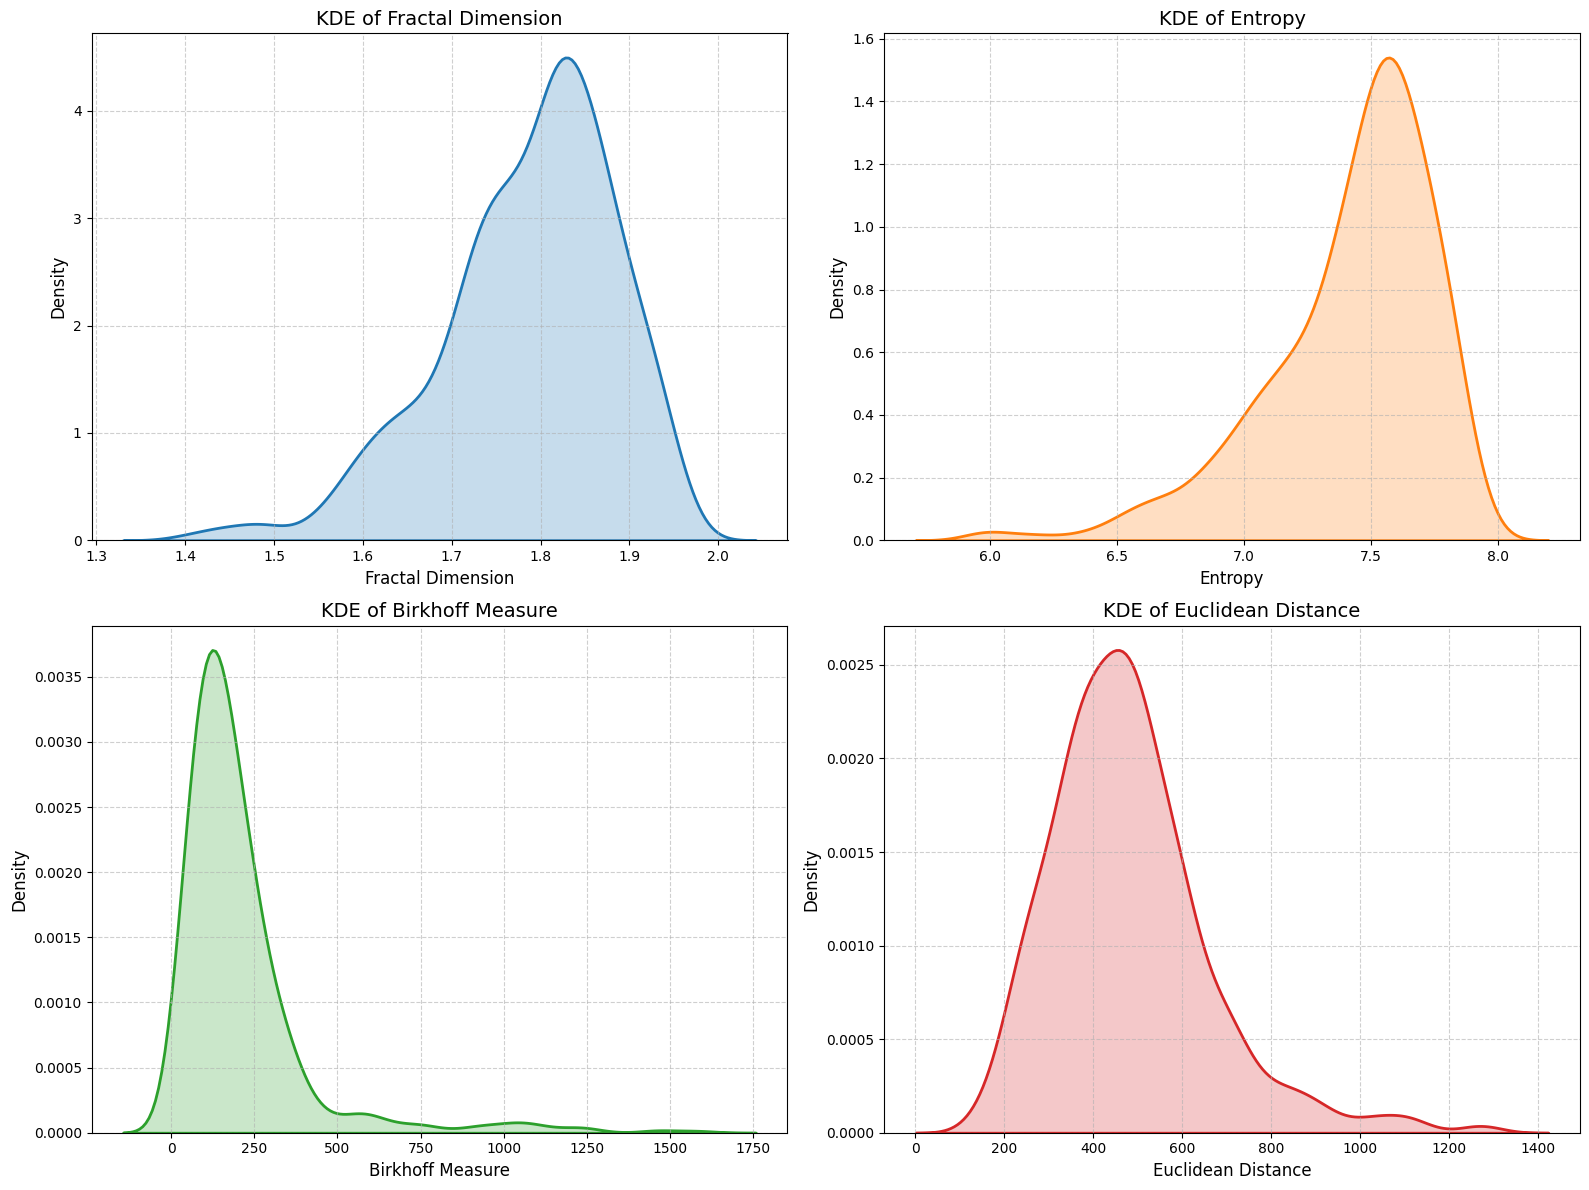

Generating bivariate KDE plots for all unique metric pairs...


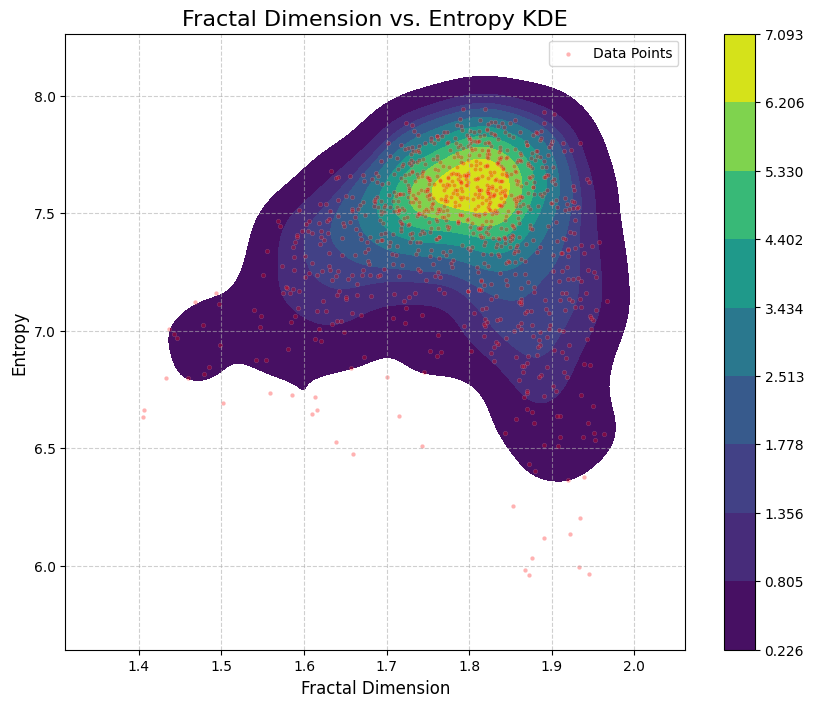

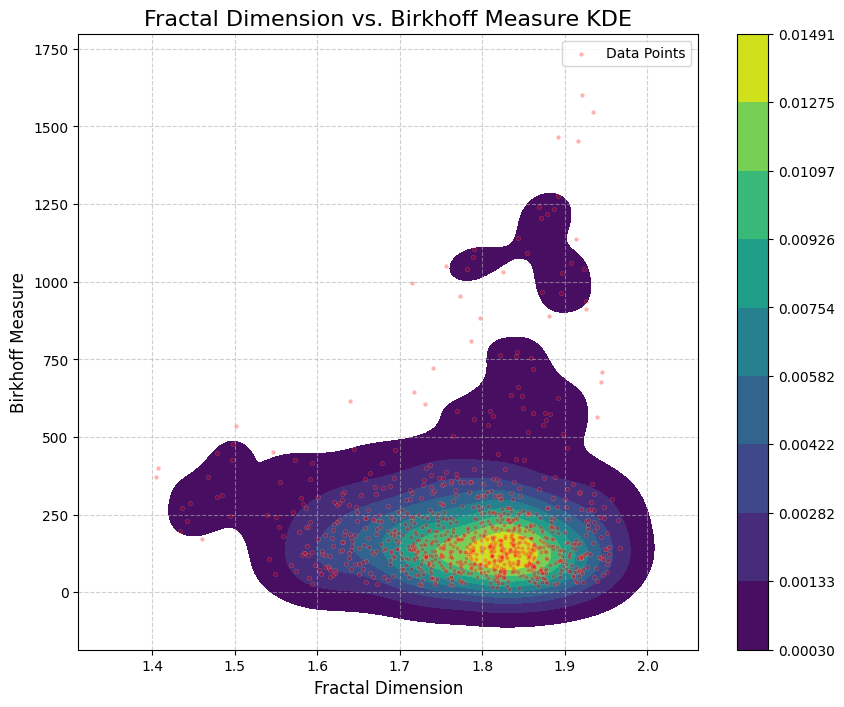

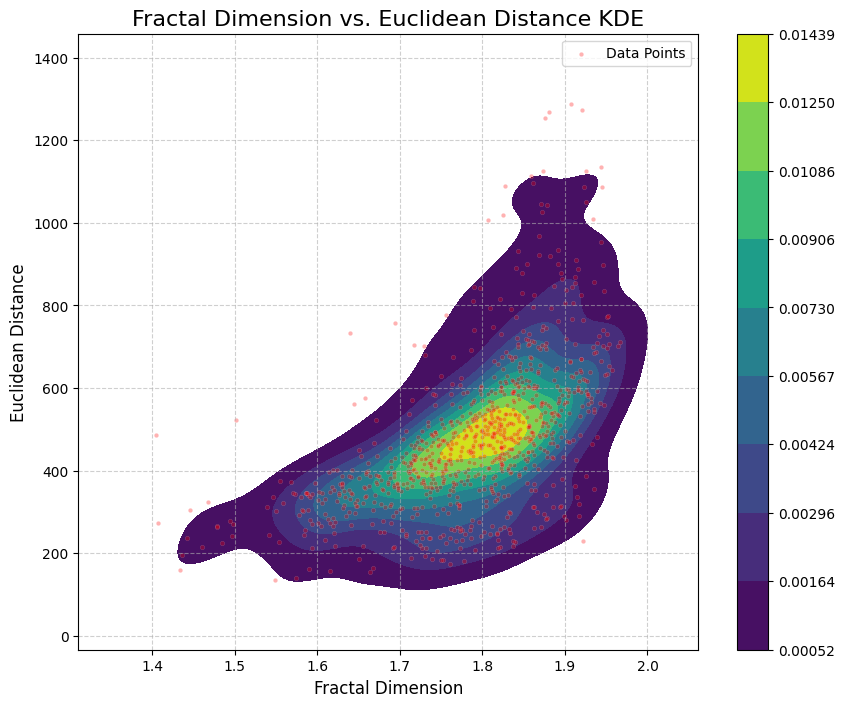

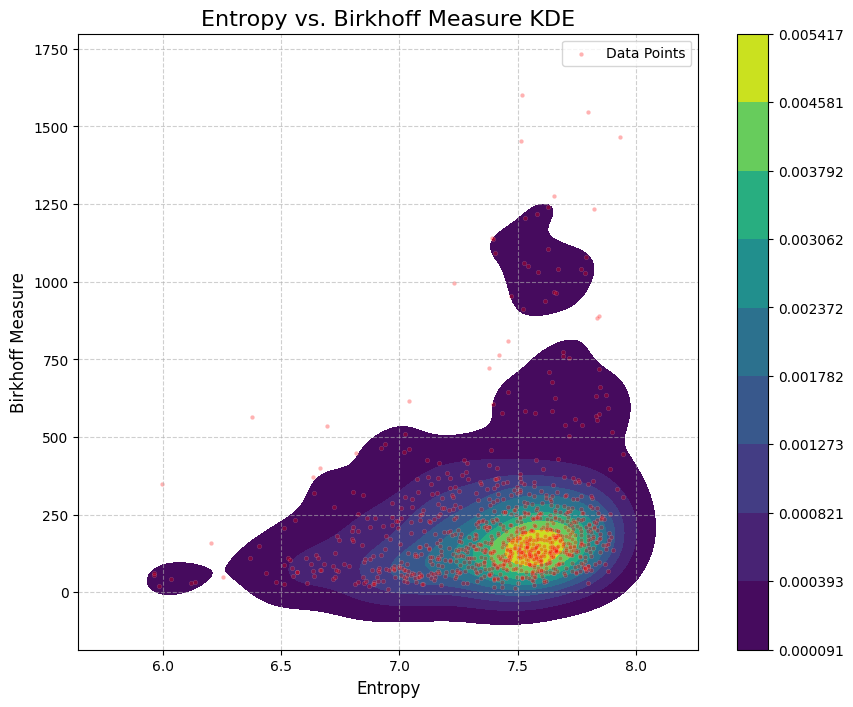

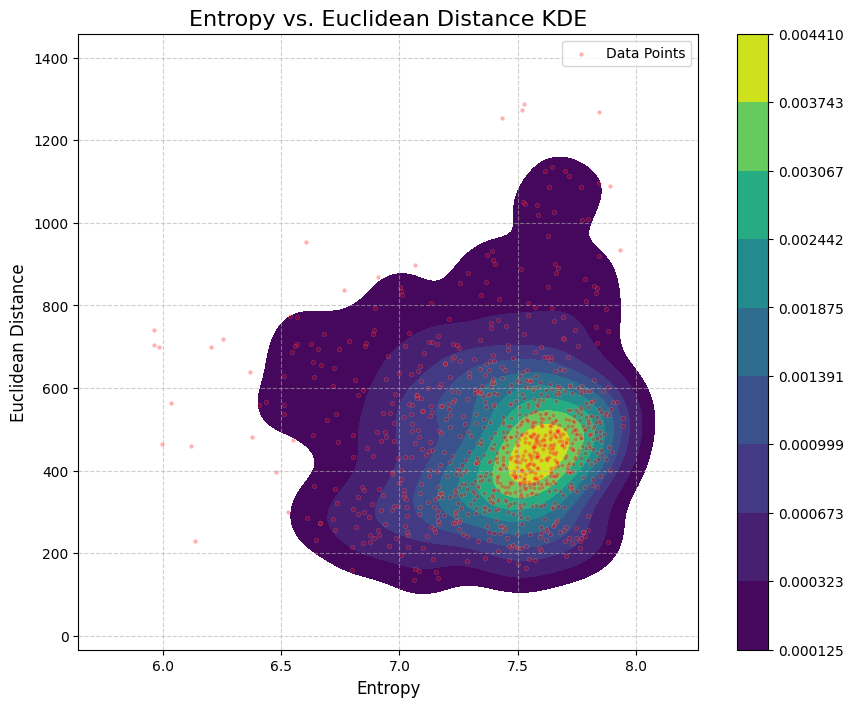

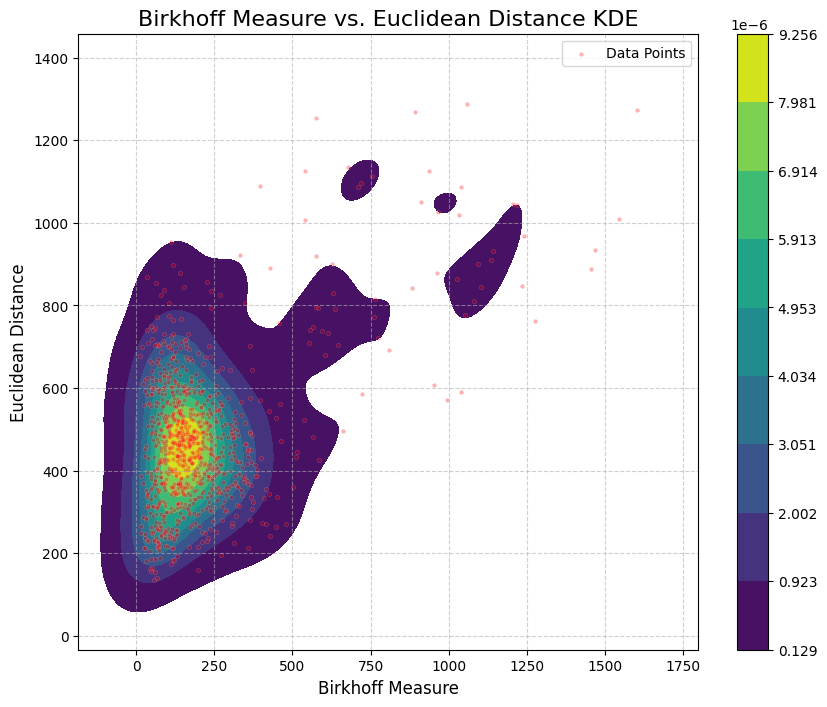

: 

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module for path operations
from itertools import combinations # Import combinations for bivariate plots

# --- Configuration for file paths and output ---
file_path = ".\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv"
output_plot_dir = ".\\PLOT NORMALIZED\\KDE PLOT" # Define an output directory for plots

# Create the output directory if it doesn't exist
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)
    print(f"Created output directory: {output_plot_dir}")

# -----------------------------------------------------------------------------
# 1. Data Preparation: Load DataFrame
# -----------------------------------------------------------------------------

try:
    df = pd.read_csv(file_path, decimal=',')
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numerical Features and Clean Data
# -----------------------------------------------------------------------------

features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
grouping_column = 'Period' # Ensure this is the correct column for your periods/styles

# Check for existence of grouping column
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name for artistic periods/styles.")

# Convert feature columns to numeric, coercing errors to NaN
original_features_copy = features.copy()
for col in original_features_copy:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. It will be ignored.")
        features.remove(col)
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().all():
            print(f"Warning: Column '{col}' contains only NaN values after conversion and will be ignored.")
            features.remove(col)

if not features:
    raise ValueError("No specified metric columns were found or contain valid numerical data after processing. Cannot proceed.")
else:
    print(f"Features selected for analysis: {features}")

# Create a cleaned DataFrame for KDE plots and also for Mahalanobis calculations
# This df_cleaned_for_kde will be used for all subsequent calculations and plots
df_cleaned_for_kde = df.dropna(subset=features).copy()
initial_rows_count = len(df)
if len(df_cleaned_for_kde) < initial_rows_count:
    print(f"Warning: Removed {initial_rows_count - len(df_cleaned_for_kde)} rows due to NaN values in feature columns.")

if df_cleaned_for_kde.empty:
    raise ValueError("DataFrame is empty after cleaning NaN values. Cannot proceed with calculations.")


# --- Define mappings for KDE plots (based on the cleaned 'features' list) ---
# Use 'features' list directly as CSV headers for KDE plots
all_metrics_csv_headers = features

# Dynamically create the mapping from actual column names to readable labels
# Assuming you want to display them nicely. If your CSV headers are already nice, you might simplify this.
metric_names_csv_to_english = {
    'Fractal dimension': 'Fractal Dimension',
    'Entropy': 'Entropy',
    'Birkhoff measure': 'Birkhoff Measure',
    'Euclidean distance': 'Euclidean Distance'
}
# Ensure all selected features have a mapping, add a default if not
for metric_header in all_metrics_csv_headers:
    if metric_header not in metric_names_csv_to_english:
        metric_names_csv_to_english[metric_header] = metric_header.replace('_', ' ').title()


# -----------------------------------------------------------------------------
# 3. Normalize Metrics (Min-Max Scaling between 0 and 1)
# -----------------------------------------------------------------------------

df_normalized = df_cleaned_for_kde.copy() # Start with the cleaned DataFrame

scaler = MinMaxScaler()

if not df_normalized[features].empty:
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    print("\nDataFrame with Normalized Metrics (Min-Max [0, 1]) (first 5 rows):")
    print(df_normalized.head())
else:
    print("\nWarning: No data to normalize after cleaning. Normalized DataFrame is empty.")
print("-" * 50)

# -----------------------------------------------------------------------------
# 4. Calculate Mahalanobis Distance on Normalized Data
# -----------------------------------------------------------------------------

df_normalized['Mahalanobis_Distance_Normalized'] = np.nan
mahalanobis_distances_map = {}

for period, group in df_normalized.groupby(grouping_column):
    print(f"\nProcessing Period: {period} 🎨")

    numeric_data_normalized = group[features]
    num_points = len(numeric_data_normalized)
    num_features = len(features)

    print(f"  Number of data points in this period: {num_points}")
    print(f"  Number of features: {num_features}")

    if num_points < num_features + 1:
        print(f"  Warning: Insufficient data points ({num_points}) for period '{period}' to compute a robust covariance matrix for {num_features} features. Mahalanobis distances will be NaN for this period.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    centroid_normalized = numeric_data_normalized.mean().values

    covariance_matrix_normalized = numeric_data_normalized.cov()

    cov_matrix_np = covariance_matrix_normalized.values

    if np.isnan(cov_matrix_np).any() or np.isinf(cov_matrix_np).any():
        print(f"  Error: Covariance matrix for period '{period}' contains NaN or Inf values. This might be due to insufficient non-NaN data or numerical instability. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        det_cov = np.linalg.det(cov_matrix_np)
        if det_cov == 0:
            print(f"  Warning: Covariance matrix for period '{period}' is singular (determinant is 0). Adding jitter to make it invertible.")
            cov_matrix_np += np.eye(cov_matrix_np.shape[0]) * 1e-6
            det_cov_after_jitter = np.linalg.det(cov_matrix_np)
            if det_cov_after_jitter == 0:
                 print(f"  Critical Error: Covariance matrix for period '{period}' remains singular even after adding jitter. Cannot invert. Distances will be NaN.")
                 for idx in group.index:
                    mahalanobis_distances_map[idx] = np.nan
                 continue
    except np.linalg.LinAlgError:
        print(f"  Error: Could not compute determinant of covariance matrix for period '{period}'. Setting distances to NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        inv_covariance_matrix_normalized = np.linalg.inv(cov_matrix_np)
    except np.linalg.LinAlgError as e:
        print(f"  Error: Could not invert covariance matrix for period '{period}' (after jitter): {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue
    except Exception as e:
        print(f"  Unexpected error during covariance matrix inversion for period '{period}': {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    for index, row in numeric_data_normalized.iterrows():
        point_normalized = row.values
        try:
            if np.isnan(point_normalized).any() or np.isinf(point_normalized).any():
                print(f"  Skipping Mahalanobis calculation for index {index} due to NaN/Inf in point data.")
                mahalanobis_distances_map[index] = np.nan
                continue

            dist = mahalanobis(point_normalized, centroid_normalized, inv_covariance_matrix_normalized)
            mahalanobis_distances_map[index] = dist
        except Exception as e:
            print(f"  Error calculating Mahalanobis distance for index {index} in period '{period}': {e}. Setting to NaN.")
            mahalanobis_distances_map[index] = np.nan

df_normalized['Mahalanobis_Distance_Normalized'] = df_normalized.index.map(mahalanobis_distances_map)

print("\nDataFrame with Individual Mahalanobis Distances (on normalized data [0, 1]) (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)

# -----------------------------------------------------------------------------
# 5. Calculate "Contextual Fit" (Inverse of Mahalanobis Distance)
# -----------------------------------------------------------------------------

epsilon = 1e-9
df_normalized['Contextual_Fit'] = 1 / (df_normalized['Mahalanobis_Distance_Normalized'] + epsilon)

df_normalized.loc[df_normalized['Mahalanobis_Distance_Normalized'].isna(), 'Contextual_Fit'] = np.nan

print("\nDataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)
print("Calculations complete!")

# -----------------------------------------------------------------------------
# 6. Calculate Mean and Standard Deviation of Mahalanobis Distance and Contextual Fit
# -----------------------------------------------------------------------------

mean_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].mean()
print("\nMean of Normalized Mahalanobis Distance [0, 1] per Period:")
print(mean_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

std_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].std()
print("Standard Deviation of Normalized Mahalanobis Distance [0, 1] per Period:")
print(std_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

mean_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].mean()
print("Mean of 'Contextual_Fit' per Period:")
print(mean_contextual_fit_by_period)

print("\n" + "-" * 50 + "\n")

std_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].std()
print("Standard Deviation of 'Contextual_Fit' per Period:")
print(std_contextual_fit_by_period)

print("\n" + "=" * 50 + "\n")


# --- NEW SECTION: Smooth Kernel Density Estimation (KDE) Plots ---
print("\nGenerating Smooth Kernel Density Estimation (KDE) Plots...")

# 2.1 Univariate KDE Plots for each metric in a 2x2 subplot
print("Generating a 2x2 subplot for univariate KDE plots for each metric...")

if not df_cleaned_for_kde.empty:
    colors = sns.color_palette("tab10", len(all_metrics_csv_headers))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, metric_header in enumerate(all_metrics_csv_headers):
        ax = axes[i]
        metric_english_label = metric_names_csv_to_english[metric_header]

        sns.kdeplot(data=df_cleaned_for_kde, x=metric_header, fill=True, color=colors[i], linewidth=2, ax=ax)
        ax.set_title(f'KDE of {metric_english_label}', fontsize=14)
        ax.set_xlabel(metric_english_label, fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    combined_kde_filename = 'all_univariate_kde_2x2_subplot.png'
    plt.savefig(os.path.join(output_plot_dir, combined_kde_filename))
    plt.show()
else:
    print("Skipping univariate KDE plots: No valid data after cleaning for metrics.")


# 2.2 Bivariate KDE Plots for all unique metric pairs
print("Generating bivariate KDE plots for all unique metric pairs...")
metric_pairs_kde_csv = list(combinations(all_metrics_csv_headers, 2))

if not df_cleaned_for_kde.empty and len(metric_pairs_kde_csv) > 0:
    for metric_x_csv, metric_y_csv in metric_pairs_kde_csv:
        metric_x_english_label = metric_names_csv_to_english[metric_x_csv]
        metric_y_english_label = metric_names_csv_to_english[metric_y_csv]

        plt.figure(figsize=(10, 8))
        sns.kdeplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, fill=True, cmap='viridis', cbar=True)
        # Adding data points for context
        sns.scatterplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, color='red', s=10, alpha=0.3, label='Data Points')
        plt.title(f'{metric_x_english_label} vs. {metric_y_english_label} KDE', fontsize=16) # Added 'KDE' to title
        plt.xlabel(metric_x_english_label, fontsize=12)
        plt.ylabel(metric_y_english_label, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        filename_x = metric_x_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename_y = metric_y_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename = f'kde_bivariate_{filename_x}_vs_{filename_y}.png'
        plt.savefig(os.path.join(output_plot_dir, filename))
        plt.show()
else:
    print("Skipping bivariate KDE plots: Not enough valid data or metrics (need at least 2) after cleaning.")

# **STEP 12.1 : KERNEL DISTRIBUTION**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module for path operations
from itertools import combinations # Import combinations for bivariate plots

# --- Configuration for file paths and output ---
file_path = ".\\CSV\\metrics_with_details_no_outlier.csv"
output_plot_dir = ".\\PLOT\\KDE PLOT" # Define an output directory for plots

# Create the output directory if it doesn't exist
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)
    print(f"Created output directory: {output_plot_dir}")

# -----------------------------------------------------------------------------
# 1. Data Preparation: Load DataFrame
# -----------------------------------------------------------------------------

try:
    df = pd.read_csv(file_path, decimal=',')
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numerical Features and Clean Data
# -----------------------------------------------------------------------------

features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
grouping_column = 'Period' # Ensure this is the correct column for your periods/styles

# Check for existence of grouping column
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name for artistic periods/styles.")

# Convert feature columns to numeric, coercing errors to NaN
original_features_copy = features.copy()
for col in original_features_copy:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. It will be ignored.")
        features.remove(col)
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().all():
            print(f"Warning: Column '{col}' contains only NaN values after conversion and will be ignored.")
            features.remove(col)

if not features:
    raise ValueError("No specified metric columns were found or contain valid numerical data after processing. Cannot proceed.")
else:
    print(f"Features selected for analysis: {features}")

# Create a cleaned DataFrame for KDE plots and also for Mahalanobis calculations
# This df_cleaned_for_kde will be used for all subsequent calculations and plots
df_cleaned_for_kde = df.dropna(subset=features).copy()
initial_rows_count = len(df)
if len(df_cleaned_for_kde) < initial_rows_count:
    print(f"Warning: Removed {initial_rows_count - len(df_cleaned_for_kde)} rows due to NaN values in feature columns.")

if df_cleaned_for_kde.empty:
    raise ValueError("DataFrame is empty after cleaning NaN values. Cannot proceed with calculations.")


# --- Define mappings for KDE plots (based on the cleaned 'features' list) ---
# Use 'features' list directly as CSV headers for KDE plots
all_metrics_csv_headers = features

# Dynamically create the mapping from actual column names to readable labels
# Assuming you want to display them nicely. If your CSV headers are already nice, you might simplify this.
metric_names_csv_to_english = {
    'Fractal dimension': 'Fractal Dimension',
    'Entropy': 'Entropy',
    'Birkhoff measure': 'Birkhoff Measure',
    'Euclidean distance': 'Euclidean Distance'
}
# Ensure all selected features have a mapping, add a default if not
for metric_header in all_metrics_csv_headers:
    if metric_header not in metric_names_csv_to_english:
        metric_names_csv_to_english[metric_header] = metric_header.replace('_', ' ').title()


# -----------------------------------------------------------------------------
# 3. Normalize Metrics (Min-Max Scaling between 0 and 1)
# -----------------------------------------------------------------------------

df_normalized = df_cleaned_for_kde.copy() # Start with the cleaned DataFrame

scaler = MinMaxScaler()

if not df_normalized[features].empty:
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    print("\nDataFrame with Normalized Metrics (Min-Max [0, 1]) (first 5 rows):")
    print(df_normalized.head())
else:
    print("\nWarning: No data to normalize after cleaning. Normalized DataFrame is empty.")
print("-" * 50)

# -----------------------------------------------------------------------------
# 4. Calculate Mahalanobis Distance on Normalized Data
# -----------------------------------------------------------------------------

df_normalized['Mahalanobis_Distance_Normalized'] = np.nan
mahalanobis_distances_map = {}

for period, group in df_normalized.groupby(grouping_column):
    print(f"\nProcessing Period: {period} 🎨")

    numeric_data_normalized = group[features]
    num_points = len(numeric_data_normalized)
    num_features = len(features)

    print(f"  Number of data points in this period: {num_points}")
    print(f"  Number of features: {num_features}")

    if num_points < num_features + 1:
        print(f"  Warning: Insufficient data points ({num_points}) for period '{period}' to compute a robust covariance matrix for {num_features} features. Mahalanobis distances will be NaN for this period.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    centroid_normalized = numeric_data_normalized.mean().values

    covariance_matrix_normalized = numeric_data_normalized.cov()

    cov_matrix_np = covariance_matrix_normalized.values

    if np.isnan(cov_matrix_np).any() or np.isinf(cov_matrix_np).any():
        print(f"  Error: Covariance matrix for period '{period}' contains NaN or Inf values. This might be due to insufficient non-NaN data or numerical instability. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        det_cov = np.linalg.det(cov_matrix_np)
        if det_cov == 0:
            print(f"  Warning: Covariance matrix for period '{period}' is singular (determinant is 0). Adding jitter to make it invertible.")
            cov_matrix_np += np.eye(cov_matrix_np.shape[0]) * 1e-6
            det_cov_after_jitter = np.linalg.det(cov_matrix_np)
            if det_cov_after_jitter == 0:
                 print(f"  Critical Error: Covariance matrix for period '{period}' remains singular even after adding jitter. Cannot invert. Distances will be NaN.")
                 for idx in group.index:
                    mahalanobis_distances_map[idx] = np.nan
                 continue
    except np.linalg.LinAlgError:
        print(f"  Error: Could not compute determinant of covariance matrix for period '{period}'. Setting distances to NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        inv_covariance_matrix_normalized = np.linalg.inv(cov_matrix_np)
    except np.linalg.LinAlgError as e:
        print(f"  Error: Could not invert covariance matrix for period '{period}' (after jitter): {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue
    except Exception as e:
        print(f"  Unexpected error during covariance matrix inversion for period '{period}': {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    for index, row in numeric_data_normalized.iterrows():
        point_normalized = row.values
        try:
            if np.isnan(point_normalized).any() or np.isinf(point_normalized).any():
                print(f"  Skipping Mahalanobis calculation for index {index} due to NaN/Inf in point data.")
                mahalanobis_distances_map[index] = np.nan
                continue

            dist = mahalanobis(point_normalized, centroid_normalized, inv_covariance_matrix_normalized)
            mahalanobis_distances_map[index] = dist
        except Exception as e:
            print(f"  Error calculating Mahalanobis distance for index {index} in period '{period}': {e}. Setting to NaN.")
            mahalanobis_distances_map[index] = np.nan

df_normalized['Mahalanobis_Distance_Normalized'] = df_normalized.index.map(mahalanobis_distances_map)

print("\nDataFrame with Individual Mahalanobis Distances (on normalized data [0, 1]) (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)

# -----------------------------------------------------------------------------
# 5. Calculate "Contextual Fit" (Inverse of Mahalanobis Distance)
# -----------------------------------------------------------------------------

epsilon = 1e-9
df_normalized['Contextual_Fit'] = 1 / (df_normalized['Mahalanobis_Distance_Normalized'] + epsilon)

df_normalized.loc[df_normalized['Mahalanobis_Distance_Normalized'].isna(), 'Contextual_Fit'] = np.nan

print("\nDataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)
print("Calculations complete!")

# -----------------------------------------------------------------------------
# 6. Calculate Mean and Standard Deviation of Mahalanobis Distance and Contextual Fit
# -----------------------------------------------------------------------------

mean_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].mean()
print("\nMean of Normalized Mahalanobis Distance [0, 1] per Period:")
print(mean_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

std_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].std()
print("Standard Deviation of Normalized Mahalanobis Distance [0, 1] per Period:")
print(std_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

mean_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].mean()
print("Mean of 'Contextual_Fit' per Period:")
print(mean_contextual_fit_by_period)

print("\n" + "-" * 50 + "\n")

std_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].std()
print("Standard Deviation of 'Contextual_Fit' per Period:")
print(std_contextual_fit_by_period)

print("\n" + "=" * 50 + "\n")


# --- NEW SECTION: Smooth Kernel Density Estimation (KDE) Plots ---
print("\nGenerating Smooth Kernel Density Estimation (KDE) Plots...")

# 2.1 Univariate KDE Plots for each metric in a 2x2 subplot
print("Generating a 2x2 subplot for univariate KDE plots for each metric...")

if not df_cleaned_for_kde.empty:
    colors = sns.color_palette("tab10", len(all_metrics_csv_headers))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, metric_header in enumerate(all_metrics_csv_headers):
        ax = axes[i]
        metric_english_label = metric_names_csv_to_english[metric_header]

        sns.kdeplot(data=df_cleaned_for_kde, x=metric_header, fill=True, color=colors[i], linewidth=2, ax=ax)
        ax.set_title(f'KDE of {metric_english_label}', fontsize=14)
        ax.set_xlabel(metric_english_label, fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    combined_kde_filename = 'all_univariate_kde_2x2_subplot.png'
    plt.savefig(os.path.join(output_plot_dir, combined_kde_filename))
    plt.show()
else:
    print("Skipping univariate KDE plots: No valid data after cleaning for metrics.")


# 2.2 Bivariate KDE Plots for all unique metric pairs
print("Generating bivariate KDE plots for all unique metric pairs...")
metric_pairs_kde_csv = list(combinations(all_metrics_csv_headers, 2))

if not df_cleaned_for_kde.empty and len(metric_pairs_kde_csv) > 0:
    for metric_x_csv, metric_y_csv in metric_pairs_kde_csv:
        metric_x_english_label = metric_names_csv_to_english[metric_x_csv]
        metric_y_english_label = metric_names_csv_to_english[metric_y_csv]

        plt.figure(figsize=(10, 8))
        sns.kdeplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, fill=True, cmap='viridis', cbar=True)
        # Adding data points for context
        sns.scatterplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, color='red', s=10, alpha=0.3, label='Data Points')
        plt.title(f'{metric_x_english_label} vs. {metric_y_english_label} KDE', fontsize=16) # Added 'KDE' to title
        plt.xlabel(metric_x_english_label, fontsize=12)
        plt.ylabel(metric_y_english_label, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        filename_x = metric_x_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename_y = metric_y_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename = f'kde_bivariate_{filename_x}_vs_{filename_y}.png'
        plt.savefig(os.path.join(output_plot_dir, filename))
        plt.show()
else:
    print("Skipping bivariate KDE plots: Not enough valid data or metrics (need at least 2) after cleaning.")

# **STEP 13: (NORMALIZED) HAUSDORFF MEASURE**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist # For calculating pairwise distances
from sklearn.preprocessing import MinMaxScaler # For data normalization

def hausdorff_multidimensional(A, B):
    """
    Calculates the Hausdorff distance between two multidimensional sets.
    A and B are arrays (or lists of lists/tuples) where each row is a point
    and each column represents a dimension.
    """
    A = np.array(A)
    B = np.array(B)

    if A.size == 0 or B.size == 0:
        # If one of the sets is empty, Hausdorff distance is often defined as 0.0
        # or undefined, depending on the context. Here, we assume 0.0.
        return 0.0

    # Calculate all-to-all Euclidean distances between points in A and B
    distances_AB = cdist(A, B, 'euclidean')
    distances_BA = cdist(B, A, 'euclidean')

    # min_dist_A_to_B will contain the minimum distance from each point in A to set B
    min_dist_A_to_B = np.min(distances_AB, axis=1)
    # d_AB is the maximum of these minimum distances (directed Hausdorff from A to B)
    d_AB = np.max(min_dist_A_to_B)

    # min_dist_B_to_A will contain the minimum distance from each point in B to set A
    min_dist_B_to_A = np.min(distances_BA, axis=1)
    # d_BA is the maximum of these minimum distances (directed Hausdorff from B to A)
    d_BA = np.max(min_dist_B_to_A)

    # The Hausdorff distance is the maximum of the two directed distances
    return max(d_AB, d_BA)

# Define the specified order of your styles/periods
style_order = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Load the data
# Ensure the CSV file path is correct.
# --- CRUCIAL CHANGE HERE: Added decimal=',' ---
try:
    df = pd.read_csv(".\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_with_details_no_outlier.csv' was not found.")
    print("Ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Filter: Keep only rows with valid styles as per style_order
# Assuming your period column is named 'Period'
df = df[df["Period"].isin(style_order)].copy()

# Identify the numeric columns to apply normalization on.
# These should be the raw metric columns from your CSV
metrics_cols = [
    "Fractal dimension",
    "Entropy",
    "Birkhoff measure",
    "Euclidean distance"
]

# Filter columns to ensure they exist in the DataFrame and are numeric
# Explicitly convert to numeric and handle errors
for col in metrics_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
    else:
        # Attempt to convert the column to numeric type, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove columns that do not exist in the DataFrame after initial check
metrics_cols = [col for col in metrics_cols if col in df.columns]

if not metrics_cols:
    raise ValueError("None of the specified metric columns were found in the CSV or converted to numeric. Check column names and values.")

# --- Data Normalization ---
# Remove rows with NaN values in metric columns before normalization
initial_rows = len(df)
df.dropna(subset=metrics_cols, inplace=True)
if len(df) < initial_rows:
    print(f"Warning: Removed {initial_rows - len(df)} rows with NaN values in metric columns before normalization.")

if df.empty:
    raise ValueError("DataFrame is empty after NaN removal. Cannot proceed with normalization and distance calculation.")

# Apply MinMaxScaler to scale metrics to [0, 1] range
scaler = MinMaxScaler()
df[metrics_cols] = scaler.fit_transform(df[metrics_cols])
print("Metric data successfully normalized to the [0, 1] range.")
# --- End Normalization ---

# List to store results
results_multidimensional = []

# Loop through consecutive pairs of styles
for i in range(len(style_order) - 1):
    style1 = style_order[i]
    style2 = style_order[i + 1]

    print(f"\nCalculating Hausdorff distance for: ({style1}, {style2})")

    subset1_raw = df[df["Period"] == style1]
    subset2_raw = df[df["Period"] == style2]

    # Prepare data for the Hausdorff function
    # Ensure subsets are not empty after filtering
    data1 = subset1_raw[metrics_cols].values
    data2 = subset2_raw[metrics_cols].values

    if data1.size == 0:
        print(f"  Warning: No valid data for style '{style1}'. Distance set to NaN.")
        hausdorff_dist_multi = np.nan
    elif data2.size == 0:
        print(f"  Warning: No valid data for style '{style2}'. Distance set to NaN.")
        hausdorff_dist_multi = np.nan
    else:
        # Calculate the multidimensional Hausdorff distance
        hausdorff_dist_multi = hausdorff_multidimensional(data1, data2)
        print(f"  Hausdorff Distance: {hausdorff_dist_multi:.4f}")

    results_multidimensional.append({
        "From": style1,
        "To": style2,
        "Hausdorff Measure": hausdorff_dist_multi
    })

# Final results
results_df_multidimensional = pd.DataFrame(results_multidimensional)
print("\n--- Multidimensional Hausdorff Distance Results ---")
print(results_df_multidimensional)

output_csv_path = ".\\CSV NORMALIZED\\normalized_hausdorff4D.csv"
results_df_multidimensional.to_csv(output_csv_path, index=False)
print(f"\nResults have been saved to '{output_csv_path}'")

# **STEP 13.1: HAUSDORFF MEASURE**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist # For calculating pairwise distances
from sklearn.preprocessing import MinMaxScaler # For data normalization

def hausdorff_multidimensional(A, B):
    """
    Calculates the Hausdorff distance between two multidimensional sets.
    A and B are arrays (or lists of lists/tuples) where each row is a point
    and each column represents a dimension.
    """
    A = np.array(A)
    B = np.array(B)

    if A.size == 0 or B.size == 0:
        # If one of the sets is empty, Hausdorff distance is often defined as 0.0
        # or undefined, depending on the context. Here, we assume 0.0.
        return 0.0

    # Calculate all-to-all Euclidean distances between points in A and B
    distances_AB = cdist(A, B, 'euclidean')
    distances_BA = cdist(B, A, 'euclidean')

    # min_dist_A_to_B will contain the minimum distance from each point in A to set B
    min_dist_A_to_B = np.min(distances_AB, axis=1)
    # d_AB is the maximum of these minimum distances (directed Hausdorff from A to B)
    d_AB = np.max(min_dist_A_to_B)

    # min_dist_B_to_A will contain the minimum distance from each point in B to set A
    min_dist_B_to_A = np.min(distances_BA, axis=1)
    # d_BA is the maximum of these minimum distances (directed Hausdorff from B to A)
    d_BA = np.max(min_dist_B_to_A)

    # The Hausdorff distance is the maximum of the two directed distances
    return max(d_AB, d_BA)

# Define the specified order of your styles/periods
style_order = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Load the data
# Ensure the CSV file path is correct.
# --- CRUCIAL CHANGE HERE: Added decimal=',' ---
try:
    df = pd.read_csv(".\\CSV\\metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_with_details_no_outlier.csv' was not found.")
    print("Ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Filter: Keep only rows with valid styles as per style_order
# Assuming your period column is named 'Period'
df = df[df["Period"].isin(style_order)].copy()

# Identify the numeric columns to apply normalization on.
# These should be the raw metric columns from your CSV
metrics_cols = [
    "Fractal dimension",
    "Entropy",
    "Birkhoff measure",
    "Euclidean distance"
]

# Filter columns to ensure they exist in the DataFrame and are numeric
# Explicitly convert to numeric and handle errors
for col in metrics_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
    else:
        # Attempt to convert the column to numeric type, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove columns that do not exist in the DataFrame after initial check
metrics_cols = [col for col in metrics_cols if col in df.columns]

if not metrics_cols:
    raise ValueError("None of the specified metric columns were found in the CSV or converted to numeric. Check column names and values.")

# --- Data Normalization ---
# Remove rows with NaN values in metric columns before normalization
initial_rows = len(df)
df.dropna(subset=metrics_cols, inplace=True)
if len(df) < initial_rows:
    print(f"Warning: Removed {initial_rows - len(df)} rows with NaN values in metric columns before normalization.")

if df.empty:
    raise ValueError("DataFrame is empty after NaN removal. Cannot proceed with normalization and distance calculation.")

# Apply MinMaxScaler to scale metrics to [0, 1] range
scaler = MinMaxScaler()
df[metrics_cols] = scaler.fit_transform(df[metrics_cols])
print("Metric data successfully normalized to the [0, 1] range.")
# --- End Normalization ---

# List to store results
results_multidimensional = []

# Loop through consecutive pairs of styles
for i in range(len(style_order) - 1):
    style1 = style_order[i]
    style2 = style_order[i + 1]

    print(f"\nCalculating Hausdorff distance for: ({style1}, {style2})")

    subset1_raw = df[df["Period"] == style1]
    subset2_raw = df[df["Period"] == style2]

    # Prepare data for the Hausdorff function
    # Ensure subsets are not empty after filtering
    data1 = subset1_raw[metrics_cols].values
    data2 = subset2_raw[metrics_cols].values

    if data1.size == 0:
        print(f"  Warning: No valid data for style '{style1}'. Distance set to NaN.")
        hausdorff_dist_multi = np.nan
    elif data2.size == 0:
        print(f"  Warning: No valid data for style '{style2}'. Distance set to NaN.")
        hausdorff_dist_multi = np.nan
    else:
        # Calculate the multidimensional Hausdorff distance
        hausdorff_dist_multi = hausdorff_multidimensional(data1, data2)
        print(f"  Hausdorff Distance: {hausdorff_dist_multi:.4f}")

    results_multidimensional.append({
        "From": style1,
        "To": style2,
        "Hausdorff Measure": hausdorff_dist_multi
    })

# Final results
results_df_multidimensional = pd.DataFrame(results_multidimensional)
print("\n--- Multidimensional Hausdorff Distance Results ---")
print(results_df_multidimensional)

output_csv_path = ".\\CSV\\hausdorff4D.csv"
results_df_multidimensional.to_csv(output_csv_path, index=False)
print(f"\nResults have been saved to '{output_csv_path}'")

# **STEP 14: (NORMALIZED) CONTEXTUAL FIT**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis # For Mahalanobis distance calculation
import os # Imported for potential future use or to match existing script structure

# Load the data
# --- MODIFICATION HERE: Added decimal=',' ---
try:
    df = pd.read_csv(".\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_with_details_no_outlier.csv' was not found.")
    print("Ensure the file is in the same directory as the script or that the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head()) # Print only the first few rows to keep output concise
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numeric Features
# -----------------------------------------------------------------------------

# List of numeric columns on which we will calculate the Mahalanobis distance.
# Ensure these names exactly match your columns in the CSV.
features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# --- Convert feature columns to numeric and handle NaNs ---
for col in features:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame. It will be ignored.")
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Force conversion, placing NaN on error

# Remove columns that were not found or were entirely NaN after conversion
features = [col for col in features if col in df.columns and not df[col].isnull().all()] # Also remove all-NaN columns

if not features:
    raise ValueError("None of the specified metric columns were found or contain valid numeric values in the CSV.")

# Remove rows that have NaNs in the specified features after conversion
initial_rows = len(df)
df.dropna(subset=features, inplace=True)
if len(df) < initial_rows:
    print(f"Warning: Removed {initial_rows - len(df)} rows with NaN values in the specified features after numeric conversion.")
if df.empty:
    print("DataFrame is empty after cleaning NaN values. Cannot proceed.")
    exit()

# -----------------------------------------------------------------------------
# 3. Calculate Mahalanobis Measure for Each Style
# -----------------------------------------------------------------------------

# Initialize an empty list to collect all calculated distances.
all_mahalanobis_distances = []

# --- MODIFICATION HERE: Group by 'Period' instead of 'Style' if 'Period' is the correct name ---
# If your CSV has a 'Style' column and you want to group by that, revert to 'Style'.
grouping_column = 'Period' # Or 'Style' depending on your CSV

if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Check the column name for periods/styles.")

# Map original DataFrame index to calculated distances
# We will use a dictionary to populate distances by original index
mahalanobis_distances_map = {}

for style, group in df.groupby(grouping_column):
    print(f"\nProcessing style: {style} 🎨")

    numeric_data = group[features]

    # Check if there are enough points to calculate the covariance matrix.
    if len(numeric_data) < len(features): # At least N points for N features for non-singular covariance
        print(f"  Warning: Not enough points ({len(numeric_data)}) for style '{style}' relative to the number of features ({len(features)}) to calculate a robust covariance matrix. Distances for this style might be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calculate the centroid (mean) for the current style.
    centroid = numeric_data.mean().values
    # print(f"  Centroid for {style}:\n  {centroid}") # Commented out for cleaner output

    # Calculate the covariance matrix for the current style.
    covariance_matrix = numeric_data.cov()

    # Check if the covariance matrix is singular (not invertible).
    # Add a small value to the diagonal to make it invertible (regularization).
    if np.linalg.det(covariance_matrix) == 0:
        covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6
        print("  Warning: Covariance matrix was singular. A small diagonal term was added to make it invertible.")

    try:
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        # print(f"  Inverse Covariance Matrix for {style}:\n{inv_covariance_matrix}") # Commented out for cleaner output
    except np.linalg.LinAlgError:
        print(f"  Error: Could not invert the covariance matrix for style '{style}' even after regularization. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calculate the Mahalanobis distance for each row (artwork) in the current group.
    for index, row in numeric_data.iterrows():
        point = row.values
        try:
            dist = mahalanobis(point, centroid, inv_covariance_matrix)
            mahalanobis_distances_map[index] = dist
            # print(f"    Artwork: {df.loc[index, 'Name of the painting']}, Mahalanobis Distance: {dist:.4f}") # Commented out for cleaner output
        except Exception as e:
            # Added a check if 'Name of the painting' column exists, otherwise use index for error message
            painting_id = df.loc[index, 'Name of the painting'] if 'Name of the painting' in df.columns else f"index {index}"
            print(f"    Error calculating Mahalanobis distance for artwork {painting_id}: {e}. NaN will be inserted.")
            mahalanobis_distances_map[index] = np.nan

# Populate the new column in the original DataFrame using the map
df['Mahalanobis_Distance'] = df.index.map(mahalanobis_distances_map)

print("\n" + "=" * 50)
print("Final DataFrame with Mahalanobis Distances (first 10 rows):")
print(df.head(10)) # Print only the first 10 rows to keep output concise
print("=" * 50)

# You can save the updated DataFrame if needed
# df.to_csv(".\\df_with_mahalanobis_distance.csv", index=False, decimal=',')
print("\nMahalanobis distance calculation completed. The updated DataFrame is available.")


import pandas as pd
import numpy as np

# Assuming 'df' DataFrame is already populated from the previous script execution
# If you are running this as a standalone script, you would need to load
# 'df_with_mahalanobis_distance.csv' or re-run the previous Mahalanobis calculation.

# -----------------------------------------------------------------------------
# 1. Calcolo della metrica "Contextual Fit"
# -----------------------------------------------------------------------------

# Initialize the new column with NaN to handle potential division by zero or missing values
df['Contextual_Fit'] = np.nan

# Calculate "Contextual Fit" as 1 / "Mahalanobis_Distance"
# Handle cases where 'Mahalanobis_Distance' is 0 or NaN to avoid errors.
# If 'Mahalanobis_Distance' is 0, 'Contextual_Fit' will be np.inf (infinity), which makes sense in this context
# as a perfect fit. If 'Mahalanobis_Distance' is NaN, 'Contextual_Fit' remains NaN.
df['Contextual_Fit'] = df['Mahalanobis_Distance'].apply(
    lambda x: 1 / x if pd.notna(x) and x != 0 else (np.inf if x == 0 else np.nan)
)

print("\n" + "=" * 50)
print("DataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df.head(10))
print("=" * 50)

# -----------------------------------------------------------------------------
# 2. Saving the DataFrame to a new CSV file
# -----------------------------------------------------------------------------

output_filename = ".\\CSV NORMALIZED\\normalized_contextual_fit.csv"

try:
    df.to_csv(output_filename, index=False, decimal=',')
    print(f"\nDataFrame successfully saved as '{output_filename}'")
except Exception as e:
    print(f"Error saving the CSV file '{output_filename}': {e}")

print("\n'Contextual Fit' calculation and saving completed.")

In [ ]:
import pandas as pd
import numpy as np # Imported but not directly used in the provided snippet's logic, kept for consistency

# --- Data Loading ---
df = pd.read_csv(".\\CSV NORMALIZED\\normalized_contextual_fit.csv", decimal=',')

print("DataFrame loaded (first 5 rows):")
print(df.head())
print("-" * 50)

# ---
## 1. Calculate Mean and Standard Deviation for Mahalanobis_Distance and Contextual_Fit
# ---

# Columns for which we want to calculate statistics
metrics_to_analyze = ['Mahalanobis_Distance', 'Contextual_Fit']

# Check if the grouping column 'Period' exists
grouping_column = 'Period'
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name.")

# Calculate mean and standard deviation grouped by 'Period'
# We use .agg() to apply multiple aggregation functions at once
period_stats = df.groupby(grouping_column)[metrics_to_analyze].agg(['mean', 'std'])

print("\n" + "=" * 50)
print("Mean and Standard Deviation per Period:")
print(period_stats)
print("=" * 50)

# ---
## 2. Save Statistics to CSV
# ---

# Flatten the multi-index columns for easier saving and readability in CSV
period_stats.columns = ['_'.join(col).strip() for col in period_stats.columns.values]
output_stats_filename = ".\\CSV NORMALIZED\\normalized_mahalanobis_contextual_fit.csv"

try:
    period_stats.to_csv(output_stats_filename, decimal=',')
    print(f"\nPeriod statistics saved successfully to '{output_stats_filename}'")
except Exception as e:
    print(f"Error saving the period statistics file '{output_stats_filename}': {e}")

print("\nCalculation of mean and standard deviation by 'Period' completed.")

# **STEP 14.1: CONTEXTUAL FIT**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis # For Mahalanobis distance calculation
import os # Imported for potential future use or to match existing script structure

# Load the data
# --- MODIFICATION HERE: Added decimal=',' ---
try:
    df = pd.read_csv(".\\CSV\\metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_with_details_no_outlier.csv' was not found.")
    print("Ensure the file is in the same directory as the script or that the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head()) # Print only the first few rows to keep output concise
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numeric Features
# -----------------------------------------------------------------------------

# List of numeric columns on which we will calculate the Mahalanobis distance.
# Ensure these names exactly match your columns in the CSV.
features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# --- Convert feature columns to numeric and handle NaNs ---
for col in features:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame. It will be ignored.")
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Force conversion, placing NaN on error

# Remove columns that were not found or were entirely NaN after conversion
features = [col for col in features if col in df.columns and not df[col].isnull().all()] # Also remove all-NaN columns

if not features:
    raise ValueError("None of the specified metric columns were found or contain valid numeric values in the CSV.")

# Remove rows that have NaNs in the specified features after conversion
initial_rows = len(df)
df.dropna(subset=features, inplace=True)
if len(df) < initial_rows:
    print(f"Warning: Removed {initial_rows - len(df)} rows with NaN values in the specified features after numeric conversion.")
if df.empty:
    print("DataFrame is empty after cleaning NaN values. Cannot proceed.")
    exit()

# -----------------------------------------------------------------------------
# 3. Calculate Mahalanobis Measure for Each Style
# -----------------------------------------------------------------------------

# Initialize an empty list to collect all calculated distances.
all_mahalanobis_distances = []

# --- MODIFICATION HERE: Group by 'Period' instead of 'Style' if 'Period' is the correct name ---
# If your CSV has a 'Style' column and you want to group by that, revert to 'Style'.
grouping_column = 'Period' # Or 'Style' depending on your CSV

if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Check the column name for periods/styles.")

# Map original DataFrame index to calculated distances
# We will use a dictionary to populate distances by original index
mahalanobis_distances_map = {}

for style, group in df.groupby(grouping_column):
    print(f"\nProcessing style: {style} 🎨")

    numeric_data = group[features]

    # Check if there are enough points to calculate the covariance matrix.
    if len(numeric_data) < len(features): # At least N points for N features for non-singular covariance
        print(f"  Warning: Not enough points ({len(numeric_data)}) for style '{style}' relative to the number of features ({len(features)}) to calculate a robust covariance matrix. Distances for this style might be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calculate the centroid (mean) for the current style.
    centroid = numeric_data.mean().values
    # print(f"  Centroid for {style}:\n  {centroid}") # Commented out for cleaner output

    # Calculate the covariance matrix for the current style.
    covariance_matrix = numeric_data.cov()

    # Check if the covariance matrix is singular (not invertible).
    # Add a small value to the diagonal to make it invertible (regularization).
    if np.linalg.det(covariance_matrix) == 0:
        covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6
        print("  Warning: Covariance matrix was singular. A small diagonal term was added to make it invertible.")

    try:
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        # print(f"  Inverse Covariance Matrix for {style}:\n{inv_covariance_matrix}") # Commented out for cleaner output
    except np.linalg.LinAlgError:
        print(f"  Error: Could not invert the covariance matrix for style '{style}' even after regularization. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calculate the Mahalanobis distance for each row (artwork) in the current group.
    for index, row in numeric_data.iterrows():
        point = row.values
        try:
            dist = mahalanobis(point, centroid, inv_covariance_matrix)
            mahalanobis_distances_map[index] = dist
            # print(f"    Artwork: {df.loc[index, 'Name of the painting']}, Mahalanobis Distance: {dist:.4f}") # Commented out for cleaner output
        except Exception as e:
            # Added a check if 'Name of the painting' column exists, otherwise use index for error message
            painting_id = df.loc[index, 'Name of the painting'] if 'Name of the painting' in df.columns else f"index {index}"
            print(f"    Error calculating Mahalanobis distance for artwork {painting_id}: {e}. NaN will be inserted.")
            mahalanobis_distances_map[index] = np.nan

# Populate the new column in the original DataFrame using the map
df['Mahalanobis_Distance'] = df.index.map(mahalanobis_distances_map)

print("\n" + "=" * 50)
print("Final DataFrame with Mahalanobis Distances (first 10 rows):")
print(df.head(10)) # Print only the first 10 rows to keep output concise
print("=" * 50)

# You can save the updated DataFrame if needed
# df.to_csv(".\\df_with_mahalanobis_distance.csv", index=False, decimal=',')
print("\nMahalanobis distance calculation completed. The updated DataFrame is available.")


import pandas as pd
import numpy as np

# Assuming 'df' DataFrame is already populated from the previous script execution
# If you are running this as a standalone script, you would need to load
# 'df_with_mahalanobis_distance.csv' or re-run the previous Mahalanobis calculation.

# -----------------------------------------------------------------------------
# 1. Calcolo della metrica "Contextual Fit"
# -----------------------------------------------------------------------------

# Initialize the new column with NaN to handle potential division by zero or missing values
df['Contextual_Fit'] = np.nan

# Calculate "Contextual Fit" as 1 / "Mahalanobis_Distance"
# Handle cases where 'Mahalanobis_Distance' is 0 or NaN to avoid errors.
# If 'Mahalanobis_Distance' is 0, 'Contextual_Fit' will be np.inf (infinity), which makes sense in this context
# as a perfect fit. If 'Mahalanobis_Distance' is NaN, 'Contextual_Fit' remains NaN.
df['Contextual_Fit'] = df['Mahalanobis_Distance'].apply(
    lambda x: 1 / x if pd.notna(x) and x != 0 else (np.inf if x == 0 else np.nan)
)

print("\n" + "=" * 50)
print("DataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df.head(10))
print("=" * 50)

# -----------------------------------------------------------------------------
# 2. Saving the DataFrame to a new CSV file
# -----------------------------------------------------------------------------

output_filename = ".\\CSV\\contextual_fit.csv"

try:
    df.to_csv(output_filename, index=False, decimal=',')
    print(f"\nDataFrame successfully saved as '{output_filename}'")
except Exception as e:
    print(f"Error saving the CSV file '{output_filename}': {e}")

print("\n'Contextual Fit' calculation and saving completed.")

In [ ]:
import pandas as pd
import numpy as np # Imported but not directly used in the provided snippet's logic, kept for consistency

# --- Data Loading ---
df = pd.read_csv(".\\CSV\\contextual_fit.csv", decimal=',')

print("DataFrame loaded (first 5 rows):")
print(df.head())
print("-" * 50)

# ---
## 1. Calculate Mean and Standard Deviation for Mahalanobis_Distance and Contextual_Fit
# ---

# Columns for which we want to calculate statistics
metrics_to_analyze = ['Mahalanobis_Distance', 'Contextual_Fit']

# Check if the grouping column 'Period' exists
grouping_column = 'Period'
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name.")

# Calculate mean and standard deviation grouped by 'Period'
# We use .agg() to apply multiple aggregation functions at once
period_stats = df.groupby(grouping_column)[metrics_to_analyze].agg(['mean', 'std'])

print("\n" + "=" * 50)
print("Mean and Standard Deviation per Period:")
print(period_stats)
print("=" * 50)

# ---
## 2. Save Statistics to CSV
# ---

# Flatten the multi-index columns for easier saving and readability in CSV
period_stats.columns = ['_'.join(col).strip() for col in period_stats.columns.values]
output_stats_filename = ".\\CSV\\mahalanobis_contextual_fit.csv"

try:
    period_stats.to_csv(output_stats_filename, decimal=',')
    print(f"\nPeriod statistics saved successfully to '{output_stats_filename}'")
except Exception as e:
    print(f"Error saving the period statistics file '{output_stats_filename}': {e}")

print("\nCalculation of mean and standard deviation by 'Period' completed.")

# **STEP 15: (NORMALIZED) BIFURCATION MAPS**

C:\Users\ricca\AppData\Local\Temp\ipykernel_21428\140272169.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


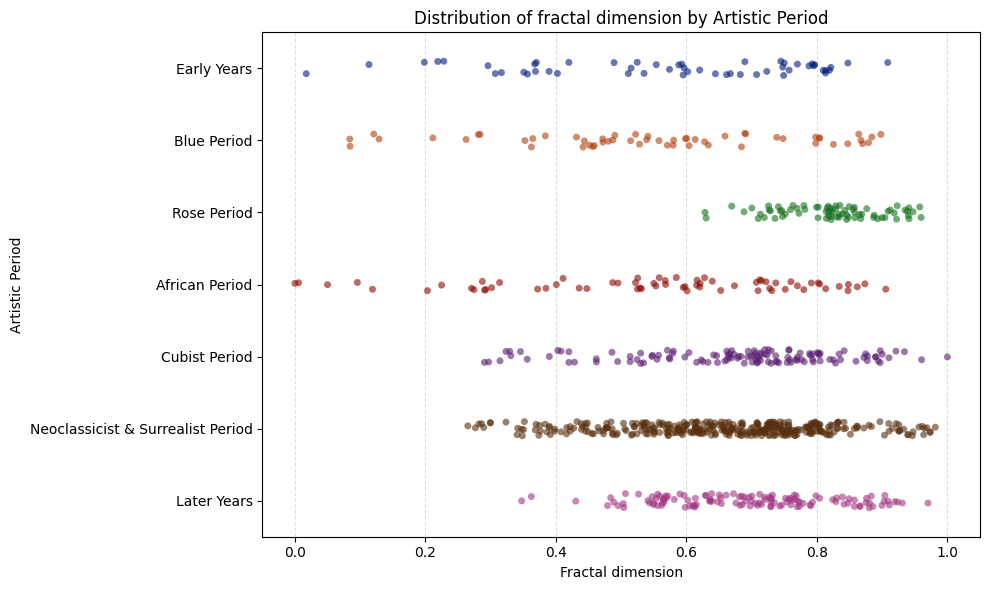

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT NORMALIZED\\BIFURCATION MAP\\fractal_dimension_by_artistic_period_h.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.


C:\Users\ricca\AppData\Local\Temp\ipykernel_21428\2809529657.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


Plot saved successfully to '.\PLOT NORMALIZED\BIFURCATION MAP\fractal_dimension_by_artistic_period_v.png'


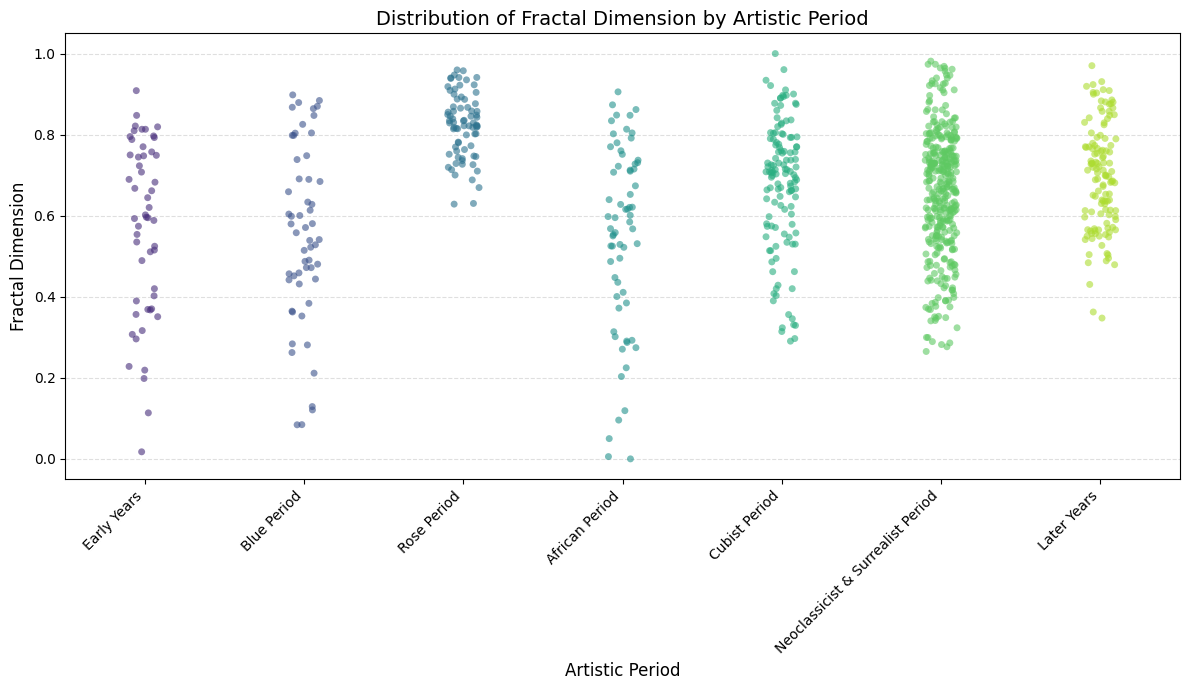

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import os for directory creation

# --- Data Loading ---
# Load the data
# Make sure the 'normalized_metrics_with_details_no_outlier.csv' file is in the specified directory
# or provide the full path to the file.
try:
    df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'normalized_metrics_with_details_no_outlier.csv' was not found.")
    print("Please ensure the file is in the specified directory or the path is correct.")
    exit() # Exit the script if the file is not found
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Define the desired order of artistic periods
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Convert the 'Period' column to a categorical type with the specified order
if 'Period' in df.columns:
    df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
else:
    print("Warning: 'Period' column not found in the DataFrame. Cannot order styles.")

# --- Plot Generation ---
plt.figure(figsize=(12, 7)) # Adjust figure size for better horizontal readability

# Create the stripplot
# By swapping x and y, and removing orient='h', the plot automatically rotates
sns.stripplot(
    data=df,
    x="Period",         # Artistic Period on the x-axis
    y="Fractal dimension", # Fractal dimension on the y-axis
    alpha=0.6,
    size=5,
    jitter=True,        # Add jitter to spread out overlapping points
    palette="viridis" # Changed palette to 'viridis' for a different visual
)

plt.xlabel("Artistic Period", fontsize=12)
plt.ylabel("Fractal Dimension", fontsize=12)
plt.title("Distribution of Fractal Dimension by Artistic Period", fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability if they overlap
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Grid along y-axis
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# --- Save Plot ---
# Ensure the output directory exists
output_dir = '.\\PLOT NORMALIZED\\BIFURCATION MAP\\'
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filename = os.path.join(output_dir, 'fractal_dimension_by_artistic_period_v.png')
plt.savefig(output_filename)
print(f"Plot saved successfully to '{output_filename}'")

plt.show() # Display the plot (optional, if you want to see it immediately)

C:\Users\ricca\AppData\Local\Temp\ipykernel_21428\3868125504.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


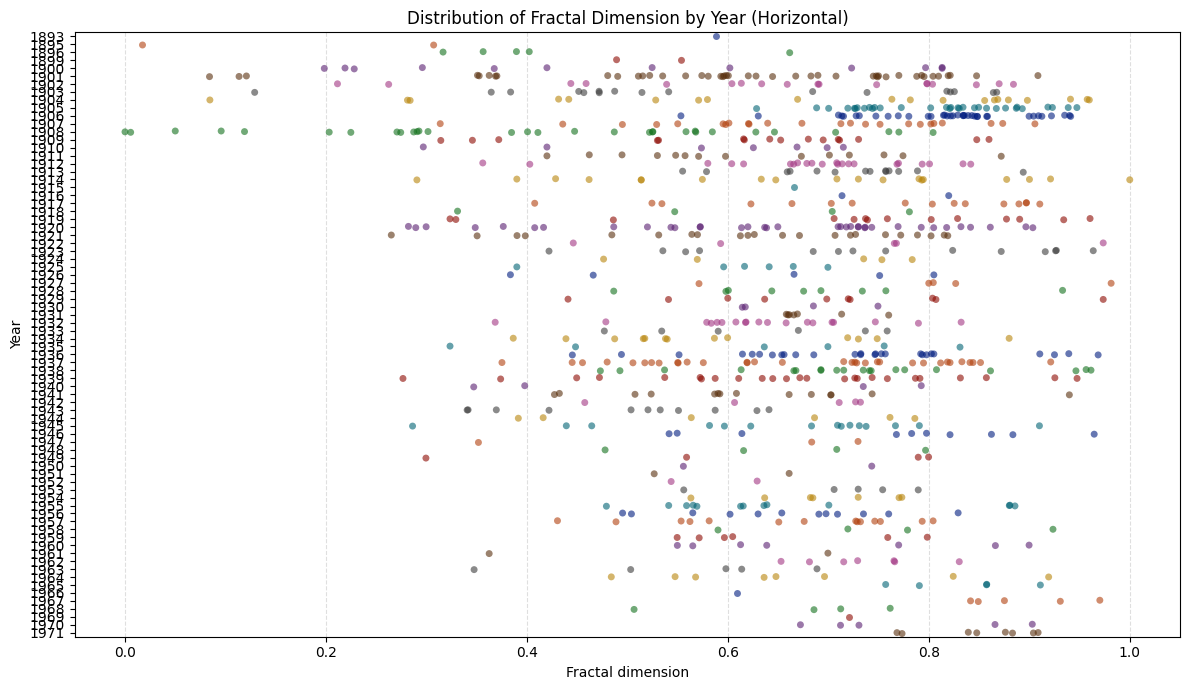

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(12, 7)) # Aumentiamo leggermente la dimensione per gli anni

sns.stripplot(
    data=df,
    y="Year", # 'Year' sull'asse Y per l'orientamento orizzontale
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h', # Orientamento orizzontale
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Year")
plt.title("Distribution of Fractal Dimension by Year (Horizontal)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('.\\PLOT NORMALIZED\\BIFURCATION MAP\\fractal_dimension_by_year_horizontal.png')
plt.show()

C:\Users\ricca\AppData\Local\Temp\ipykernel_21428\1175672973.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


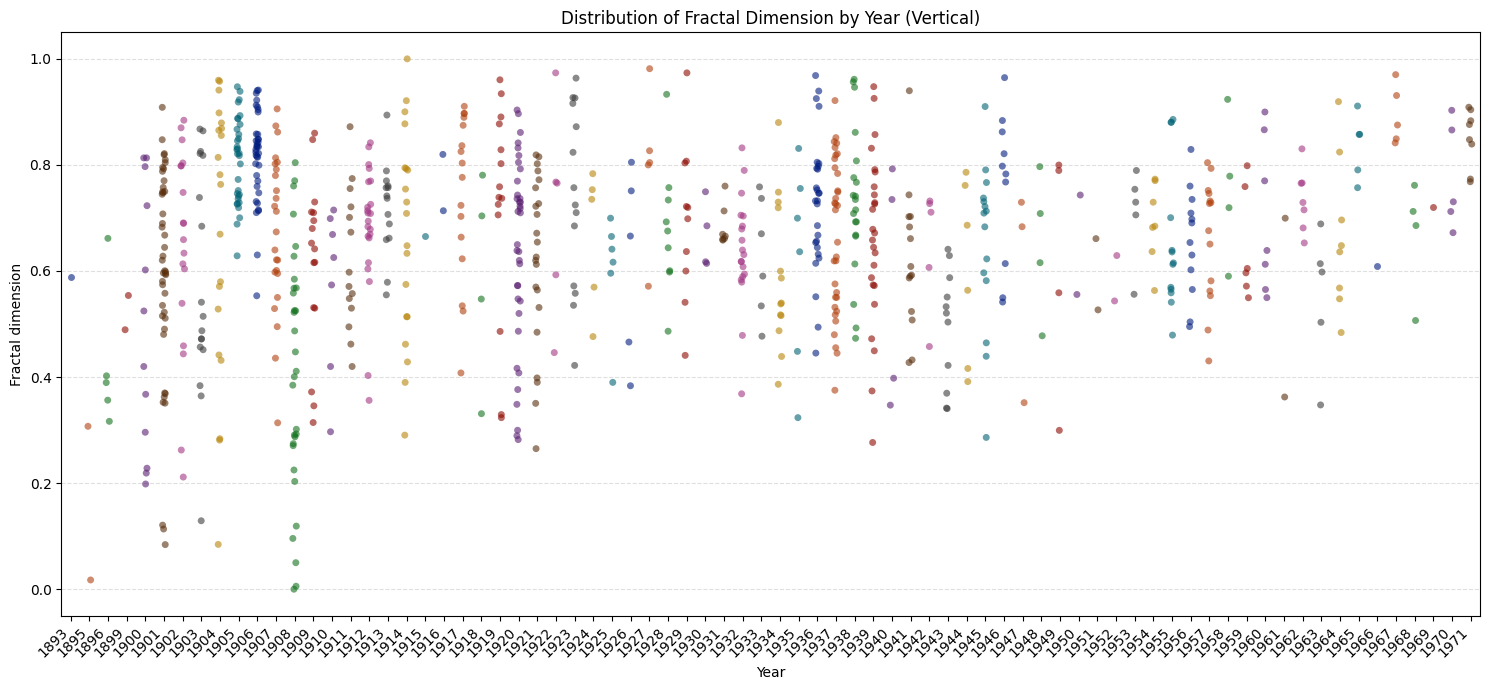

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\CSV NORMALIZED\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(15, 7)) # Aumentiamo la dimensione per accomodare gli anni sull'asse X

sns.stripplot(
    data=df,
    x="Year", # 'Year' sull'asse X per l'orientamento verticale
    y="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='v', # Orientamento verticale
    palette="dark"
)

plt.xlabel("Year")
plt.ylabel("Fractal dimension")
plt.title("Distribution of Fractal Dimension by Year (Vertical)")
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Griglia sull'asse Y
plt.xticks(rotation=45, ha='right') # Ruotiamo le etichette dell'asse X per leggibilità
plt.tight_layout()

plt.savefig('.\\PLOT NORMALIZED\\BIFURCATION MAP\\fractal_dimension_by_year_vertical.png')
plt.show()

# **STEP 15.1: BIFURCATION MAPS**

C:\Users\ricca\AppData\Local\Temp\ipykernel_26716\1295379577.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


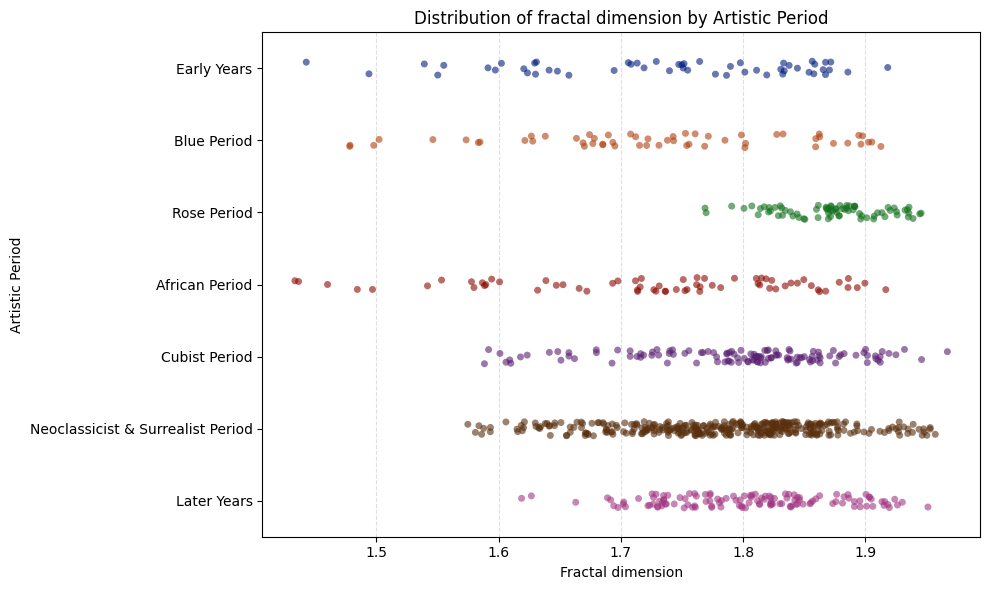

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT\\BIFURCATION MAP\\fractal_dimension_by_artistic_period_h.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

File 'metrics_with_details_no_outlier.csv' loaded successfully.


C:\Users\ricca\AppData\Local\Temp\ipykernel_26716\2494327362.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


Plot saved successfully to '.\PLOT\BIFURCATION MAP\fractal_dimension_by_artistic_period_v.png'


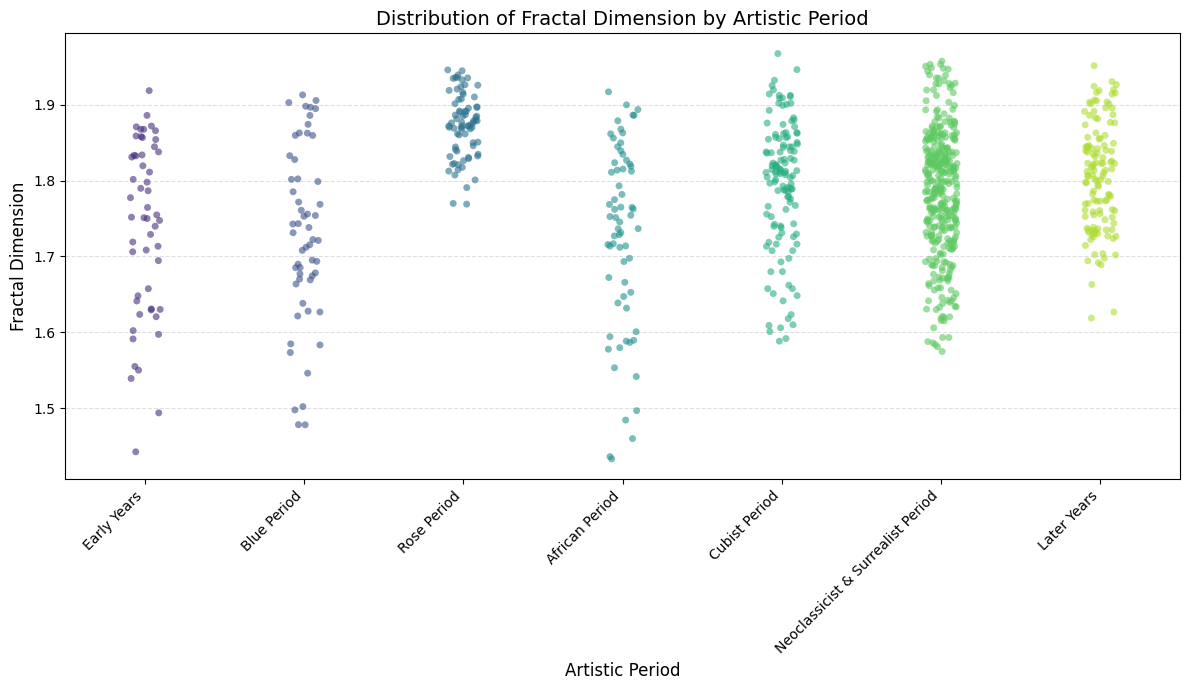

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import os for directory creation

# --- Data Loading ---
# Load the data
# Make sure the 'normalized_metrics_with_details_no_outlier.csv' file is in the specified directory
# or provide the full path to the file.
try:
    df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')
    print("File 'metrics_with_details_no_outlier.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'metrics_with_details_no_outlier.csv' was not found.")
    print("Please ensure the file is in the specified directory or the path is correct.")
    exit() # Exit the script if the file is not found
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# Define the desired order of artistic periods
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Convert the 'Period' column to a categorical type with the specified order
if 'Period' in df.columns:
    df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
else:
    print("Warning: 'Period' column not found in the DataFrame. Cannot order styles.")

# --- Plot Generation ---
plt.figure(figsize=(12, 7)) # Adjust figure size for better horizontal readability

# Create the stripplot
# By swapping x and y, and removing orient='h', the plot automatically rotates
sns.stripplot(
    data=df,
    x="Period",         # Artistic Period on the x-axis
    y="Fractal dimension", # Fractal dimension on the y-axis
    alpha=0.6,
    size=5,
    jitter=True,        # Add jitter to spread out overlapping points
    palette="viridis" # Changed palette to 'viridis' for a different visual
)

plt.xlabel("Artistic Period", fontsize=12)
plt.ylabel("Fractal Dimension", fontsize=12)
plt.title("Distribution of Fractal Dimension by Artistic Period", fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability if they overlap
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Grid along y-axis
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# --- Save Plot ---
# Ensure the output directory exists
output_dir = '.\\PLOT\\BIFURCATION MAP\\'
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

output_filename = os.path.join(output_dir, 'fractal_dimension_by_artistic_period_v.png')
plt.savefig(output_filename)
print(f"Plot saved successfully to '{output_filename}'")

plt.show() # Display the plot (optional, if you want to see it immediately)

C:\Users\ricca\AppData\Local\Temp\ipykernel_26716\370449550.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


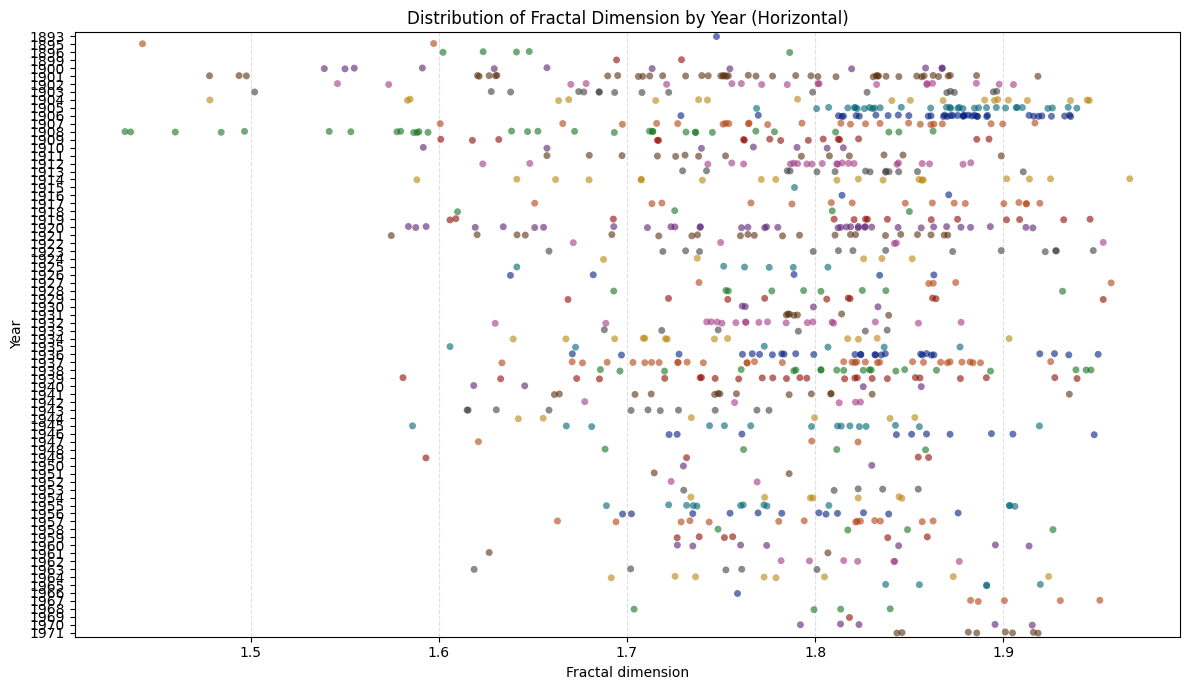

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(12, 7)) # Aumentiamo leggermente la dimensione per gli anni

sns.stripplot(
    data=df,
    y="Year", # 'Year' sull'asse Y per l'orientamento orizzontale
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h', # Orientamento orizzontale
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Year")
plt.title("Distribution of Fractal Dimension by Year (Horizontal)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('.\\PLOT\\BIFURCATION MAP\\fractal_dimension_by_year_horizontal.png')
plt.show()

C:\Users\ricca\AppData\Local\Temp\ipykernel_26716\1079267229.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


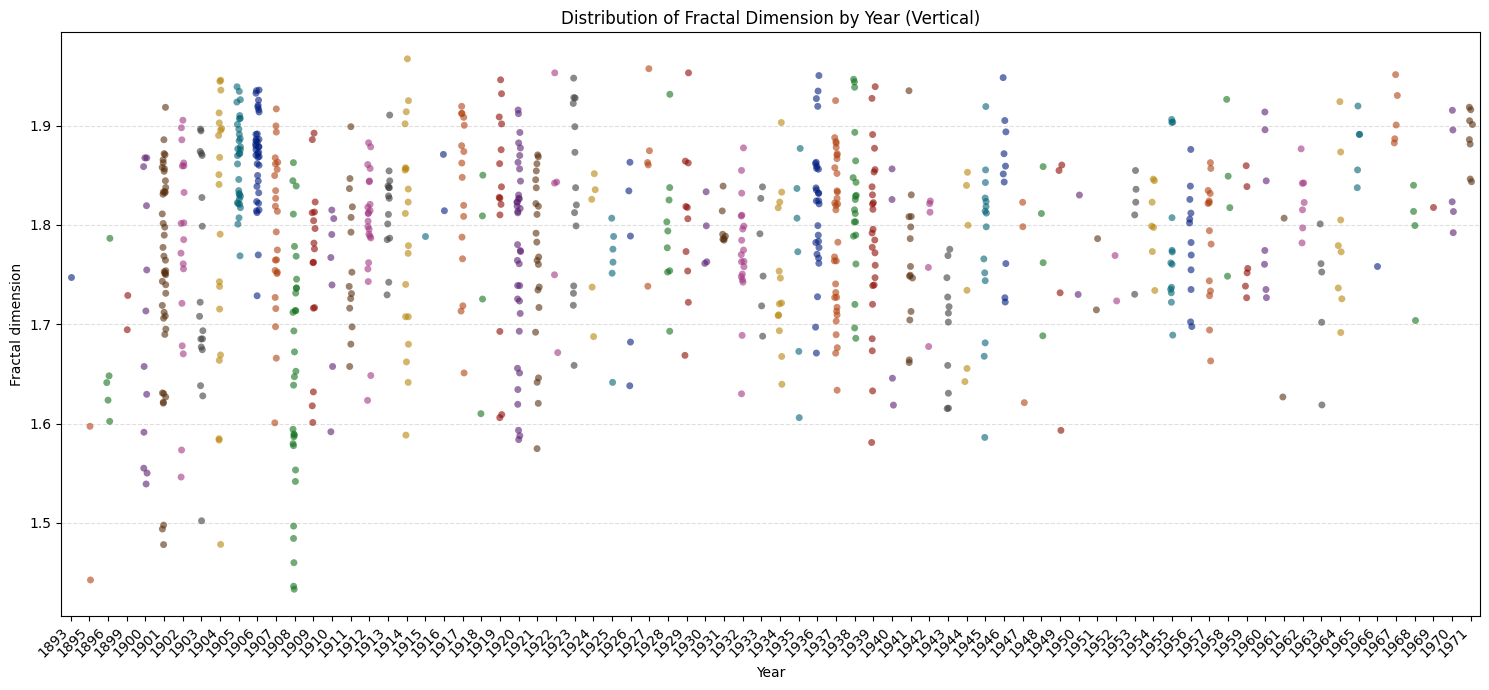

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\CSV\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(15, 7)) # Aumentiamo la dimensione per accomodare gli anni sull'asse X

sns.stripplot(
    data=df,
    x="Year", # 'Year' sull'asse X per l'orientamento verticale
    y="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='v', # Orientamento verticale
    palette="dark"
)

plt.xlabel("Year")
plt.ylabel("Fractal dimension")
plt.title("Distribution of Fractal Dimension by Year (Vertical)")
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Griglia sull'asse Y
plt.xticks(rotation=45, ha='right') # Ruotiamo le etichette dell'asse X per leggibilità
plt.tight_layout()

plt.savefig('.\\PLOT\\BIFURCATION MAP\\fractal_dimension_by_year_vertical.png')
plt.show()

# STEP 16: ATTRACTOR DETECTION
Attractor Detection approach to analyze the morphological and structural characteristics of images through four fundamental metrics: Fractal Dimension, Entropy, Birkhoff Measure, and Euclidean Norm.

In [ ]:
#QUESTO FILE SERVE PER IL CALCOLO

import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati dal CSV
df = pd.read_csv('D:\\Lavori\\ARTICOLI\\Bilotta_picasso 2025\\Codici\DATA\\normalized_metrics.csv')

# Filtra righe valide (esclude valori "Errore" o "N/A")
for col in ["Fractal dimension" , "Entropy" ,"Birkhoff measure","Euclidean distance"]:
    df = df[df[col].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

# Converti i valori in float
df["Frattale"] = df["Fractal dimension"].astype(float)
df["Entropia"] = df["Entropy"].astype(float)
df["Birkhoff"] = df["Birkhoff measure"].astype(float)
df["Distanza"] = df["Euclidean distance"].astype(float)

# Crea il vettore delle metriche
X = df[["Frattale", "Entropia", "Birkhoff", "Distanza"]].values

In [ ]:
# Calcolo della bandwidth adattiva
median_bw = estimate_bandwidth(X, quantile=0.6)
bandwidth = 0.39 * median_bw  # come da tua specifica

# Applica Mean-Shift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_

# Aggiungi i risultati al dataframe
df['Cluster'] = labels
n_clusters = len(np.unique(labels))
print(f"Numero di cluster trovati: {n_clusters}")

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10")
plt.title("Mean-Shift Clustering on Metrics")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [ ]:
for clust in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster'] == clust]
    print(f"\nCluster {clust} - {len(sub)} immagini")
    print(f"Frattale medio: {sub['Frattale'].mean():.4f}")
    print(f"Entropia media: {sub['Entropia'].mean():.4f}")
    print(f"Birkhoff media: {sub['Birkhoff'].mean():.4f}")
    print(f"Norma media: {sub['Distanza'].mean():.4f}")


In [ ]:
import pandas as pd

cluster_stats = []

for clust in sorted(df['Cluster'].unique()):
    sub = df[df['Cluster'] == clust]
    cluster_stats.append({
        'Cluster': clust,
        'Fractal Dimension': sub['Frattale'].mean(),
        'Entropy': sub['Entropia'].mean(),
        'Birkhoff Measure': sub['Birkhoff'].mean(),
        'Euclidean Distance': sub['Distanza'].mean()
    })

cluster_df = pd.DataFrame(cluster_stats)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['Fractal Dimension', 'Entropy', 'Birkhoff Measure', 'Euclidean Distance']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=cluster_df, x='Cluster', y=metric, palette='viridis')
    plt.title(f"Average {metric} for Cluster")
    plt.ylabel(f"{metric}")
    plt.xlabel("Cluster")
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Seleziona solo le metriche numeriche (senza 'Cluster')
metriche = cluster_df.columns.drop('Cluster')

# Applica Min-Max scaling alle metriche (colonna per colonna)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(cluster_df[metriche])

# Ricrea il dataframe normalizzato
cluster_df_scaled = pd.DataFrame(scaled_values, columns=metriche)
cluster_df_scaled['Cluster'] = cluster_df['Cluster']

# Melt per long-format compatibile con seaborn
cluster_melted = cluster_df_scaled.melt(id_vars='Cluster', var_name='Metrica', value_name='Valore')

# Plot istogramma
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_melted, x='Cluster', y='Valore', hue='Metrica', palette='tab10')
plt.title("Average value by metrics and cluster")
plt.ylabel("Value")
plt.xlabel("Cluster")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Metric2')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=0)
X_tsne = tsne.fit_transform(X)

df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

# Visualizza t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10', s=100)
plt.title("Space of metrics (t-SNE)")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [ ]:
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Solo le colonne numeriche
features = df[['Frattale', 'Entropia', 'Birkhoff', 'Distanza']].dropna()

# Salviamo l'indice per uso successivo
feature_index = features.index


In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(features)

In [ ]:
# Visualizzazione
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Cluster'], cmap='tab10', s=50, alpha=0.8)
plt.title('UMAP metrics projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordina per cluster
df_sorted = df.sort_values('Cluster')

# Plot tipo "biforcazione"
plt.figure(figsize=(10, 6))
for cl in sorted(df_sorted['Cluster'].unique()):
    cluster_data = df_sorted[df_sorted['Cluster'] == cl]
    x_vals = [cl] * len(cluster_data)
    y_vals = cluster_data['Frattale']
    plt.plot(x_vals, y_vals, ',k', alpha=0.6)

plt.title("Biforcazione della metrica Frattale rispetto al Cluster")
plt.xlabel("Cluster (Parametro di Controllo)")
plt.ylabel("Fractal Dimension")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# PicassoAnalisi

# **STEP 1: CONTEGGIO DELLE OPERE**
Dal conteggio è emerso un totale di 1170 opere

In [ ]:
import os

def count_images_in_subfolders(main_folder):
    """
    Counts the number of images (JPG, JPEG, PNG) in each subfolder
    and provides a total count.

    Args:
        main_folder (str): The path to the main folder containing subfolders.

    Returns:
        dict: A dictionary where keys are subfolder paths and values are
              the image counts. Also includes a 'Total' key for the grand total.
    """
    image_counts = {}
    total_images = 0
    image_extensions = ('.jpg', '.jpeg', '.png') # Tuple for efficient checking

    if not os.path.isdir(main_folder):
        print(f"Error: The folder '{main_folder}' does not exist.")
        return {}

    for root, dirs, files in os.walk(main_folder):
        # We only care about the immediate subfolders of main_folder
        # and not sub-subfolders for individual counts
        if root == main_folder:
            for d in dirs:
                subfolder_path = os.path.join(root, d)
                current_subfolder_count = 0
                for _, _, sub_files in os.walk(subfolder_path):
                    for file in sub_files:
                        if file.lower().endswith(image_extensions):
                            current_subfolder_count += 1
                    # Break after the first level of files in the subfolder
                    # to avoid counting files in deeper nested folders for individual subfolder counts
                    break 
                image_counts[subfolder_path] = current_subfolder_count
                total_images += current_subfolder_count
        else:
            # This part handles counting all images within the main_folder and its entire hierarchy
            # for the total sum, including files that might be directly in main_folder
            # or in deeper nested folders beyond the first level of subfolders.
            for file in files:
                if file.lower().endswith(image_extensions):
                    if root not in image_counts: # If files are directly in main_folder
                        image_counts[root] = 0
                    # This total_images counts all images in the entire hierarchy
                    # while the loop above counts only images directly in the first level subfolders
                    # We need to make sure we're not double counting or missing anything for the grand total.
                    pass # We'll calculate the total differently to avoid double counting from subfolder loop.

    # Recalculate total_images by summing up the individual subfolder counts
    # and add any images directly in the main_folder that weren't in a subfolder.
    # This ensures accuracy for the 'Total'.
    final_total_images = 0
    for folder_path, count in image_counts.items():
        final_total_images += count
    
    # Also count images directly in the main_folder itself
    for file in os.listdir(main_folder):
        if os.path.isfile(os.path.join(main_folder, file)) and file.lower().endswith(image_extensions):
            final_total_images += 1

    image_counts['Total'] = final_total_images
    return image_counts

count_images_in_subfolders(".\\pablo-picasso")

In [ ]:
import json
import os

def count_json_elements(file_path):
    """
    Conta il numero di elementi in un file JSON.
    Il conteggio varia a seconda della struttura del JSON:
    - Se è una lista (array JSON), conta il numero di elementi nella lista.
    - Se è un dizionario (oggetto JSON), conta il numero di coppie chiave-valore.
    - Se è un tipo di dato semplice (stringa, numero, booleano, null), conta 1.

    Args:
        file_path (str): Il percorso del file JSON.

    Returns:
        int or None: Il numero di elementi, o None se c'è un errore.
    """
    if not os.path.exists(file_path):
        print(f"Errore: Il file '{file_path}' non esiste.")
        return None
    if not os.path.isfile(file_path):
        print(f"Errore: '{file_path}' non è un file valido.")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if isinstance(data, list):
            print(f"Il file JSON contiene una lista con {len(data)} elementi.")
            return len(data)
        elif isinstance(data, dict):
            print(f"Il file JSON contiene un dizionario con {len(data)} coppie chiave-valore.")
            return len(data)
        else:
            print(f"Il file JSON contiene un singolo elemento di tipo: {type(data).__name__}.")
            return 1 # Se è un tipo primitivo (stringa, numero, booleano, null)

    except json.JSONDecodeError as e:
        print(f"Errore nella decodifica del JSON dal file '{file_path}': {e}")
        return None
    except Exception as e:
        print(f"Si è verificato un errore inatteso: {e}")
        return None


element_count = count_json_elements(".\\pablo-picasso.json")

if element_count is not None:
    print(f"Conteggio finale: {element_count}")

# **STEP 2: NUMERA OPERE "UNTITLED" E ORGANIZZA PER PERIODO**
1. Dall'analisi del file .json sono emerse molte opere con il nome "Untitled", di conseguenza vanno numerate per non creare sovrapposizioni
2. Alcune opere nel file .json non hanno la voce "period", di conseguenza vanno eliminate
3. Alcune opere hanno lo stesso nome, quindi vanno numerate

Numerazione Untitled

In [ ]:
import json
import os

def rename_untitled_works(file_path, key_to_check='title'):
    """
    Scorre un file JSON e rinomina le opere che hanno il titolo "Untitled".
    Le rinomina in "Untitled_1", "Untitled_2", ecc., basandosi
    sull'ordine in cui appaiono nel file.

    Args:
        file_path (str): Il percorso del file JSON.
        key_to_check (str): La chiave del dizionario che contiene il titolo dell'opera.
                            Il valore predefinito è 'title'.

    Returns:
        bool: True se il file è stato modificato e salvato, False altrimenti.
    """
    if not os.path.exists(file_path):
        print(f"Errore: Il file '{file_path}' non esiste.")
        return False
    if not os.path.isfile(file_path):
        print(f"Errore: '{file_path}' non è un file valido.")
        return False

    try:
        # Carica il contenuto JSON
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Assicurati che il JSON sia una lista di dizionari (come spesso accade per collezioni di opere)
        if not isinstance(data, list):
            print(f"Avviso: Il file JSON non contiene una lista di oggetti. Nessuna modifica applicata.")
            return False

        untitled_count = 0
        modified = False

        # Itera su ogni elemento (opera) nella lista
        for item in data:
            if isinstance(item, dict) and key_to_check in item:
                if item[key_to_check] == "Untitled":
                    untitled_count += 1
                    new_title = f"Untitled_{untitled_count}"
                    print(f"Rinomino '{item[key_to_check]}' in '{new_title}'")
                    item[key_to_check] = new_title
                    modified = True
        
        if modified:
            # Salva i dati modificati nel file JSON (sovrascrivendo l'originale)
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, indent=4, ensure_ascii=False)
            print(f"\nFile '{file_path}' modificato e salvato con successo.")
            return True
        else:
            print(f"\nNessuna opera con titolo '{key_to_check}: \"Untitled\"' trovata nel file.")
            return False

    except json.JSONDecodeError as e:
        print(f"Errore nella decodifica del JSON dal file '{file_path}': {e}")
        return False
    except Exception as e:
        print(f"Si è verificato un errore inatteso: {e}")
        return False


json_file_path = '.\\pablo-picasso.json' # Assicurati che 'opere.json' sia nella stessa directory dello script
rename_untitled_works(json_file_path)


Organizza per periodo ed eliminazione delle opere senza "period"

In [ ]:
import json
import os
import shutil

# --- CONFIGURAZIONE ---
# Percorso del tuo file JSON. Assicurati che sia corretto!
JSON_FILE_PATH = ".\\pablo-picasso.json"

# Percorso della cartella dove si trovano TUTTI i tuoi file d'arte originali.
# Esempio Windows: r'C:\Users\TuoUtente\Documents\LeMieOpereOriginali'
# Esempio macOS/Linux: '/home/TuoUtente/Documenti/LeMieOpereOriginali'
# *** MODIFICA QUESTO PERCORSO CON QUELLO REALE DEI TUOI FILE! ***
SOURCE_ART_FOLDER = ".\\pablo-picasso" # <--- CAMBIA QUESTO!

# Nome della cartella dove verranno organizzate le opere.
# Verrà creata nella stessa directory dello script.
DESTINATION_ORGANIZED_FOLDER = ".\\pablo-picasso-periodo" 

# Estensioni dei file che lo script cercherà.
# Aggiungi o rimuovi estensioni in base ai tuoi file.
ALLOWED_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
# --- FINE CONFIGURAZIONE ---

def organize_art_files():
    if not os.path.exists(JSON_FILE_PATH):
        print(f"Errore: Il file JSON '{JSON_FILE_PATH}' non è stato trovato.")
        print("Assicurati che il percorso e il nome del file JSON siano corretti.")
        return

    if not os.path.isdir(SOURCE_ART_FOLDER):
        print(f"Errore: La cartella sorgente '{SOURCE_ART_FOLDER}' non esiste o non è una directory valida.")
        print("Assicurati che il percorso della cartella con i tuoi file d'arte originali sia corretto.")
        return

    # Crea la cartella di destinazione principale se non esiste
    if not os.path.exists(DESTINATION_ORGANIZED_FOLDER):
        os.makedirs(DESTINATION_ORGANIZED_FOLDER)
        print(f"Creata la cartella di destinazione: {DESTINATION_ORGANIZED_FOLDER}")

    try:
        with open(JSON_FILE_PATH, 'r', encoding='utf-8') as f:
            art_data = json.load(f)
    except json.JSONDecodeError:
        print(f"Errore: Il file '{JSON_FILE_PATH}' non è un JSON valido.")
        return
    except Exception as e:
        print(f"Errore durante la lettura del file JSON: {e}")
        return

    processed_count = 0
    skipped_count = 0

    print("\nInizio organizzazione dei file...")

    for art_piece in art_data:
        content_id = art_piece.get('contentId')
        completition_year = art_piece.get('completitionYear')
        style = art_piece.get('period')
        title = art_piece.get("title")

        if not all([content_id, completition_year, style]):
            print(f"Avviso: Elemento JSON incompleto, saltato: {art_piece.get('title', 'N/D')}")
            skipped_count += 1
            continue

        # Modifica qui: Non creare più la cartella dell'anno
        # year_folder = os.path.join(DESTINATION_ORGANIZED_FOLDER, str(completition_year))
        
        style_folder = os.path.join(DESTINATION_ORGANIZED_FOLDER, style)

        # Rimosso: Creazione della cartella dell'anno
        # if not os.path.exists(year_folder):
        # os.makedirs(year_folder)

        # Crea la sottocartella dello stile se non esiste
        if not os.path.exists(style_folder):
            os.makedirs(style_folder)

        # Cerca il file originale con il contentId e una delle estensioni permesse
        found_source_file = None
        original_extension = None
        for ext in ALLOWED_EXTENSIONS:
            # Assumiamo che i file sorgente siano organizzati per anno nella cartella SOURCE_ART_FOLDER
            potential_source_path = os.path.join(f"{SOURCE_ART_FOLDER}\\{completition_year}", f"{content_id}{ext}")
            if os.path.exists(potential_source_path):
                found_source_file = potential_source_path
                original_extension = ext
                break

        if found_source_file:
            # Nome del file di destinazione sarà lo 'title' con l'estensione originale
            destination_file_name = f"{title}{original_extension}"
            destination_path = os.path.join(style_folder, destination_file_name)

            # Se il file esiste già nella destinazione, aggiunge un suffisso per evitare sovrascritture
            counter = 1
            original_destination_path = destination_path
            while os.path.exists(destination_path):
                name, ext = os.path.splitext(original_destination_path)
                destination_path = f"{name}_{counter}{ext}"
                counter += 1

            try:
                # Copia il file (non lo sposta, per sicurezza)
                shutil.copy2(found_source_file, destination_path)
                print(f"Copiato: '{os.path.basename(found_source_file)}' in '{destination_path}'")
                processed_count += 1
            except Exception as e:
                print(f"Errore durante la copia del file '{found_source_file}': {e}")
                skipped_count += 1
        else:
            print(f"Avviso: File sorgente non trovato per 'contentId': '{content_id}' (cercato in '{SOURCE_ART_FOLDER}\\{completition_year}' con estensioni {ALLOWED_EXTENSIONS})")
            skipped_count += 1

    print("\n--- Riassunto ---")
    print(f"File processati con successo: {processed_count}")
    print(f"File saltati (non trovati o dati incompleti): {skipped_count}")
    print(f"Organizzazione completata nella cartella '{DESTINATION_ORGANIZED_FOLDER}'.")

if __name__ == "__main__":
    organize_art_files()

Numerazione opere con lo stesso nome

In [ ]:
import json
from collections import defaultdict

def numerate_duplicate_titles_and_save_json(input_json_file_path: str, output_json_file_path: str):
    """
    Legge un file JSON (che può essere un dizionario o una lista di dizionari),
    identifica i valori duplicati per la chiave 'title' (ignorando maiuscole/minuscole)
    e li numera progressivamente, lasciando la prima occorrenza senza suffisso.
    Salva il risultato in un nuovo file JSON.

    Args:
        input_json_file_path (str): Il percorso del file JSON da leggere.
        output_json_file_path (str): Il percorso dove salvare il nuovo file JSON.

    Returns:
        bool: True se il processo è completato con successo, False altrimenti.
    """
    try:
        with open(input_json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Errore: Il file di input '{input_json_file_path}' non è stato trovato.")
        return False
    except json.JSONDecodeError:
        print(f"Errore: Impossibile decodificare il file JSON '{input_json_file_path}'. Controlla il formato.")
        return False
    except Exception as e:
        print(f"Si è verificato un errore inaspettato durante la lettura del file: {e}")
        return False

    # Usa defaultdict per contare le occorrenze dei titoli NORMALIZZATI (tutto minuscolo)
    title_counters = defaultdict(lambda: iter(range(1, 999999)))
    
    processed_data = None 

    if isinstance(data, list): 
        processed_data = []
        for item_dict in data: 
            if isinstance(item_dict, dict) and "title" in item_dict:
                original_title = item_dict["title"]
                # Normalizza il titolo a minuscolo per il conteggio
                normalized_title = original_title.lower()
                
                current_count = next(title_counters[normalized_title])
                
                if current_count == 1:
                    new_title = original_title # Mantieni il casing originale per la prima occorrenza
                else:
                    # Aggiungi il suffisso al titolo originale (non alla versione normalizzata)
                    new_title = f"{original_title}_{current_count - 1}"
                
                modified_item_dict = item_dict.copy()
                modified_item_dict["title"] = new_title
                processed_data.append(modified_item_dict)
            else:
                processed_data.append(item_dict)
    elif isinstance(data, dict):
        processed_data = {}
        for key, value_dict in data.items():
            if isinstance(value_dict, dict) and "title" in value_dict:
                original_title = value_dict["title"]
                # Normalizza il titolo a minuscolo per il conteggio
                normalized_title = original_title.lower()
                
                current_count = next(title_counters[normalized_title])
                
                if current_count == 1:
                    new_title = original_title # Mantieni il casing originale per la prima occorrenza
                else:
                    # Aggiungi il suffisso al titolo originale (non alla versione normalizzata)
                    new_title = f"{original_title}_{current_count - 1}"
                
                modified_value_dict = value_dict.copy()
                modified_value_dict["title"] = new_title
                processed_data[key] = modified_value_dict
            else:
                processed_data[key] = value_dict
    else:
        print(f"Errore: Il formato del JSON non è supportato (né dizionario né lista): {type(data)}")
        return False
            
    try:
        with open(output_json_file_path, 'w', encoding='utf-8') as f:
            json.dump(processed_data, f, indent=2, ensure_ascii=False)
        print(f"File JSON processato salvato con successo in '{output_json_file_path}'.")
        return True
    except Exception as e:
        print(f"Errore durante il salvataggio del file JSON: {e}")
        return False
    

input_json_file_path = ".\\pablo-picasso.json"
output_json_file_path = ".\\pablo-picasso.json"

numerate_duplicate_titles_and_save_json(input_json_file_path, output_json_file_path)

# **STEP 3: CONTROLLO DEL NUMERO DI OPERE PER PERIODO**
TOTALE: 1106
1. African Period: 75
2. Blue Period: 111
3. ubist Period: 154
4. Early Years: 79
5. Later Years: 161
6. Neoclassicist & Surrealist Period: 429
7. Rose Period: 96

In [ ]:
import os

def count_images_in_subfolders(main_folder):
    """
    Counts the number of images (JPG, JPEG, PNG) in each subfolder
    and provides a total count.

    Args:
        main_folder (str): The path to the main folder containing subfolders.

    Returns:
        dict: A dictionary where keys are subfolder paths and values are
              the image counts. Also includes a 'Total' key for the grand total.
    """
    image_counts = {}
    total_images = 0
    image_extensions = ('.jpg', '.jpeg', '.png') # Tuple for efficient checking

    if not os.path.isdir(main_folder):
        print(f"Error: The folder '{main_folder}' does not exist.")
        return {}

    for root, dirs, files in os.walk(main_folder):
        # We only care about the immediate subfolders of main_folder
        # and not sub-subfolders for individual counts
        if root == main_folder:
            for d in dirs:
                subfolder_path = os.path.join(root, d)
                current_subfolder_count = 0
                for _, _, sub_files in os.walk(subfolder_path):
                    for file in sub_files:
                        if file.lower().endswith(image_extensions):
                            current_subfolder_count += 1
                    # Break after the first level of files in the subfolder
                    # to avoid counting files in deeper nested folders for individual subfolder counts
                    break 
                image_counts[subfolder_path] = current_subfolder_count
                total_images += current_subfolder_count
        else:
            # This part handles counting all images within the main_folder and its entire hierarchy
            # for the total sum, including files that might be directly in main_folder
            # or in deeper nested folders beyond the first level of subfolders.
            for file in files:
                if file.lower().endswith(image_extensions):
                    if root not in image_counts: # If files are directly in main_folder
                        image_counts[root] = 0
                    # This total_images counts all images in the entire hierarchy
                    # while the loop above counts only images directly in the first level subfolders
                    # We need to make sure we're not double counting or missing anything for the grand total.
                    pass # We'll calculate the total differently to avoid double counting from subfolder loop.

    # Recalculate total_images by summing up the individual subfolder counts
    # and add any images directly in the main_folder that weren't in a subfolder.
    # This ensures accuracy for the 'Total'.
    final_total_images = 0
    for folder_path, count in image_counts.items():
        final_total_images += count
    
    # Also count images directly in the main_folder itself
    for file in os.listdir(main_folder):
        if os.path.isfile(os.path.join(main_folder, file)) and file.lower().endswith(image_extensions):
            final_total_images += 1

    image_counts['Total'] = final_total_images
    return image_counts

count_images_in_subfolders(".\\pablo-picasso-periodo")

# **STEP 4: CALCOLO DEI VALORI DELLE METRICHE**


In [ ]:
import json
import os
import requests
from urllib.parse import urlparse
from PIL import Image
import numpy as np
from scipy.stats import entropy
import csv
from skimage.measure import find_contours
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes

# Funzione per calcolare la Fractal dimension con il metodo box-counting (senza modifiche)
def box_counting_fractal_dimension(image_array, threshold=0.5):
    """
    Calcola la Fractal dimension di un'immagine binaria usando il metodo box-counting.
    """
    if image_array is None:
        return None

    if image_array.dtype == np.uint8:
        binary_image = image_array > (threshold * 255)
    else:
        binary_image = image_array > threshold

    if np.all(binary_image) or np.all(~binary_image):
        return 0.0

    height, width = binary_image.shape
    pixels = []
    boxes = []

    max_dim = max(height, width)
    initial_box_size = 2**int(np.log2(max_dim / 2))
    if initial_box_size == 0: initial_box_size = 1

    for box_size in [2**i for i in range(1, int(np.log2(max_dim)) + 1)]:
        if box_size == 0: continue
        count = 0
        for r in range(0, height, box_size):
            for c in range(0, width, box_size):
                if np.any(binary_image[r:r+box_size, c:c+box_size]):
                    count += 1
        if count > 0:
            pixels.append(np.log(count))
            boxes.append(np.log(1.0 / box_size))

    if len(pixels) < 2:
        return None

    try:
        coefficients = np.polyfit(boxes, pixels, 1)
        fractal_dimension = coefficients[0]
        return fractal_dimension
    except Exception as e:
        return None

# Funzione per calcolare l'Entropy dell'immagine (senza modifiche)
def calculate_image_entropy(image_array):
    """
    Calcola l'Entropy di Shannon di un'immagine in scala di grigi.
    """
    if image_array is None:
        return None

    hist, _ = np.histogram(image_array.flatten(), bins=256, range=[0, 256])
    probabilities = hist / hist.sum()
    probabilities = probabilities[probabilities > 0]

    return entropy(probabilities, base=2)

# --- NUOVA FUNZIONE PER LA MISURA DI BIRKHOFF ---
def calculate_birkhoff_measure(image_array):
    """
    Calcola la misura di Birkhoff basata sul rapporto tra perimetro e area.
    """
    if image_array is None or np.all(image_array == image_array[0, 0]):
        return None

    try:
        threshold = threshold_otsu(image_array)
        binary_image = image_array > threshold
        contours = find_contours(binary_image, 0.5, fully_connected='high')

        total_perimeter = 0
        total_area = np.sum(binary_fill_holes(binary_image))

        for contour in contours:
            total_perimeter += len(contour)

        if total_area == 0:
            return 0.0

        birkhoff_measure = total_perimeter / np.sqrt(total_area)
        return birkhoff_measure

    except Exception as e:
        print(f"Errore nel calcolo della misura di Birkhoff: {e}")
        return None

# --- NUOVA FUNZIONE PER LA NORMA EUCLIDEA ---
def calculate_euclidean_norm(image_array):
    """
    Calcola la norma euclidea (Frobenius) di un'immagine.
    L'immagine viene prima scalata tra 0 e 1.
    """
    if image_array is None:
        return None

    # Assicurati che l'array sia di tipo float per la normalizzazione
    # e per evitare overflow in caso di elevamento al quadrato
    if image_array.dtype != np.float64:
        image_array = image_array.astype(np.float64)

    # Scala i valori dei pixel tra 0 e 1 (assumendo scala 0-255)
    # Controlla se il range massimo è 0 per evitare divisione per zero
    max_val = np.max(image_array)
    if max_val == 0:
        scaled_image_array = image_array # Già tutti zero, la norma sarà 0
    else:
        scaled_image_array = image_array / max_val # Scalatura da 0-max_val a 0-1

    try:
        # Calcola la norma di Frobenius della matrice
        norm = np.linalg.norm(scaled_image_array, 'fro') # 'fro' specifica la norma di Frobenius
        return norm
    except Exception as e:
        print(f"Errore nel calcolo della norma euclidea: {e}")
        return None

def process_images_and_calculate_metrics(base_directory, output_csv):
    """
    Scorre tutte le immagini nelle sottocartelle, calcola le metriche,
    e salva i risultati in un file CSV.
    """
    if not os.path.exists(base_directory):
        print(f"Errore: La directory '{base_directory}' non esiste.")
        return

    results = []
    # Intestazione della tabella CSV - AGGIUNTA MISURA DI BIRKHOFF E NORMA EUCLIDEA
    results.append(["Period", "Name of the painting", "Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"])

    print(f"Scansione della directory: {base_directory}")
    i = 0
    for root, _, files in os.walk(base_directory):
        for file in files:
            i+=1
            print(i)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_path = os.path.join(root, file)
                style_name = os.path.basename(root)
                title_name = os.path.splitext(file)[0]
                fractal_dim = "N/A"
                image_entropy = "N/A"
                birkhoff_measure = "N/A"
                euclidean_norm = "N/A" # Inizializza la norma euclidea

                try:
                    img = Image.open(image_path).convert('L')
                    img_array = np.array(img)

                    calculated_fractal_dim = box_counting_fractal_dimension(img_array)
                    if calculated_fractal_dim is not None:
                        fractal_dim = f"{calculated_fractal_dim:.4f}"

                    calculated_image_entropy = calculate_image_entropy(img_array)
                    if calculated_image_entropy is not None:
                        image_entropy = f"{calculated_image_entropy:.4f}"

                    # Calcola la misura di Birkhoff
                    calculated_birkhoff_measure = calculate_birkhoff_measure(img_array)
                    if calculated_birkhoff_measure is not None:
                        birkhoff_measure = f"{calculated_birkhoff_measure:.4f}"

                    # Calcola la norma euclidea
                    calculated_euclidean_norm = calculate_euclidean_norm(img_array)
                    if calculated_euclidean_norm is not None:
                        euclidean_norm = f"{calculated_euclidean_norm:.4f}"


                    print(f"Analizzata: {image_path} -> Frattale: {fractal_dim}, Entropy: {image_entropy}, Birkhoff: {birkhoff_measure}, Norma Euclidea: {euclidean_norm}")
                    results.append([style_name, title_name, fractal_dim, image_entropy, birkhoff_measure, euclidean_norm])

                except Exception as e:
                    print(f"Errore durante l'elaborazione dell'immagine {image_path}: {e}")
                    results.append([style_name, title_name, "Errore", "Errore", "Errore", "Errore"]) # Aggiungi "Errore" anche per la norma euclidea

    try:
        with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerows(results)
        print(f"\nCalcolo completato. I risultati sono stati salvati in: {os.path.abspath(output_csv)}")
    except Exception as e:
        print(f"Errore durante il salvataggio del file CSV: {e}")


# Cambiato il nome del CSV di output per riflettere le nuove metriche
process_images_and_calculate_metrics(
    base_directory=".\\pablo-picasso-periodo",
    output_csv=".\\metrics.csv"
)

# **STEP 5: AGGIUNTA DELL'ANNO E DEL PERIODO**
Per le analisi future nasce anche la necessità di aggiungere l'anno e il periodo
Bisogna eliminare le righe che hanno valori nulli

In [ ]:
import pandas as pd
import json
import os
import re
import unicodedata

def clean_name(name):
    """
    Pulisce una stringa rimuovendo i caratteri speciali, convertendo in minuscolo,
    rimuovendo accenti e uniformando gli spazi.
    """
    if not isinstance(name, str):
        return ""

    name = name.lower()
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    name = re.sub(r'[^a-z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()

    return name

def add_painting_details_to_csv(csv_filepath, json_filepath, name_column='Name of the painting',
                                 year_column_name='Year', period_column_name='Period', style_column_name='Style'):
    """
    Reads a CSV, finds the completion year, period, and style for each painting from a JSON file,
    and adds them as new columns to the CSV.
    Ensures the 'Name of the painting' column is treated as strings, cleans names
    for matching, and prints a message when a match is found.

    Handles European decimal format (comma for decimal, point for thousands).

    Args:
        csv_filepath (str): The path to your input CSV file.
        json_filepath (str): The path to your input JSON file.
        name_column (str): The name of the column in your CSV containing painting names.
                            Defaults to 'Name of the painting'.
        year_column_name (str): The name for the new column in your CSV that will
                                store the completion year. Defaults to 'Year'.
        period_column_name (str): The name for the new column in your CSV that will
                                  store the period. Defaults to 'Period'.
        style_column_name (str): The name for the new column in your CSV that will
                                 store the style. Defaults to 'Style'.
    """
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return

    if not os.path.exists(json_filepath):
        print(f"Error: JSON file not found at '{json_filepath}'")
        return

    try:
        # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
        df = pd.read_csv(csv_filepath, decimal=',')
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if name_column not in df.columns:
        print(f"Error: Column '{name_column}' not found in the CSV file.")
        return

    # Applica la pulizia al nome della colonna nel CSV per la corrispondenza
    df['cleaned_name_for_match'] = df[name_column].apply(clean_name)

    try:
        with open(json_filepath, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON file: {e}")
        return
    except Exception as e:
        print(f"Error reading JSON file: {e}")
        return

    painting_details_map = {}
    if isinstance(json_data, list):
        for item in json_data:
            if 'title' in item and 'completitionYear' in item:
                cleaned_json_name = clean_name(item['title'])
                painting_details_map[cleaned_json_name] = {
                    'completitionYear': item['completitionYear'],
                    'period': item.get('period'),
                    'style': item.get('style') # Added style
                }
    elif isinstance(json_data, dict):
        for name, details in json_data.items():
            if 'completitionYear' in details:
                cleaned_json_name = clean_name(name)
                painting_details_map[cleaned_json_name] = {
                    'completitionYear': details['completitionYear'],
                    'period': details.get('period'),
                    'style': details.get('style') # Added style
                }
    else:
        print("Warning: Unsupported JSON structure. Expected a list of dictionaries or a dictionary of dictionaries.")
        return

    # Initialize new columns with None (which pandas might convert to NaN for numerical types)
    df[year_column_name] = None
    df[period_column_name] = None
    df[style_column_name] = None 

    for index, row in df.iterrows():
        original_painting_name_csv = row[name_column]
        cleaned_painting_name_csv = row['cleaned_name_for_match']

        if not cleaned_painting_name_csv:
            print(f"Warning: Skipping row {index} due to empty or unprocessable painting name (original: '{original_painting_name_csv}').")
            continue
        
        if cleaned_painting_name_csv in painting_details_map:
            details = painting_details_map[cleaned_painting_name_csv]
            df.at[index, year_column_name] = details['completitionYear']
            df.at[index, period_column_name] = details['period']
            df.at[index, style_column_name] = details['style'] 
            print(f"Found '{original_painting_name_csv}' (cleaned: '{cleaned_painting_name_csv}') in JSON. Completition Year: {details['completitionYear']}, Period: {details['period']}, Style: {details['style']}")
        else:
            print(f"Warning: Details not found for '{original_painting_name_csv}' (cleaned: '{cleaned_painting_name_csv}') in JSON.")
    
    # Rimuove la colonna temporanea usata per la pulizia
    df = df.drop(columns=['cleaned_name_for_match'])

    # --- INIZIO: LOGICA AGGIORNATA PER DROPNA ---
    initial_rows = len(df)
    
    df.dropna(subset=[year_column_name, period_column_name, style_column_name], inplace=True)

    rows_dropped = initial_rows - len(df)
    if rows_dropped > 0:
        print(f"\nDropped {rows_dropped} rows containing empty cells in '{year_column_name}', '{period_column_name}', or '{style_column_name}'.")
    else:
        print("\nNo rows with empty cells in specified columns were found and dropped.")
    # --- FINE: LOGICA AGGIORNATA PER DROPNA ---


    # --- INIZIO: LOGICA CORRETTA E PIÙ ROBUSTA PER RIORDINARE LE COLONNE ---
    print("\nColumns before reordering:", df.columns.tolist()) 

    current_columns = df.columns.tolist()
    
    columns_to_reposition = [style_column_name, year_column_name, period_column_name]
    
    for col in columns_to_reposition:
        if col in current_columns:
            current_columns.remove(col)
            
    insert_index = -1 
    if name_column in current_columns:
        insert_index = current_columns.index(name_column) + 1
    
    final_column_order = []
    
    if insert_index != -1:
        final_column_order.extend(current_columns[:insert_index])
        final_column_order.extend(columns_to_reposition)
        final_column_order.extend(current_columns[insert_index:])
    else:
        final_column_order.extend(current_columns)
        final_column_order.extend(columns_to_reposition)

    final_column_order = list(dict.fromkeys(final_column_order))

    df = df[final_column_order]

    print("Columns after reordering:", df.columns.tolist()) 
    # --- FINE: LOGICA CORRETTA E PIÙ ROBUSTA PER RIORDINARE LE COLONNE ---

    output_csv_filepath = csv_filepath.replace('.csv', '_with_details.csv') 
    try:
        # MODIFICA QUI: Specifica decimal=',' per la scrittura del CSV
        df.to_csv(output_csv_filepath, index=False, decimal=',')
        print(f"\nSuccessfully updated CSV saved to '{output_csv_filepath}'")
    except Exception as e:
        print(f"Error saving updated CSV: {e}")

# Esempio di utilizzo:
your_csv_path = '.\\metrics.csv'
your_json_path = '.\\pablo-picasso.json'

add_painting_details_to_csv(your_csv_path, your_json_path, 
                            year_column_name='Year', 
                            period_column_name='Period', 
                            style_column_name='Style')

Found 'A driade (Nude in the forest)' (cleaned: 'a driade nude in the forest') in JSON. Completition Year: 1908, Period: African Period, Style: Cubism
Found 'A girl from Avignon' (cleaned: 'a girl from avignon') in JSON. Completition Year: 1907, Period: African Period, Style: Cubism, Naïve Art (Primitivism)
Found 'Bather' (cleaned: 'bather') in JSON. Completition Year: 1908, Period: African Period, Style: Cubism
Found 'Bathers in the forest' (cleaned: 'bathers in the forest') in JSON. Completition Year: 1908, Period: African Period, Style: Analytical Cubism
Found 'Bathing' (cleaned: 'bathing') in JSON. Completition Year: 1908, Period: African Period, Style: Analytical Cubism
Found 'Bread and dish with fruits on the table' (cleaned: 'bread and dish with fruits on the table') in JSON. Completition Year: 1909, Period: African Period, Style: Analytical Cubism
Found 'Bust of nude woman' (cleaned: 'bust of nude woman') in JSON. Completition Year: 1906, Period: African Period, Style: Expressi

# **STEP 6: ELIMINAZIONE OUTLIER**
Questo codice va ripetuto fino a quando non ci sono più outlier

Questa cella solo la prima volta

In [ ]:
import pandas as pd

df = pd.read_csv(".\\metrics_with_details.csv")
df.to_csv(".\\metrics_with_details_no_outlier.csv", index=False)

Questa cella fino a quando non ci sono più outlier

CSV caricato con successo. Prime 5 righe:
            Name of the painting                            Style  Year  \
0  A driade (Nude in the forest)                           Cubism  1908   
1            A girl from Avignon  Cubism, Naïve Art (Primitivism)  1907   
2                         Bather                           Cubism  1908   
3          Bathers in the forest                Analytical Cubism  1908   
4                        Bathing                Analytical Cubism  1908   

           Period Fractal dimension Entropy Birkhoff measure  \
0  African Period            1.6722  7.6362         203.8259   
1  African Period            1.8574  7.2683          92.7056   
2  African Period            1.8445  7.2876         129.8782   
3  African Period            1.8627  7.7488          65.6404   
4  African Period            1.7454  7.5101         241.6897   

  Euclidean distance  
0           368.4079  
1           730.0777  
2           572.6089  
3           260.8502  
4      

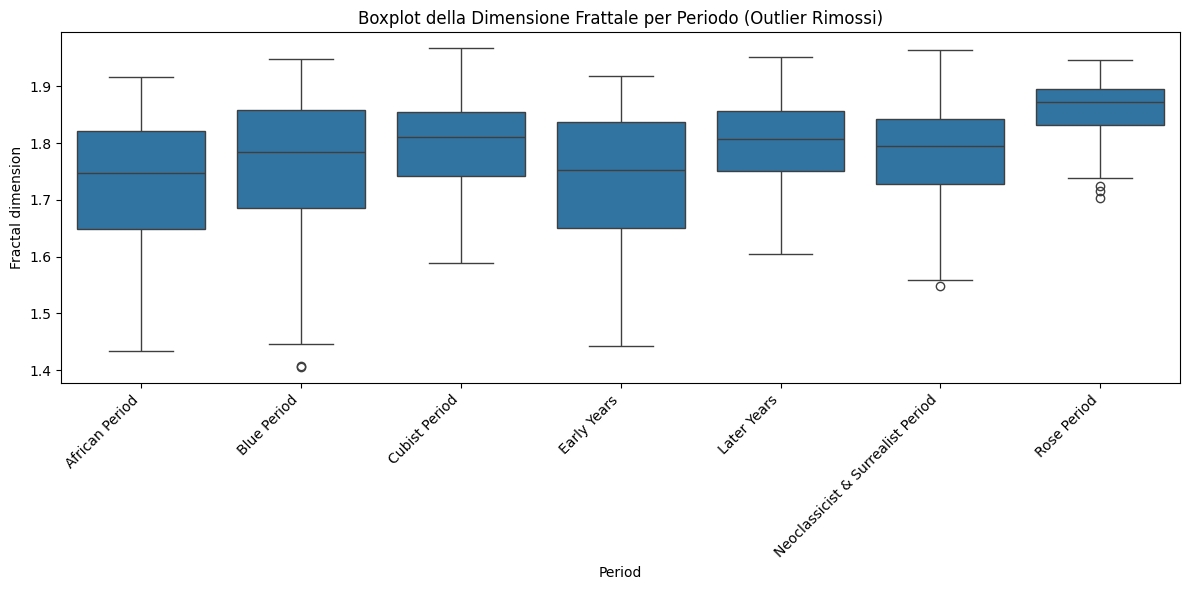

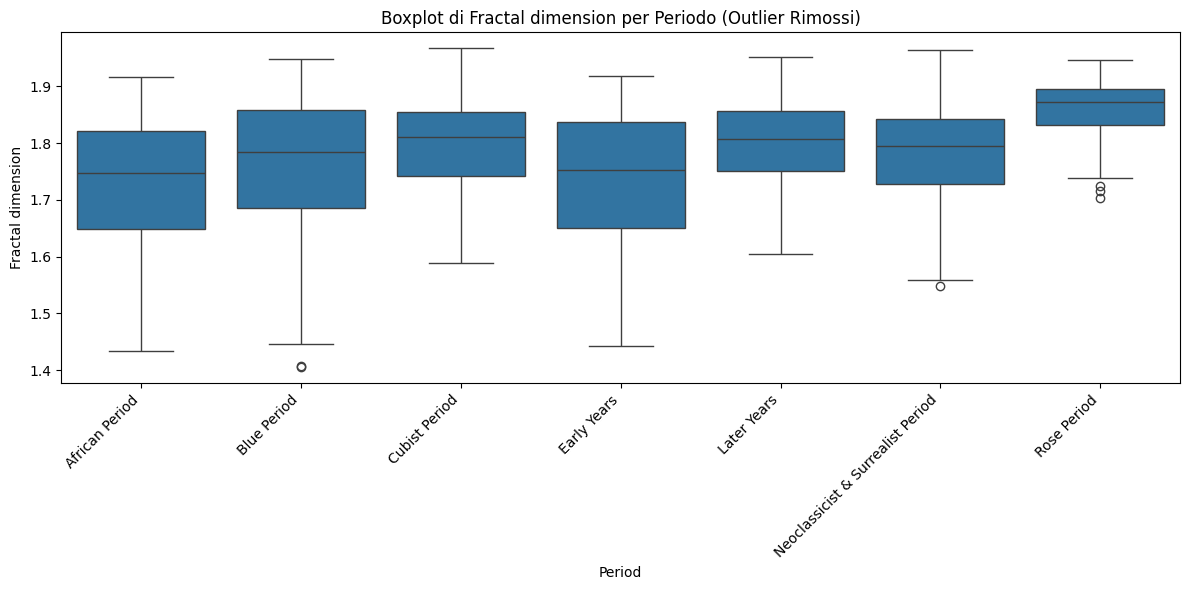

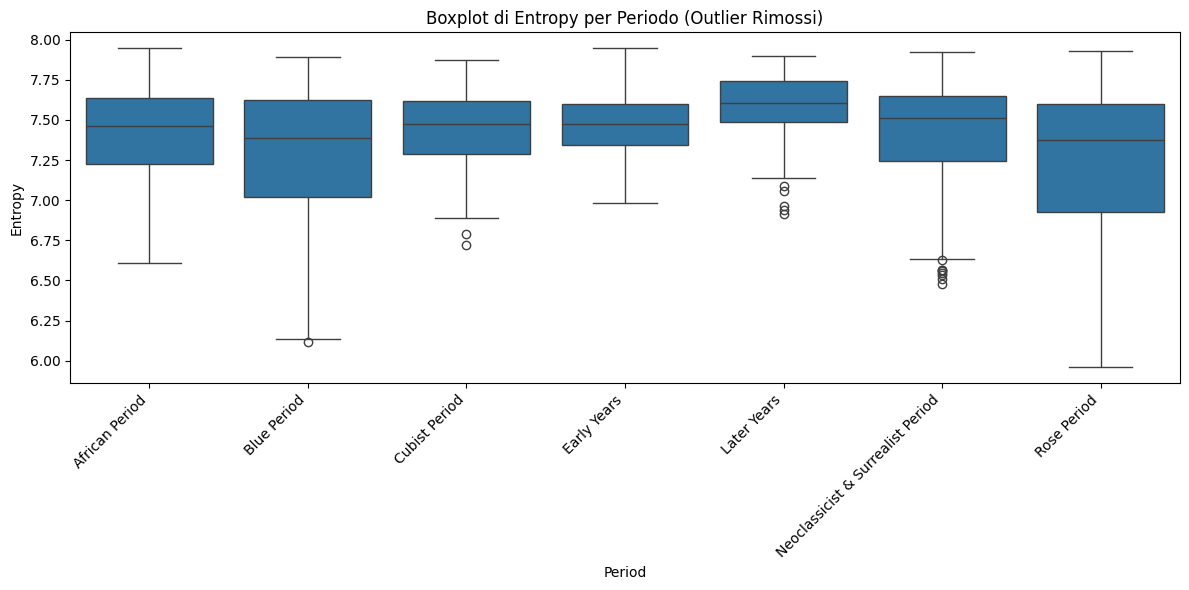

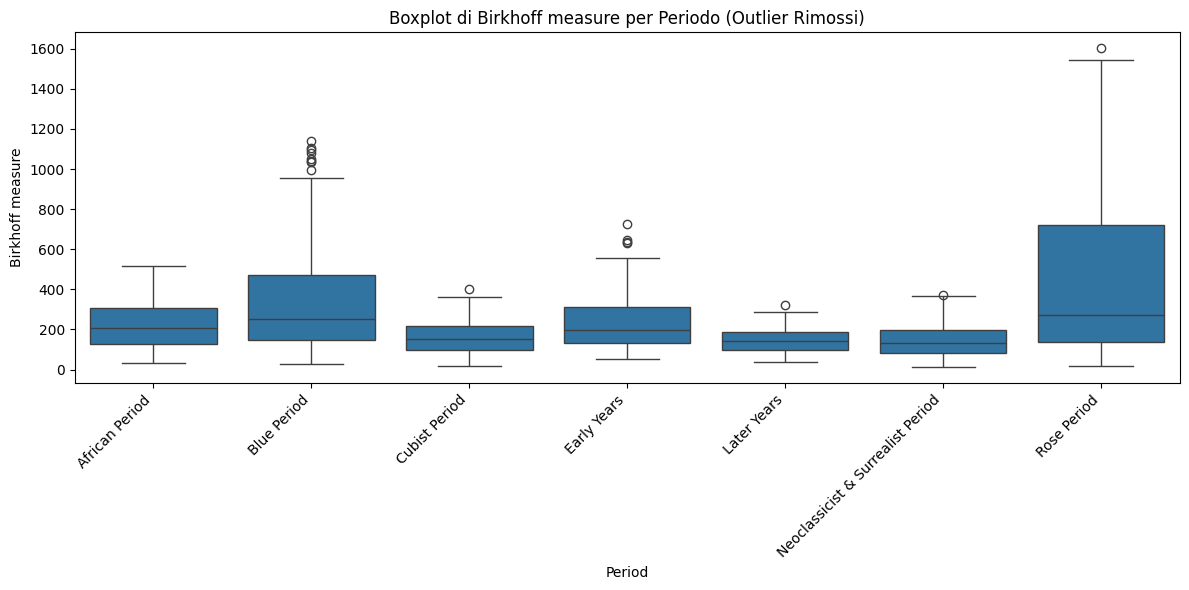

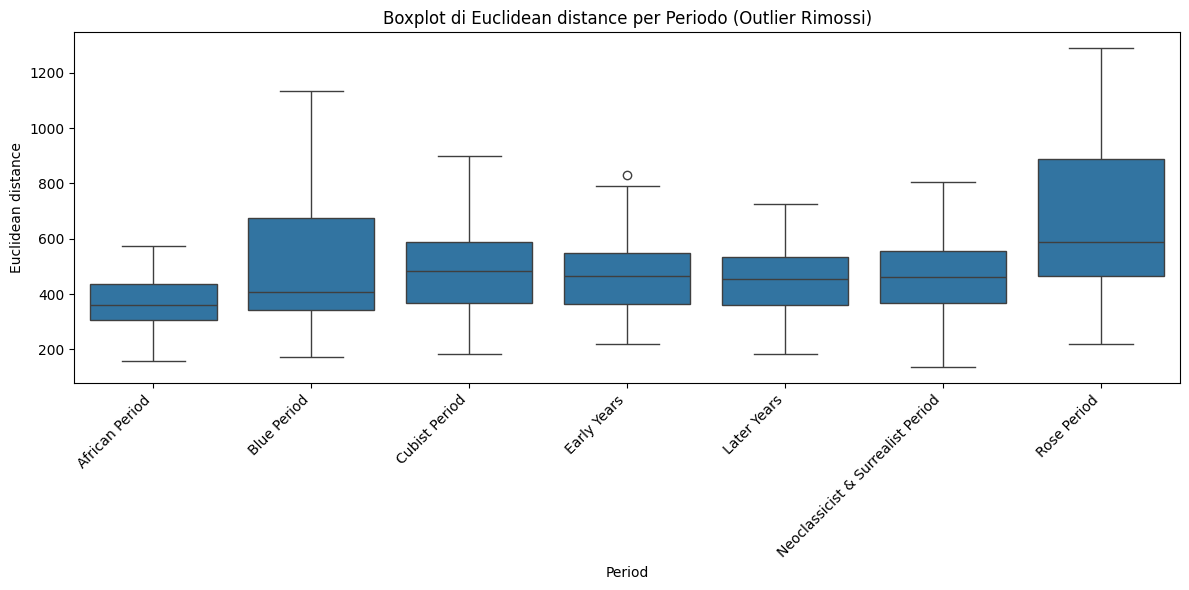

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carica il tuo CSV
try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    df = pd.read_csv(".\\metrics_with_details_no_outlier.csv", decimal=',')
    print("CSV caricato con successo. Prime 5 righe:")
    print(df.head())
except FileNotFoundError:
    print("Errore: 'metrics_with_details_no_outlier.csv' non trovato. Assicurati che il file sia nella directory corretta.")
    exit()
except Exception as e:
    print(f"Errore durante la lettura del CSV: {e}")
    exit()

# Assicurati che la colonna 'Period' esista
if 'Period' not in df.columns:
    print("Errore: La colonna 'Period' non è presente nel DataFrame. Impossibile raggruppare per periodo.")
    exit()

# Assicurati che le colonne numeriche siano di tipo numerico, gestendo errori di conversione
# Utilizziamo errors='coerce' per convertire i valori non numerici in NaN
# e poi possiamo droppare queste righe o gestirle in altro modo.
print("\nTentativo di convertire le colonne numeriche...")
numerical_cols = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Puoi decidere di droppare le righe dove la conversione ha fallito per queste colonne
        # df.dropna(subset=[col], inplace=True)
    else:
        print(f"Attenzione: Colonna '{col}' non trovata nel DataFrame.")

# Rimuoviamo le righe con valori NaN nelle colonne numeriche rilevanti prima di calcolare gli outlier,
# altrimenti i calcoli Q1, Q3, IQR potrebbero fallire o essere inaccurati.
initial_rows_before_nan_drop = df.shape[0]
df.dropna(subset=numerical_cols, inplace=True)
rows_dropped_due_to_nan = initial_rows_before_nan_drop - df.shape[0]
if rows_dropped_due_to_nan > 0:
    print(f"Rimosse {rows_dropped_due_to_nan} righe contenenti valori non numerici (NaN) nelle colonne metriche.")


# Crea un DataFrame vuoto per contenere i dati senza outlier
df_no_outliers_by_Period = pd.DataFrame()

# 3. Itera su ogni Period, calcola gli outlier e filtra
print("\nRimozione degli outlier per ogni 'Period'...")
for Period in df['Period'].unique():
    print(f"\nProcessing Period: {Period}")
    # Ottieni il DataFrame per il periodo corrente. Usa .copy() per evitare SettingWithCopyWarning
    Period_df = df[df['Period'] == Period].copy() 
    initial_Period_rows = Period_df.shape[0]

    for col in numerical_cols:
        if col in Period_df.columns:
            # Controlla se ci sono abbastanza dati non-NaN per calcolare IQR
            if len(Period_df[col].dropna()) < 4: 
                print(f"  Attenzione: Troppi pochi dati non-NaN ({len(Period_df[col].dropna())}) in '{col}' per il periodo '{Period}' per calcolare IQR. Saltando.")
                continue

            Q1 = Period_df[col].quantile(0.25)
            Q3 = Period_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filtra gli outlier per la colonna corrente e il periodo
            # Assicurati di gestire i NaN in questa fase, escludendoli dal filtro,
            # ma Period_df[col].dropna() sopra dovrebbe aver già pulito.
            Period_df = Period_df[(Period_df[col] >= lower_bound) & (Period_df[col] <= upper_bound)]
        else:
            print(f"  Attenzione: Colonna '{col}' non trovata in Period_df per il periodo '{Period}'.")

    rows_removed_for_Period = initial_Period_rows - Period_df.shape[0]
    print(f"  Rimosse {rows_removed_for_Period} righe con outlier per il periodo '{Period}'.")

    # Aggiungi i dati puliti di questo periodo al DataFrame finale
    df_no_outliers_by_Period = pd.concat([df_no_outliers_by_Period, Period_df])

# 4. Mostra i risultati finali
print("\nProcesso di rimozione outlier completato.")
print("Forma del DataFrame iniziale (dopo pulizia NaN):", df.shape)
print("Forma del DataFrame dopo aver rimosso gli outlier per periodo:", df_no_outliers_by_Period.shape)
print("\nPrime 5 righe del DataFrame pulito (per periodo):")
print(df_no_outliers_by_Period.head())

# 5. (Opzionale) Salva il DataFrame pulito
# MODIFICA QUI: Specifica decimal=',' per la scrittura del CSV
df_no_outliers_by_Period.to_csv(".\\metrics_with_details_no_outlier.csv", index=False, decimal=',')
print("\nDati puliti salvati in 'metrics_with_details_no_outlier.csv'")

# 6. Adesso, creiamo i boxplot per visualizzare gli outlier PER PERIODO
print("\nCreazione dei boxplot per verificare gli outlier per ogni periodo...")

# Esempio: Boxplot per 'Fractal dimension' raggruppato per 'Period'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Period', y='Fractal dimension', data=df_no_outliers_by_Period)
plt.title('Boxplot della Dimensione Frattale per Periodo (Outlier Rimossi)')
plt.xlabel('Period')
plt.ylabel('Fractal dimension')
plt.xticks(rotation=45, ha='right') # Ruota le etichette per leggibilità
plt.tight_layout()
plt.show()

# Per visualizzare un boxplot per OGNI combinazione (Colonna, Periodo) dopo la pulizia
for col in numerical_cols:
    if col in df_no_outliers_by_Period.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Period', y=col, data=df_no_outliers_by_Period)
        plt.title(f'Boxplot di {col} per Periodo (Outlier Rimossi)')
        plt.xlabel('Period')
        plt.ylabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Attenzione: Colonna '{col}' non trovata nel DataFrame pulito per i boxplot.")

# **STEP 6: CONTEGGIO POST PULITURA**
Dalla pulitura sono rimaste 852 opere:

Number of elements per period:

1. Neoclassicist & Surrealist Period: 352
2. Cubist Period: 125
3. Later Years: 125
4. Blue Period: 75
5. Rose Period: 66
6. African Period: 56
7. Early Years: 53


In [ ]:
import pandas as pd
import os

def analyze_csv_periods(csv_filepath, period_column_name='Period'):
    """
    Counts the total number of elements (rows) in a CSV and the number of
    elements for each unique period.

    Args:
        csv_filepath (str): The path to your input CSV file.
        period_column_name (str): The name of the column containing the period information.
                                  Defaults to 'periodo'.
    """
    if not os.path.exists(csv_filepath):
        print(f"Error: CSV file not found at '{csv_filepath}'")
        return

    try:
        df = pd.read_csv(csv_filepath)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if period_column_name not in df.columns:
        print(f"Error: Column '{period_column_name}' not found in the CSV file.")
        print("Please ensure the CSV file has a 'periodo' column.")
        return

    # 1. Conto il numero totale di elementi (righe) nel CSV
    total_elements = len(df)
    print(f"Total number of elements (rows) in the CSV: {total_elements}\n")

    # 2. Conto gli elementi per ogni periodo
    # .value_counts() è perfetto per questo, conta le occorrenze uniche in una Series
    # .fillna('Unknown Period') è utile nel caso ci fossero ancora valori NaN nella colonna periodo,
    # anche se abbiamo fatto il dropna. In questo modo vengono raggruppati come 'Unknown Period'.
    elements_by_period = df[period_column_name].value_counts(dropna=False) # dropna=False per contare anche i NaN se presenti

    print("Number of elements per period:")
    print("-" * 30)
    for period, count in elements_by_period.items():
        # Gestisce il caso in cui value_counts() restituisca il conteggio per NaN
        if pd.isna(period):
            period_display = "Undefined/Missing Period"
        else:
            period_display = period
        print(f"  {period_display}: {count}")
    print("-" * 30)


# --- Esempio di utilizzo ---
# Assicurati che questo sia il percorso al CSV generato dallo script precedente.
# Se hai usato il nome di output suggerito, sarà questo:
your_cleaned_csv_path = ".\\metrics_with_details_no_outlier.csv"

analyze_csv_periods(your_cleaned_csv_path, period_column_name='Period')

Total number of elements (rows) in the CSV: 946

Number of elements per period:
------------------------------
  Neoclassicist & Surrealist Period: 379
  Later Years: 135
  Cubist Period: 128
  Blue Period: 99
  Rose Period: 81
  African Period: 66
  Early Years: 58
------------------------------


# **STEP 7: NORMALIZZAZIONE DELLE METRICHE**
Data la differenza di scala delle varie metriche, bisogna normalizzare i valori tra 0 e 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# === 1. Carica il CSV originale ===
file_csv = ".\\metrics_with_details_no_outlier.csv"

try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    df = pd.read_csv(file_csv, decimal=',')
    print(f"File '{file_csv}' caricato con successo.")
except FileNotFoundError:
    print(f"Errore: Il file '{file_csv}' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit() # Esce dallo script se il file non esiste
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# === 2. Colonne da normalizzare ===
metric_cols = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# Verifica che tutte le colonne siano presenti nel DataFrame
for col in metric_cols:
    if col not in df.columns:
        raise ValueError(f"Colonna mancante: '{col}'. Controlla il tuo file CSV e assicurati che i nomi delle colonne siano esatti.")

# ---
## 3. Forza le colonne a essere numeriche e poi elimina le righe con valori non numerici
# ---
print("\nVerifica e conversione delle colonne metriche a tipo numerico, e rimozione delle righe non valide...")

# Registra il numero di righe prima della pulizia
initial_rows = len(df)

# Inizializza una Series booleana con lo stesso indice del DataFrame, tutti a False.
# Questo è il flag che useremo per marcare le righe da eliminare.
non_numeric_rows_to_drop = pd.Series(False, index=df.index)

for col in metric_cols:
    # Tenta di convertire la colonna in un tipo numerico, trasformando gli errori in NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Crea una Series booleana (con lo stesso indice del DataFrame) che è True dove ci sono NaN in questa colonna
    is_nan_in_this_col = df[col].isnull()

    if is_nan_in_this_col.any():
        # Ottieni gli indici delle righe dove sono stati trovati NaN in questa colonna
        rows_with_nan_indices = df.index[is_nan_in_this_col].tolist()
        print(f"   Trovati valori non numerici (ora NaN) nella colonna '{col}' nelle righe (indice): {rows_with_nan_indices}")
        
        # Aggiorna la Series 'non_numeric_rows_to_drop' usando l'operatore OR logico (`|`).
        # Poiché 'is_nan_in_this_col' ha lo stesso indice e forma di 'non_numeric_rows_to_drop',
        # l'operazione di broadcast funziona correttamente.
        non_numeric_rows_to_drop = non_numeric_rows_to_drop | is_nan_in_this_col

# Elimina tutte le righe che sono state contrassegnate per l'eliminazione
if non_numeric_rows_to_drop.any():
    # Estrai gli indici delle righe che sono True (cioè da eliminare)
    indices_to_drop = df.index[non_numeric_rows_to_drop]
    df.drop(index=indices_to_drop, inplace=True)
    # Calcola correttamente il numero di righe rimosse
    rows_removed = initial_rows - len(df)
    print(f"   Rimosse {rows_removed} righe contenenti valori non numerici nelle colonne metriche.")
else:
    print("   Nessun valore non numerico trovato nelle colonne metriche specificate. Nessuna riga rimossa.")
print("-" * 50) # Separatore per chiarezza

# ---
## 4. Normalizza i dati tra 0 e 1
# ---
print("\nNormalizzazione delle colonne metriche tra 0 e 1...")
scaler = MinMaxScaler()
# Assicurati che ci siano ancora righe da normalizzare
if not df.empty:
    df[metric_cols] = scaler.fit_transform(df[metric_cols])
    print("Normalizzazione completata.")
else:
    print("Attenzione: Nessuna riga rimanente nel DataFrame dopo la pulizia. Impossibile normalizzare.")


# ---
## 5. Salva il nuovo CSV
# ---
output_file = ".\\normalized_metrics_with_details_no_outlier.csv"
if not df.empty:
    # MODIFICA QUI: Specifica decimal=',' per la scrittura del CSV
    df.to_csv(output_file, index=False, decimal=',')
    print(f"\n✅ File salvato con successo: {output_file}")
else:
    print(f"\nNon è stato salvato alcun file '{output_file}' perché il DataFrame è vuoto dopo la pulizia.")

File '.\metrics_with_details_no_outlier.csv' caricato con successo.

Verifica e conversione delle colonne metriche a tipo numerico, e rimozione delle righe non valide...
   Nessun valore non numerico trovato nelle colonne metriche specificate. Nessuna riga rimossa.
--------------------------------------------------

Normalizzazione delle colonne metriche tra 0 e 1...
Normalizzazione completata.

✅ File salvato con successo: .\normalized_metrics_with_details_no_outlier.csv


# **STEP 8: (NORMALIZZATA) ANALISI STATISTICA RISPETTO AL PERIODO**
1. Calcoliamo la media e la deviazione standard rispetto ai Periodi
2. Esaguiamo l'analisi MANOVA rispetto ai Periodi cronologicamente consecutivi: "Early Years", "Blue Period", "Rose Period", "African Period", "Cubist Period", "Neoclassicist & Surrealist Period", "Later Years".

In [ ]:
import pandas as pd
import os

# --- Percorsi dei file ---
input_csv_path = '.\\normalized_metrics_with_details_no_outlier.csv'
output_stats_by_style_csv_path = '.\\normalized_metrics_by_period.csv'

print("--- Inizio calcolo statistiche per style ---")

# --- 1. Caricamento del dataset ---
try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    df = pd.read_csv(input_csv_path, decimal=',')
    print(f"File '{input_csv_path}' caricato con successo.")
except FileNotFoundError:
    print(f"Errore: Il file '{input_csv_path}' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- 2. Identificazione di 'Period' e delle colonne metriche ---
# Nomi esatti delle colonne in inglese
style_column = 'Period' # Il tuo codice si riferisce a 'Period' per il raggruppamento
metric_columns = [
    'Fractal dimension',
    'Entropy',
    'Birkhoff measure',
    'Euclidean distance'
]

# Controlla se la colonna 'Period' esiste
if style_column not in df.columns:
    print(f"Errore: La colonna '{style_column}' non è stata trovata nel file CSV.")
    print("Verifica i nomi delle colonne nel tuo CSV. Colonne disponibili:")
    print(df.columns.tolist())
    exit()

# Filtra solo le colonne metriche che esistono nel DataFrame
existing_metric_columns = [col for col in metric_columns if col in df.columns]

if not existing_metric_columns:
    print("Errore: Nessuna delle colonne metriche specificate è stata trovata nel file CSV.")
    print("Verifica i nomi delle colonne nel tuo CSV.")
    exit()

# Seleziona solo le colonne necessarie per l'analisi
df_selected = df[[style_column] + existing_metric_columns]
print(f"\nColonne selezionate per l'analisi: '{style_column}' e {existing_metric_columns}")


# --- 3. Raggruppamento per 'Period' e calcolo delle statistiche ---
print(f"\nCalcolo delle statistiche (media e deviazione standard) per ogni '{style_column}'...")
mean_by_style = df_selected.groupby(style_column)[existing_metric_columns].mean()
std_by_style = df_selected.groupby(style_column)[existing_metric_columns].std()

# --- 4. Preparazione del DataFrame dei risultati ---
stats_by_style_df = pd.DataFrame()

for metric in existing_metric_columns:
    stats_by_style_df[f'{metric}_Mean'] = mean_by_style[metric]
    stats_by_style_df[f'{metric}_Std_Dev'] = std_by_style[metric]

# Resettiamo l'indice per avere 'Period' come colonna
stats_by_style_df = stats_by_style_df.reset_index()

print(f"\n--- Risultati Calcolati per {style_column} ---")
print(stats_by_style_df.to_string(index=False)) # to_string(index=False) per una stampa più pulita

# --- 5. Salvataggio dei risultati in un nuovo file CSV ---
try:
    # Assicurati che la directory di output esista
    output_dir = os.path.dirname(output_stats_by_style_csv_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Creata directory di output: '{output_dir}'")

    # MODIFICA QUI: Specifica decimal=',' per la scrittura del CSV
    stats_by_style_df.to_csv(output_stats_by_style_csv_path, index=False, decimal=',')
    print(f"\nStatistiche per {style_column} salvate con successo in: '{output_stats_by_style_csv_path}'")
except Exception as e:
    print(f"Errore durante il salvataggio del file CSV: {e}")

print("\n--- Operazione Completata ---")

--- Inizio calcolo statistiche per style ---
File '.\normalized_metrics_with_details_no_outlier.csv' caricato con successo.

Colonne selezionate per l'analisi: 'Period' e ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

Calcolo delle statistiche (media e deviazione standard) per ogni 'Period'...

--- Risultati Calcolati per Period ---
                           Period  Fractal dimension_Mean  Fractal dimension_Std_Dev  Entropy_Mean  Entropy_Std_Dev  Birkhoff measure_Mean  Birkhoff measure_Std_Dev  Euclidean distance_Mean  Euclidean distance_Std_Dev
                   African Period                0.571637                   0.217452      0.729335         0.153862               0.128403                  0.074304                 0.199825                    0.083360
                      Blue Period                0.629912                   0.232987      0.666684         0.212770               0.220396                  0.183831                 0.322402           

Il grafico combinato è stato salvato come 'combined_metrics_trend.png'


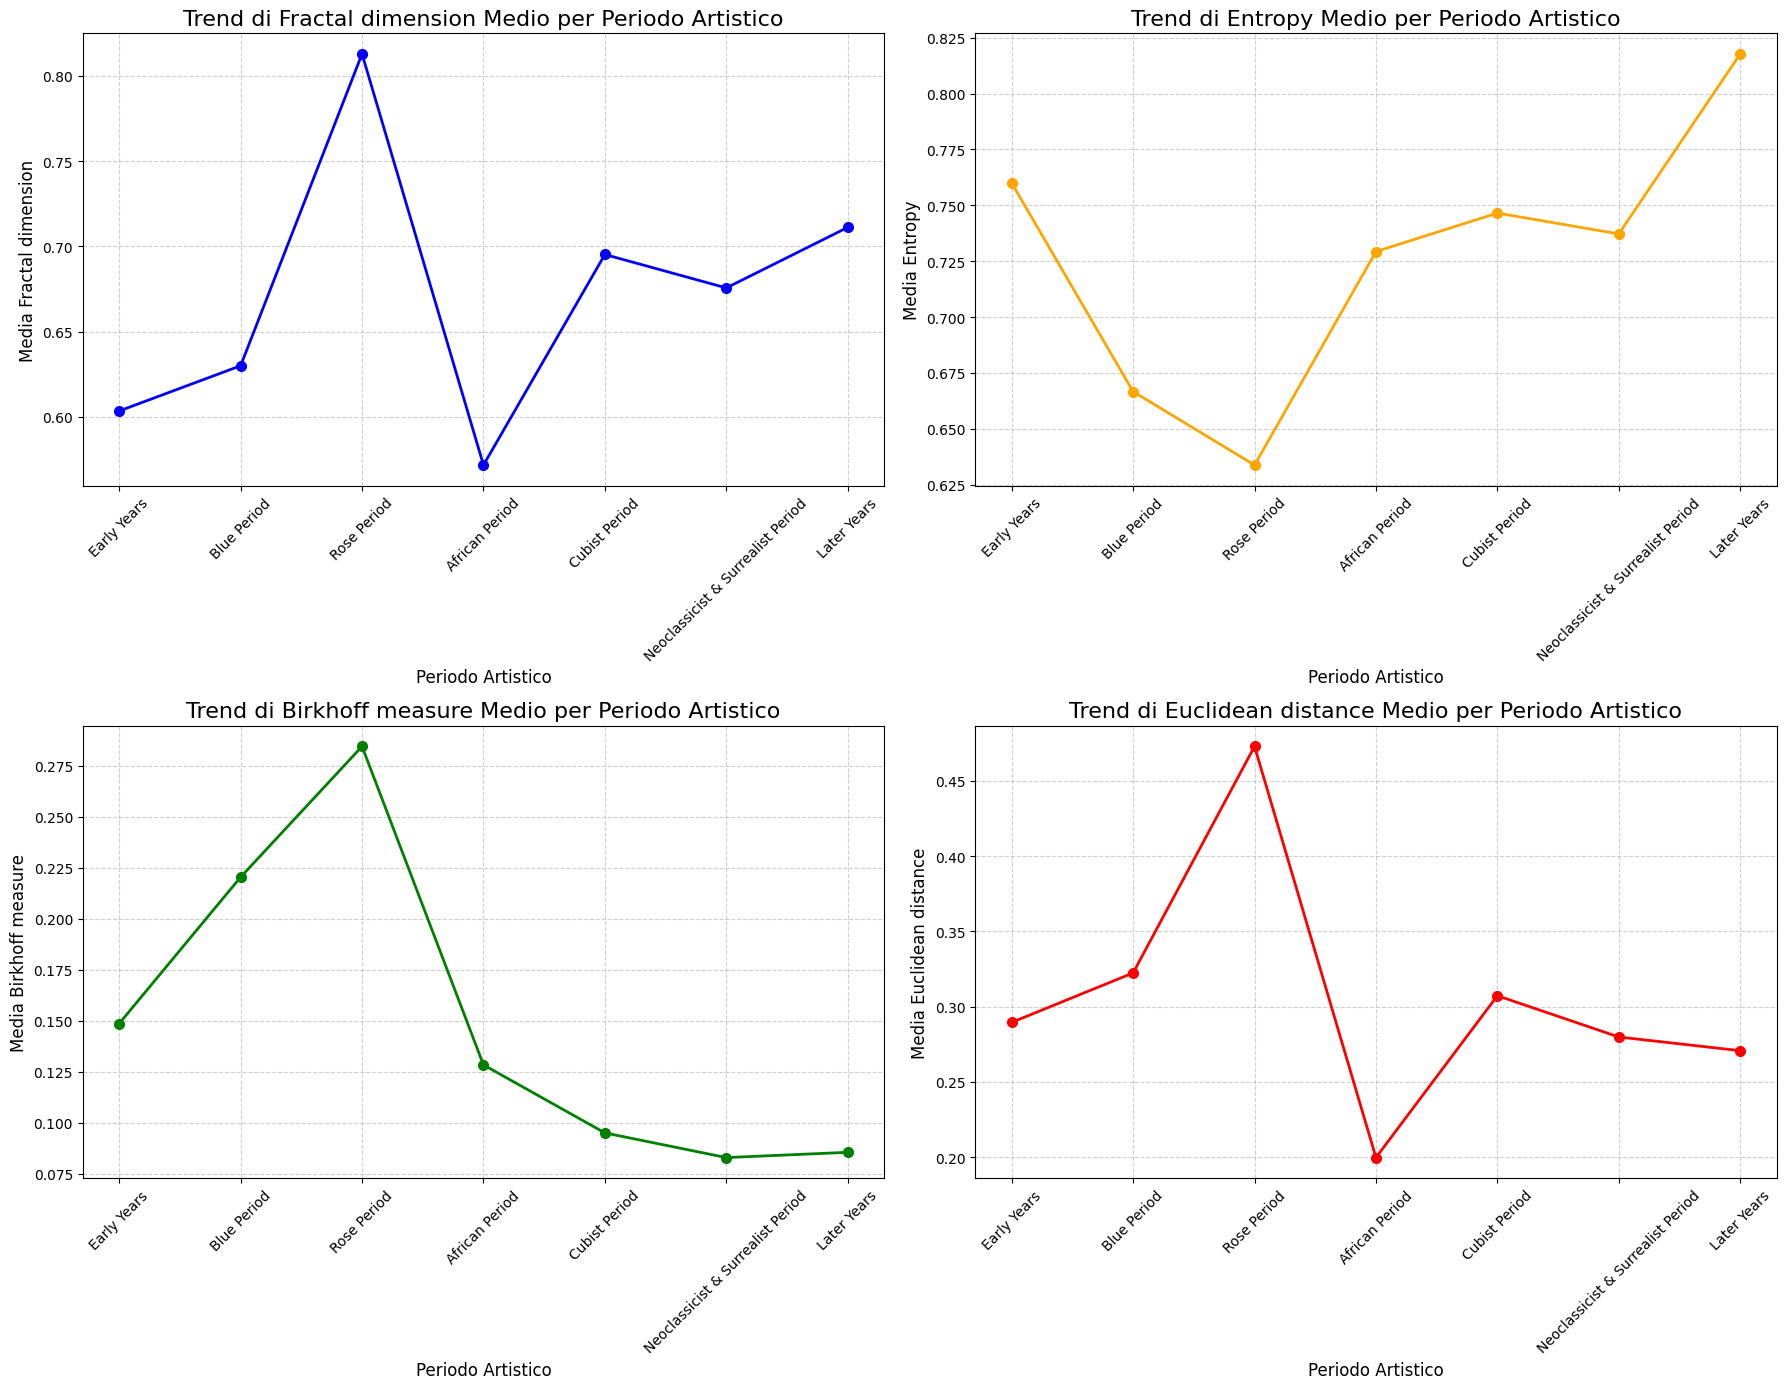

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica il DataFrame
# MODIFICA QUI: Assicurati che il percorso del file sia corretto se non è nella stessa directory
df = pd.read_csv('normalized_metrics_with_details_no_outlier.csv', decimal=',')

# --- Stili ordinati cronologicamente ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Definisci le feature (le 4 metriche)
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# --- Preparazione del DataFrame ---
# 1. Assicurati che le colonne delle feature siano numeriche e gestisci i NaN
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Rimuovi le righe con NaN nelle feature o nella colonna 'Period'
df.dropna(subset=features + ['Period'], inplace=True)

# 3. Imposta la colonna 'Period' come tipo categorico con l'ordine desiderato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

# 4. Calcola la media di ogni feature per ogni periodo
mean_metrics_by_style = df.groupby('Period')[features].mean().reindex(ordered_styles)

# Rimuovi eventuali periodi che non avevano dati (se .reindex ha introdotto NaN per essi)
mean_metrics_by_style.dropna(inplace=True)


# --- Creazione del Plot Unico con 4 Subplot ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # Crea una griglia 2x2 di subplot
axes = axes.flatten() # Appiattisci l'array 2x2 di assi per facilitare l'iterazione

# Definisci colori differenti per ogni curva
colors = ['blue', 'orange', 'green', 'red']

for i, feature in enumerate(features):
    ax = axes[i] # Ottieni l'asse del subplot corrente

    # Traccia la linea che connette i valori medi
    ax.plot(mean_metrics_by_style.index, mean_metrics_by_style[feature],
            marker='o', # Punti per ogni stile
            color=colors[i], # Colore differente per ogni feature
            linestyle='-', # Linea continua
            linewidth=2, # Spessore della linea
            markersize=7 # Dimensione del punto
           )

    ax.set_title(f'Trend di {feature} Medio per Periodo Artistico', fontsize=16)
    ax.set_xlabel('Periodo Artistico', fontsize=12)
    ax.set_ylabel(f'Media {feature}', fontsize=12)

    # Ruota le etichette dell'asse X per una migliore leggibilità
    # 'labelrotation' è il parametro corretto per ruotare le etichette
    # 'ha' (horizontal alignment) funziona con set_xticklabels, ma qui è gestito implicitamente o da labelrotation.
    # L'errore precedente era dovuto all'uso di 'ha' direttamente in tick_params con 'rotation'.
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)


    ax.grid(True, linestyle='--', alpha=0.6) # Griglia con trasparenza

plt.tight_layout() # Regola il layout per prevenire sovrapposizioni
plt.savefig('combined_metrics_trend.png') # Salva il grafico come file PNG
print("Il grafico combinato è stato salvato come 'combined_metrics_trend.png'")

plt.show() # Mostra il plot (opzionale, se lo si vuole vedere immediatamente)

In [ ]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# Carica il DataFrame
try:
    df = pd.read_csv('.\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
    print("CSV 'normalized_metrics_with_year_and_period_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_year_and_period_no_outlier.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- Periodi ordinati cronologicamente ---
ordered_Periods = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

print(f"Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:\n{ordered_Periods}\n")

# Definisci le feature da analizzare
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

results = []

for i in range(len(ordered_Periods) - 1):
    Period1 = ordered_Periods[i]
    Period2 = ordered_Periods[i + 1]

    print(f"\n--- Analisi per la coppia: ({Period1}, {Period2}) ---")

    subset = df[df["Period"].isin([Period1, Period2])].copy()
    
    initial_subset_rows = len(subset)
    
    for col in features:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')
    
    subset.dropna(subset=features + ['Period'], inplace=True)

    if len(subset) < initial_subset_rows:
        print(f"  Avviso: Rimosse {initial_subset_rows - len(subset)} righe con NaN nelle feature per ({Period1}, {Period2}).")
    
    counts_after_clean = subset["Period"].value_counts()
    
    if len(counts_after_clean) < 2 or any(counts_after_clean < 2):
        print(f"  Saltando la coppia ({Period1}, {Period2}) dopo pulizia NaN: dati insufficienti per l'analisi (almeno 2 per gruppo necessari).")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Dati insufficienti o un solo periodo presente."
        })
        continue
    
    has_zero_variance = False
    for period_val in counts_after_clean.index:
        period_data = subset[subset['Period'] == period_val]
        for feature in features:
            if period_data[feature].var() == 0:
                print(f"  Attenzione: La feature '{feature}' ha varianza zero nel periodo '{period_val}'. Questo può causare problemi nella MANOVA.")
                has_zero_variance = True
                break
        if has_zero_variance:
            break

    if has_zero_variance:
        print(f"  Saltando la coppia ({Period1}, {Period2}) a causa di varianza zero in una o più feature.")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Varianza zero in una feature."
        })
        continue

    subset['Period'] = pd.Categorical(subset['Period'])

    formula_manova = " + ".join([f"Q('{col}')" for col in features]) + " ~ C(Period)"
    
    p_manova = float('nan')
    significant_features = []

    try:
        manova = MANOVA.from_formula(formula_manova, data=subset)
        result = manova.mv_test()
        
        manova_term_key = None
        for key in result.results.keys():
            if "Period" in key and key != 'Intercept':
                manova_term_key = key
                break
        
        if manova_term_key and 'stat' in result.results[manova_term_key] and isinstance(result.results[manova_term_key]['stat'], pd.DataFrame):
            if "Wilks' lambda" in result.results[manova_term_key]['stat'].index:
                p_manova = result.results[manova_term_key]['stat'].loc["Wilks' lambda", 'Pr > F']
                print(f"  MANOVA (Wilks' lambda) p-value estratto: {p_manova:.4f} (Termine: '{manova_term_key}')")
            else:
                print(f"  Chiave 'Wilks\\' lambda' non trovata nell'output statistico della MANOVA per ({Period1}, {Period2}).")
        else:
            print(f"  Chiave di termine MANOVA ('Period' o 'C(Period)') non trovata o formato inatteso nell'output MANOVA per ({Period1}, {Period2}). Chiavi disponibili: {list(result.results.keys())}")

    except Exception as e:
        print(f"  Errore critico durante la MANOVA per ({Period1}, {Period2}): {e}")
        p_manova = float('nan') 

    if not np.isnan(p_manova) and p_manova < 0.05:
        print(f"  MANOVA significativa (p={p_manova:.4f}). Eseguo ANOVA univariata...")
        for feature in features:
            formula_anova = f"Q('{feature}') ~ C(Period)"
            try:
                model = ols(formula_anova, data=subset).fit()
                
                # --- MODIFICA CRUCIALE QUI PER L'ANOVA UNVARIATA ---
                anova_p_value_found = False
                for p_idx in model.pvalues.index:
                    # Cerca un termine che inizi con 'C(Period)'
                    if str(p_idx).startswith('C(Period)'):
                        p_anova = model.pvalues[p_idx]
                        if p_anova < 0.05:
                            significant_features.append(f"{feature} (p={p_anova:.4f})")
                        anova_p_value_found = True
                        break # Trovato il p-value per questa feature, passa alla prossima
                
                if not anova_p_value_found:
                    print(f"    Avviso: Termine significativo per 'C(Period)' non trovato nei p-value del modello ANOVA per '{feature}' in ({Period1}, {Period2}). P-values disponibili: {model.pvalues.index.tolist()}")

            except Exception as e:
                print(f"  Errore durante l'ANOVA per {feature} nella coppia ({Period1}, {Period2}): {e}")
    elif not np.isnan(p_manova): 
        print(f"  MANOVA non significativa (p={p_manova:.4f}). Saltando le ANOVA univariata.")
    else: 
        print(f"  MANOVA fallita o p-value non disponibile.")

    results.append({
        "Period_1": Period1,
        "Period_2": Period2,
        "MANOVA_p_value": p_manova,
        "Significant_features_ANOVA": ", ".join(significant_features) if significant_features else "Nessuna"
    })

df_results = pd.DataFrame(results)
output_csv_path = "normalized_manova_analysis_by_period.csv"
df_results.to_csv(output_csv_path, index=False)

print(f"\nAnalisi completata. I risultati sono stati salvati in '{output_csv_path}'")

CSV 'normalized_metrics_with_year_and_period_no_outlier.csv' caricato con successo.
Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:
['Early Years', 'Blue Period', 'Rose Period', 'African Period', 'Cubist Period', 'Neoclassicist & Surrealist Period', 'Later Years']


--- Analisi per la coppia: (Early Years, Blue Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (Blue Period, Rose Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (Rose Period, African Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (African Period, Cubist Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0

# **STEP 8.1: ANALISI STATISTICA RISPETTO AL PERIODO**
1. Calcoliamo la media e la deviazione standard rispetto ai Periodi
2. Esaguiamo l'analisi MANOVA rispetto ai Periodi cronologicamente consecutivi: "Early Years", "Blue Period", "Rose Period", "African Period", "Cubist Period", "Neoclassicist & Surrealist Period", "Later Years".

In [ ]:
import pandas as pd
import os

# --- Percorsi dei file ---
input_csv_path = '.\\metrics_with_details_no_outlier.csv'
output_stats_by_style_csv_path = '.\\metrics_by_period.csv'

print("--- Inizio calcolo statistiche per style ---")

# --- 1. Caricamento del dataset ---
try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    df = pd.read_csv(input_csv_path, decimal=',')
    print(f"File '{input_csv_path}' caricato con successo.")
except FileNotFoundError:
    print(f"Errore: Il file '{input_csv_path}' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- 2. Identificazione di 'Period' e delle colonne metriche ---
# Nomi esatti delle colonne in inglese
style_column = 'Period' # Il tuo codice si riferisce a 'Period' per il raggruppamento
metric_columns = [
    'Fractal dimension',
    'Entropy',
    'Birkhoff measure',
    'Euclidean distance'
]

# Controlla se la colonna 'Period' esiste
if style_column not in df.columns:
    print(f"Errore: La colonna '{style_column}' non è stata trovata nel file CSV.")
    print("Verifica i nomi delle colonne nel tuo CSV. Colonne disponibili:")
    print(df.columns.tolist())
    exit()

# Filtra solo le colonne metriche che esistono nel DataFrame
existing_metric_columns = [col for col in metric_columns if col in df.columns]

if not existing_metric_columns:
    print("Errore: Nessuna delle colonne metriche specificate è stata trovata nel file CSV.")
    print("Verifica i nomi delle colonne nel tuo CSV.")
    exit()

# Seleziona solo le colonne necessarie per l'analisi
df_selected = df[[style_column] + existing_metric_columns]
print(f"\nColonne selezionate per l'analisi: '{style_column}' e {existing_metric_columns}")


# --- 3. Raggruppamento per 'Period' e calcolo delle statistiche ---
print(f"\nCalcolo delle statistiche (media e deviazione standard) per ogni '{style_column}'...")
mean_by_style = df_selected.groupby(style_column)[existing_metric_columns].mean()
std_by_style = df_selected.groupby(style_column)[existing_metric_columns].std()

# --- 4. Preparazione del DataFrame dei risultati ---
stats_by_style_df = pd.DataFrame()

for metric in existing_metric_columns:
    stats_by_style_df[f'{metric}_Mean'] = mean_by_style[metric]
    stats_by_style_df[f'{metric}_Std_Dev'] = std_by_style[metric]

# Resettiamo l'indice per avere 'Period' come colonna
stats_by_style_df = stats_by_style_df.reset_index()

print(f"\n--- Risultati Calcolati per {style_column} ---")
print(stats_by_style_df.to_string(index=False)) # to_string(index=False) per una stampa più pulita

# --- 5. Salvataggio dei risultati in un nuovo file CSV ---
try:
    # Assicurati che la directory di output esista
    output_dir = os.path.dirname(output_stats_by_style_csv_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Creata directory di output: '{output_dir}'")

    # MODIFICA QUI: Specifica decimal=',' per la scrittura del CSV
    stats_by_style_df.to_csv(output_stats_by_style_csv_path, index=False, decimal=',')
    print(f"\nStatistiche per {style_column} salvate con successo in: '{output_stats_by_style_csv_path}'")
except Exception as e:
    print(f"Errore durante il salvataggio del file CSV: {e}")

print("\n--- Operazione Completata ---")

--- Inizio calcolo statistiche per style ---
File '.\metrics_with_details_no_outlier.csv' caricato con successo.

Colonne selezionate per l'analisi: 'Period' e ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

Calcolo delle statistiche (media e deviazione standard) per ogni 'Period'...

--- Risultati Calcolati per Period ---
                           Period  Fractal dimension_Mean  Fractal dimension_Std_Dev  Entropy_Mean  Entropy_Std_Dev  Birkhoff measure_Mean  Birkhoff measure_Std_Dev  Euclidean distance_Mean  Euclidean distance_Std_Dev
                   African Period                1.726503                   0.122186      7.408870         0.305678             215.994579                118.177248               366.170898                   96.114788
                      Blue Period                1.759247                   0.130915      7.284401         0.422710             362.306744                292.375839               507.501744                  228.

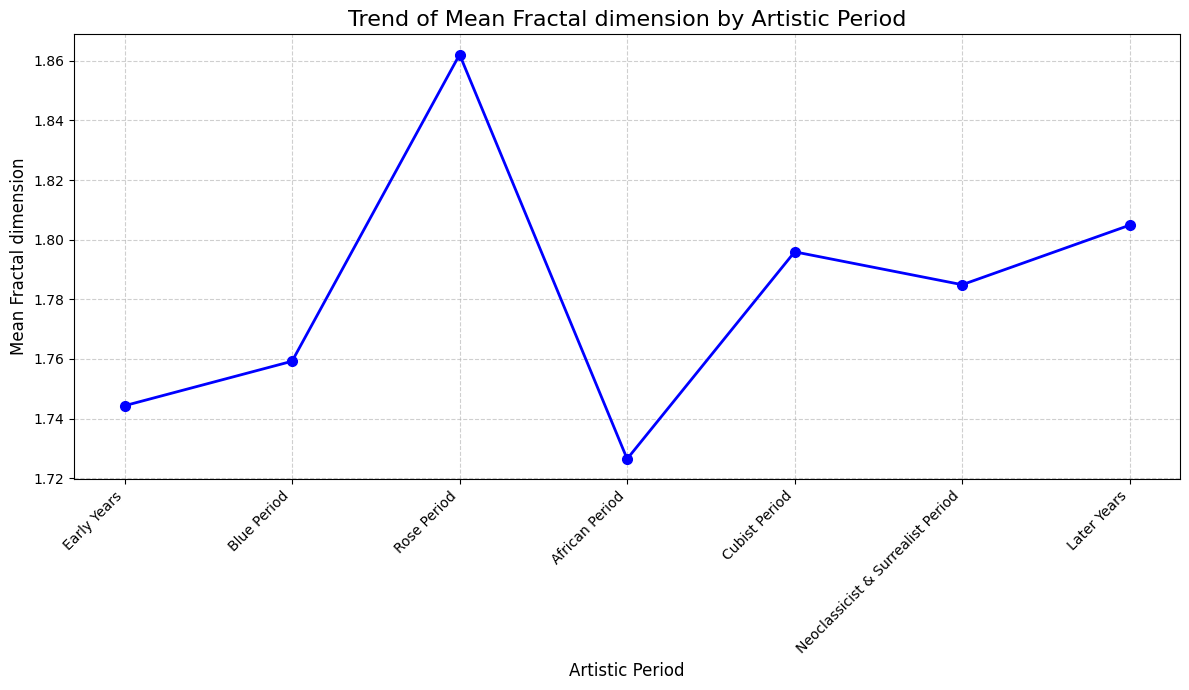

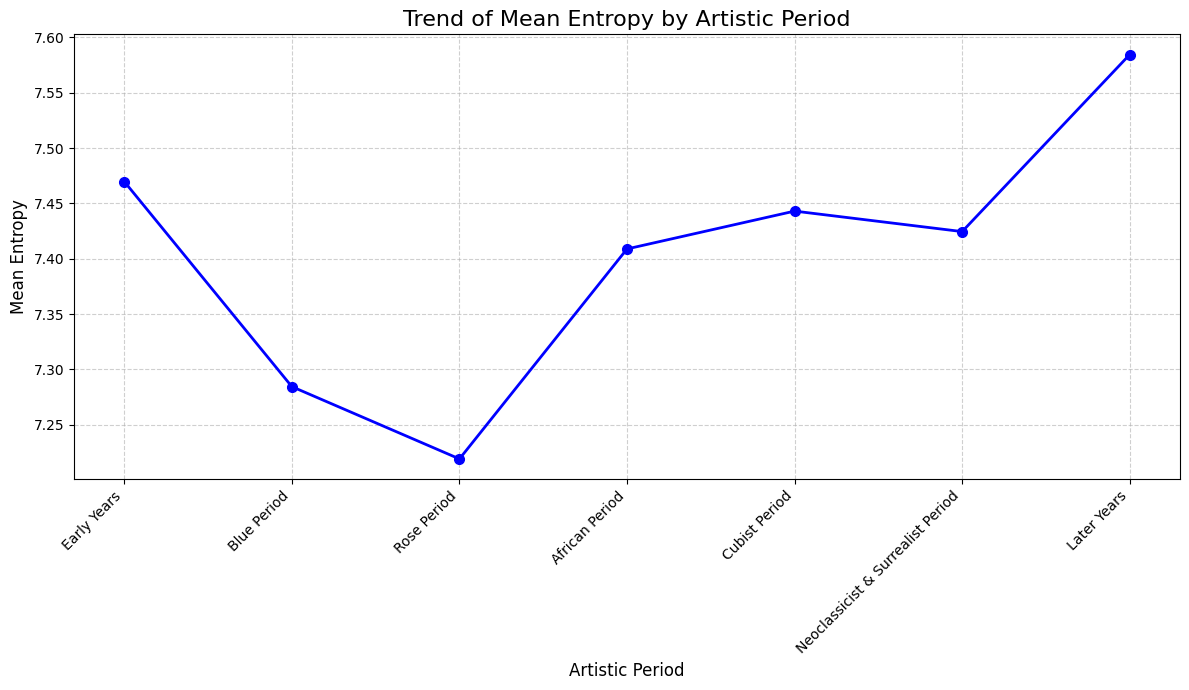

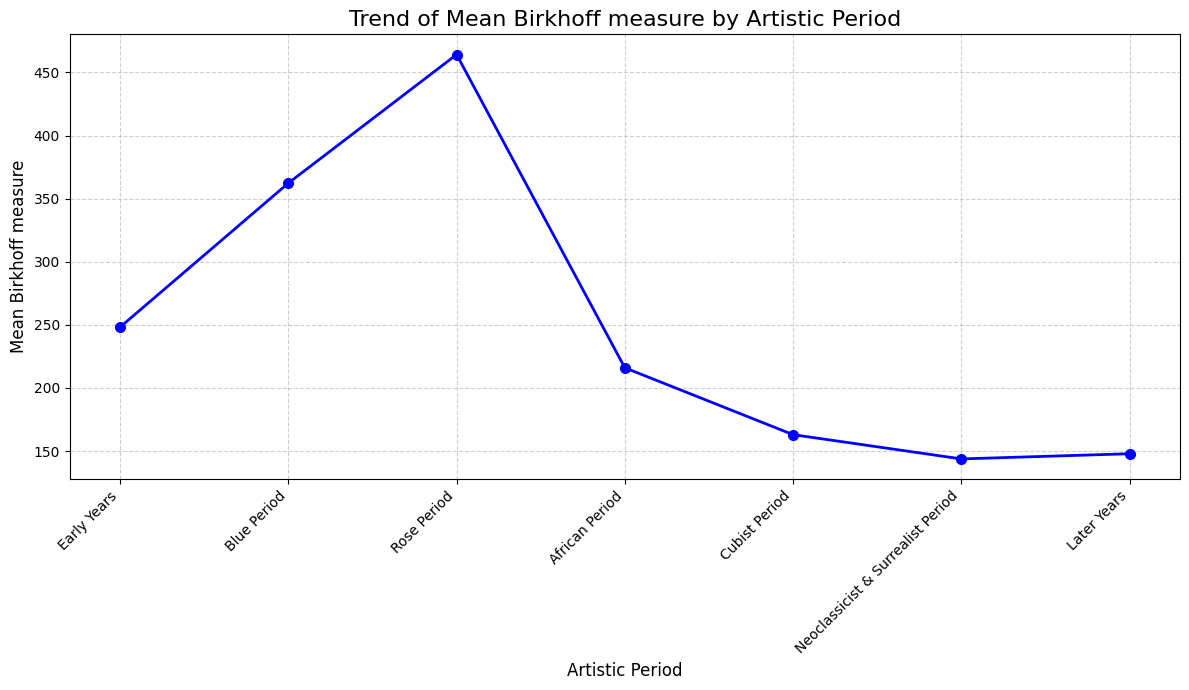

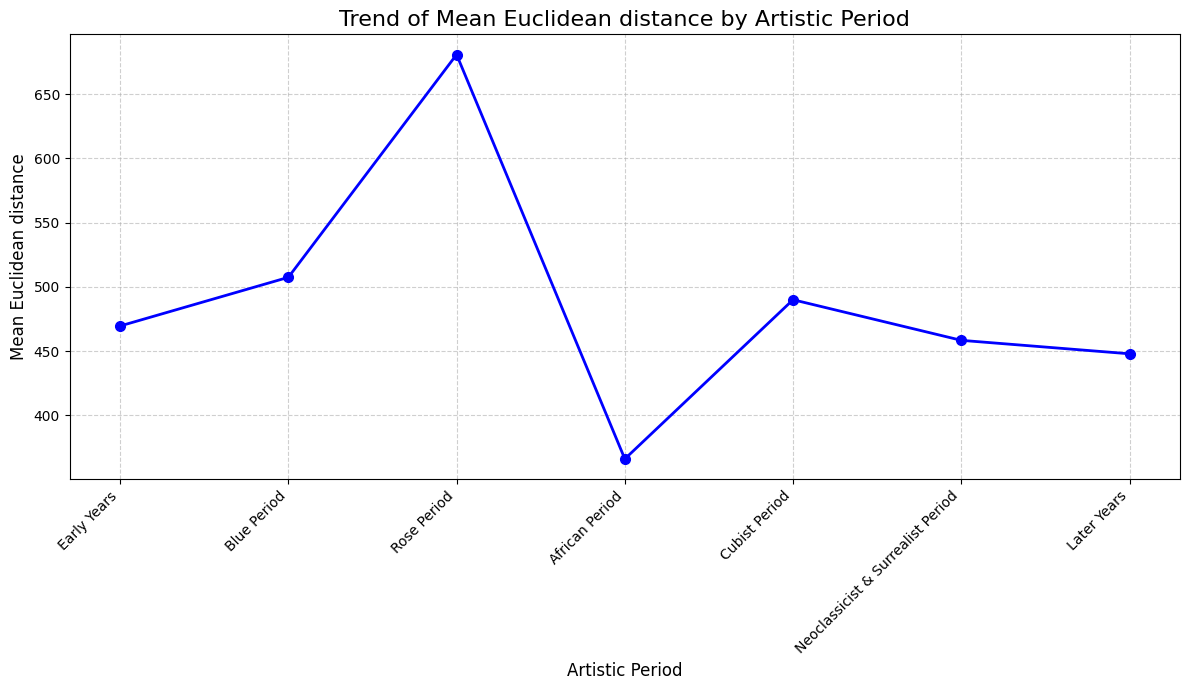

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Non strettamente necessario per questo plot, ma utile in generale

# Carica il DataFrame
# MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')

# --- Stili ordinati cronologicamente ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Definisci le feature (le 4 metriche)
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

# --- DataFrame Preparation ---
# 1. Ensure feature columns are numeric and handle NaNs
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Remove rows with NaN in features or 'Period' column (assuming 'Style' in comments means 'Period')
# Note: Your code uses 'Period' for the column name, which is consistent with previous scripts.
df.dropna(subset=features + ['Period'], inplace=True)

# 3. Set 'Period' column as a categorical type with the desired order
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

# 4. Calculate the mean of each feature for each period
mean_metrics_by_style = df.groupby('Period')[features].mean().reindex(ordered_styles)

# Remove any periods that had no data (if .reindex introduced NaNs for them)
mean_metrics_by_style.dropna(inplace=True)


# --- Plotting Trends for Each Metric ---
for feature in features:
    plt.figure(figsize=(12, 7)) # Figure size
    
    # Plot the line connecting mean values
    plt.plot(mean_metrics_by_style.index, mean_metrics_by_style[feature], 
             marker='o', # Points for each style
             color='blue', # Line and point color
             linestyle='-', # Solid line
             linewidth=2, # Line thickness
             markersize=7 # Point size
            )
    
    plt.title(f'Trend of Mean {feature} by Artistic Period', fontsize=16)
    plt.xlabel('Artistic Period', fontsize=12)
    plt.ylabel(f'Mean {feature}', fontsize=12)
    
    # Rotate X-axis labels for better readability if they are long
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    plt.grid(True, linestyle='--', alpha=0.6) # Grid with transparency
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

In [ ]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# Carica il DataFrame
try:
    df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')
    print("CSV 'metrics_with_year_and_period_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_year_and_period_no_outlier.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# --- Periodi ordinati cronologicamente ---
ordered_Periods = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

print(f"Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:\n{ordered_Periods}\n")

# Definisci le feature da analizzare
features = ["Fractal dimension", "Entropy", "Birkhoff measure", "Euclidean distance"]

results = []

for i in range(len(ordered_Periods) - 1):
    Period1 = ordered_Periods[i]
    Period2 = ordered_Periods[i + 1]

    print(f"\n--- Analisi per la coppia: ({Period1}, {Period2}) ---")

    subset = df[df["Period"].isin([Period1, Period2])].copy()
    
    initial_subset_rows = len(subset)
    
    for col in features:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')
    
    subset.dropna(subset=features + ['Period'], inplace=True)

    if len(subset) < initial_subset_rows:
        print(f"  Avviso: Rimosse {initial_subset_rows - len(subset)} righe con NaN nelle feature per ({Period1}, {Period2}).")
    
    counts_after_clean = subset["Period"].value_counts()
    
    if len(counts_after_clean) < 2 or any(counts_after_clean < 2):
        print(f"  Saltando la coppia ({Period1}, {Period2}) dopo pulizia NaN: dati insufficienti per l'analisi (almeno 2 per gruppo necessari).")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Dati insufficienti o un solo periodo presente."
        })
        continue
    
    has_zero_variance = False
    for period_val in counts_after_clean.index:
        period_data = subset[subset['Period'] == period_val]
        for feature in features:
            if period_data[feature].var() == 0:
                print(f"  Attenzione: La feature '{feature}' ha varianza zero nel periodo '{period_val}'. Questo può causare problemi nella MANOVA.")
                has_zero_variance = True
                break
        if has_zero_variance:
            break

    if has_zero_variance:
        print(f"  Saltando la coppia ({Period1}, {Period2}) a causa di varianza zero in una o più feature.")
        results.append({
            "Period_1": Period1,
            "Period_2": Period2,
            "MANOVA_p_value": float('nan'),
            "Significant_features_ANOVA": "Varianza zero in una feature."
        })
        continue

    subset['Period'] = pd.Categorical(subset['Period'])

    formula_manova = " + ".join([f"Q('{col}')" for col in features]) + " ~ C(Period)"
    
    p_manova = float('nan')
    significant_features = []

    try:
        manova = MANOVA.from_formula(formula_manova, data=subset)
        result = manova.mv_test()
        
        manova_term_key = None
        for key in result.results.keys():
            if "Period" in key and key != 'Intercept':
                manova_term_key = key
                break
        
        if manova_term_key and 'stat' in result.results[manova_term_key] and isinstance(result.results[manova_term_key]['stat'], pd.DataFrame):
            if "Wilks' lambda" in result.results[manova_term_key]['stat'].index:
                p_manova = result.results[manova_term_key]['stat'].loc["Wilks' lambda", 'Pr > F']
                print(f"  MANOVA (Wilks' lambda) p-value estratto: {p_manova:.4f} (Termine: '{manova_term_key}')")
            else:
                print(f"  Chiave 'Wilks\\' lambda' non trovata nell'output statistico della MANOVA per ({Period1}, {Period2}).")
        else:
            print(f"  Chiave di termine MANOVA ('Period' o 'C(Period)') non trovata o formato inatteso nell'output MANOVA per ({Period1}, {Period2}). Chiavi disponibili: {list(result.results.keys())}")

    except Exception as e:
        print(f"  Errore critico durante la MANOVA per ({Period1}, {Period2}): {e}")
        p_manova = float('nan') 

    if not np.isnan(p_manova) and p_manova < 0.05:
        print(f"  MANOVA significativa (p={p_manova:.4f}). Eseguo ANOVA univariata...")
        for feature in features:
            formula_anova = f"Q('{feature}') ~ C(Period)"
            try:
                model = ols(formula_anova, data=subset).fit()
                
                # --- MODIFICA CRUCIALE QUI PER L'ANOVA UNVARIATA ---
                anova_p_value_found = False
                for p_idx in model.pvalues.index:
                    # Cerca un termine che inizi con 'C(Period)'
                    if str(p_idx).startswith('C(Period)'):
                        p_anova = model.pvalues[p_idx]
                        if p_anova < 0.05:
                            significant_features.append(f"{feature} (p={p_anova:.4f})")
                        anova_p_value_found = True
                        break # Trovato il p-value per questa feature, passa alla prossima
                
                if not anova_p_value_found:
                    print(f"    Avviso: Termine significativo per 'C(Period)' non trovato nei p-value del modello ANOVA per '{feature}' in ({Period1}, {Period2}). P-values disponibili: {model.pvalues.index.tolist()}")

            except Exception as e:
                print(f"  Errore durante l'ANOVA per {feature} nella coppia ({Period1}, {Period2}): {e}")
    elif not np.isnan(p_manova): 
        print(f"  MANOVA non significativa (p={p_manova:.4f}). Saltando le ANOVA univariata.")
    else: 
        print(f"  MANOVA fallita o p-value non disponibile.")

    results.append({
        "Period_1": Period1,
        "Period_2": Period2,
        "MANOVA_p_value": p_manova,
        "Significant_features_ANOVA": ", ".join(significant_features) if significant_features else "Nessuna"
    })

df_results = pd.DataFrame(results)
output_csv_path = "manova_analysis_by_period.csv"
df_results.to_csv(output_csv_path, index=False)

print(f"\nAnalisi completata. I risultati sono stati salvati in '{output_csv_path}'")

CSV 'metrics_with_year_and_period_no_outlier.csv' caricato con successo.
Eseguendo l'analisi per le seguenti coppie consecutive di periodi, basate sull'ordine:
['Early Years', 'Blue Period', 'Rose Period', 'African Period', 'Cubist Period', 'Neoclassicist & Surrealist Period', 'Later Years']


--- Analisi per la coppia: (Early Years, Blue Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (Blue Period, Rose Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (Rose Period, African Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termine: 'C(Period)')
  MANOVA significativa (p=0.0000). Eseguo ANOVA univariata...

--- Analisi per la coppia: (African Period, Cubist Period) ---
  MANOVA (Wilks' lambda) p-value estratto: 0.0000 (Termin

# **STEP 9: (NORMALIZZATA) VISUALIZZAZIONE 3D**

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D

# --- Configuration and Data Loading ---
file_path = '.\\normalized_metrics_with_details_no_outlier.csv'

try:
    # Specify decimal=',' for CSV reading
    df = pd.read_csv(file_path, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# --- Original ordered styles (NOT MODIFIED HERE) ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period", # Kept original name for data processing
    "Later Years"
]

df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
all_metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# Ensure all metric columns are numeric before grouping and calculating means
for col in all_metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any of the metrics or Period is NaN, as mean calculation would be affected
df.dropna(subset=all_metrics + ['Period'], inplace=True)

df_means_all = df.groupby('Period')[all_metrics].mean().reindex(ordered_styles).dropna()

if len(df_means_all) != len(ordered_styles):
    print("Warning: Some styles in the ordered list might be missing from the data or have no valid metric values.")
    print("Styles used for analysis:\n", df_means_all.index.tolist())

# --- Mapping for display names (ONLY FOR PLOTS) ---
display_style_names = {
    "Neoclassicist & Surrealist Period": "Neo. & Sur. Period"
}

# --- 1. Dendrogram (Hierarchical Clustering) ---
plt.figure(figsize=(10, 7))

# Create labels for the dendrogram using the display names
dendrogram_labels = [display_style_names.get(style, style) for style in df_means_all.index.tolist()]

linked = linkage(df_means_all[['Fractal dimension', 'Entropy']].values, method='ward')
dendrogram(linked,
           orientation='top',
           labels=dendrogram_labels, # Use display names here
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Picasso\'s Styles (Based on Fractal Dimension and Entropy)')
plt.ylabel('Distance')
plt.xlabel('Artistic Period')
plt.axhline(y=0.5, color='r', linestyle='--', label='Bifurcation Threshold (Example)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. 3D Scatter Plots with Chronological Trajectory ---
metric_combinations = list(combinations(all_metrics, 3))

rotation_angles = [
    {'elev': 40, 'azim': -10},
    {'elev': 40, 'azim': 45},
    {'elev': 35, 'azim': 120},
    {'elev': 25, 'azim': -135}
]

for i, combo in enumerate(metric_combinations):
    combo_cols = list(combo)

    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    if i < len(rotation_angles):
        ax.view_init(elev=rotation_angles[i]['elev'], azim=rotation_angles[i]['azim'])

    # Calculate dynamic axis limits for this metric combination
    min_x, max_x = df_means_all[combo_cols[0]].min(), df_means_all[combo_cols[0]].max()
    min_y, max_y = df_means_all[combo_cols[1]].min(), df_means_all[combo_cols[1]].max()
    min_z, max_z = df_means_all[combo_cols[2]].min(), df_means_all[combo_cols[2]].max()

    # Add a small margin for better visualization
    margin_x = 0.05 * (max_x - min_x) if (max_x - min_x) > 0 else 0.05
    ax.set_xlim(min_x - margin_x, max_x + margin_x)
    
    margin_y = 0.05 * (max_y - min_y) if (max_y - min_y) > 0 else 0.05
    ax.set_ylim(min_y - margin_y, max_y + margin_y)
    
    margin_z = 0.05 * (max_z - min_z) if (max_z - min_z) > 0 else 0.05
    ax.set_zlim(min_z - margin_z, max_z + margin_z)

    # Plot each style as a point and add text label with coordinates
    for style in df_means_all.index:
        x, y, z = df_means_all.loc[style, combo_cols]
        ax.scatter(x, y, z, s=200, label=style, zorder=5)

        # Get the display name for the current style
        display_style = display_style_names.get(style, style) # Use display name here

        # Format coordinates to two decimal places
        coords_text = f"({x:.2f}, {y:.2f}, {z:.2f})"
        # Add a small offset to Z to prevent text overlapping
        ax.text(x, y, z + (ax.get_zlim()[1] - ax.get_zlim()[0]) * 0.02, 
                f"{display_style}\n{coords_text}", fontsize=9, ha='center', va='bottom') # Use display name here

    # Add chronological arrows
    for j in range(len(df_means_all) - 1):
        style1 = df_means_all.index[j]
        style2 = df_means_all.index[j+1]

        x1, y1, z1 = df_means_all.loc[style1, combo_cols]
        x2, y2, z2 = df_means_all.loc[style2, combo_cols]

        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='-', linewidth=1, alpha=0.7)

    ax.set_title(f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})')
    ax.set_xlabel(f'{combo[0]}')
    ax.set_ylabel(f'{combo[1]}')
    ax.set_zlabel(f'{combo[2]}')

    plt.tight_layout()
    plt.show()

# **STEP 9.1: VISUALIZZAZIONE 3D**

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D

# --- Configuration and Data Loading ---
file_path = '.\\metrics_with_details_no_outlier.csv'

try:
    # Specify decimal=',' for CSV reading
    df = pd.read_csv(file_path, decimal=',')
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading CSV file: {e}")
    exit()

# --- Original ordered styles (NOT MODIFIED HERE) ---
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period", # Kept original name for data processing
    "Later Years"
]

df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)
all_metrics = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# Ensure all metric columns are numeric before grouping and calculating means
for col in all_metrics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where any of the metrics or Period is NaN, as mean calculation would be affected
df.dropna(subset=all_metrics + ['Period'], inplace=True)

df_means_all = df.groupby('Period')[all_metrics].mean().reindex(ordered_styles).dropna()

if len(df_means_all) != len(ordered_styles):
    print("Warning: Some styles in the ordered list might be missing from the data or have no valid metric values.")
    print("Styles used for analysis:\n", df_means_all.index.tolist())

# --- Mapping for display names (ONLY FOR PLOTS) ---
display_style_names = {
    "Neoclassicist & Surrealist Period": "Neo. & Sur. Period"
}

# --- 1. Dendrogram (Hierarchical Clustering) ---
plt.figure(figsize=(10, 7))

# Create labels for the dendrogram using the display names
dendrogram_labels = [display_style_names.get(style, style) for style in df_means_all.index.tolist()]

linked = linkage(df_means_all[['Fractal dimension', 'Entropy']].values, method='ward')
dendrogram(linked,
           orientation='top',
           labels=dendrogram_labels, # Use display names here
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram of Picasso\'s Styles (Based on Fractal Dimension and Entropy)')
plt.ylabel('Distance')
plt.xlabel('Artistic Period')
plt.axhline(y=0.5, color='r', linestyle='--', label='Bifurcation Threshold (Example)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. 3D Scatter Plots with Chronological Trajectory ---
metric_combinations = list(combinations(all_metrics, 3))

rotation_angles = [
    {'elev': 40, 'azim': -10},
    {'elev': 40, 'azim': 45},
    {'elev': 35, 'azim': 120},
    {'elev': 25, 'azim': -135}
]

for i, combo in enumerate(metric_combinations):
    combo_cols = list(combo)

    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    if i < len(rotation_angles):
        ax.view_init(elev=rotation_angles[i]['elev'], azim=rotation_angles[i]['azim'])

    # Calculate dynamic axis limits for this metric combination
    min_x, max_x = df_means_all[combo_cols[0]].min(), df_means_all[combo_cols[0]].max()
    min_y, max_y = df_means_all[combo_cols[1]].min(), df_means_all[combo_cols[1]].max()
    min_z, max_z = df_means_all[combo_cols[2]].min(), df_means_all[combo_cols[2]].max()

    # Add a small margin for better visualization
    margin_x = 0.05 * (max_x - min_x) if (max_x - min_x) > 0 else 0.05
    ax.set_xlim(min_x - margin_x, max_x + margin_x)
    
    margin_y = 0.05 * (max_y - min_y) if (max_y - min_y) > 0 else 0.05
    ax.set_ylim(min_y - margin_y, max_y + margin_y)
    
    margin_z = 0.05 * (max_z - min_z) if (max_z - min_z) > 0 else 0.05
    ax.set_zlim(min_z - margin_z, max_z + margin_z)

    # Plot each style as a point and add text label with coordinates
    for style in df_means_all.index:
        x, y, z = df_means_all.loc[style, combo_cols]
        ax.scatter(x, y, z, s=200, label=style, zorder=5)

        # Get the display name for the current style
        display_style = display_style_names.get(style, style) # Use display name here

        # Format coordinates to two decimal places
        coords_text = f"({x:.2f}, {y:.2f}, {z:.2f})"
        # Add a small offset to Z to prevent text overlapping
        ax.text(x, y, z + (ax.get_zlim()[1] - ax.get_zlim()[0]) * 0.02, 
                f"{display_style}\n{coords_text}", fontsize=9, ha='center', va='bottom') # Use display name here

    # Add chronological arrows
    for j in range(len(df_means_all) - 1):
        style1 = df_means_all.index[j]
        style2 = df_means_all.index[j+1]

        x1, y1, z1 = df_means_all.loc[style1, combo_cols]
        x2, y2, z2 = df_means_all.loc[style2, combo_cols]

        ax.plot([x1, x2], [y1, y2], [z1, z2], color='black', linestyle='-', linewidth=1, alpha=0.7)

    ax.set_title(f'Evolutionary Path of Picasso\'s Styles (Space of {", ".join(combo)})')
    ax.set_xlabel(f'{combo[0]}')
    ax.set_ylabel(f'{combo[1]}')
    ax.set_zlabel(f'{combo[2]}')

    plt.tight_layout()
    plt.show()

# **STEP 10: (NORMALIZZATA) VISUALIZZAZIONE BOX**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Esempio di creazione di un DataFrame fittizio simile al tuo CSV
# Assicurati che i nomi delle colonne nel tuo CSV corrispondano esattamente a questi.
try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    data = pd.read_csv('.\\normalized_metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'metrics_by_period.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Early Years', 'Blue Period']

# Colonne per le metriche
x_mean_col = 'Euclidean distance_Mean'
x_std_col = 'Euclidean distance_Std_Dev'
y_mean_col = 'Entropy_Mean'
y_std_col = 'Entropy_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {'Early Years': 'blue', 'Blue Period': 'red'}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Avviso: Nessun dato trovato per lo stile '{style}'. Saltando il plot per questo stile.")
        continue

    # Calcola la media delle medie e la media delle deviazioni standard
    # Se hai più righe per lo stesso stile, questo calcolerà un rettangolo "medio"
    # Se ogni stile ha solo una riga (come ci aspettiamo da metrics_by_period.csv), userà direttamente quei valori
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    # Angolo in basso a sinistra (x_min, y_min)
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    # Larghezza e altezza del rettangolo (2 volte la deviazione standard)
    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Etichetta per la legenda
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Media)'))


# Imposta gli assi
ax.set_xlabel('Euclidean distance (Mean ± Std Dev)')
ax.set_ylabel('Entropy (Mean ± Std Dev)')
ax.set_title(f'Euclidean distance and Entropy for Early Years and Blue Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
plt.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
data = pd.read_csv('.\\normalized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# --- INIZIO MODIFICA QUI ---
# Stili da includere nel plot: Blue Period e Rose Period
styles_to_plot = ['Blue Period', 'Rose Period']

# Colori per i diversi stili
# Assicurati di aggiungere il colore per 'Rose Period'
style_colors = {'Blue Period': 'blue', 'Rose Period': 'purple'}
# --- FINE MODIFICA QUI ---

# Colonne per le metriche (rimangono le stesse)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Etichetta per la legenda
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean Value)'))


# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Blue Period and Rose Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
plt.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\normalized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Rose Period', 'African Period']

# Colonne per le metriche
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
# Assicurati di aggiungere colori per tutti gli stili in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green', # Colore aggiunto per African Period
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centro {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Rose Period and African Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\normalized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# --- INIZIO MODIFICA QUI ---
# Stili da includere nel plot
styles_to_plot = ['African Period', 'Cubist Period']

# Colori per i diversi stili
# Assicurati di aggiungere colori per tutti gli stili in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange', # Colore aggiunto per Cubist Period
    # Aggiungi altri stili e colori se necessario
}
# --- FINE MODIFICA QUI ---

# Colonne per le metriche (rimangono le stesse)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Media ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for African Period and Cubist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\normalized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Cubist Period', 'Neoclassicist & Surrealist Period']

# Colonne per le metriche (Entropy sull'asse X, Euclidean Distance sull'asse Y)
x_mean_col = 'Birkhoff measure_Mean'
x_std_col = 'Birkhoff measure_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown', # Colore per Neoclassicist & Surrealist Period
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Birkhoff measure (Mean ± Std Dev)')
ax.set_ylabel('Euclidean distance (Mean ± Std Dev)')
ax.set_title(f'Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\normlized_metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Neoclassicist & Surrealist Period', 'Later Years']

# Colonne per le metriche
x_mean_col = 'Entropy_Mean'
x_std_col = 'Entropy_Std_Dev'
y_mean_col = 'Fractal dimension_Mean'
y_std_col = 'Fractal dimension_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown',
    'Later Years': 'gray', # Colore aggiunto per Later Years
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Entropy (Mean ± Std Dev)')
ax.set_ylabel('Fractal dimension (Mean ± Std Dev)')
ax.set_title(f'Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

# **STEP 10.1: VISUALIZZAZIONE BOX**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Esempio di creazione di un DataFrame fittizio simile al tuo CSV
# Assicurati che i nomi delle colonne nel tuo CSV corrispondano esattamente a questi.
try:
    # MODIFICA QUI: Specifica decimal=',' per la lettura del CSV
    data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
    print("File 'metrics_by_period.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'metrics_by_period.csv' non è stato trovato. Assicurati che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Early Years', 'Blue Period']

# Colonne per le metriche
x_mean_col = 'Euclidean distance_Mean'
x_std_col = 'Euclidean distance_Std_Dev'
y_mean_col = 'Entropy_Mean'
y_std_col = 'Entropy_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {'Early Years': 'blue', 'Blue Period': 'red'}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Avviso: Nessun dato trovato per lo stile '{style}'. Saltando il plot per questo stile.")
        continue

    # Calcola la media delle medie e la media delle deviazioni standard
    # Se hai più righe per lo stesso stile, questo calcolerà un rettangolo "medio"
    # Se ogni stile ha solo una riga (come ci aspettiamo da metrics_by_period.csv), userà direttamente quei valori
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    # Angolo in basso a sinistra (x_min, y_min)
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    # Larghezza e altezza del rettangolo (2 volte la deviazione standard)
    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Etichetta per la legenda
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Media)'))


# Imposta gli assi
ax.set_xlabel('Euclidean distance (Mean ± Std Dev)')
ax.set_ylabel('Entropy (Mean ± Std Dev)')
ax.set_title(f'Euclidean distance and Entropy for Early Years and Blue Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
plt.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# --- INIZIO MODIFICA QUI ---
# Stili da includere nel plot: Blue Period e Rose Period
styles_to_plot = ['Blue Period', 'Rose Period']

# Colori per i diversi stili
# Assicurati di aggiungere il colore per 'Rose Period'
style_colors = {'Blue Period': 'blue', 'Rose Period': 'purple'}
# --- FINE MODIFICA QUI ---

# Colonne per le metriche (rimangono le stesse)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style}' # Etichetta per la legenda
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style], marker='o', s=150, zorder=5)

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=style))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markersize=10, label=f'Centroid {style} (Mean Value)'))


# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Blue Period and Rose Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
plt.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Rose Period', 'African Period']

# Colonne per le metriche
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
# Assicurati di aggiungere colori per tutti gli stili in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green', # Colore aggiunto per African Period
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centro {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for Rose Period and African Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# --- INIZIO MODIFICA QUI ---
# Stili da includere nel plot
styles_to_plot = ['African Period', 'Cubist Period']

# Colori per i diversi stili
# Assicurati di aggiungere colori per tutti gli stili in styles_to_plot
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange', # Colore aggiunto per Cubist Period
    # Aggiungi altri stili e colori se necessario
}
# --- FINE MODIFICA QUI ---

# Colonne per le metriche (rimangono le stesse)
x_mean_col = 'Fractal dimension_Mean'
x_std_col = 'Fractal dimension_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Media ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Fractal Dimension (Mean ± Std Dev)')
ax.set_ylabel('Euclidean Distance (Mean ± Std Dev)')
ax.set_title(f'Fractal dimension and Euclidean distance for African Period and Cubist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Cubist Period', 'Neoclassicist & Surrealist Period']

# Colonne per le metriche (Entropy sull'asse X, Euclidean Distance sull'asse Y)
x_mean_col = 'Birkhoff measure_Mean'
x_std_col = 'Birkhoff measure_Std_Dev'
y_mean_col = 'Euclidean distance_Mean'
y_std_col = 'Euclidean distance_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown', # Colore per Neoclassicist & Surrealist Period
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Birkhoff measure (Mean ± Std Dev)')
ax.set_ylabel('Euclidean distance (Mean ± Std Dev)')
ax.set_title(f'Birkhoff measure and Euclidean distance for Cubist Period and Neoclassicist & Surrealist Period')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Carica il tuo file CSV
# Assicurati che il percorso del file sia corretto e che i nomi delle colonne corrispondano
data = pd.read_csv('.\\metrics_by_period.csv', decimal=',')
df = pd.DataFrame(data)

# Stili da includere nel plot
styles_to_plot = ['Neoclassicist & Surrealist Period', 'Later Years']

# Colonne per le metriche
x_mean_col = 'Entropy_Mean'
x_std_col = 'Entropy_Std_Dev'
y_mean_col = 'Fractal dimension_Mean'
y_std_col = 'Fractal dimension_Std_Dev'

# Inizializza il plot
plt.figure(figsize=(10, 8))
ax = plt.gca() # Ottieni gli assi correnti per aggiungere i rettangoli

# Colori per i diversi stili
style_colors = {
    'Early Years': 'blue',
    'Blue Period': 'red',
    'Rose Period': 'purple',
    'African Period': 'green',
    'Cubist Period': 'orange',
    'Neoclassicist & Surrealist Period': 'brown',
    'Later Years': 'gray', # Colore aggiunto per Later Years
    # Aggiungi altri stili e colori se necessario
}

# Lista per la legenda
legend_handles = []

# Itera su ogni stile da plottare
for style in styles_to_plot:
    # Filtra i dati per lo stile corrente
    style_data = df[df['Period'] == style]

    # Controlla se ci sono dati per lo stile
    if style_data.empty:
        print(f"Attenzione: Nessun dato trovato per lo stile '{style}'. Controlla il nome dello stile nel tuo CSV.")
        continue # Passa allo stile successivo se non ci sono dati

    # Calcola la media delle medie e la media delle deviazioni standard per il rettangolo
    mean_x_center = style_data[x_mean_col].mean()
    mean_x_std = style_data[x_std_col].mean()
    mean_y_center = style_data[y_mean_col].mean()
    mean_y_std = style_data[y_std_col].mean()

    # Calcola le coordinate del rettangolo
    x_min = mean_x_center - mean_x_std
    y_min = mean_y_center - mean_y_std

    width = 2 * mean_x_std
    height = 2 * mean_y_std

    # Crea il rettangolo
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=style_colors[style], facecolor=style_colors[style], alpha=0.3,
        label=f'{style} (Mean Value ± Std Dev)'
    )
    ax.add_patch(rect)

    # Aggiungi un punto al centro del rettangolo per indicare la media
    ax.scatter(mean_x_center, mean_y_center, color=style_colors[style],
               marker='o', s=150, zorder=5, edgecolors='black', label=f'Centroid {style} (Mean Value)')

    # Aggiungi alla lista per la legenda
    legend_handles.append(plt.Line2D([0], [0], color=style_colors[style], lw=4, alpha=0.3, label=f'{style} (Mean Value ± Std Dev)'))
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=style_colors[style],
                                     markeredgecolor='black', markersize=10, label=f'Centroid {style} (Mean Value)'))

# Imposta gli assi
ax.set_xlabel('Entropy (Mean ± Std Dev)')
ax.set_ylabel('Fractal dimension (Mean ± Std Dev)')
ax.set_title(f'Entropy and Fractal dimension for Neoclassicist & Surrealist Period and Later Years')
ax.grid(True, linestyle='--', alpha=0.7)

# Assicurati che i limiti degli assi siano appropriati per includere tutti i rettangoli
ax.autoscale_view()

# Aggiungi una leggenda completa
# Rimuoviamo i duplicati dalle label per una leggenda più pulita
unique_labels = {}
for h in legend_handles:
    unique_labels[h.get_label()] = h
final_legend_handles = list(unique_labels.values())

plt.legend(handles=final_legend_handles)

plt.tight_layout()
plt.show()

# **STEP 11: K-MEANS CLUSTER**

# **STEP 12: (NORMALIZED) KERNEL DISTRIBUTION**

Created output directory: .\PLOT NORMALIZED\kde_plots
File '.\normalized_metrics_with_details_no_outlier.csv' loaded successfully.
Initial DataFrame (first 5 rows):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension   Entropy  Birkhoff measure  \
0  African Period           0.447462  0.843761          0.120752   
1  African Period           0.770182  0.668294          0.074257   
2  African Period           0.804270  0.900438          0.033868   
3  African Period           0.584566  0.780289          0.144558   
4  African Period           0.530998  0.921327          0.079052   


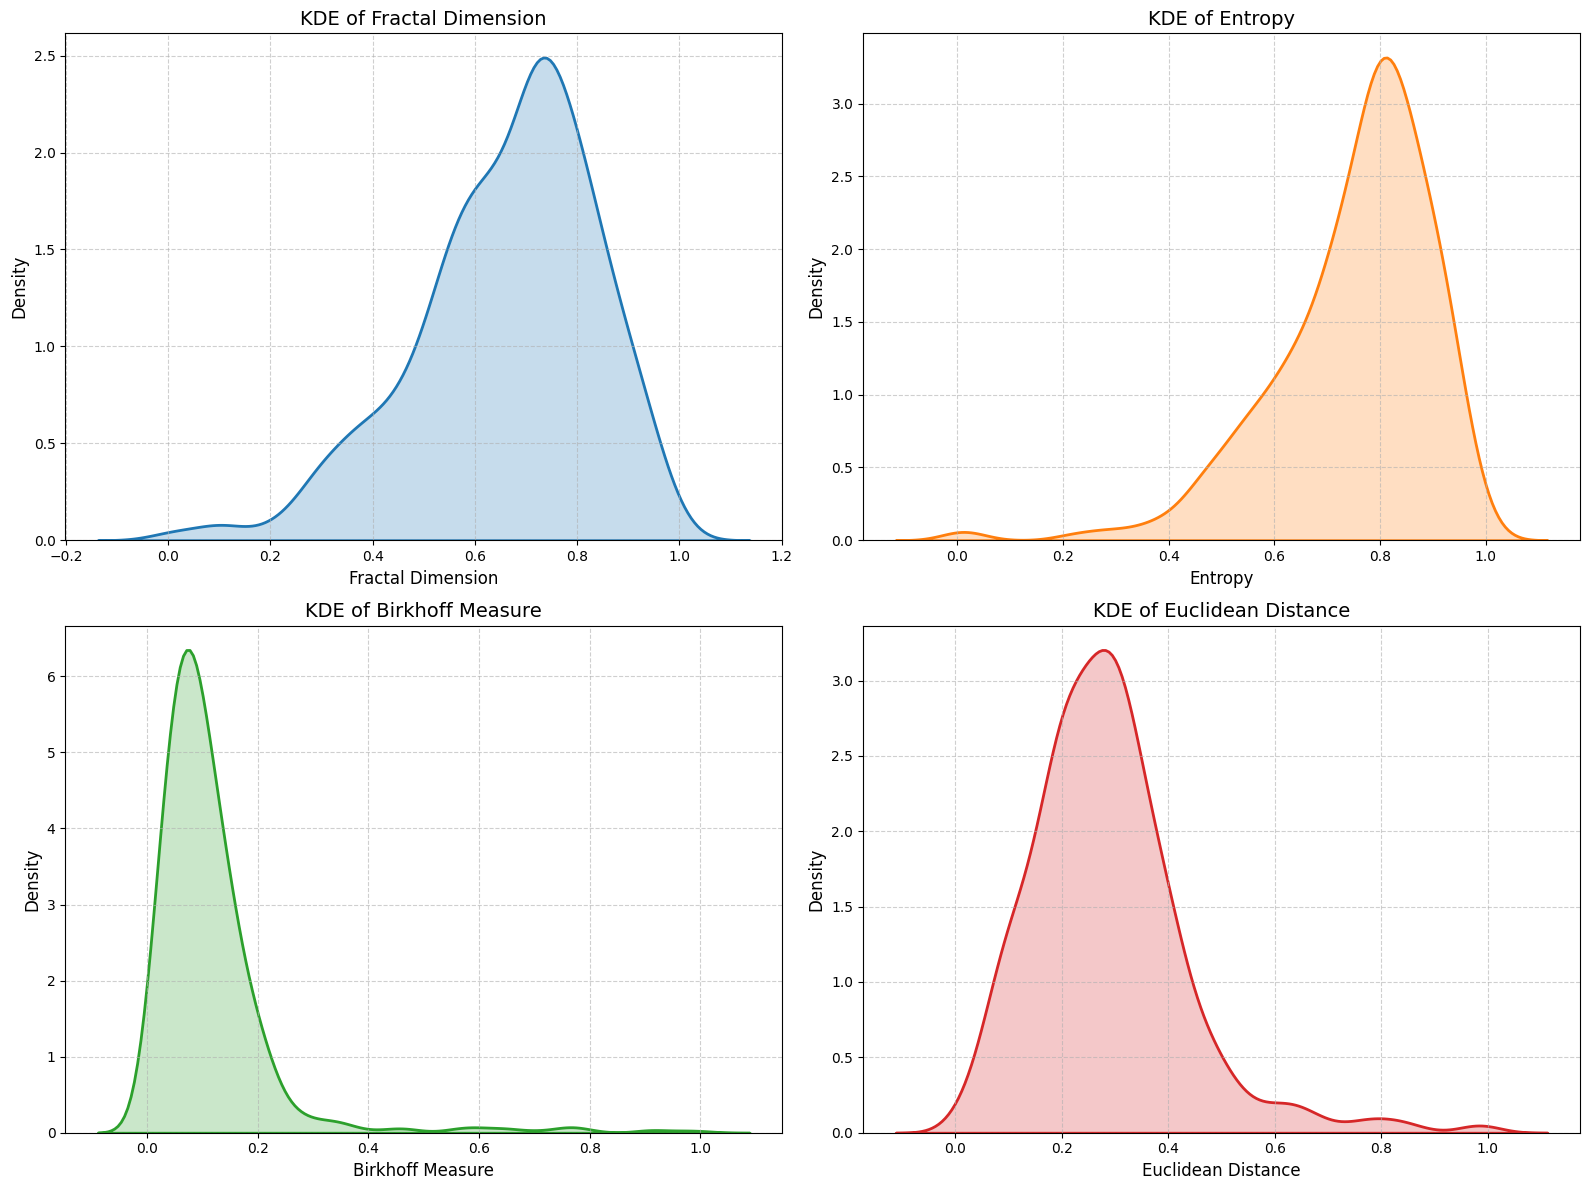

Generating bivariate KDE plots for all unique metric pairs...


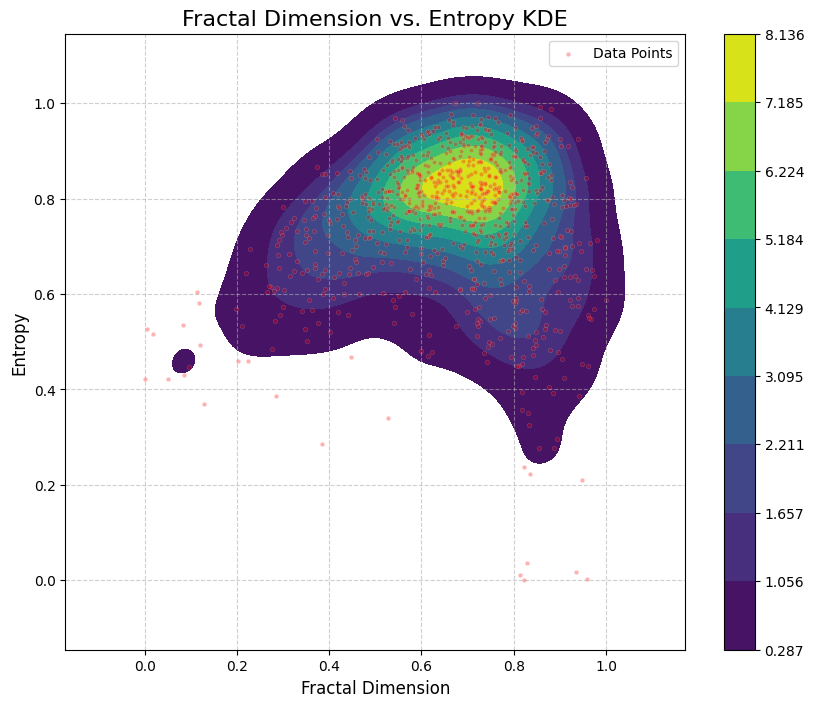

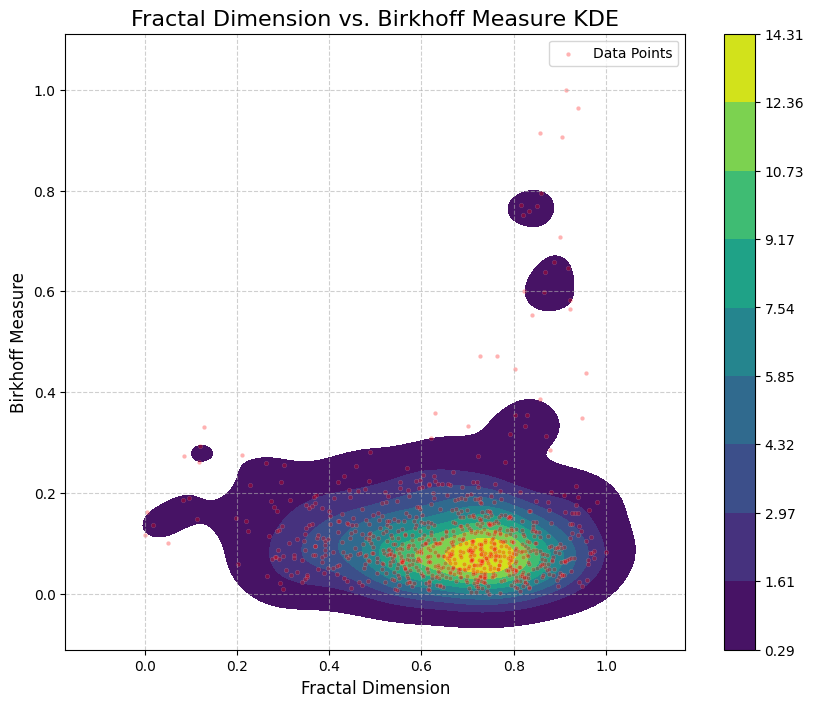

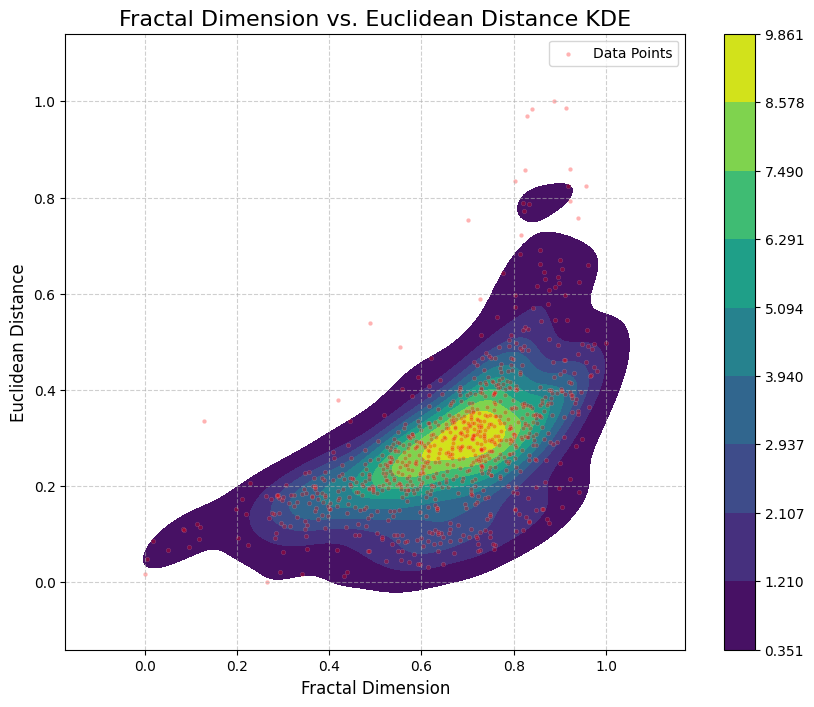

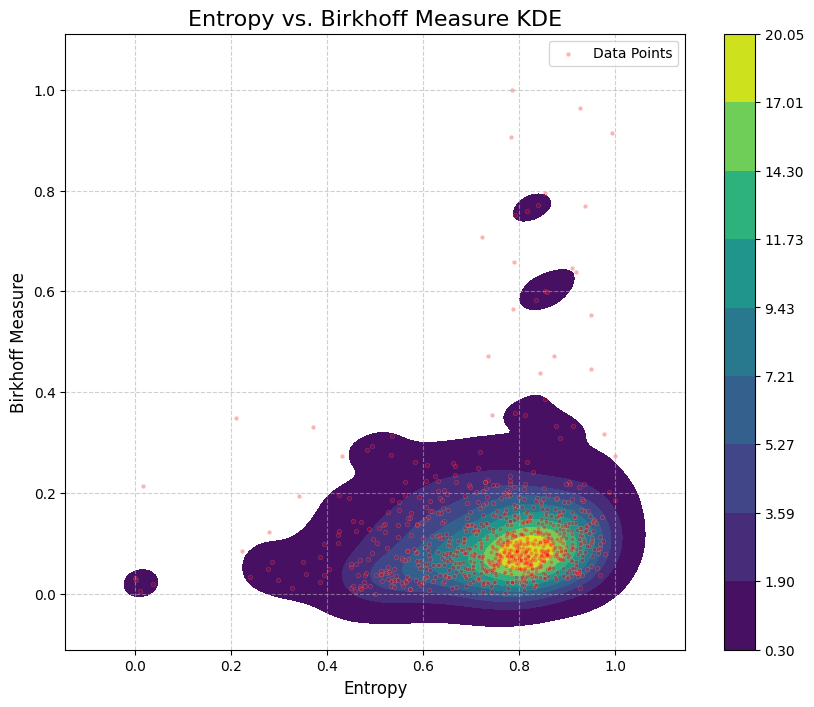

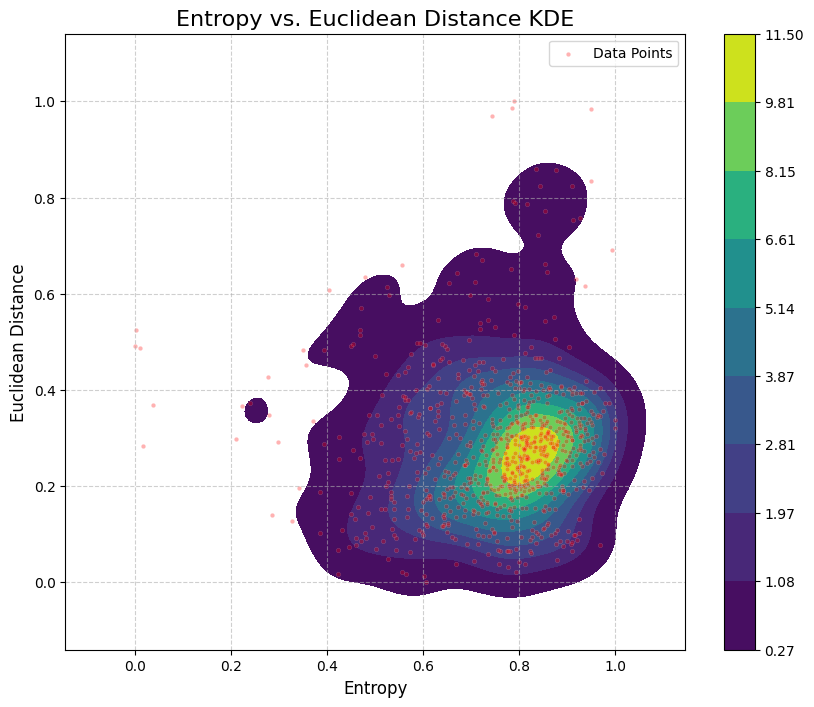

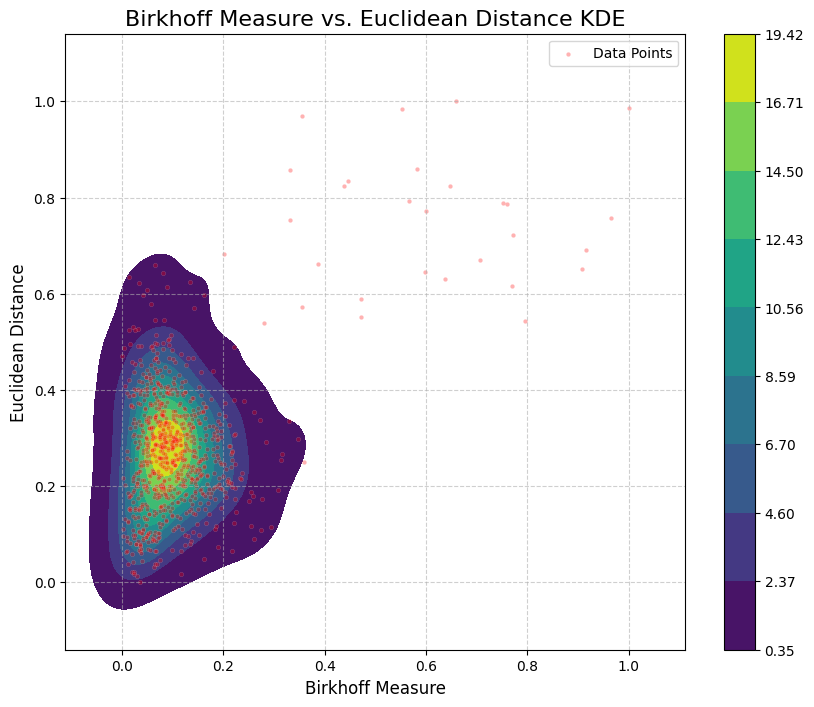

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module for path operations
from itertools import combinations # Import combinations for bivariate plots

# --- Configuration for file paths and output ---
file_path = ".\\normalized_metrics_with_details_no_outlier.csv"
output_plot_dir = ".\\PLOT NORMALIZED\\kde_plots" # Define an output directory for plots

# Create the output directory if it doesn't exist
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)
    print(f"Created output directory: {output_plot_dir}")

# -----------------------------------------------------------------------------
# 1. Data Preparation: Load DataFrame
# -----------------------------------------------------------------------------

try:
    df = pd.read_csv(file_path, decimal=',')
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numerical Features and Clean Data
# -----------------------------------------------------------------------------

features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
grouping_column = 'Period' # Ensure this is the correct column for your periods/styles

# Check for existence of grouping column
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name for artistic periods/styles.")

# Convert feature columns to numeric, coercing errors to NaN
original_features_copy = features.copy()
for col in original_features_copy:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. It will be ignored.")
        features.remove(col)
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().all():
            print(f"Warning: Column '{col}' contains only NaN values after conversion and will be ignored.")
            features.remove(col)

if not features:
    raise ValueError("No specified metric columns were found or contain valid numerical data after processing. Cannot proceed.")
else:
    print(f"Features selected for analysis: {features}")

# Create a cleaned DataFrame for KDE plots and also for Mahalanobis calculations
# This df_cleaned_for_kde will be used for all subsequent calculations and plots
df_cleaned_for_kde = df.dropna(subset=features).copy()
initial_rows_count = len(df)
if len(df_cleaned_for_kde) < initial_rows_count:
    print(f"Warning: Removed {initial_rows_count - len(df_cleaned_for_kde)} rows due to NaN values in feature columns.")

if df_cleaned_for_kde.empty:
    raise ValueError("DataFrame is empty after cleaning NaN values. Cannot proceed with calculations.")


# --- Define mappings for KDE plots (based on the cleaned 'features' list) ---
# Use 'features' list directly as CSV headers for KDE plots
all_metrics_csv_headers = features

# Dynamically create the mapping from actual column names to readable labels
# Assuming you want to display them nicely. If your CSV headers are already nice, you might simplify this.
metric_names_csv_to_english = {
    'Fractal dimension': 'Fractal Dimension',
    'Entropy': 'Entropy',
    'Birkhoff measure': 'Birkhoff Measure',
    'Euclidean distance': 'Euclidean Distance'
}
# Ensure all selected features have a mapping, add a default if not
for metric_header in all_metrics_csv_headers:
    if metric_header not in metric_names_csv_to_english:
        metric_names_csv_to_english[metric_header] = metric_header.replace('_', ' ').title()


# -----------------------------------------------------------------------------
# 3. Normalize Metrics (Min-Max Scaling between 0 and 1)
# -----------------------------------------------------------------------------

df_normalized = df_cleaned_for_kde.copy() # Start with the cleaned DataFrame

scaler = MinMaxScaler()

if not df_normalized[features].empty:
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    print("\nDataFrame with Normalized Metrics (Min-Max [0, 1]) (first 5 rows):")
    print(df_normalized.head())
else:
    print("\nWarning: No data to normalize after cleaning. Normalized DataFrame is empty.")
print("-" * 50)

# -----------------------------------------------------------------------------
# 4. Calculate Mahalanobis Distance on Normalized Data
# -----------------------------------------------------------------------------

df_normalized['Mahalanobis_Distance_Normalized'] = np.nan
mahalanobis_distances_map = {}

for period, group in df_normalized.groupby(grouping_column):
    print(f"\nProcessing Period: {period} 🎨")

    numeric_data_normalized = group[features]
    num_points = len(numeric_data_normalized)
    num_features = len(features)

    print(f"  Number of data points in this period: {num_points}")
    print(f"  Number of features: {num_features}")

    if num_points < num_features + 1:
        print(f"  Warning: Insufficient data points ({num_points}) for period '{period}' to compute a robust covariance matrix for {num_features} features. Mahalanobis distances will be NaN for this period.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    centroid_normalized = numeric_data_normalized.mean().values
    
    covariance_matrix_normalized = numeric_data_normalized.cov()
    
    cov_matrix_np = covariance_matrix_normalized.values

    if np.isnan(cov_matrix_np).any() or np.isinf(cov_matrix_np).any():
        print(f"  Error: Covariance matrix for period '{period}' contains NaN or Inf values. This might be due to insufficient non-NaN data or numerical instability. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        det_cov = np.linalg.det(cov_matrix_np)
        if det_cov == 0:
            print(f"  Warning: Covariance matrix for period '{period}' is singular (determinant is 0). Adding jitter to make it invertible.")
            cov_matrix_np += np.eye(cov_matrix_np.shape[0]) * 1e-6
            det_cov_after_jitter = np.linalg.det(cov_matrix_np)
            if det_cov_after_jitter == 0:
                 print(f"  Critical Error: Covariance matrix for period '{period}' remains singular even after adding jitter. Cannot invert. Distances will be NaN.")
                 for idx in group.index:
                    mahalanobis_distances_map[idx] = np.nan
                 continue
    except np.linalg.LinAlgError:
        print(f"  Error: Could not compute determinant of covariance matrix for period '{period}'. Setting distances to NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        inv_covariance_matrix_normalized = np.linalg.inv(cov_matrix_np)
    except np.linalg.LinAlgError as e:
        print(f"  Error: Could not invert covariance matrix for period '{period}' (after jitter): {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue
    except Exception as e:
        print(f"  Unexpected error during covariance matrix inversion for period '{period}': {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    for index, row in numeric_data_normalized.iterrows():
        point_normalized = row.values
        try:
            if np.isnan(point_normalized).any() or np.isinf(point_normalized).any():
                print(f"  Skipping Mahalanobis calculation for index {index} due to NaN/Inf in point data.")
                mahalanobis_distances_map[index] = np.nan
                continue

            dist = mahalanobis(point_normalized, centroid_normalized, inv_covariance_matrix_normalized)
            mahalanobis_distances_map[index] = dist
        except Exception as e:
            print(f"  Error calculating Mahalanobis distance for index {index} in period '{period}': {e}. Setting to NaN.")
            mahalanobis_distances_map[index] = np.nan

df_normalized['Mahalanobis_Distance_Normalized'] = df_normalized.index.map(mahalanobis_distances_map)

print("\nDataFrame with Individual Mahalanobis Distances (on normalized data [0, 1]) (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)

# -----------------------------------------------------------------------------
# 5. Calculate "Contextual Fit" (Inverse of Mahalanobis Distance)
# -----------------------------------------------------------------------------

epsilon = 1e-9
df_normalized['Contextual_Fit'] = 1 / (df_normalized['Mahalanobis_Distance_Normalized'] + epsilon)

df_normalized.loc[df_normalized['Mahalanobis_Distance_Normalized'].isna(), 'Contextual_Fit'] = np.nan

print("\nDataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)
print("Calculations complete!")

# -----------------------------------------------------------------------------
# 6. Calculate Mean and Standard Deviation of Mahalanobis Distance and Contextual Fit
# -----------------------------------------------------------------------------

mean_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].mean()
print("\nMean of Normalized Mahalanobis Distance [0, 1] per Period:")
print(mean_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

std_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].std()
print("Standard Deviation of Normalized Mahalanobis Distance [0, 1] per Period:")
print(std_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

mean_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].mean()
print("Mean of 'Contextual_Fit' per Period:")
print(mean_contextual_fit_by_period)

print("\n" + "-" * 50 + "\n")

std_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].std()
print("Standard Deviation of 'Contextual_Fit' per Period:")
print(std_contextual_fit_by_period)

print("\n" + "=" * 50 + "\n")


# --- NEW SECTION: Smooth Kernel Density Estimation (KDE) Plots ---
print("\nGenerating Smooth Kernel Density Estimation (KDE) Plots...")

# 2.1 Univariate KDE Plots for each metric in a 2x2 subplot
print("Generating a 2x2 subplot for univariate KDE plots for each metric...")

if not df_cleaned_for_kde.empty:
    colors = sns.color_palette("tab10", len(all_metrics_csv_headers))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, metric_header in enumerate(all_metrics_csv_headers):
        ax = axes[i]
        metric_english_label = metric_names_csv_to_english[metric_header]

        sns.kdeplot(data=df_cleaned_for_kde, x=metric_header, fill=True, color=colors[i], linewidth=2, ax=ax)
        ax.set_title(f'KDE of {metric_english_label}', fontsize=14)
        ax.set_xlabel(metric_english_label, fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    combined_kde_filename = 'all_univariate_kde_2x2_subplot.png'
    plt.savefig(os.path.join(output_plot_dir, combined_kde_filename))
    plt.show()
else:
    print("Skipping univariate KDE plots: No valid data after cleaning for metrics.")


# 2.2 Bivariate KDE Plots for all unique metric pairs
print("Generating bivariate KDE plots for all unique metric pairs...")
metric_pairs_kde_csv = list(combinations(all_metrics_csv_headers, 2))

if not df_cleaned_for_kde.empty and len(metric_pairs_kde_csv) > 0:
    for metric_x_csv, metric_y_csv in metric_pairs_kde_csv:
        metric_x_english_label = metric_names_csv_to_english[metric_x_csv]
        metric_y_english_label = metric_names_csv_to_english[metric_y_csv]

        plt.figure(figsize=(10, 8))
        sns.kdeplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, fill=True, cmap='viridis', cbar=True)
        # Adding data points for context
        sns.scatterplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, color='red', s=10, alpha=0.3, label='Data Points')
        plt.title(f'{metric_x_english_label} vs. {metric_y_english_label} KDE', fontsize=16) # Added 'KDE' to title
        plt.xlabel(metric_x_english_label, fontsize=12)
        plt.ylabel(metric_y_english_label, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        filename_x = metric_x_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename_y = metric_y_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename = f'kde_bivariate_{filename_x}_vs_{filename_y}.png'
        plt.savefig(os.path.join(output_plot_dir, filename))
        plt.show()
else:
    print("Skipping bivariate KDE plots: Not enough valid data or metrics (need at least 2) after cleaning.")

# **STEP 12.1 : KERNEL DISTRIBUTION**

File '.\metrics_with_details_no_outlier.csv' loaded successfully.
Initial DataFrame (first 5 rows):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension  Entropy  Birkhoff measure  \
0  African Period             1.6722   7.6362          203.8259   
1  African Period             1.8445   7.2876          129.8782   
2  African Period             1.8627   7.7488           65.6404   
3  African Period             1.7454   7.5101          241.6897   
4  African Period             1.7168   7.7903          137.5046   

   Euclidean distance  
0            368.4079  
1            572.6089 

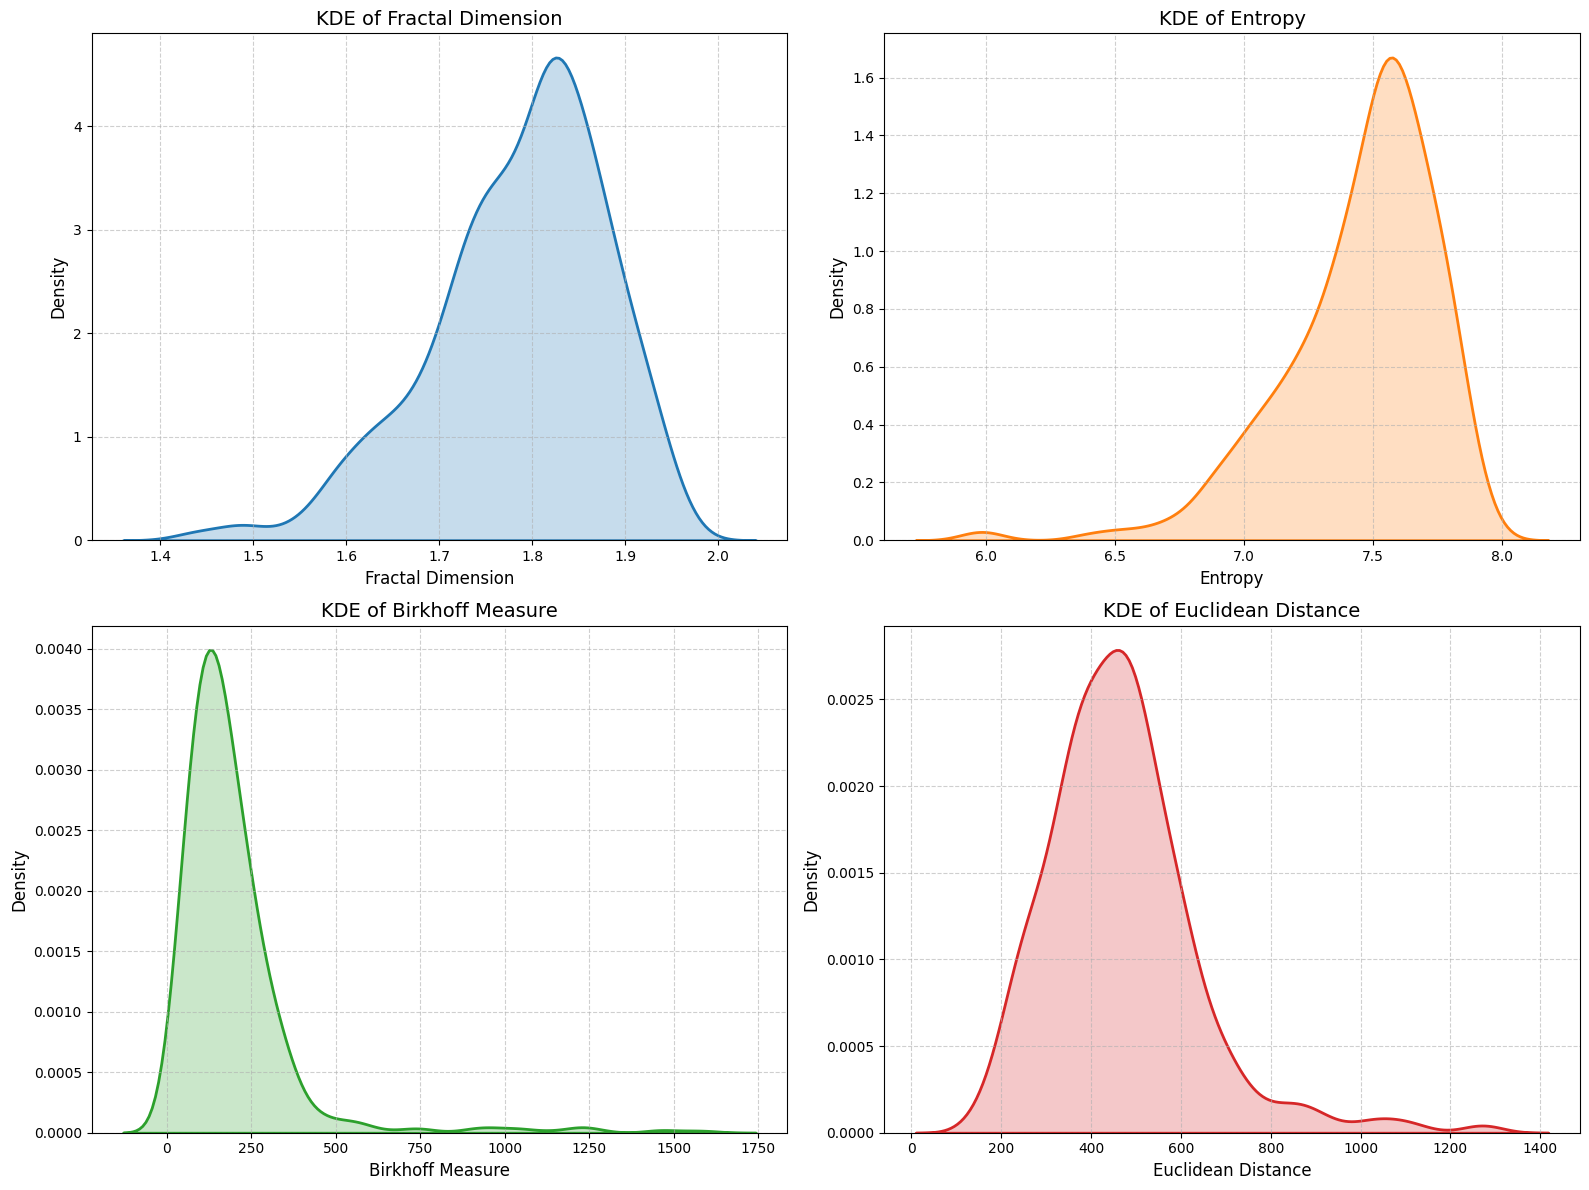

Generating bivariate KDE plots for all unique metric pairs...


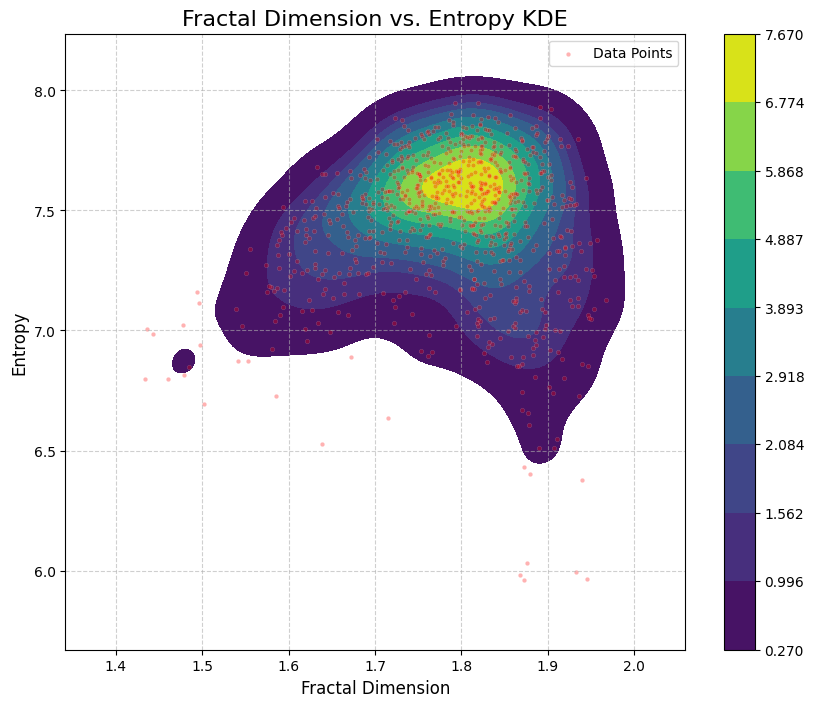

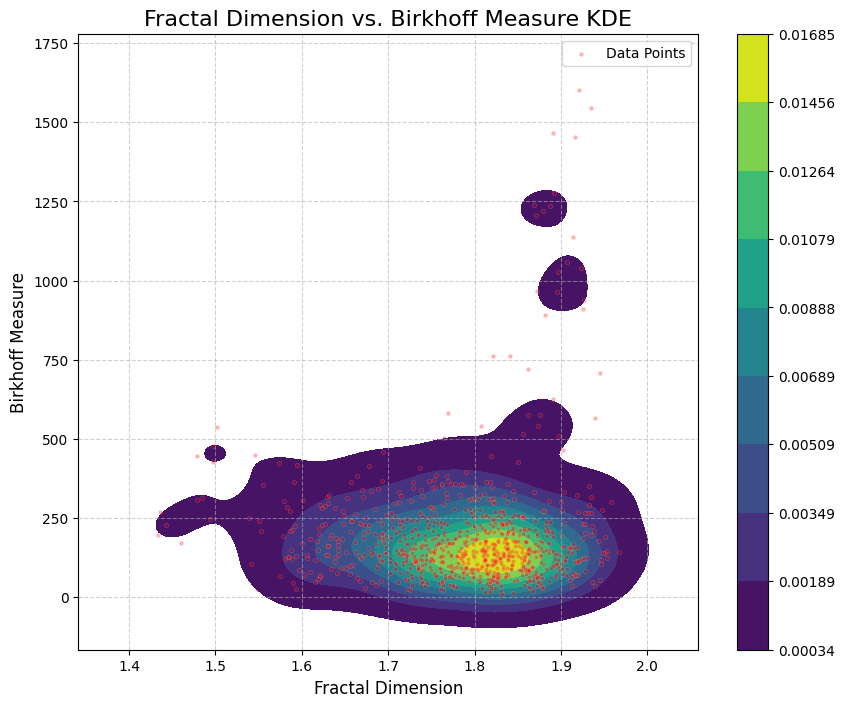

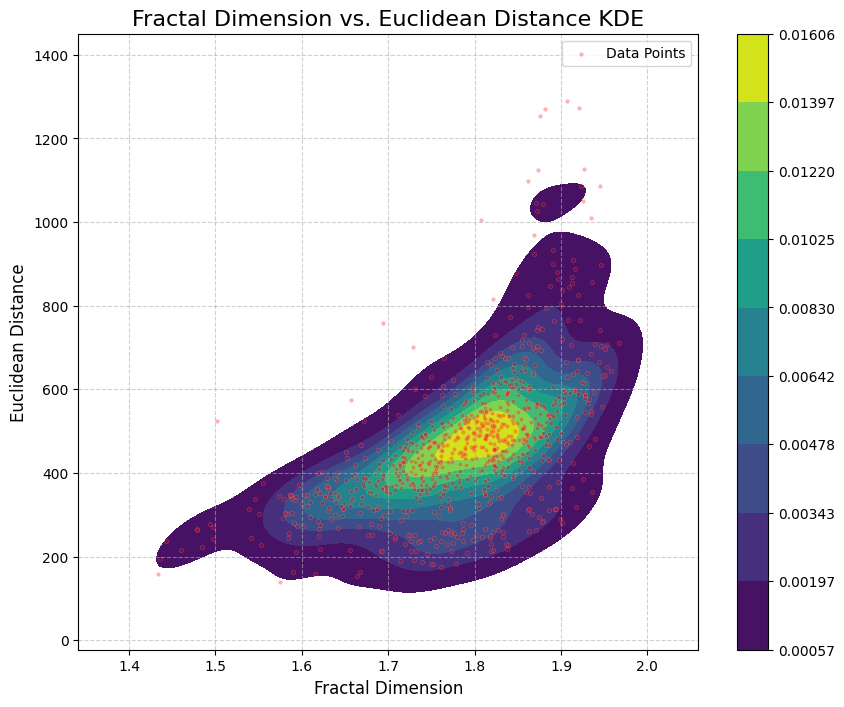

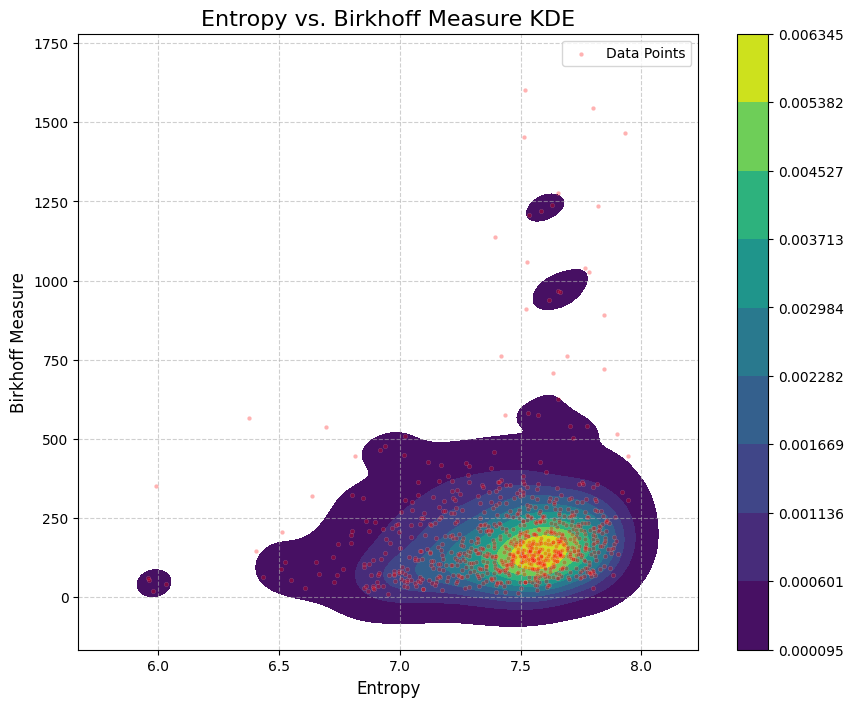

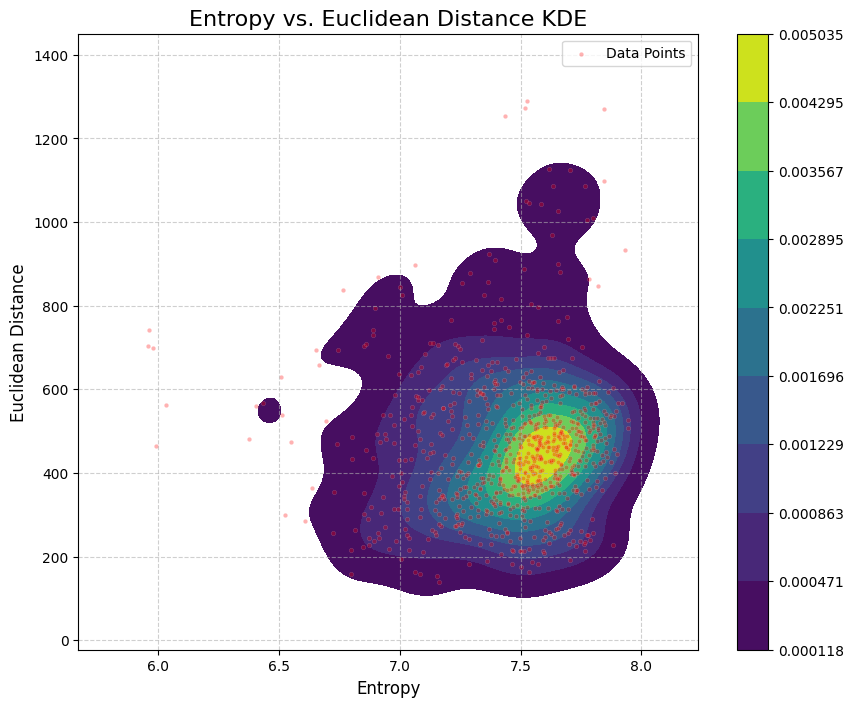

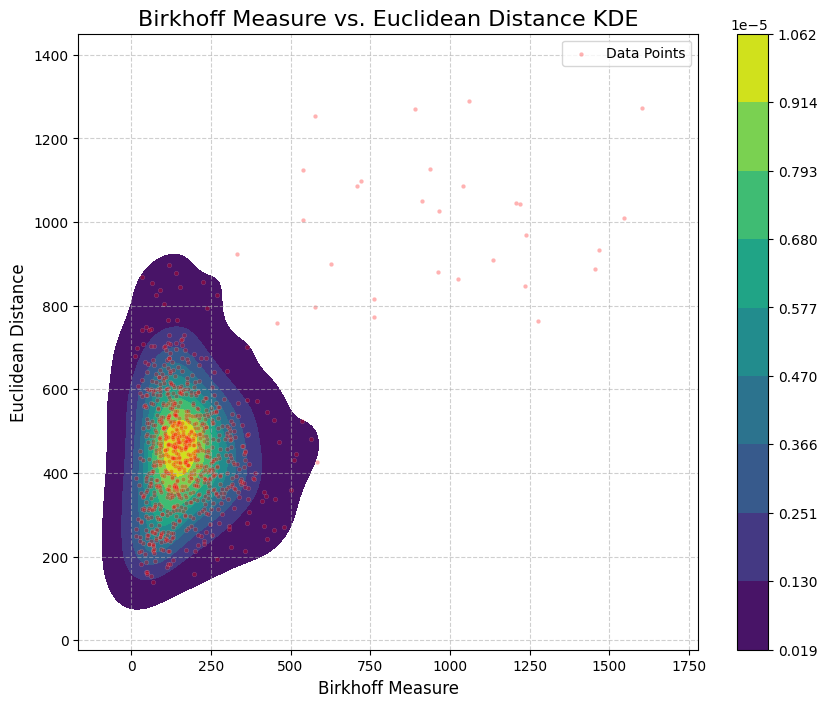

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module for path operations
from itertools import combinations # Import combinations for bivariate plots

# --- Configuration for file paths and output ---
file_path = ".\\metrics_with_details_no_outlier.csv"
output_plot_dir = ".\\PLOT\\kde_plots" # Define an output directory for plots

# Create the output directory if it doesn't exist
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)
    print(f"Created output directory: {output_plot_dir}")

# -----------------------------------------------------------------------------
# 1. Data Preparation: Load DataFrame
# -----------------------------------------------------------------------------

try:
    df = pd.read_csv(file_path, decimal=',')
    print(f"File '{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the file is in the same directory as the script or the path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")
    exit()

print("Initial DataFrame (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Define Numerical Features and Clean Data
# -----------------------------------------------------------------------------

features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']
grouping_column = 'Period' # Ensure this is the correct column for your periods/styles

# Check for existence of grouping column
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name for artistic periods/styles.")

# Convert feature columns to numeric, coercing errors to NaN
original_features_copy = features.copy()
for col in original_features_copy:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. It will be ignored.")
        features.remove(col)
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().all():
            print(f"Warning: Column '{col}' contains only NaN values after conversion and will be ignored.")
            features.remove(col)

if not features:
    raise ValueError("No specified metric columns were found or contain valid numerical data after processing. Cannot proceed.")
else:
    print(f"Features selected for analysis: {features}")

# Create a cleaned DataFrame for KDE plots and also for Mahalanobis calculations
# This df_cleaned_for_kde will be used for all subsequent calculations and plots
df_cleaned_for_kde = df.dropna(subset=features).copy()
initial_rows_count = len(df)
if len(df_cleaned_for_kde) < initial_rows_count:
    print(f"Warning: Removed {initial_rows_count - len(df_cleaned_for_kde)} rows due to NaN values in feature columns.")

if df_cleaned_for_kde.empty:
    raise ValueError("DataFrame is empty after cleaning NaN values. Cannot proceed with calculations.")


# --- Define mappings for KDE plots (based on the cleaned 'features' list) ---
# Use 'features' list directly as CSV headers for KDE plots
all_metrics_csv_headers = features

# Dynamically create the mapping from actual column names to readable labels
# Assuming you want to display them nicely. If your CSV headers are already nice, you might simplify this.
metric_names_csv_to_english = {
    'Fractal dimension': 'Fractal Dimension',
    'Entropy': 'Entropy',
    'Birkhoff measure': 'Birkhoff Measure',
    'Euclidean distance': 'Euclidean Distance'
}
# Ensure all selected features have a mapping, add a default if not
for metric_header in all_metrics_csv_headers:
    if metric_header not in metric_names_csv_to_english:
        metric_names_csv_to_english[metric_header] = metric_header.replace('_', ' ').title()


# -----------------------------------------------------------------------------
# 3. Normalize Metrics (Min-Max Scaling between 0 and 1)
# -----------------------------------------------------------------------------

df_normalized = df_cleaned_for_kde.copy() # Start with the cleaned DataFrame

scaler = MinMaxScaler()

if not df_normalized[features].empty:
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    print("\nDataFrame with Normalized Metrics (Min-Max [0, 1]) (first 5 rows):")
    print(df_normalized.head())
else:
    print("\nWarning: No data to normalize after cleaning. Normalized DataFrame is empty.")
print("-" * 50)

# -----------------------------------------------------------------------------
# 4. Calculate Mahalanobis Distance on Normalized Data
# -----------------------------------------------------------------------------

df_normalized['Mahalanobis_Distance_Normalized'] = np.nan
mahalanobis_distances_map = {}

for period, group in df_normalized.groupby(grouping_column):
    print(f"\nProcessing Period: {period} 🎨")

    numeric_data_normalized = group[features]
    num_points = len(numeric_data_normalized)
    num_features = len(features)

    print(f"  Number of data points in this period: {num_points}")
    print(f"  Number of features: {num_features}")

    if num_points < num_features + 1:
        print(f"  Warning: Insufficient data points ({num_points}) for period '{period}' to compute a robust covariance matrix for {num_features} features. Mahalanobis distances will be NaN for this period.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    centroid_normalized = numeric_data_normalized.mean().values
    
    covariance_matrix_normalized = numeric_data_normalized.cov()
    
    cov_matrix_np = covariance_matrix_normalized.values

    if np.isnan(cov_matrix_np).any() or np.isinf(cov_matrix_np).any():
        print(f"  Error: Covariance matrix for period '{period}' contains NaN or Inf values. This might be due to insufficient non-NaN data or numerical instability. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        det_cov = np.linalg.det(cov_matrix_np)
        if det_cov == 0:
            print(f"  Warning: Covariance matrix for period '{period}' is singular (determinant is 0). Adding jitter to make it invertible.")
            cov_matrix_np += np.eye(cov_matrix_np.shape[0]) * 1e-6
            det_cov_after_jitter = np.linalg.det(cov_matrix_np)
            if det_cov_after_jitter == 0:
                 print(f"  Critical Error: Covariance matrix for period '{period}' remains singular even after adding jitter. Cannot invert. Distances will be NaN.")
                 for idx in group.index:
                    mahalanobis_distances_map[idx] = np.nan
                 continue
    except np.linalg.LinAlgError:
        print(f"  Error: Could not compute determinant of covariance matrix for period '{period}'. Setting distances to NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    try:
        inv_covariance_matrix_normalized = np.linalg.inv(cov_matrix_np)
    except np.linalg.LinAlgError as e:
        print(f"  Error: Could not invert covariance matrix for period '{period}' (after jitter): {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue
    except Exception as e:
        print(f"  Unexpected error during covariance matrix inversion for period '{period}': {e}. Distances will be NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    for index, row in numeric_data_normalized.iterrows():
        point_normalized = row.values
        try:
            if np.isnan(point_normalized).any() or np.isinf(point_normalized).any():
                print(f"  Skipping Mahalanobis calculation for index {index} due to NaN/Inf in point data.")
                mahalanobis_distances_map[index] = np.nan
                continue

            dist = mahalanobis(point_normalized, centroid_normalized, inv_covariance_matrix_normalized)
            mahalanobis_distances_map[index] = dist
        except Exception as e:
            print(f"  Error calculating Mahalanobis distance for index {index} in period '{period}': {e}. Setting to NaN.")
            mahalanobis_distances_map[index] = np.nan

df_normalized['Mahalanobis_Distance_Normalized'] = df_normalized.index.map(mahalanobis_distances_map)

print("\nDataFrame with Individual Mahalanobis Distances (on normalized data [0, 1]) (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)

# -----------------------------------------------------------------------------
# 5. Calculate "Contextual Fit" (Inverse of Mahalanobis Distance)
# -----------------------------------------------------------------------------

epsilon = 1e-9
df_normalized['Contextual_Fit'] = 1 / (df_normalized['Mahalanobis_Distance_Normalized'] + epsilon)

df_normalized.loc[df_normalized['Mahalanobis_Distance_Normalized'].isna(), 'Contextual_Fit'] = np.nan

print("\nDataFrame with the new 'Contextual_Fit' column (first 10 rows):")
print(df_normalized.head(10))
print("-" * 50)
print("Calculations complete!")

# -----------------------------------------------------------------------------
# 6. Calculate Mean and Standard Deviation of Mahalanobis Distance and Contextual Fit
# -----------------------------------------------------------------------------

mean_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].mean()
print("\nMean of Normalized Mahalanobis Distance [0, 1] per Period:")
print(mean_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

std_mahalanobis_normalized_by_period = df_normalized.groupby(grouping_column)['Mahalanobis_Distance_Normalized'].std()
print("Standard Deviation of Normalized Mahalanobis Distance [0, 1] per Period:")
print(std_mahalanobis_normalized_by_period)

print("\n" + "-" * 50 + "\n")

mean_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].mean()
print("Mean of 'Contextual_Fit' per Period:")
print(mean_contextual_fit_by_period)

print("\n" + "-" * 50 + "\n")

std_contextual_fit_by_period = df_normalized.groupby(grouping_column)['Contextual_Fit'].std()
print("Standard Deviation of 'Contextual_Fit' per Period:")
print(std_contextual_fit_by_period)

print("\n" + "=" * 50 + "\n")


# --- NEW SECTION: Smooth Kernel Density Estimation (KDE) Plots ---
print("\nGenerating Smooth Kernel Density Estimation (KDE) Plots...")

# 2.1 Univariate KDE Plots for each metric in a 2x2 subplot
print("Generating a 2x2 subplot for univariate KDE plots for each metric...")

if not df_cleaned_for_kde.empty:
    colors = sns.color_palette("tab10", len(all_metrics_csv_headers))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, metric_header in enumerate(all_metrics_csv_headers):
        ax = axes[i]
        metric_english_label = metric_names_csv_to_english[metric_header]

        sns.kdeplot(data=df_cleaned_for_kde, x=metric_header, fill=True, color=colors[i], linewidth=2, ax=ax)
        ax.set_title(f'KDE of {metric_english_label}', fontsize=14)
        ax.set_xlabel(metric_english_label, fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    combined_kde_filename = 'all_univariate_kde_2x2_subplot.png'
    plt.savefig(os.path.join(output_plot_dir, combined_kde_filename))
    plt.show()
else:
    print("Skipping univariate KDE plots: No valid data after cleaning for metrics.")


# 2.2 Bivariate KDE Plots for all unique metric pairs
print("Generating bivariate KDE plots for all unique metric pairs...")
metric_pairs_kde_csv = list(combinations(all_metrics_csv_headers, 2))

if not df_cleaned_for_kde.empty and len(metric_pairs_kde_csv) > 0:
    for metric_x_csv, metric_y_csv in metric_pairs_kde_csv:
        metric_x_english_label = metric_names_csv_to_english[metric_x_csv]
        metric_y_english_label = metric_names_csv_to_english[metric_y_csv]

        plt.figure(figsize=(10, 8))
        sns.kdeplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, fill=True, cmap='viridis', cbar=True)
        # Adding data points for context
        sns.scatterplot(data=df_cleaned_for_kde, x=metric_x_csv, y=metric_y_csv, color='red', s=10, alpha=0.3, label='Data Points')
        plt.title(f'{metric_x_english_label} vs. {metric_y_english_label} KDE', fontsize=16) # Added 'KDE' to title
        plt.xlabel(metric_x_english_label, fontsize=12)
        plt.ylabel(metric_y_english_label, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        filename_x = metric_x_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename_y = metric_y_english_label.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "")
        filename = f'kde_bivariate_{filename_x}_vs_{filename_y}.png'
        plt.savefig(os.path.join(output_plot_dir, filename))
        plt.show()
else:
    print("Skipping bivariate KDE plots: Not enough valid data or metrics (need at least 2) after cleaning.")

# **STEP 13: (NORMALIZED) MISURA DI HAUSDORFF**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

def hausdorff_multidimensional(A, B):
    """
    Calcola la distanza di Hausdorff tra due insiemi multidimensionali.
    A e B sono array (o liste di liste/tuple) dove ogni riga è un punto e ogni colonna è una dimensione.
    """
    A = np.array(A)
    B = np.array(B)

    if A.size == 0 or B.size == 0:
        # Se uno dei set è vuoto, la distanza di Hausdorff è spesso definita come 0.0
        # o non definita, a seconda del contesto. Qui assumiamo 0.0.
        return 0.0

    distances_AB = cdist(A, B, 'euclidean')
    distances_BA = cdist(B, A, 'euclidean')

    # min_dist_A_to_B conterrà le distanze minime di ogni punto di A al set B
    min_dist_A_to_B = np.min(distances_AB, axis=1)
    # d_AB è la distanza massima tra queste distanze minime
    d_AB = np.max(min_dist_A_to_B)

    # min_dist_B_to_A conterrà le distanze minime di ogni punto di B al set A
    min_dist_B_to_A = np.min(distances_BA, axis=1)
    # d_BA è la distanza massima tra queste distanze minime
    d_BA = np.max(min_dist_B_to_A)

    return max(d_AB, d_BA)

# Ordine definito dei tuoi stili
style_order = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Carica i dati
# Assicurati che il percorso del file CSV sia corretto.
# --- MODIFICA CRUCIALE QUI: Aggiunto decimal=',' ---
try:
    df = pd.read_csv(".\\normalized_metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'metrics_with_details_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file si trovi nella stessa directory dello script o che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# Controllo: mantieni solo righe con stili validi
df = df[df["Period"].isin(style_order)].copy() # Assicurati che il nome della colonna sia 'Period' come nei tuoi altri script

# Identifica le colonne numeriche su cui applicare la normalizzazione.
metrics_cols = [
    "Fractal dimension",
    "Entropy",
    "Birkhoff measure",
    "Euclidean distance"
]

# Filtra le colonne per assicurarti che esistano nel DataFrame e che siano numeriche
# Converto esplicitamente a numerico e gestisco gli errori
for col in metrics_cols:
    if col not in df.columns:
        print(f"Avviso: Colonna '{col}' non trovata nel DataFrame.")
    else:
        # Tenta di convertire la colonna in tipo numerico, coercing errori a NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Rimuovi le colonne che non esistono nel DataFrame dopo il controllo iniziale
metrics_cols = [col for col in metrics_cols if col in df.columns]

if not metrics_cols:
    raise ValueError("Nessuna delle colonne delle metriche specificate è stata trovata nel CSV o convertita in numerico. Controlla i nomi delle colonne e i valori.")

# --- Normalizzazione dei dati ---
# Rimuovi righe con NaN nelle colonne delle metriche prima della normalizzazione
initial_rows = len(df)
df.dropna(subset=metrics_cols, inplace=True)
if len(df) < initial_rows:
    print(f"Attenzione: Rimosse {initial_rows - len(df)} righe con valori NaN nelle colonne delle metriche prima della normalizzazione.")

if df.empty:
    raise ValueError("Il DataFrame è vuoto dopo la rimozione dei NaN. Impossibile procedere con la normalizzazione e il calcolo delle distanze.")

scaler = MinMaxScaler()
df[metrics_cols] = scaler.fit_transform(df[metrics_cols])
print("Dati delle metriche normalizzati con successo nell'intervallo [0, 1].")
# --- Fine Normalizzazione ---

# Lista per i risultati
results_multidimensional = []

# Loop su coppie consecutive di stili
for i in range(len(style_order) - 1):
    style1 = style_order[i]
    style2 = style_order[i + 1]

    print(f"\nCalcolo distanza di Hausdorff per: ({style1}, {style2})")

    subset1_raw = df[df["Period"] == style1]
    subset2_raw = df[df["Period"] == style2]

    # Prepara i dati per la funzione Hausdorff
    # Assicurati che i subset non siano vuoti dopo il filtraggio iniziale
    data1 = subset1_raw[metrics_cols].values
    data2 = subset2_raw[metrics_cols].values

    if data1.size == 0:
        print(f"  Avviso: Nessun dato valido per lo stile '{style1}'. Distanza impostata a NaN.")
        hausdorff_dist_multi = np.nan
    elif data2.size == 0:
        print(f"  Avviso: Nessun dato valido per lo stile '{style2}'. Distanza impostata a NaN.")
        hausdorff_dist_multi = np.nan
    else:
        # Calcola la distanza di Hausdorff multidimensionale
        hausdorff_dist_multi = hausdorff_multidimensional(data1, data2)
        print(f"  Distanza di Hausdorff: {hausdorff_dist_multi:.4f}")


    results_multidimensional.append({
        "From": style1,
        "To": style2,
        "Hausdorff Measure": hausdorff_dist_multi
    })

# Risultati finali
results_df_multidimensional = pd.DataFrame(results_multidimensional)
print("\n--- Risultati Distanze di Hausdorff Multidimensionali ---")
print(results_df_multidimensional)

output_csv_path = ".\\normalized_hausdorff4D.csv"
results_df_multidimensional.to_csv(output_csv_path, index=False)
print(f"\nI risultati sono stati salvati in '{output_csv_path}'")

# **STEP 13.1: MISURA DI HAUSDORFF**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

def hausdorff_multidimensional(A, B):
    """
    Calcola la distanza di Hausdorff tra due insiemi multidimensionali.
    A e B sono array (o liste di liste/tuple) dove ogni riga è un punto e ogni colonna è una dimensione.
    """
    A = np.array(A)
    B = np.array(B)

    if A.size == 0 or B.size == 0:
        # Se uno dei set è vuoto, la distanza di Hausdorff è spesso definita come 0.0
        # o non definita, a seconda del contesto. Qui assumiamo 0.0.
        return 0.0

    distances_AB = cdist(A, B, 'euclidean')
    distances_BA = cdist(B, A, 'euclidean')

    # min_dist_A_to_B conterrà le distanze minime di ogni punto di A al set B
    min_dist_A_to_B = np.min(distances_AB, axis=1)
    # d_AB è la distanza massima tra queste distanze minime
    d_AB = np.max(min_dist_A_to_B)

    # min_dist_B_to_A conterrà le distanze minime di ogni punto di B al set A
    min_dist_B_to_A = np.min(distances_BA, axis=1)
    # d_BA è la distanza massima tra queste distanze minime
    d_BA = np.max(min_dist_B_to_A)

    return max(d_AB, d_BA)

# Ordine definito dei tuoi stili
style_order = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Carica i dati
# Assicurati che il percorso del file CSV sia corretto.
# --- MODIFICA CRUCIALE QUI: Aggiunto decimal=',' ---
try:
    df = pd.read_csv(".\\metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'metrics_with_details_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file si trovi nella stessa directory dello script o che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

# Controllo: mantieni solo righe con stili validi
df = df[df["Period"].isin(style_order)].copy() # Assicurati che il nome della colonna sia 'Period' come nei tuoi altri script

# Identifica le colonne numeriche su cui applicare la normalizzazione.
metrics_cols = [
    "Fractal dimension",
    "Entropy",
    "Birkhoff measure",
    "Euclidean distance"
]

# Filtra le colonne per assicurarti che esistano nel DataFrame e che siano numeriche
# Converto esplicitamente a numerico e gestisco gli errori
for col in metrics_cols:
    if col not in df.columns:
        print(f"Avviso: Colonna '{col}' non trovata nel DataFrame.")
    else:
        # Tenta di convertire la colonna in tipo numerico, coercing errori a NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Rimuovi le colonne che non esistono nel DataFrame dopo il controllo iniziale
metrics_cols = [col for col in metrics_cols if col in df.columns]

if not metrics_cols:
    raise ValueError("Nessuna delle colonne delle metriche specificate è stata trovata nel CSV o convertita in numerico. Controlla i nomi delle colonne e i valori.")

# --- Normalizzazione dei dati ---
# Rimuovi righe con NaN nelle colonne delle metriche prima della normalizzazione
initial_rows = len(df)
df.dropna(subset=metrics_cols, inplace=True)
if len(df) < initial_rows:
    print(f"Attenzione: Rimosse {initial_rows - len(df)} righe con valori NaN nelle colonne delle metriche prima della normalizzazione.")

if df.empty:
    raise ValueError("Il DataFrame è vuoto dopo la rimozione dei NaN. Impossibile procedere con la normalizzazione e il calcolo delle distanze.")

scaler = MinMaxScaler()
df[metrics_cols] = scaler.fit_transform(df[metrics_cols])
print("Dati delle metriche normalizzati con successo nell'intervallo [0, 1].")
# --- Fine Normalizzazione ---

# Lista per i risultati
results_multidimensional = []

# Loop su coppie consecutive di stili
for i in range(len(style_order) - 1):
    style1 = style_order[i]
    style2 = style_order[i + 1]

    print(f"\nCalcolo distanza di Hausdorff per: ({style1}, {style2})")

    subset1_raw = df[df["Period"] == style1]
    subset2_raw = df[df["Period"] == style2]

    # Prepara i dati per la funzione Hausdorff
    # Assicurati che i subset non siano vuoti dopo il filtraggio iniziale
    data1 = subset1_raw[metrics_cols].values
    data2 = subset2_raw[metrics_cols].values

    if data1.size == 0:
        print(f"  Avviso: Nessun dato valido per lo stile '{style1}'. Distanza impostata a NaN.")
        hausdorff_dist_multi = np.nan
    elif data2.size == 0:
        print(f"  Avviso: Nessun dato valido per lo stile '{style2}'. Distanza impostata a NaN.")
        hausdorff_dist_multi = np.nan
    else:
        # Calcola la distanza di Hausdorff multidimensionale
        hausdorff_dist_multi = hausdorff_multidimensional(data1, data2)
        print(f"  Distanza di Hausdorff: {hausdorff_dist_multi:.4f}")


    results_multidimensional.append({
        "From": style1,
        "To": style2,
        "Hausdorff Measure": hausdorff_dist_multi
    })

# Risultati finali
results_df_multidimensional = pd.DataFrame(results_multidimensional)
print("\n--- Risultati Distanze di Hausdorff Multidimensionali ---")
print(results_df_multidimensional)

output_csv_path = ".\\hausdorff4D.csv"
results_df_multidimensional.to_csv(output_csv_path, index=False)
print(f"\nI risultati sono stati salvati in '{output_csv_path}'")

# **STEP 14: (NORMALIZED) CONTEXTUAL FIT**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis # Per la distanza di Mahalanobis

# Carica i dati
# --- MODIFICA QUI: Aggiunto decimal=',' ---
try:
    df = pd.read_csv(".\\normalized_metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file si trovi nella stessa directory dello script o che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

print("DataFrame Iniziale (prime 5 righe):")
print(df.head()) # Stampa solo le prime righe per non appesantire l'output
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Definizione delle Feature Numeriche
# -----------------------------------------------------------------------------

# Elenco delle colonne numeriche su cui calcoleremo la distanza di Mahalanobis.
# Assicurati che questi nomi corrispondano esattamente alle tue colonne nel CSV.
features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# --- Converto le colonne delle features in numerico e gestisco NaN ---
for col in features:
    if col not in df.columns:
        print(f"Avviso: Colonna '{col}' non trovata nel DataFrame. Verrà ignorata.")
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Forza la conversione, mettendo NaN in caso di errore

# Rimuovi le colonne che non sono state trovate o convertite
features = [col for col in features if col in df.columns and not df[col].isnull().all()] # Rimuovi anche colonne tutte NaN

if not features:
    raise ValueError("Nessuna delle colonne delle metriche specificate è stata trovata o contiene valori numerici validi nel CSV.")

# Rimuovi le righe che hanno NaN nelle colonne delle features dopo la conversione
initial_rows = len(df)
df.dropna(subset=features, inplace=True)
if len(df) < initial_rows:
    print(f"Attenzione: Rimosse {initial_rows - len(df)} righe con valori NaN nelle features specificate dopo la conversione numerica.")
if df.empty:
    print("Il DataFrame è vuoto dopo la pulizia dei valori NaN. Impossibile procedere.")
    exit()

# -----------------------------------------------------------------------------
# 3. Calcolo della Misura di Mahalanobis per Ogni Stile
# -----------------------------------------------------------------------------

# Inizializziamo una lista vuota per raccogliere tutte le distanze calcolate.
all_mahalanobis_distances = []

# --- MODIFICA QUI: Raggruppo per 'Period' anziché 'Style' se 'Period' è il nome corretto ---
# Se il tuo CSV ha una colonna 'Style' e vuoi raggruppare per quella, ripristina 'Style'.
grouping_column = 'Period' # O 'Style' a seconda del tuo CSV

if grouping_column not in df.columns:
    raise ValueError(f"Colonna di raggruppamento '{grouping_column}' non trovata nel DataFrame. Controlla il nome della colonna per i periodi/stili.")

# Mappa l'indice del DataFrame originale alle distanze calcolate
# useremo un dizionario per popolare le distanze per indice originale
mahalanobis_distances_map = {}

for style, group in df.groupby(grouping_column):
    print(f"\nElaborazione dello stile: {style} 🎨")

    numeric_data = group[features]

    # Controlliamo se ci sono abbastanza punti per calcolare la matrice di covarianza.
    if len(numeric_data) < len(features): # Almeno N punti per N features per covarianza non singolare
        print(f"  Attenzione: Non ci sono abbastanza punti ({len(numeric_data)}) per lo stile '{style}' rispetto al numero di features ({len(features)}) per calcolare una matrice di covarianza robusta. Le distanze per questo stile potrebbero essere NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calcoliamo il centroide (la media) per lo stile corrente.
    centroid = numeric_data.mean().values
    # print(f"  Centroide per {style}:\n  {centroid}") # Commentato per output più pulito

    # Calcoliamo la matrice di covarianza per lo stile corrente.
    covariance_matrix = numeric_data.cov()

    # Verifichiamo se la matrice di covarianza è singolare (non invertibile).
    # Aggiungiamo un piccolo valore alla diagonale per renderla invertibile.
    if np.linalg.det(covariance_matrix) == 0:
        covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6
        print("  Avviso: La matrice di covarianza era singolare. Aggiunto un piccolo termine diagonale per renderla invertibile.")

    try:
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        # print(f"  Matrice di Covarianza Inversa per {style}:\n{inv_covariance_matrix}") # Commentato per output più pulito
    except np.linalg.LinAlgError:
        print(f"  Errore: Impossibile invertire la matrice di covarianza per lo stile '{style}' anche dopo la regolarizzazione. Le distanze saranno NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calcoliamo la distanza di Mahalanobis per ogni riga (quadro) nel gruppo corrente.
    for index, row in numeric_data.iterrows():
        point = row.values
        try:
            dist = mahalanobis(point, centroid, inv_covariance_matrix)
            mahalanobis_distances_map[index] = dist
            # print(f"    Quadro: {df.loc[index, 'Name of the painting']}, Distanza Mahalanobis: {dist:.4f}") # Commentato per output più pulito
        except Exception as e:
            print(f"    Errore nel calcolo della distanza Mahalanobis per il quadro {df.loc[index, 'Name of the painting']}: {e}. Verrà inserito NaN.")
            mahalanobis_distances_map[index] = np.nan

# Popola la nuova colonna nel DataFrame originale usando la mappa
df['Mahalanobis_Distance'] = df.index.map(mahalanobis_distances_map)

print("\n" + "=" * 50)
print("DataFrame Finale con le Distanze di Mahalanobis (prime 10 righe):")
print(df.head(10)) # Stampa solo le prime 10 righe per non appesantire l'output
print("=" * 50)

# Puoi salvare il DataFrame aggiornato se necessario
# df.to_csv(".\\df_with_mahalanobis_distance.csv", index=False, decimal=',')
print("\nCalcolo delle distanze di Mahalanobis completato. Il DataFrame aggiornato è disponibile.")

File 'normalized_metrics_with_details_no_outlier.csv' caricato con successo.
DataFrame Iniziale (prime 5 righe):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension   Entropy  Birkhoff measure  \
0  African Period           0.447462  0.843761          0.120752   
1  African Period           0.770182  0.668294          0.074257   
2  African Period           0.804270  0.900438          0.033868   
3  African Period           0.584566  0.780289          0.144558   
4  African Period           0.530998  0.921327          0.079052   

   Euclidean distance  
0            0.199487  
1  

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' DataFrame is already populated from the previous script execution
# If you are running this as a standalone script, you would need to load
# 'df_with_mahalanobis_distance.csv' or re-run the previous Mahalanobis calculation.

# -----------------------------------------------------------------------------
# 1. Calcolo della metrica "Contextual Fit"
# -----------------------------------------------------------------------------

# Inizializziamo la nuova colonna con NaN per gestione di eventuali divisioni per zero
df['Contextual_Fit'] = np.nan

# Calcoliamo "Contextual Fit" come 1 / "Mahalanobis_Distance"
# Gestiamo i casi in cui Mahalanobis_Distance sia 0 o NaN per evitare erroriA
# Se Mahalanobis_Distance è 0, Contextual_Fit sarà np.inf (infinito), che ha senso in questo contesto.
# Se Mahalanobis_Distance è NaN, Contextual_Fit rimane NaN.
df['Contextual_Fit'] = df['Mahalanobis_Distance'].apply(
    lambda x: 1 / x if pd.notna(x) and x != 0 else (np.inf if x == 0 else np.nan)
)

print("\n" + "=" * 50)
print("DataFrame con la nuova colonna 'Contextual_Fit' (prime 10 righe):")
print(df.head(10))
print("=" * 50)

# -----------------------------------------------------------------------------
# 2. Salvataggio del DataFrame in un nuovo file CSV
# -----------------------------------------------------------------------------

output_filename = "normalized_contextual_fit.csv"

try:
    df.to_csv(output_filename, index=False, decimal=',')
    print(f"\nDataFrame salvato con successo come '{output_filename}'")
except Exception as e:
    print(f"Errore durante il salvataggio del file CSV '{output_filename}': {e}")

print("\nCalcolo del 'Contextual Fit' e salvataggio completati.")


DataFrame con la nuova colonna 'Contextual_Fit' (prime 10 righe):
                      Name of the painting  \
0            A driade (Nude in the forest)   
1                                   Bather   
2                    Bathers in the forest   
3                                  Bathing   
4  Bread and dish with fruits on the table   
5               Bust of woman with flowers   
6                            Bust of woman   
7                          Bust of woman_2   
8         Bust of young woman from Avignon   
9                   Carnival at the bistro   

                                    Style  Year          Period  \
0                                  Cubism  1908  African Period   
1                                  Cubism  1908  African Period   
2                       Analytical Cubism  1908  African Period   
3                       Analytical Cubism  1908  African Period   
4                       Analytical Cubism  1909  African Period   
5                       

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(".\\normalized_contextual_fit.csv", decimal=',')

print("DataFrame loaded (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 1. Calculate Mean and Standard Deviation for Mahalanobis_Distance and Contextual_Fit
# -----------------------------------------------------------------------------

# Columns for which we want to calculate statistics
metrics_to_analyze = ['Mahalanobis_Distance', 'Contextual_Fit']

# Check if the grouping column 'Period' exists
grouping_column = 'Period'
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name.")

# Calculate mean and standard deviation grouped by 'Period'
# We use .agg() to apply multiple aggregation functions at once
period_stats = df.groupby(grouping_column)[metrics_to_analyze].agg(['mean', 'std'])

print("\n" + "=" * 50)
print("Mean and Standard Deviation per Period:")
print(period_stats)
print("=" * 50)

# Optional: Save these statistics to a new CSV file
# You might want to flatten the multi-index columns for easier saving if needed
period_stats.columns = ['_'.join(col).strip() for col in period_stats.columns.values]
output_stats_filename = "normalized_mahalanobis_contextual_fit.csv"

try:
    period_stats.to_csv(output_stats_filename, decimal=',')
    print(f"\nPeriod statistics saved successfully to '{output_stats_filename}'")
except Exception as e:
    print(f"Error saving the period statistics file '{output_stats_filename}': {e}")

print("\nCalculation of mean and standard deviation by 'Period' completed.")

DataFrame loaded (first 5 rows):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension   Entropy  Birkhoff measure  \
0  African Period           0.447462  0.843761          0.120752   
1  African Period           0.770182  0.668294          0.074257   
2  African Period           0.804270  0.900438          0.033868   
3  African Period           0.584566  0.780289          0.144558   
4  African Period           0.530998  0.921327          0.079052   

   Euclidean distance  Mahalanobis_Distance  Contextual_Fit  
0            0.199487              1.325649        0.754347  
1      

# **STEP 14.1: CONTEXTUAL FIT**

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis # Per la distanza di Mahalanobis

# Carica i dati
# --- MODIFICA QUI: Aggiunto decimal=',' ---
try:
    df = pd.read_csv(".\\metrics_with_details_no_outlier.csv", decimal=',')
    print("File 'normalized_metrics_with_details_no_outlier.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file si trovi nella stessa directory dello script o che il percorso sia corretto.")
    exit()
except Exception as e:
    print(f"Errore durante il caricamento del file CSV: {e}")
    exit()

print("DataFrame Iniziale (prime 5 righe):")
print(df.head()) # Stampa solo le prime righe per non appesantire l'output
print("-" * 50)

# -----------------------------------------------------------------------------
# 2. Definizione delle Feature Numeriche
# -----------------------------------------------------------------------------

# Elenco delle colonne numeriche su cui calcoleremo la distanza di Mahalanobis.
# Assicurati che questi nomi corrispondano esattamente alle tue colonne nel CSV.
features = ['Fractal dimension', 'Entropy', 'Birkhoff measure', 'Euclidean distance']

# --- Converto le colonne delle features in numerico e gestisco NaN ---
for col in features:
    if col not in df.columns:
        print(f"Avviso: Colonna '{col}' non trovata nel DataFrame. Verrà ignorata.")
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Forza la conversione, mettendo NaN in caso di errore

# Rimuovi le colonne che non sono state trovate o convertite
features = [col for col in features if col in df.columns and not df[col].isnull().all()] # Rimuovi anche colonne tutte NaN

if not features:
    raise ValueError("Nessuna delle colonne delle metriche specificate è stata trovata o contiene valori numerici validi nel CSV.")

# Rimuovi le righe che hanno NaN nelle colonne delle features dopo la conversione
initial_rows = len(df)
df.dropna(subset=features, inplace=True)
if len(df) < initial_rows:
    print(f"Attenzione: Rimosse {initial_rows - len(df)} righe con valori NaN nelle features specificate dopo la conversione numerica.")
if df.empty:
    print("Il DataFrame è vuoto dopo la pulizia dei valori NaN. Impossibile procedere.")
    exit()

# -----------------------------------------------------------------------------
# 3. Calcolo della Misura di Mahalanobis per Ogni Stile
# -----------------------------------------------------------------------------

# Inizializziamo una lista vuota per raccogliere tutte le distanze calcolate.
all_mahalanobis_distances = []

# --- MODIFICA QUI: Raggruppo per 'Period' anziché 'Style' se 'Period' è il nome corretto ---
# Se il tuo CSV ha una colonna 'Style' e vuoi raggruppare per quella, ripristina 'Style'.
grouping_column = 'Period' # O 'Style' a seconda del tuo CSV

if grouping_column not in df.columns:
    raise ValueError(f"Colonna di raggruppamento '{grouping_column}' non trovata nel DataFrame. Controlla il nome della colonna per i periodi/stili.")

# Mappa l'indice del DataFrame originale alle distanze calcolate
# useremo un dizionario per popolare le distanze per indice originale
mahalanobis_distances_map = {}

for style, group in df.groupby(grouping_column):
    print(f"\nElaborazione dello stile: {style} 🎨")

    numeric_data = group[features]

    # Controlliamo se ci sono abbastanza punti per calcolare la matrice di covarianza.
    if len(numeric_data) < len(features): # Almeno N punti per N features per covarianza non singolare
        print(f"  Attenzione: Non ci sono abbastanza punti ({len(numeric_data)}) per lo stile '{style}' rispetto al numero di features ({len(features)}) per calcolare una matrice di covarianza robusta. Le distanze per questo stile potrebbero essere NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calcoliamo il centroide (la media) per lo stile corrente.
    centroid = numeric_data.mean().values
    # print(f"  Centroide per {style}:\n  {centroid}") # Commentato per output più pulito

    # Calcoliamo la matrice di covarianza per lo stile corrente.
    covariance_matrix = numeric_data.cov()

    # Verifichiamo se la matrice di covarianza è singolare (non invertibile).
    # Aggiungiamo un piccolo valore alla diagonale per renderla invertibile.
    if np.linalg.det(covariance_matrix) == 0:
        covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6
        print("  Avviso: La matrice di covarianza era singolare. Aggiunto un piccolo termine diagonale per renderla invertibile.")

    try:
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        # print(f"  Matrice di Covarianza Inversa per {style}:\n{inv_covariance_matrix}") # Commentato per output più pulito
    except np.linalg.LinAlgError:
        print(f"  Errore: Impossibile invertire la matrice di covarianza per lo stile '{style}' anche dopo la regolarizzazione. Le distanze saranno NaN.")
        for idx in group.index:
            mahalanobis_distances_map[idx] = np.nan
        continue

    # Calcoliamo la distanza di Mahalanobis per ogni riga (quadro) nel gruppo corrente.
    for index, row in numeric_data.iterrows():
        point = row.values
        try:
            dist = mahalanobis(point, centroid, inv_covariance_matrix)
            mahalanobis_distances_map[index] = dist
            # print(f"    Quadro: {df.loc[index, 'Name of the painting']}, Distanza Mahalanobis: {dist:.4f}") # Commentato per output più pulito
        except Exception as e:
            print(f"    Errore nel calcolo della distanza Mahalanobis per il quadro {df.loc[index, 'Name of the painting']}: {e}. Verrà inserito NaN.")
            mahalanobis_distances_map[index] = np.nan

# Popola la nuova colonna nel DataFrame originale usando la mappa
df['Mahalanobis_Distance'] = df.index.map(mahalanobis_distances_map)

print("\n" + "=" * 50)
print("DataFrame Finale con le Distanze di Mahalanobis (prime 10 righe):")
print(df.head(10)) # Stampa solo le prime 10 righe per non appesantire l'output
print("=" * 50)

# Puoi salvare il DataFrame aggiornato se necessario
# df.to_csv(".\\df_with_mahalanobis_distance.csv", index=False, decimal=',')
print("\nCalcolo delle distanze di Mahalanobis completato. Il DataFrame aggiornato è disponibile.")

File 'normalized_metrics_with_details_no_outlier.csv' caricato con successo.
DataFrame Iniziale (prime 5 righe):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension  Entropy  Birkhoff measure  \
0  African Period             1.6722   7.6362          203.8259   
1  African Period             1.8445   7.2876          129.8782   
2  African Period             1.8627   7.7488           65.6404   
3  African Period             1.7454   7.5101          241.6897   
4  African Period             1.7168   7.7903          137.5046   

   Euclidean distance  
0            368.4079  
1        

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' DataFrame is already populated from the previous script execution
# If you are running this as a standalone script, you would need to load
# 'df_with_mahalanobis_distance.csv' or re-run the previous Mahalanobis calculation.

# -----------------------------------------------------------------------------
# 1. Calcolo della metrica "Contextual Fit"
# -----------------------------------------------------------------------------

# Inizializziamo la nuova colonna con NaN per gestione di eventuali divisioni per zero
df['Contextual_Fit'] = np.nan

# Calcoliamo "Contextual Fit" come 1 / "Mahalanobis_Distance"
# Gestiamo i casi in cui Mahalanobis_Distance sia 0 o NaN per evitare erroriA
# Se Mahalanobis_Distance è 0, Contextual_Fit sarà np.inf (infinito), che ha senso in questo contesto.
# Se Mahalanobis_Distance è NaN, Contextual_Fit rimane NaN.
df['Contextual_Fit'] = df['Mahalanobis_Distance'].apply(
    lambda x: 1 / x if pd.notna(x) and x != 0 else (np.inf if x == 0 else np.nan)
)

print("\n" + "=" * 50)
print("DataFrame con la nuova colonna 'Contextual_Fit' (prime 10 righe):")
print(df.head(10))
print("=" * 50)

# -----------------------------------------------------------------------------
# 2. Salvataggio del DataFrame in un nuovo file CSV
# -----------------------------------------------------------------------------

output_filename = "contextual_fit.csv"

try:
    df.to_csv(output_filename, index=False, decimal=',')
    print(f"\nDataFrame salvato con successo come '{output_filename}'")
except Exception as e:
    print(f"Errore durante il salvataggio del file CSV '{output_filename}': {e}")

print("\nCalcolo del 'Contextual Fit' e salvataggio completati.")


DataFrame con la nuova colonna 'Contextual_Fit' (prime 10 righe):
                      Name of the painting  \
0            A driade (Nude in the forest)   
1                                   Bather   
2                    Bathers in the forest   
3                                  Bathing   
4  Bread and dish with fruits on the table   
5               Bust of woman with flowers   
6                            Bust of woman   
7                          Bust of woman_2   
8         Bust of young woman from Avignon   
9                   Carnival at the bistro   

                                    Style  Year          Period  \
0                                  Cubism  1908  African Period   
1                                  Cubism  1908  African Period   
2                       Analytical Cubism  1908  African Period   
3                       Analytical Cubism  1908  African Period   
4                       Analytical Cubism  1909  African Period   
5                       

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(".\\contextual_fit.csv", decimal=',')

print("DataFrame loaded (first 5 rows):")
print(df.head())
print("-" * 50)

# -----------------------------------------------------------------------------
# 1. Calculate Mean and Standard Deviation for Mahalanobis_Distance and Contextual_Fit
# -----------------------------------------------------------------------------

# Columns for which we want to calculate statistics
metrics_to_analyze = ['Mahalanobis_Distance', 'Contextual_Fit']

# Check if the grouping column 'Period' exists
grouping_column = 'Period'
if grouping_column not in df.columns:
    raise ValueError(f"Grouping column '{grouping_column}' not found in the DataFrame. Please check the column name.")

# Calculate mean and standard deviation grouped by 'Period'
# We use .agg() to apply multiple aggregation functions at once
period_stats = df.groupby(grouping_column)[metrics_to_analyze].agg(['mean', 'std'])

print("\n" + "=" * 50)
print("Mean and Standard Deviation per Period:")
print(period_stats)
print("=" * 50)

# Optional: Save these statistics to a new CSV file
# You might want to flatten the multi-index columns for easier saving if needed
period_stats.columns = ['_'.join(col).strip() for col in period_stats.columns.values]
output_stats_filename = "mahalanobis_contextual_fit.csv"

try:
    period_stats.to_csv(output_stats_filename, decimal=',')
    print(f"\nPeriod statistics saved successfully to '{output_stats_filename}'")
except Exception as e:
    print(f"Error saving the period statistics file '{output_stats_filename}': {e}")

print("\nCalculation of mean and standard deviation by 'Period' completed.")

DataFrame loaded (first 5 rows):
                      Name of the painting              Style  Year  \
0            A driade (Nude in the forest)             Cubism  1908   
1                                   Bather             Cubism  1908   
2                    Bathers in the forest  Analytical Cubism  1908   
3                                  Bathing  Analytical Cubism  1908   
4  Bread and dish with fruits on the table  Analytical Cubism  1909   

           Period  Fractal dimension   Entropy  Birkhoff measure  \
0  African Period           0.447462  0.843761          0.120752   
1  African Period           0.770182  0.668294          0.074257   
2  African Period           0.804270  0.900438          0.033868   
3  African Period           0.584566  0.780289          0.144558   
4  African Period           0.530998  0.921327          0.079052   

   Euclidean distance  Mahalanobis_Distance  Contextual_Fit  
0            0.199487              1.325649        0.754347  
1      

# **STEP 15: (NORMALIZED) MAPPE DI BIFORCAZIONE**

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\1033809799.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


FileNotFoundError: [Errno 2] No such file or directory: '.\\PLOT NORMALIZED\\BIFORCATION MAP\\fractal_dimension_by_artistic_period.png'

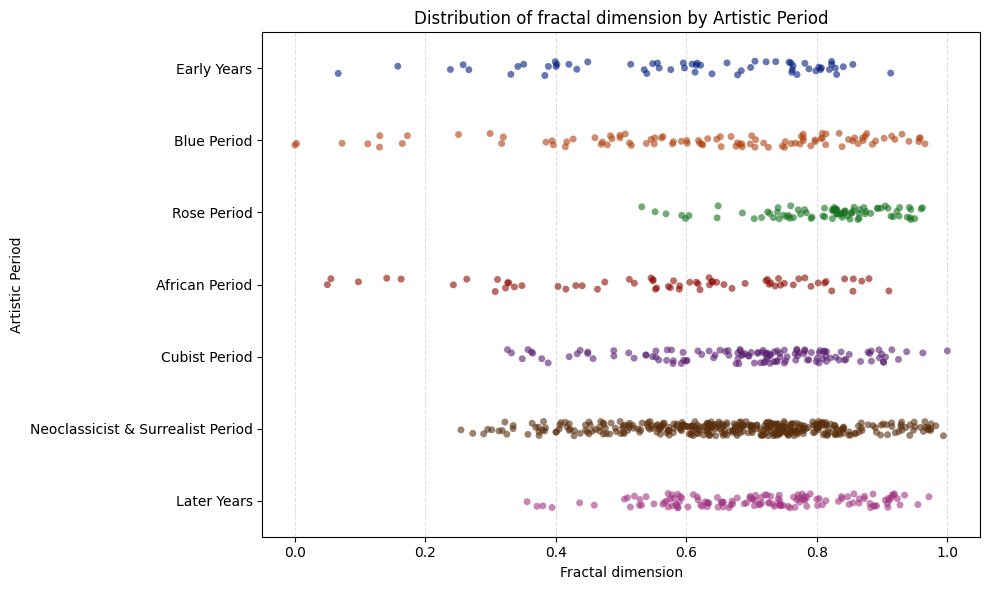

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT NORMALIZED\\BIFORCATION MAP\\fractal_dimension_by_artistic_period.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

C:\Users\ricca\AppData\Local\Temp\ipykernel_23412\1033809799.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


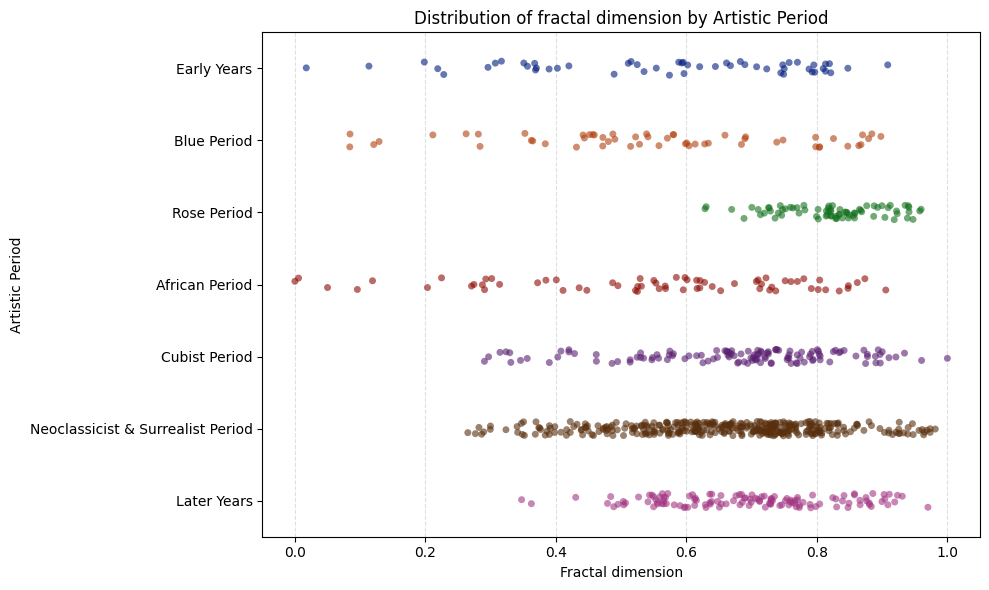

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT NORMALIZED\\BIFORCATION MAP\\fractal_dimension_by_artistic_period.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\360621014.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


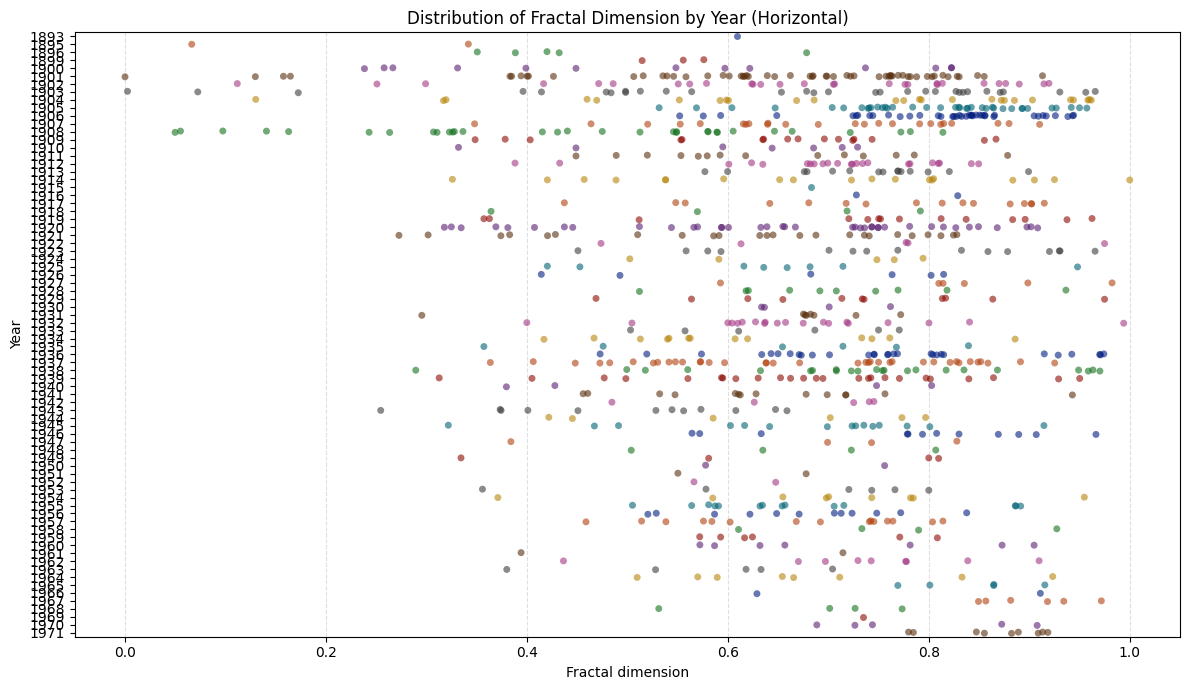

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(12, 7)) # Aumentiamo leggermente la dimensione per gli anni

sns.stripplot(
    data=df,
    y="Year", # 'Year' sull'asse Y per l'orientamento orizzontale
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h', # Orientamento orizzontale
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Year")
plt.title("Distribution of Fractal Dimension by Year (Horizontal)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('fractal_dimension_by_year_horizontal.png')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\2076532449.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


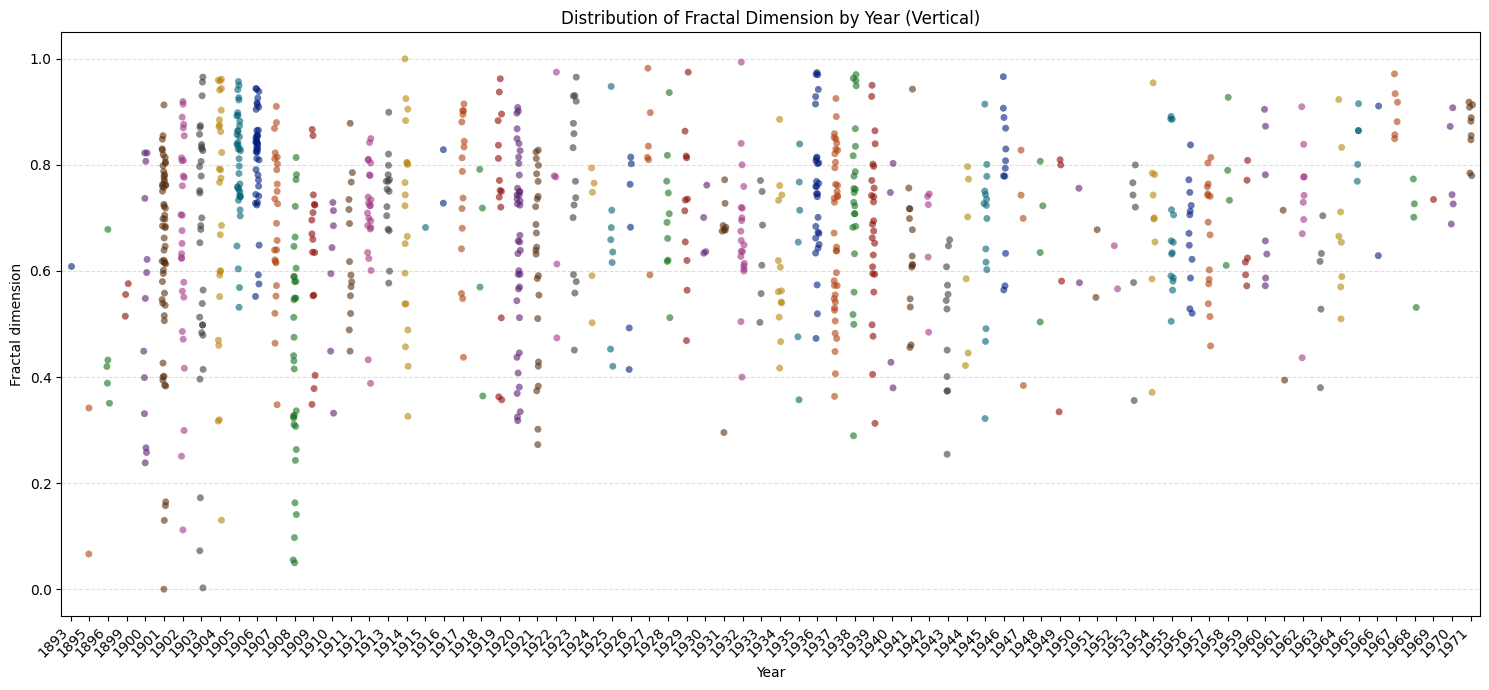

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\normalized_metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(15, 7)) # Aumentiamo la dimensione per accomodare gli anni sull'asse X

sns.stripplot(
    data=df,
    x="Year", # 'Year' sull'asse X per l'orientamento verticale
    y="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='v', # Orientamento verticale
    palette="dark"
)

plt.xlabel("Year")
plt.ylabel("Fractal dimension")
plt.title("Distribution of Fractal Dimension by Year (Vertical)")
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Griglia sull'asse Y
plt.xticks(rotation=45, ha='right') # Ruotiamo le etichette dell'asse X per leggibilità
plt.tight_layout()

plt.savefig('fractal_dimension_by_year_vertical.png')
plt.show()

# **STEP 15.1: MAPPE DI BIFORCAZIONE**

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\3712102887.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


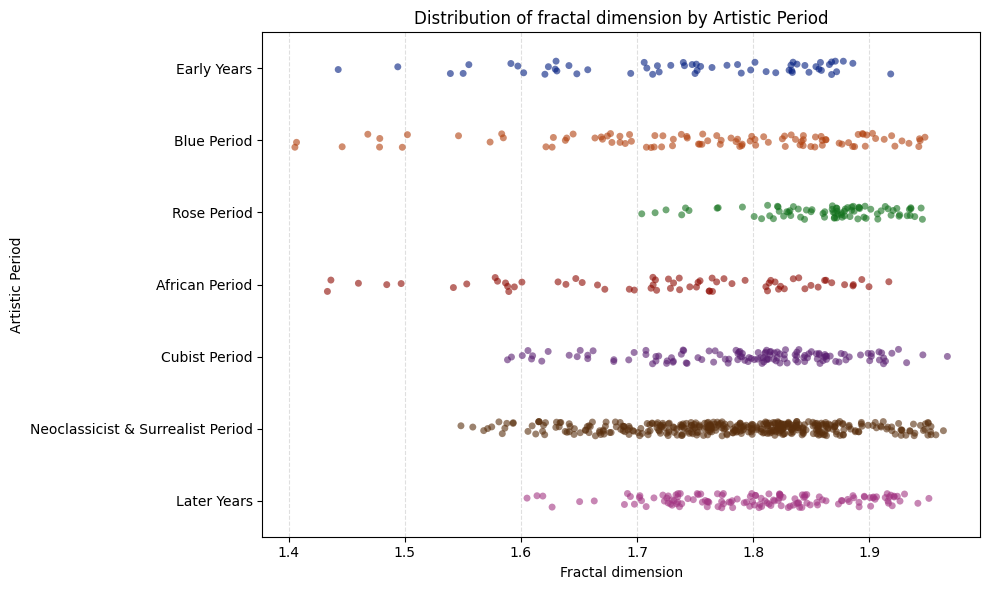

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT\\BIFORCATION MAP\\fractal_dimension_by_artistic_period.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\3712102887.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


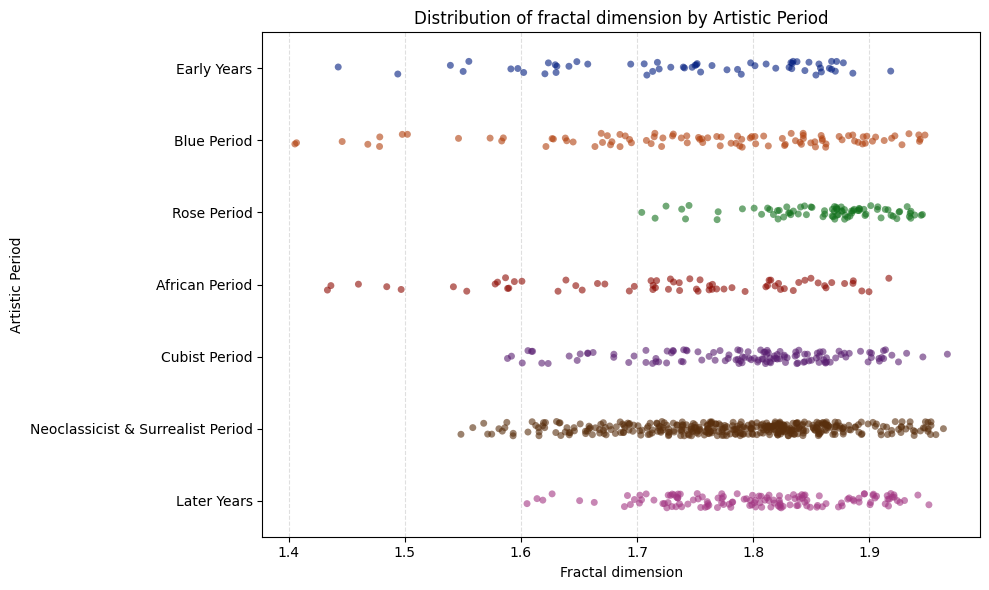

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
# Assicurati che il file 'normalized_metrics_with_details_no_outlier.csv' sia nella stessa directory
# o fornisci il percorso completo al file.
try:
    df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit() # Esce dallo script se il file non viene trovato

# Definisci l'ordine desiderato dei periodi artistici
ordered_styles = [
    "Early Years",
    "Blue Period",
    "Rose Period",
    "African Period",
    "Cubist Period",
    "Neoclassicist & Surrealist Period",
    "Later Years"
]

# Converti la colonna 'Period' in un tipo categorico con l'ordine specificato
df['Period'] = pd.Categorical(df['Period'], categories=ordered_styles, ordered=True)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df,
    y="Period",
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h',
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Artistic Period")
plt.title("Distribution of fractal dimension by Artistic Period")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Salva il grafico in un file
plt.savefig('.\\PLOT\\BIFORCATION MAP\\fractal_dimension_by_artistic_period.png')

plt.show() # Mostra il plot (opzionale, se vuoi vederlo subito)

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\1981420630.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


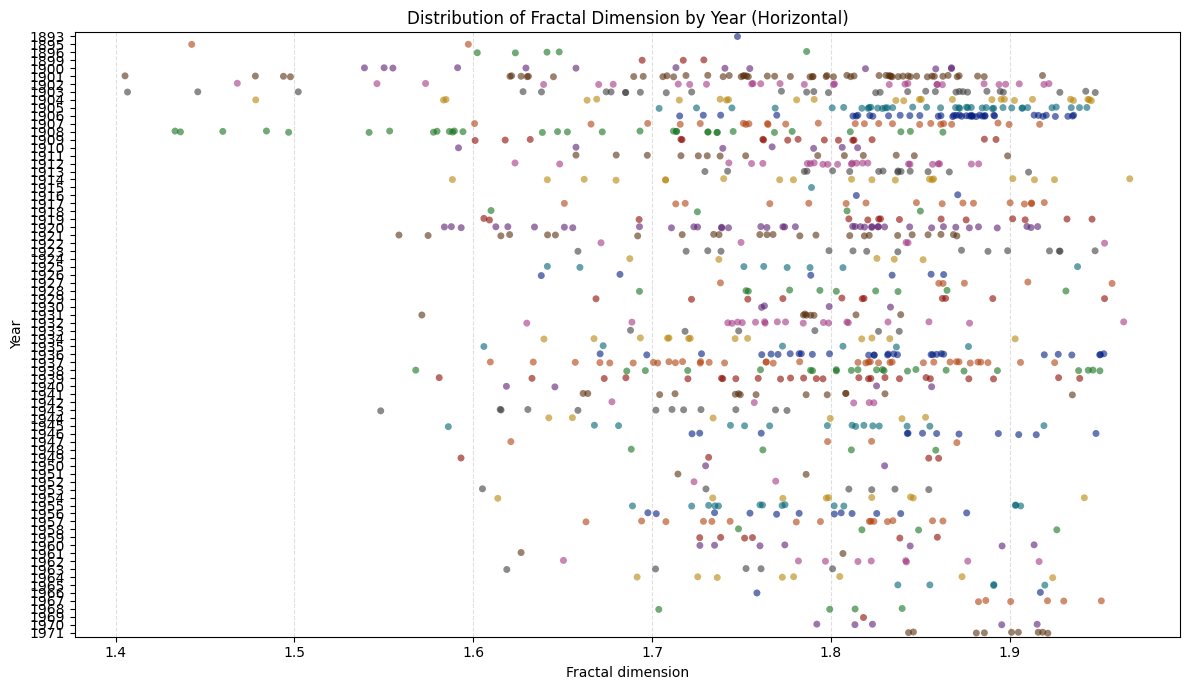

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(12, 7)) # Aumentiamo leggermente la dimensione per gli anni

sns.stripplot(
    data=df,
    y="Year", # 'Year' sull'asse Y per l'orientamento orizzontale
    x="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='h', # Orientamento orizzontale
    palette="dark"
)

plt.xlabel("Fractal dimension")
plt.ylabel("Year")
plt.title("Distribution of Fractal Dimension by Year (Horizontal)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('.\\PLOT\\BIFORCATION MAP\\fractal_dimension_by_year_horizontal.png')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_27272\2554682689.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


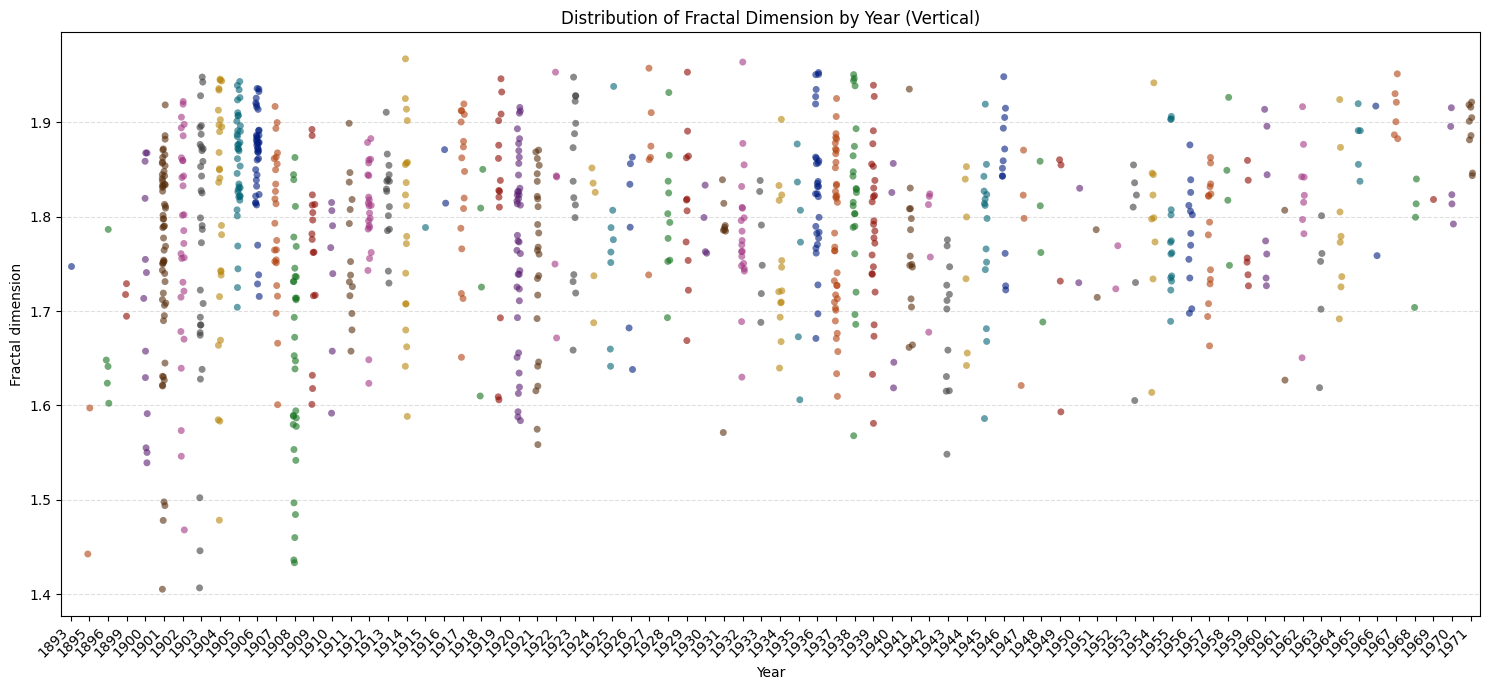

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati
try:
    df = pd.read_csv('.\\metrics_with_details_no_outlier.csv', decimal=',')
except FileNotFoundError:
    print("Errore: Il file 'normalized_metrics_with_details_no_outlier.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script o che il percorso sia corretto.")
    exit()

plt.figure(figsize=(15, 7)) # Aumentiamo la dimensione per accomodare gli anni sull'asse X

sns.stripplot(
    data=df,
    x="Year", # 'Year' sull'asse X per l'orientamento verticale
    y="Fractal dimension",
    alpha=0.6,
    size=5,
    jitter=True,
    orient='v', # Orientamento verticale
    palette="dark"
)

plt.xlabel("Year")
plt.ylabel("Fractal dimension")
plt.title("Distribution of Fractal Dimension by Year (Vertical)")
plt.grid(True, axis='y', linestyle='--', alpha=0.4) # Griglia sull'asse Y
plt.xticks(rotation=45, ha='right') # Ruotiamo le etichette dell'asse X per leggibilità
plt.tight_layout()

plt.savefig('.\\PLOT\\BIFORCATION MAP\\fractal_dimension_by_year_vertical.png')
plt.show()